# Classifier Creation & Selection

In [1]:
# Declare the dataframe path and file type
df_path = "../df/"
ds_path = "../ds/I080/"

In [2]:
# Read and save dataframe
import pandas as pd 
def read_df(file_name):
    df = pd.read_csv(df_path+file_name)
    return df

In [3]:
# Get the file list
import os
files = os.listdir(df_path)

### Random 70/30 Split on the entire dataset

In [4]:
import random
def train_test_split_1():
    # Create the train/test split
    file_names = [file[:-4] for file in files]
    random.seed(1720)
    random.shuffle(file_names)
    train_names = file_names[:70]
    test_names = file_names[30:]
    for file_name in train_names:
        df_train[file_name] = read_df(file_name+".csv")
    for file_name in train_names:
        df_test[file_name] = read_df(file_name+".csv")

In [5]:
import pandas as pd
def split_x_y(df_list):
    df = pd.concat(df_list, ignore_index=True)
    x = df.drop(columns=['v1','v2','weight','opt_label'])
    y = df['opt_label']
    return x,y

In [6]:
df_train = {}
df_test = {}
train_test_split_1()
X_train, Y_train = split_x_y(df_train)
X_test, Y_test = split_x_y(df_test)

In [7]:
# Get feature list
features = "weight_nor_max,weight_nor_abs,weight_abs_var,loc_rank_i,loc_rank_j,degree_cen_max,degree_cen_min,between_cen_max,between_cen_min,eigen_cen_max,eigen_cen_min".split(',')

## Classifiers

In [8]:
clfs = []
# class_weight='balanced'

### Random Forest classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
# Default classifier is applied first
clf_rf = RandomForestClassifier(class_weight='balanced')
clf_rf.fit(X_train,Y_train)
clfs.append(clf_rf)

In [10]:
def takeSecond(elem):
    return elem[1]
feature_importance = list(zip(features, clf_rf.feature_importances_))
for each in sorted(feature_importance,key=takeSecond, reverse=True):
    print("The importance for feature \"{}\" is {}".format(each[0], each[1]))
print("The average feature importance is {}".format(1/len(feature_importance)))

The importance for feature "degree_cen_min" is 0.1464537889647038
The importance for feature "between_cen_max" is 0.14304393934918122
The importance for feature "eigen_cen_min" is 0.1178837366798145
The importance for feature "degree_cen_max" is 0.10588710115629248
The importance for feature "weight_nor_max" is 0.09583521948190199
The importance for feature "weight_abs_var" is 0.09132355741462211
The importance for feature "weight_nor_abs" is 0.08975283777510447
The importance for feature "eigen_cen_max" is 0.07790470528681817
The importance for feature "between_cen_min" is 0.04919824177428346
The importance for feature "loc_rank_i" is 0.04152128238905572
The importance for feature "loc_rank_j" is 0.04119558972822225
The average feature importance is 0.09090909090909091


### Support Vector Machine classifier

In [11]:
from sklearn import svm
# Default classifier is applied first
clf_svm = svm.SVC(class_weight='balanced', probability=True)
clf_svm.fit(X_train,Y_train)
clfs.append(clf_svm)

### Naive Bayes classifier

In [12]:
from sklearn.naive_bayes import GaussianNB
# Default classifier is applied first
clf_nb = GaussianNB()
clf_nb.fit(X_train,Y_train)
clfs.append(clf_nb)

### K-Nearnest Neighbors classifier

In [45]:
from sklearn.neighbors import KNeighborsClassifier
# Default classifier is applied first
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train,Y_train)
clfs.append(clf_knn)

TypeError: __init__() got an unexpected keyword argument 'n'

### Logistic Regresion

In [14]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(class_weight='balanced',max_iter=1000)
clf_lr.fit(X_train,Y_train)
clfs.append(clf_lr)

# Model Evaluation 

### Evaluation based on confusion matrix
#### Plot: "Pruning Rate vs 1 - FN Rate" when Threshold changes

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
my_thresholds = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.175, 0.15, 0.125, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0001]
clf_thresholds = {}
def evaluation_confusion(clf):
    x_pruning = []
    y_loss = []
    clf_thresholds[clf.__class__.__name__] = []
    for threshold in my_thresholds:
        Y_pred_proba = clf.predict_proba(X_test)
        Y_pred = (Y_pred_proba [:,1] >= threshold).astype('int')
        tn, fp, fn, tp = confusion_matrix(Y_test,Y_pred).ravel()
        matrix = confusion_matrix(Y_test,Y_pred)
        x_pruning.append(round(100*(1-(tp+fp)/len(Y_pred)),2))
        y_loss.append(round(100*(1-(tp)/(tp+fn)),2))
        # If the threshold change cannot make change anymore on performance
        if (y_loss[-1] != y_loss[0]) and (y_loss[-1] == y_loss[-2]):
            y_loss = y_loss[:-1]
            x_pruning = x_pruning[:-1]
            print("The threshold <= {} are useless for classifier {}".format(threshold, clf.__class__.__name__))
            clf_thresholds[clf.__class__.__name__] = my_thresholds[:my_thresholds.index(threshold)]
            break
    # Every threshold number is useful
    if len(clf_thresholds[clf.__class__.__name__]) == 0:
        clf_thresholds[clf.__class__.__name__] = my_thresholds.copy()
    print("Purning Rate(%):", x_pruning)
    print("Optimal Edges Loss Rate(%):", y_loss)
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(x_pruning, y_loss, marker=".")
    ax.set_xlabel("Purning Rate(%)")
    ax.set_ylabel("Optimal Edges Loss Rate(%)")
    ax.set_title("Purning Rate VS. Optimal Edges Loss Rate when Threshold Moves")
    plt.show()

The following evaluation is for classifier: RandomForestClassifier
The threshold <= 0.3 are useless for classifier RandomForestClassifier
Purning Rate(%): [99.6, 98.65, 97.76, 97.69, 97.69]
Optimal Edges Loss Rate(%): [82.57, 41.62, 3.21, 0.08, 0.0]


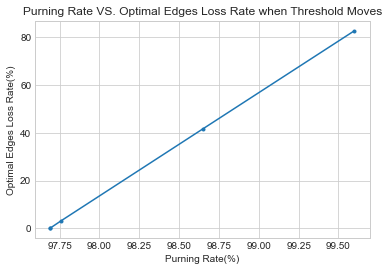


The following evaluation is for classifier: SVC
The threshold <= 0.0001 are useless for classifier SVC
Purning Rate(%): [99.91, 99.85, 99.77, 99.67, 99.54, 99.36, 98.89, 98.55, 97.89, 96.34, 92.48, 85.84, 71.2, 53.59, 23.74]
Optimal Edges Loss Rate(%): [98.73, 98.05, 97.21, 96.19, 95.09, 93.57, 87.39, 82.32, 72.25, 54.06, 29.53, 19.12, 3.55, 0.17, 0.0]


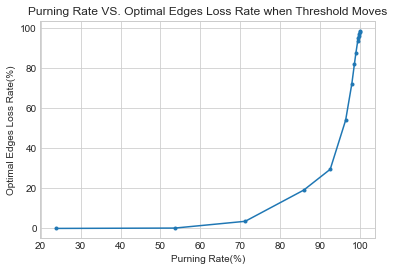


The following evaluation is for classifier: GaussianNB
Purning Rate(%): [92.71, 92.03, 91.47, 90.78, 90.04, 89.2, 88.08, 87.66, 87.2, 86.62, 85.83, 83.12, 79.95, 78.96, 74.32, 62.68]
Optimal Edges Loss Rate(%): [57.36, 54.74, 52.96, 49.92, 47.12, 44.92, 41.2, 39.85, 38.32, 36.46, 34.43, 26.4, 18.27, 17.01, 14.81, 11.76]


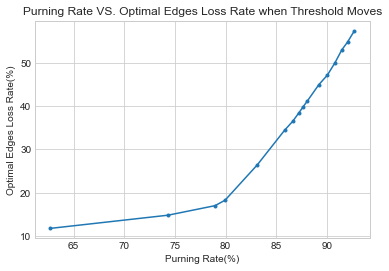


The following evaluation is for classifier: KNeighborsClassifier
The threshold <= 0.5 are useless for classifier KNeighborsClassifier
Purning Rate(%): [99.81, 99.81, 99.32]
Optimal Edges Loss Rate(%): [92.3, 92.3, 77.66]


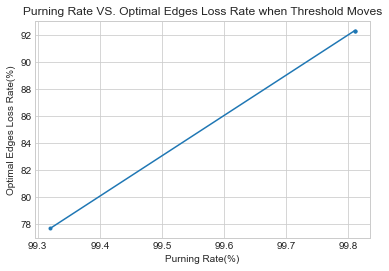


The following evaluation is for classifier: LogisticRegression
The threshold <= 0.1 are useless for classifier LogisticRegression
Purning Rate(%): [91.23, 87.78, 86.03, 84.71, 79.24, 68.45, 53.25, 50.52, 47.85, 45.52]
Optimal Edges Loss Rate(%): [36.89, 27.41, 22.84, 19.8, 12.44, 5.33, 0.76, 0.42, 0.17, 0.0]


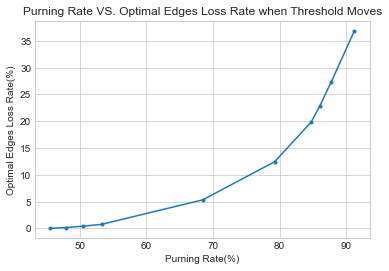

In [16]:
for clf in clfs:
    print("The following evaluation is for classifier: " + clf.__class__.__name__)
    evaluation_confusion(clf)
    print()

### I would like to keep Random Forest, SVC, and Logistic Regression for following evaluations

In [17]:
clfs = clfs[:2] + [clfs[-1]]

### Evaluation based on Quality changes VS. Runtime changes

#### Plots: "Purning Rate vs Objective Values" when Threshold changes

In [18]:
import numpy as np
def read_graph(name):
    with open(name) as f:
        lines = f.readlines()
        arcs = []
        for line in lines:
            if line == '\n': 
                continue
            parts = line.split()
            det = parts[0]
            if det == 'Name':
                name = parts[1]
            elif det == 'Nodes':
                n_vertices = int(parts[1])
            elif det == 'Edges':
                n_edges = int(parts[1])
            elif det == 'E':
                i = int(parts[1])
                j = int(parts[2])
                c = int(parts[3])
                arcij = ((i,j),c)
                arcji = ((j,i),c)
                arcs.append(arcij)
                arcs.append(arcji)
            elif det == 'Terminals':
                n_terminals = int(parts[1])
        vertices = np.arange(1, int(n_vertices)+1)
        vertices = vertices.tolist()
        terminals = np.arange(1, int(n_terminals)+1)
        terminals = terminals.tolist()
        assert(int(n_edges) == len(arcs)/2)
    f.close()
    ### The format of graphs is dG=(V,dE,Z) 
    return [vertices, arcs, terminals]

In [19]:
import gurobipy as gp
from gurobipy import GRB
def get_opt(graph):
    # read dG=(V,dE,Z) 
    vertices, arcs, terminals = graph
    
    # obtain the size of each set
    n = len(vertices) # n = number of vertices
    m = len(arcs)/2 # m = number of edges
    p = len(terminals) # p = number of ternimals
    
    # choose 1 out of ternimals as the source vertex
    v0 = terminals[0] 

    # delete all the arcs that enter the source vertex
    arcs = [arc for arc in arcs if not arc[0][1] == v0]

    # create the tuple dictionary of arcs
    arcs_dict = gp.tupledict(arcs)
    
    # create the model
    m = gp.Model("Steiner")
    m.Params.PoolGapAbs = 1
    
    # create the decision variables
    # number of variables: 2m + m - 1
    x = m.addVars(arcs_dict.keys(),vtype=GRB.BINARY, name='x')
    u = m.addVars(vertices,lb=-1,ub=n, vtype=GRB.INTEGER, name='u' )
    
    # set up the objective function
    # equation (1)
    m.setObjective(gp.quicksum(arcs_dict[i, j] * x[i, j] for (i, j) in arcs_dict.keys()), GRB.MINIMIZE)
    
    # create the constraints
    vertices = vertices[:v0-1] + vertices[v0:]
    for j in vertices: # number: 3n - 3
        # equation (2)
        m.addConstr(x.sum('*', j) <= 1)
        # equation (3)
        m.addConstr(n * x.sum('*', j) >= u[j] + 1)
        # equation (4)
        m.addConstr((n + 1) * x.sum('*', j) <= n * (u[j] + 1))
        
    for ij in arcs_dict.keys(): # number: 4m
        i = ij[0]
        j = ij[1]
        # equation (5)
        m.addConstr(1 - n * (1 - x[i, j] ) <= u[j] - u[i])
        m.addConstr(1 + n * (1 - x[i, j] ) >= u[j] - u[i])
    
    ternimals = terminals[1:]
    for j in terminals: # number: p - 1
        # equation (7)
        m.addConstr( u[j] >= 0 )
    
    # equation (7)    
    m.addConstr( u[v0] == 0 )
    
    # update the model
    m.update()
    
    # optimize the model
    m.optimize()
    
    # save the optimal solution
    # save the cost
    opt_cost = m.objVal
    opt_runtime = m.Runtime
                
    return opt_cost, opt_runtime

In [20]:
graphs = {}
costs_before = []
runtimes_before = []

In [21]:
# Calculate the cost and runtime before pruning
for file_name in df_test:
    # Read the test graph and calculate the cost
    graph = read_graph(ds_path+file_name+".stp")
    graphs[file_name] = graph
    cost_before, runtime_before = get_opt(graph)
    costs_before.append(cost_before)
    runtimes_before.append(runtime_before)

Academic license - for non-commercial use only - expires 2021-05-31
Using license file C:\Users\17200334\gurobi.lic
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2752 rows, 1329 columns and 11416 nonzeros
Model fingerprint: 0x678ba864
Variable types: 0 continuous, 1329 integer (1249 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 49 rows and 1 columns
Presolve time: 0.02s
Presolved: 2703 rows, 1328 columns, 10871 nonzeros
Variable types: 0 continuous, 1328 integer (1249 binary)
Found heuristic solution: objective 4265.0000000

Root relaxation: objective 2.880410e+03, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds     

     0     0 3807.01235    0   54 3932.00000 3807.01235  3.18%     -    1s
     0     0 3809.03797    0   14 3932.00000 3809.03797  3.13%     -    1s
     0     0 3814.01266    0   14 3932.00000 3814.01266  3.00%     -    1s
     0     0 3816.01266    0   54 3932.00000 3816.01266  2.95%     -    1s
     0     0 3819.01266    0   10 3932.00000 3819.01266  2.87%     -    2s
     0     0 3821.01282    0   48 3932.00000 3821.01282  2.82%     -    2s
     0     0 3823.01266    0    8 3932.00000 3823.01266  2.77%     -    2s
     0     0 3825.00000    0   51 3932.00000 3825.00000  2.72%     -    2s
     0     0 3826.01266    0    8 3932.00000 3826.01266  2.70%     -    2s
     0     0 3828.00000    0   44 3932.00000 3828.00000  2.64%     -    2s
     0     0 3828.01235    0   70 3932.00000 3828.01235  2.64%     -    2s
     0     0 3828.01235    0   44 3932.00000 3828.01235  2.64%     -    2s
     0     0 3836.00000    0   38 3932.00000 3836.00000  2.44%     -    3s
     0     0 3836.00000  

 197597 93139     cutoff   90      3932.00000 3892.00000  1.02%  11.6  321s
 201860 94821 3911.27885  103   20 3932.00000 3892.51282  1.00%  11.7  325s
 206351 96452 3924.00000  134   25 3932.00000 3893.02597  0.99%  11.6  331s
 209796 98240     cutoff  145      3932.00000 3893.42087  0.98%  11.6  336s
 213240 99495     cutoff   87      3932.00000 3894.00000  0.97%  11.6  340s
 217440 100958     cutoff  108      3932.00000 3894.17704  0.96%  11.6  345s
 221596 102673 3930.70378  139   25 3932.00000 3895.00000  0.94%  11.6  350s
 225587 104349 3912.62821   99    9 3932.00000 3895.12166  0.94%  11.6  355s
 229263 105407     cutoff   59      3932.00000 3895.78393  0.92%  11.6  360s
 233504 106647     cutoff  150      3932.00000 3896.03846  0.91%  11.6  366s
 237169 107685 3902.10334  145   40 3932.00000 3896.59088  0.90%  11.6  370s
 241117 109085 3899.00000   56   26 3932.00000 3897.00000  0.89%  11.6  376s
 245362 109861     cutoff   75      3932.00000 3897.28571  0.88%  11.5  380s
 246

 552356 114055 3923.04604   58   51 3932.00000 3918.84631  0.33%  10.9  862s
 556499 113520     cutoff  179      3932.00000 3919.00000  0.33%  10.9  871s
 560765 113396     cutoff  140      3932.00000 3919.01075  0.33%  10.9  878s
 564847 112281     cutoff  172      3932.00000 3919.07692  0.33%  10.9  883s
 567819 111476 3921.01282   69    8 3932.00000 3919.35227  0.32%  10.9  887s
 570084 109845     cutoff  157      3932.00000 3919.61027  0.32%  10.9  893s
 573884 108878 3928.61538   86   18 3932.00000 3920.00000  0.31%  10.9  900s
 577484 108428     cutoff  251      3932.00000 3920.00000  0.31%  10.9  908s
 581682 107240 3920.03846  187    2 3932.00000 3920.03846  0.30%  10.9  915s
 587508 105653     cutoff   55      3932.00000 3920.35897  0.30%  10.9  922s
 589856 104861 3921.11538  120    2 3932.00000 3920.56494  0.29%  10.9  926s
 591853 103452     cutoff  137      3932.00000 3920.86355  0.28%  10.9  932s
 595907 102738     cutoff  154      3932.00000 3921.00000  0.28%  10.9  940s

     0     0 1629.00649    0   31 1872.00000 1629.00649  13.0%     -    0s
     0     0 1632.00000    0   23 1872.00000 1632.00000  12.8%     -    0s
     0     0 1632.00938    0   35 1872.00000 1632.00938  12.8%     -    0s
     0     0 1642.50318    0   41 1872.00000 1642.50318  12.3%     -    0s
     0     0 1642.66667    0   37 1872.00000 1642.66667  12.3%     -    0s
     0     0 1642.66667    0   38 1872.00000 1642.66667  12.3%     -    0s
     0     0 1642.66690    0   54 1872.00000 1642.66690  12.3%     -    0s
     0     0 1642.68712    0   56 1872.00000 1642.68712  12.2%     -    0s
     0     0 1642.89969    0   47 1872.00000 1642.89969  12.2%     -    0s
     0     0 1642.89969    0   47 1872.00000 1642.89969  12.2%     -    0s
     0     2 1642.89969    0   47 1872.00000 1642.89969  12.2%     -    0s
H  472   358                    1861.0000000 1646.13750  11.5%   4.4    0s
H 1526   951                    1762.0000000 1669.57500  5.25%   4.1    3s
  1577   994 1672.78750  

 33980 11186 4287.41772   45  165 4341.00000 4287.41772  1.23%  15.8   70s
 38262 11530 4287.41772   49   79 4341.00000 4287.41772  1.23%  17.3   76s
 43076 11639 4331.28118   46   45 4341.00000 4287.41772  1.23%  18.2   80s
 50246 11076     cutoff   43      4341.00000 4287.41772  1.23%  19.2   85s
 57878 10144 4335.35443   49   16 4341.00000 4287.41772  1.23%  19.8   90s
 65294 10290 4317.67057   46   91 4341.00000 4287.41772  1.23%  20.4   95s
 71742 11353 4287.41772   59  151 4341.00000 4287.41772  1.23%  21.1  100s
 78278 11792 4331.27188   45   83 4341.00000 4287.41772  1.23%  21.7  105s
 85229 12458     cutoff   58      4341.00000 4287.41772  1.23%  22.4  110s
 90950 12901 4295.76923   34   82 4341.00000 4287.41772  1.23%  23.2  115s
 97176 13456 4324.12500   49    4 4341.00000 4287.41772  1.23%  23.9  120s
 102758 13836 4290.70868   57   64 4341.00000 4288.99318  1.20%  24.5  125s
 108514 14078     cutoff   59      4341.00000 4293.22500  1.10%  25.1  130s
 114621 14014     cutof

H  482   224                    1883.0000000 1699.48287  9.75%   5.5    0s
*  726   184               8    1866.0000000 1777.31250  4.75%   6.3    0s

Cutting planes:
  Learned: 1
  Gomory: 3
  Cover: 56
  Implied bound: 81
  Clique: 7
  MIR: 21
  StrongCG: 2
  GUB cover: 6
  Inf proof: 2
  Zero half: 1
  Relax-and-lift: 23

Explored 975 nodes (6377 simplex iterations) in 0.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1866 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.866000000000e+03, best bound 1.866000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2750 rows, 1332 columns and 11435 nonzeros
Model fingerprint: 0x1963614b
Variable types: 0 continuous, 1332 integer (1252 binary)
Coefficient statistics:
  Matrix range    

     0     0 1489.53125    0   39 1913.00000 1489.53125  22.1%     -    0s
     0     0 1492.53269    0   37 1913.00000 1492.53269  22.0%     -    0s
     0     0 1492.64415    0   38 1913.00000 1492.64415  22.0%     -    0s
     0     0 1493.09375    0   26 1913.00000 1493.09375  22.0%     -    0s
     0     0 1493.10897    0   35 1913.00000 1493.10897  21.9%     -    0s
     0     0 1494.52594    0   40 1913.00000 1494.52594  21.9%     -    0s
     0     0 1494.52594    0   38 1913.00000 1494.52594  21.9%     -    0s
     0     2 1498.00000    0   37 1913.00000 1498.00000  21.7%     -    0s
H   34    40                    1807.0000000 1503.16282  16.8%  10.1    0s
*  291   179              14    1788.0000000 1503.16282  15.9%   5.5    0s
H  319   207                    1775.0000000 1503.16282  15.3%   5.4    0s
H  327   207                    1705.0000000 1506.46250  11.6%   5.5    0s
* 1604   259              12    1696.0000000 1596.88953  5.84%   6.9    0s
* 1722    43             

H    0     0                    1499.0000000 1283.00122  14.4%     -    0s
     0     0 1283.04878    0   15 1499.00000 1283.04878  14.4%     -    0s
     0     0 1283.17500    0   29 1499.00000 1283.17500  14.4%     -    0s
     0     0 1283.25000    0   24 1499.00000 1283.25000  14.4%     -    0s
     0     0 1284.00000    0   24 1499.00000 1284.00000  14.3%     -    0s
     0     0 1284.00000    0    3 1499.00000 1284.00000  14.3%     -    0s
     0     2 1284.00000    0    3 1499.00000 1284.00000  14.3%     -    0s
*   88    92              13    1478.0000000 1285.02564  13.1%   5.3    0s
* 1182   642              23    1397.0000000 1289.15016  7.72%   4.3    0s

Cutting planes:
  Learned: 4
  Gomory: 2
  Cover: 162
  Implied bound: 204
  MIR: 8
  GUB cover: 16
  Inf proof: 3
  Zero half: 2
  Relax-and-lift: 13

Explored 6610 nodes (49449 simplex iterations) in 1.28 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1397 

Optimal solution found (tolerance 1.

H    0     0                    4760.0000000 4751.61480  0.18%     -    0s
     0     0     cutoff    0      4760.00000 4760.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 3
  Cover: 31
  Implied bound: 20
  Clique: 14
  MIR: 16
  GUB cover: 4
  Zero half: 2
  RLT: 4
  Relax-and-lift: 8

Explored 1 nodes (549 simplex iterations) in 0.16 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4760 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.760000000000e+03, best bound 4.760000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12736 rows, 6321 columns and 56344 nonzeros
Model fingerprint: 0x21b325ca
Variable types: 0 continuous, 6321 integer (6241 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Obje

 20408 12897 3128.33333   92    2 3150.00000 3058.00000  2.92%  10.0   45s
 25780 17465 3135.72152  125   20 3150.00000 3062.08515  2.79%   9.9   50s
 30396 19694 3135.00000   79    6 3150.00000 3063.07076  2.76%   9.4   65s
 30432 19718 3130.15385   72   55 3150.00000 3063.07076  2.76%   9.4   70s
 30442 19725 3112.51757   53  246 3150.00000 3063.07076  2.76%   9.4   75s
 30451 19731 3135.87277  149  235 3150.00000 3063.07076  2.76%   9.4   80s
 30462 19738 3121.10256   40  235 3150.00000 3063.07076  2.76%   9.4   85s
 30470 19743 3103.02564   66  291 3150.00000 3063.07076  2.76%   9.4   90s
 30475 19747 3145.00400   88  280 3150.00000 3063.07076  2.76%   9.4   97s
 30478 19752 3063.07076   30  246 3150.00000 3063.07076  2.76%   9.6  101s
 30507 19769 3110.50000   34    4 3150.00000 3063.07076  2.76%   9.7  105s
 31294 20070 3133.03846   63    4 3150.00000 3063.07076  2.76%   9.9  110s
 33012 20341     cutoff  182      3150.00000 3063.07076  2.76%   9.9  115s
 35386 20840     cutoff  

 483648 103722     cutoff  188      3150.00000 3139.00000  0.35%   8.3  603s
 486497 103258 3139.00000  143    2 3150.00000 3139.00000  0.35%   8.3  607s
 488977 103509 3145.03846   92    4 3150.00000 3139.00000  0.35%   8.3  611s
 491788 103704 3148.03846  130    2 3150.00000 3139.03846  0.35%   8.3  615s
 497218 101709     cutoff  189      3150.00000 3139.15385  0.34%   8.3  622s
 500643 100573     cutoff  190      3150.00000 3139.47756  0.33%   8.3  626s
 502132 99628     cutoff  161      3150.00000 3139.76250  0.33%   8.3  630s
 504668 98632 3147.84896  172   24 3150.00000 3140.00000  0.32%   8.3  635s
 510540 97595 3142.05128  191    5 3150.00000 3140.00000  0.32%   8.3  645s
 514219 97150 3141.03846  174    2 3150.00000 3140.03846  0.32%   8.3  650s
 519992 94864     cutoff  185      3150.00000 3140.23080  0.31%   8.3  657s
 523468 92380     cutoff  174      3150.00000 3140.77264  0.29%   8.3  663s
 526469 91203     cutoff  174      3150.00000 3141.00000  0.29%   8.3  669s
 52778

     0     0 3528.23626    0  121 3920.00000 3528.23626  10.0%     -    0s
     0     0 3528.23626    0  121 3920.00000 3528.23626  10.0%     -    0s
     0     2 3529.57772    0  121 3920.00000 3529.57772  10.0%     -    0s
H  201   191                    3917.0000000 3544.23342  9.52%  10.8    0s
H 1667  1130                    3867.0000000 3552.46139  8.13%   6.8    1s
H 1677  1080                    3845.0000000 3553.51942  7.58%   6.7    1s
H 1694  1035                    3826.0000000 3558.94337  6.98%   6.6    2s
H 1697   984                    3824.0000000 3559.55456  6.92%   6.6    2s
  8774  3313 3670.05131   23   57 3824.00000 3643.22500  4.73%  12.3    5s
*12075  4430              68    3820.0000000 3652.05152  4.40%  12.4    5s
*12080  4400              68    3817.0000000 3652.05152  4.32%  12.4    5s
H13100  4730                    3812.0000000 3654.22500  4.14%  12.7    6s
H13157  2364                    3736.0000000 3654.32489  2.19%  12.7    6s
 25668   321     cutoff  


Root relaxation: objective 3.535385e+03, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3535.38462    0   18          - 3535.38462      -     -    0s
     0     0 3864.34615    0   17          - 3864.34615      -     -    0s
     0     0 3870.33333    0   22          - 3870.33333      -     -    0s
     0     0 3870.33333    0   23          - 3870.33333      -     -    0s
     0     0 4059.39006    0   23          - 4059.39006      -     -    0s
     0     0 4060.37139    0   23          - 4060.37139      -     -    0s
     0     0 4160.48281    0   34          - 4160.48281      -     -    0s
H    0     0                    5962.0000000 4160.48281  30.2%     -    0s
     0     0 4160.48281    0   35 5962.00000 4160.48281  30.2%     -    0s
     0     0 4347.37366    0   29 5962.00000 4347.37366  27.1%     -    0s
H    0     0                

  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 43 rows and 7 columns
Presolve time: 0.01s
Presolved: 821 rows, 383 columns, 2814 nonzeros
Variable types: 0 continuous, 383 integer (304 binary)

Root relaxation: objective 9.843718e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  984.37179    0    9          -  984.37179      -     -    0s
     0     0 1130.44071    0   10          - 1130.44071      -     -    0s
     0     0 1485.26325    0   25          - 1485.26325      -     -    0s
     0     0 1485.27575    0   25          - 1485.27575      -     -    0s
     0     0 1497.15423    0   29          - 1497.15423      -     -    0s
     0     0 1497.16609    0   30          - 1497.16609      -     -    0s
     0     0 1593.06346    0   24          - 1593.06346      -     -    0s
     0     0 1599.0148

     0     0 3297.78026    0  120 3630.00000 3297.78026  9.15%     -    0s
     0     0 3301.00495    0  124 3630.00000 3301.00495  9.06%     -    0s
     0     0 3301.28544    0  126 3630.00000 3301.28544  9.06%     -    0s
     0     0 3301.49183    0  122 3630.00000 3301.49183  9.05%     -    0s
     0     0 3302.97686    0  105 3630.00000 3302.97686  9.01%     -    0s
     0     0 3303.34622    0  139 3630.00000 3303.34622  9.00%     -    0s
     0     0 3303.34766    0  141 3630.00000 3303.34766  9.00%     -    0s
     0     0 3305.00466    0  126 3630.00000 3305.00466  8.95%     -    0s
     0     0 3305.00466    0  125 3630.00000 3305.00466  8.95%     -    0s
     0     2 3305.00466    0  125 3630.00000 3305.00466  8.95%     -    0s
  3052  1840 3444.57500   74   13 3630.00000 3338.71136  8.02%  11.0    5s
H 8129  4263                    3613.0000000 3365.25000  6.86%   9.0    7s
H 8563  4508                    3611.0000000 3365.46250  6.80%   8.8    7s
*11584  5066             

     0     0 4150.01806    0  102 4827.00000 4150.01806  14.0%     -    0s
     0     0 4150.35702    0  107 4827.00000 4150.35702  14.0%     -    0s
     0     0 4151.68545    0  128 4827.00000 4151.68545  14.0%     -    0s
     0     0 4151.68545    0  127 4827.00000 4151.68545  14.0%     -    0s
     0     2 4151.68545    0  127 4827.00000 4151.68545  14.0%     -    0s
*  412   450              41    4620.0000000 4181.57849  9.49%  11.4    1s
H 1465  1085                    4606.0000000 4191.33910  9.00%   8.3    1s
H 1468  1032                    4505.0000000 4191.33910  6.96%   8.3    1s
H 1540  1035                    4424.0000000 4191.33910  5.26%  10.2    4s
H 1541   984                    4407.0000000 4191.33910  4.89%  10.2    4s
  2460  1388 4236.00000   23   24 4407.00000 4191.33910  4.89%  12.2    5s
 14587  6903 4336.22500   59    3 4407.00000 4226.22500  4.10%   8.4   10s
 27761 11543 4244.18750   37   17 4407.00000 4238.99756  3.81%   9.0   15s
 29322 11855 4272.00000  

     0     0 2999.26891    0   30          - 2999.26891      -     -    0s
     0     0 3032.76588    0   50          - 3032.76588      -     -    0s
     0     0 3036.99849    0   41          - 3036.99849      -     -    0s
     0     0 3037.02381    0   37          - 3037.02381      -     -    0s
     0     0 3131.08960    0   49          - 3131.08960      -     -    0s
     0     0 3182.09009    0   57          - 3182.09009      -     -    0s
     0     0 3182.12732    0   59          - 3182.12732      -     -    0s
H    0     0                    5573.0000000 3182.12732  42.9%     -    0s
     0     0 3209.18843    0   52 5573.00000 3209.18843  42.4%     -    0s
H    0     0                    5378.0000000 3209.18843  40.3%     -    0s
H    0     0                    4696.0000000 3209.18843  31.7%     -    0s
     0     0 3220.31671    0   65 4696.00000 3220.31671  31.4%     -    0s
     0     0 3225.18460    0   71 4696.00000 3225.18460  31.3%     -    0s
     0     0 3226.11911  

     0     0 1641.59375    0   21 1968.00000 1641.59375  16.6%     -    0s
     0     0 1641.59375    0   23 1968.00000 1641.59375  16.6%     -    0s
     0     0 1645.52564    0   19 1968.00000 1645.52564  16.4%     -    0s
     0     0 1645.57051    0   21 1968.00000 1645.57051  16.4%     -    0s
     0     0 1651.48750    0   29 1968.00000 1651.48750  16.1%     -    0s
     0     0 1651.49519    0   33 1968.00000 1651.49519  16.1%     -    0s
     0     0 1654.10000    0   20 1968.00000 1654.10000  16.0%     -    0s
     0     0 1654.13275    0   24 1968.00000 1654.13275  15.9%     -    0s
     0     0 1660.12564    0   21 1968.00000 1660.12564  15.6%     -    0s
     0     0 1660.13822    0   26 1968.00000 1660.13822  15.6%     -    0s
     0     0 1681.06362    0   11 1968.00000 1681.06362  14.6%     -    0s
     0     0 1687.60698    0   51 1968.00000 1687.60698  14.2%     -    0s
     0     0 1687.60698    0   56 1968.00000 1687.60698  14.2%     -    0s
     0     0 1690.00629  

     0     0 4193.15803    0   46 5267.00000 4193.15803  20.4%     -    0s
     0     0 4193.17704    0   47 5267.00000 4193.17704  20.4%     -    0s
     0     0 4266.21359    0   51 5267.00000 4266.21359  19.0%     -    0s
H    0     0                    5134.0000000 4266.21359  16.9%     -    0s
     0     0 4266.38419    0   76 5134.00000 4266.38419  16.9%     -    0s
     0     0 4286.24135    0   29 5134.00000 4286.24135  16.5%     -    0s
H    0     0                    5040.0000000 4286.24135  15.0%     -    0s
     0     0 4286.49842    0   39 5040.00000 4286.49842  15.0%     -    0s
     0     0 4307.61491    0   62 5040.00000 4307.61491  14.5%     -    0s
H    0     0                    5029.0000000 4307.61491  14.3%     -    0s
     0     0 4307.63560    0   62 5029.00000 4307.63560  14.3%     -    0s
     0     0 4316.09795    0   58 5029.00000 4316.09795  14.2%     -    0s
     0     0 4324.80128    0   43 5029.00000 4324.80128  14.0%     -    0s
     0     0 4324.82418  

     0     0 3045.50000    0   52 3162.00000 3045.50000  3.68%     -    3s
     0     0 3045.50000    0   60 3162.00000 3045.50000  3.68%     -    3s
     0     0 3045.50000    0   46 3162.00000 3045.50000  3.68%     -    3s
     0     0 3045.50000    0   49 3162.00000 3045.50000  3.68%     -    3s
     0     0 3045.50000    0   49 3162.00000 3045.50000  3.68%     -    3s
     0     0 3045.50000    0   49 3162.00000 3045.50000  3.68%     -    3s
     0     0 3046.00000    0   67 3162.00000 3046.00000  3.67%     -    3s
     0     0 3046.00000    0   48 3162.00000 3046.00000  3.67%     -    3s
     0     0 3046.00000    0   36 3162.00000 3046.00000  3.67%     -    3s
     0     0 3046.00000    0   36 3162.00000 3046.00000  3.67%     -    3s
     0     0 3046.00000    0   36 3162.00000 3046.00000  3.67%     -    4s
     0     0 3046.00000    0   36 3162.00000 3046.00000  3.67%     -    4s
     0     2 3054.00000    0   36 3162.00000 3054.00000  3.42%     -    4s
H   28    20             

 370651 138185     cutoff  145      3156.00000 3133.86346  0.70%   9.4  480s
 375756 138411     cutoff  103      3156.00000 3134.00000  0.70%   9.3  487s
 378298 139178     cutoff   88      3156.00000 3134.00000  0.70%   9.3  490s
 383695 140028     cutoff   95      3156.00000 3134.07692  0.69%   9.3  496s
 387135 139113     cutoff   71      3156.00000 3134.67308  0.68%   9.3  500s
 390072 138768     cutoff  162      3156.00000 3135.00000  0.67%   9.3  506s
 394478 139219     cutoff  151      3156.00000 3135.00000  0.67%   9.3  512s
 397149 139946     cutoff  163      3156.00000 3135.03846  0.66%   9.3  516s
 401395 140109 3138.02597  164    2 3156.00000 3135.11391  0.66%   9.3  520s
 404933 139706     cutoff  149      3156.00000 3135.77434  0.64%   9.3  526s
 409283 139132     cutoff  116      3156.00000 3136.00000  0.63%   9.2  533s
 411787 139343     cutoff  150      3156.00000 3136.00000  0.63%   9.2  536s
 414176 140144 3141.23077  199    2 3156.00000 3136.00608  0.63%   9.2  540s

 724083 65142     cutoff  125      3156.00000 3150.00000  0.19%   8.8 1076s
 728742 62690 3154.00000  216    2 3156.00000 3150.03846  0.19%   8.8 1083s
 732362 61056     cutoff  163      3156.00000 3150.27848  0.18%   8.8 1088s
 734689 59242     cutoff  185      3156.00000 3150.54083  0.17%   8.8 1091s
 736803 55980     cutoff  170      3156.00000 3150.89354  0.16%   8.8 1099s
 741178 52724     cutoff  130      3156.00000 3151.00000  0.16%   8.8 1111s
 746204 50610 3154.05495  105   16 3156.00000 3151.00000  0.16%   8.8 1123s
 750661 48054     cutoff  108      3156.00000 3151.06099  0.16%   8.8 1129s
 753854 45870     cutoff  213      3156.00000 3151.37314  0.15%   8.8 1133s
 756349 41865     cutoff  173      3156.00000 3151.69968  0.14%   8.8 1142s
 761236 38290     cutoff  103      3156.00000 3152.00000  0.13%   8.8 1153s
 766224 35094     cutoff  104      3156.00000 3152.00000  0.13%   8.8 1165s
 771255 32824     cutoff  146      3156.00000 3152.11538  0.12%   8.8 1171s
 773894 3079

Found heuristic solution: objective 2120.0000000

Root relaxation: objective 1.317203e+03, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1317.20253    0   14 2120.00000 1317.20253  37.9%     -    0s
     0     0 1338.05063    0   14 2120.00000 1338.05063  36.9%     -    0s
H    0     0                    2100.0000000 1338.05063  36.3%     -    0s
H    0     0                    1958.0000000 1338.05063  31.7%     -    0s
H    0     0                    1788.0000000 1338.05063  25.2%     -    0s
     0     0 1345.07595    0   14 1788.00000 1345.07595  24.8%     -    0s
     0     0 1354.01266    0   14 1788.00000 1354.01266  24.3%     -    0s
     0     0 1357.03797    0   14 1788.00000 1357.03797  24.1%     -    1s
     0     0 1363.00000    0   14 1788.00000 1363.00000  23.8%     -    1s
     0     0 1364.05063    0   14 1788.00000 1364.0506

  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 64 rows and 7 columns
Presolve time: 0.01s
Presolved: 824 rows, 390 columns, 2785 nonzeros
Variable types: 0 continuous, 390 integer (311 binary)

Root relaxation: objective 2.965854e+03, 43 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2965.85385    0   28          - 2965.85385      -     -    0s
     0     0 3465.55689    0   35          - 3465.55689      -     -    0s
     0     0 3765.60084    0   27          - 3765.60084      -     -    0s
     0     0 3766.92392    0   31          - 3766.92392      -     -    0s
     0     0 3849.51569    0   46          - 3849.51569      -     -    0s
     0     0 3851.48008    0   52          - 3851.48008      -     -    0s
H    0     0                 

     0     2 4394.62222    0  138 4590.00000 4394.62222  4.26%     -    0s
H   33    40                    4574.0000000 4408.45455  3.62%  37.1    0s
* 2355   705              33    4554.0000000 4465.10000  1.95%  14.6    1s

Cutting planes:
  Learned: 7
  Gomory: 1
  Cover: 258
  Implied bound: 299
  MIR: 41
  GUB cover: 23
  Inf proof: 24
  Relax-and-lift: 30

Explored 9042 nodes (155907 simplex iterations) in 2.80 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4554 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.554000000000e+03, best bound 4.554000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 724 rows, 313 columns and 2276 nonzeros
Model fingerprint: 0x9f7658ff
Variable types: 0 continuous, 313 integer (233 binary)
Coeffi

     0     0 1177.74048    0   38 1377.00000 1177.74048  14.5%     -    0s
     0     0 1177.74048    0   38 1377.00000 1177.74048  14.5%     -    0s
     0     2 1177.74048    0   38 1377.00000 1177.74048  14.5%     -    0s
H 1784   794                    1373.0000000 1202.50000  12.4%   2.6    1s
H 3072  1134                    1366.0000000 1209.40075  11.5%   3.0    2s
  9711  3232 1266.00000   33    2 1366.00000 1258.35000  7.88%   4.5    5s
 22122  7047 infeasible   66      1366.00000 1269.46534  7.07%   5.5   10s
 31884  7790 1351.55188   50   38 1366.00000 1277.06409  6.51%   6.3   15s
 31946  7831 1285.12755   49  108 1366.00000 1277.06409  6.51%   6.3   20s
 31961  7841 1355.55000   53  160 1366.00000 1277.06409  6.51%   6.3   25s
 31973  7849 1295.00000   56  163 1366.00000 1281.23750  6.21%   6.3   30s
 31985  7857 1363.13750   52  165 1366.00000 1287.15000  5.77%   6.2   35s
 31995  7864 1364.18750   52  165 1366.00000 1291.31356  5.47%   6.2   40s
 32005  7871 1345.66641  

     0     0 3893.16346    0   17 4688.00000 3893.16346  17.0%     -    0s
     0     0 3893.23247    0   17 4688.00000 3893.23247  17.0%     -    0s
     0     0 3919.08974    0    4 4688.00000 3919.08974  16.4%     -    0s
H    0     0                    4679.0000000 3919.08974  16.2%     -    0s
H    0     0                    4592.0000000 3919.08974  14.7%     -    0s
     0     0 3928.24359    0   11 4592.00000 3928.24359  14.5%     -    0s
     0     0 3928.25333    0    8 4592.00000 3928.25333  14.5%     -    0s
     0     0 3936.28188    0   55 4592.00000 3936.28188  14.3%     -    0s
     0     0 3936.30720    0   58 4592.00000 3936.30720  14.3%     -    0s
     0     0 3974.39513    0   90 4592.00000 3974.39513  13.4%     -    0s
H    0     0                    4500.0000000 3974.39513  11.7%     -    0s
     0     0 3982.28501    0   80 4500.00000 3982.28501  11.5%     -    0s
     0     0 3982.28501    0   80 4500.00000 3982.28501  11.5%     -    0s
H    0     0             

     0     0 1617.50625    0    9 1713.00000 1617.50625  5.57%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 26
  Implied bound: 35
  Clique: 11
  MIR: 5
  GUB cover: 3
  Relax-and-lift: 11

Explored 1 nodes (169 simplex iterations) in 0.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1713 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.713000000000e+03, best bound 1.713000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12726 rows, 6321 columns and 56334 nonzeros
Model fingerprint: 0xe1ce6d41
Variable types: 0 continuous, 6321 integer (6241 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve added 0

     0     0 1475.21250    0    8 1782.00000 1475.21250  17.2%     -    0s
     0     0 1488.08782    0   12 1782.00000 1488.08782  16.5%     -    0s
     0     0 1488.08814    0   10 1782.00000 1488.08814  16.5%     -    0s
     0     0 1501.02814    0   16 1782.00000 1501.02814  15.8%     -    0s
     0     0 1501.02847    0   20 1782.00000 1501.02847  15.8%     -    0s
     0     0 1504.01250    0   20 1782.00000 1504.01250  15.6%     -    0s
     0     0 1504.01250    0   20 1782.00000 1504.01250  15.6%     -    0s
     0     0 1508.01282    0    2 1782.00000 1508.01282  15.4%     -    0s
     0     0 1511.00000    0   10 1782.00000 1511.00000  15.2%     -    0s
     0     0 1511.78049    0   20 1782.00000 1511.78049  15.2%     -    0s
H    0     0                    1608.0000000 1511.78049  5.98%     -    0s
     0     0 1511.78049    0   20 1608.00000 1511.78049  5.98%     -    0s
     0     0 1532.72917    0   18 1608.00000 1532.72917  4.68%     -    0s
     0     0 1532.72917  

     0     0 1779.02564    0   27          - 1779.02564      -     -    0s
     0     0 1784.34602    0   39          - 1784.34602      -     -    0s
H    0     0                    2303.0000000 1784.34602  22.5%     -    0s
     0     0 1784.41819    0   34 2303.00000 1784.41819  22.5%     -    0s
     0     0 1791.00244    0   40 2303.00000 1791.00244  22.2%     -    0s
H    0     0                    2199.0000000 1791.00244  18.6%     -    0s
     0     0 1791.18750    0   22 2199.00000 1791.18750  18.5%     -    0s
     0     0 1797.17013    0   46 2199.00000 1797.17013  18.3%     -    0s
     0     0 1797.18247    0   38 2199.00000 1797.18247  18.3%     -    0s
     0     0 1870.12500    0    1 2199.00000 1870.12500  15.0%     -    0s
     0     0 1875.21250    0    3 2199.00000 1875.21250  14.7%     -    0s
     0     0 1876.20613    0   51 2199.00000 1876.20613  14.7%     -    0s
     0     0 1876.21314    0    5 2199.00000 1876.21314  14.7%     -    0s
     0     0 1881.01250  

Presolved: 785 rows, 377 columns, 2665 nonzeros
Variable types: 0 continuous, 377 integer (299 binary)

Root relaxation: objective 3.872549e+03, 67 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3872.54936    0   31          - 3872.54936      -     -    0s
     0     0 4767.53522    0   37          - 4767.53522      -     -    0s
     0     0 4767.55453    0   42          - 4767.55453      -     -    0s
H    0     0                    7074.0000000 4767.55453  32.6%     -    0s
H    0     0                    6857.0000000 4767.55453  30.5%     -    0s
     0     0 5047.28517    0   55 6857.00000 5047.28517  26.4%     -    0s
     0     0 5049.28579    0   56 6857.00000 5049.28579  26.4%     -    0s
H    0     0                    6660.0000000 5049.28579  24.2%     -    0s
     0     0 5081.27596    0   29 6660.00000 5081.27596  23.7%     -    0s


  1391   698 1478.00000  115    2 1569.00000 1478.00000  5.80%  43.1   10s
  1871   931 1490.98750   47    2 1569.00000 1478.00000  5.80%  42.5   15s
  2416  1085 1547.00000   33    2 1569.00000 1479.00000  5.74%   2.8   20s
  5002  1183 1479.00000   63    2 1569.00000 1479.00000  5.74%   5.7   25s
  7957  2934 1479.00000  100   22 1569.00000 1479.00000  5.74%   6.2   30s
 11605  4855 1479.00000  165    8 1569.00000 1479.00000  5.74%   5.9   35s
 15015  7511 1488.07643  204    6 1569.00000 1479.00000  5.74%   5.7   40s
 23162 12171 1555.43590  204    2 1569.00000 1479.00000  5.74%   5.4   45s
 29873 15282 1559.00000  181   20 1569.00000 1479.00000  5.74%   5.2   63s
 29876 15284 1552.05000  212   81 1569.00000 1479.00000  5.74%   5.2   65s
 29913 15309 1566.78205  201    2 1569.00000 1479.00000  5.74%   5.2   70s
 29924 15316 1556.00000  173  194 1569.00000 1479.00000  5.74%   5.2   75s
 29933 15322 1568.00000  222    2 1569.00000 1479.00000  5.74%   5.2   80s
 29943 15329 1566.00000  

     0     0 1567.00056    0   34 1804.00000 1567.00056  13.1%     -    0s
     0     0 1570.55326    0   29 1804.00000 1570.55326  12.9%     -    0s
     0     0 1571.27211    0   36 1804.00000 1571.27211  12.9%     -    0s
     0     0 1571.28469    0   38 1804.00000 1571.28469  12.9%     -    0s
     0     0 1573.00000    0   21 1804.00000 1573.00000  12.8%     -    0s
     0     0 1573.00000    0   23 1804.00000 1573.00000  12.8%     -    0s
     0     0 1576.00034    0   21 1804.00000 1576.00034  12.6%     -    0s
     0     0 1576.00036    0   20 1804.00000 1576.00036  12.6%     -    0s
     0     0 1577.13777    0   34 1804.00000 1577.13777  12.6%     -    0s
     0     0 1578.50641    0   25 1804.00000 1578.50641  12.5%     -    0s
     0     0 1579.00000    0   26 1804.00000 1579.00000  12.5%     -    0s
     0     0 1579.00000    0   26 1804.00000 1579.00000  12.5%     -    0s
     0     0 1579.20740    0   40 1804.00000 1579.20740  12.5%     -    0s
     0     0 1579.20740  

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 728 rows, 315 columns and 2294 nonzeros
Model fingerprint: 0x30d6d10b
Variable types: 0 continuous, 315 integer (235 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 140 rows and 39 columns
Presolve time: 0.01s
Presolved: 588 rows, 276 columns, 1865 nonzeros
Variable types: 0 continuous, 276 integer (206 binary)

Root relaxation: objective 4.557052e+03, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4558.30975    0   23          - 4558.30975      -     -    0s
     0     0 5152.70568    0   30          - 5152.70568      -     -    0s
     0     0 5155.63782    0   27          - 5155.63782      -     -    0s
H    

Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2734 rows, 1325 columns and 11370 nonzeros
Model fingerprint: 0x23dc4bbf
Variable types: 0 continuous, 1325 integer (1245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 18 rows and 1 columns
Presolve time: 0.03s
Presolved: 2716 rows, 1324 columns, 11167 nonzeros
Variable types: 0 continuous, 1324 integer (1245 binary)
Found heuristic solution: objective 1503.0000000

Root relaxation: objective 9.531410e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

     0     2 4117.02677    0  101 4406.00000 4117.02677  6.56%     -    0s
H   33    40                    4395.0000000 4125.25279  6.14%  34.6    0s
H   34    40                    4392.0000000 4125.25279  6.07%  34.7    0s
H   35    40                    4388.0000000 4125.25279  5.99%  33.9    0s
H   36    40                    4303.0000000 4125.25279  4.13%  33.0    0s
  1636  1102 4237.46418   25  192 4303.00000 4159.11465  3.34%   7.1    5s
  5875  1601 4244.23246   42   51 4303.00000 4182.00000  2.81%  13.5   10s
 17658  4982 4238.90004   20  140 4303.00000 4194.28782  2.53%  10.2   15s
 29363  7370 4291.01235   69   58 4303.00000 4218.02213  1.97%  11.2   20s
 29971  7388 4228.18750   31  195 4303.00000 4218.92500  1.95%  11.3   25s
 29996  7404 4240.18750   61  213 4303.00000 4218.92500  1.95%  11.3   30s
 30008  7412 4265.21562   35  251 4303.00000 4218.92500  1.95%  11.3   35s
 30019  7420 4274.61250   65  261 4303.00000 4218.92500  1.95%  11.3   40s
 30028  7429 4219.46659  

H    0     0                    2403.0000000 2243.00641  6.66%     -    0s
     0     0 2243.02532    0   30 2403.00000 2243.02532  6.66%     -    0s
     0     0 2251.61946    0   56 2403.00000 2251.61946  6.30%     -    0s
     0     0 2251.61946    0   56 2403.00000 2251.61946  6.30%     -    0s
     0     0 2267.98069    0   53 2403.00000 2267.98069  5.62%     -    0s
     0     0 2274.68642    0   50 2403.00000 2274.68642  5.34%     -    0s
     0     0 2274.68642    0   50 2403.00000 2274.68642  5.34%     -    0s
     0     0 2278.38462    0   34 2403.00000 2278.38462  5.19%     -    0s
     0     0 2278.38462    0   34 2403.00000 2278.38462  5.19%     -    0s
     0     0 2286.52564    0   14 2403.00000 2286.52564  4.85%     -    0s
     0     0 2286.52564    0   15 2403.00000 2286.52564  4.85%     -    0s
     0     0 2290.92405    0   13 2403.00000 2290.92405  4.66%     -    0s
     0     0 2290.94872    0   23 2403.00000 2290.94872  4.66%     -    0s
     0     0 2294.27500  

  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 48 rows and 7 columns
Presolve time: 0.01s
Presolved: 820 rows, 384 columns, 2801 nonzeros
Variable types: 0 continuous, 384 integer (305 binary)

Root relaxation: objective 1.352564e+03, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1352.56410    0   13          - 1352.56410      -     -    0s
H    0     0                    2279.0000000 1352.56410  40.7%     -    0s
     0     0 1588.22853    0   20 2279.00000 1588.22853  30.3%     -    0s
     0     0 1775.23942    0    9 2279.00000 1775.23942  22.1%     -    0s
     0     0 1775.26442    0    9 2279.00000 1775.26442  22.1%     -    0s
H    0     0                    2187.0000000 1775.26442  18.8%     -    0s
     0     0 1790.22756    0 

 11137  6748 1141.28205  157    2 1178.00000 1082.00000  8.15%   7.9   45s
 14776 10113 1167.17949  176    2 1178.00000 1082.00000  8.15%   7.5   51s
 21369 12788 1164.17949   69    2 1178.00000 1084.00000  7.98%   6.7   55s
 29410 16922 1093.39094  253    2 1178.00000 1085.79909  7.83%   6.4   80s
 29451 16949 1166.41121  116   67 1178.00000 1085.79909  7.83%   6.4   85s
 29461 16956 1161.00000  183   62 1178.00000 1085.79909  7.83%   6.4   90s
 29472 16963 1156.77778   59    2 1178.00000 1085.79909  7.83%   6.4   95s
 29480 16969 1173.00000  100  238 1178.00000 1085.79909  7.83%   6.4  100s
 29487 16973 1166.20253   26  187 1178.00000 1085.79909  7.83%   6.4  105s
 29495 16979 1172.00000   91  274 1178.00000 1085.79909  7.83%   6.3  111s
 29499 16981 1156.02564  120  364 1178.00000 1085.79909  7.83%   6.3  115s
 29505 16985 1169.00000  113  349 1178.00000 1085.79909  7.83%   6.3  120s
 29511 16989 1174.00000   80  230 1178.00000 1086.05235  7.81%   6.3  125s
 29516 16993 1173.00000  

     0     0 1289.01250    0   31 1658.00000 1289.01250  22.3%     -    0s
     0     0 1289.03782    0   31 1658.00000 1289.03782  22.3%     -    0s
     0     0 1290.40741    0   25 1658.00000 1290.40741  22.2%     -    0s
     0     0 1290.66667    0   32 1658.00000 1290.66667  22.2%     -    0s
     0     0 1290.66667    0   32 1658.00000 1290.66667  22.2%     -    0s
     0     0 1291.95076    0   44 1658.00000 1291.95076  22.1%     -    0s
     0     0 1291.95076    0   45 1658.00000 1291.95076  22.1%     -    0s
     0     0 1293.00000    0   19 1658.00000 1293.00000  22.0%     -    0s
     0     0 1293.00003    0   40 1658.00000 1293.00003  22.0%     -    0s
     0     0 1293.62814    0   41 1658.00000 1293.62814  22.0%     -    0s
     0     0 1293.68908    0   39 1658.00000 1293.68908  22.0%     -    0s
     0     0 1294.43447    0   44 1658.00000 1294.43447  21.9%     -    0s
     0     0 1294.43447    0   44 1658.00000 1294.43447  21.9%     -    0s
     0     2 1294.43447  


Optimal solution found (tolerance 1.00e-04)
Best objective 5.226000000000e+03, best bound 5.226000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2744 rows, 1323 columns and 11366 nonzeros
Model fingerprint: 0x9523cbb9
Variable types: 0 continuous, 1323 integer (1243 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 65 rows and 1 columns
Presolve time: 0.03s
Presolved: 2679 rows, 1322 columns, 10629 nonzeros
Variable types: 0 continuous, 1322 integer (1243 binary)
Found heuristic solution: objective 5676.0000000

Root relaxation: objective 3.648692e+03, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Boun

Best objective 4.337000000000e+03, best bound 4.337000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1630 rows, 773 columns and 6402 nonzeros
Model fingerprint: 0xd697178d
Variable types: 0 continuous, 773 integer (693 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 23 rows and 1 columns
Presolve time: 0.02s
Presolved: 1607 rows, 772 columns, 6265 nonzeros
Variable types: 0 continuous, 772 integer (693 binary)
Found heuristic solution: objective 1612.0000000

Root relaxation: objective 9.622308e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

     0     0 1574.00000    0   32 2268.00000 1574.00000  30.6%     -    0s
     0     0 1601.67302    0   33 2268.00000 1601.67302  29.4%     -    0s
     0     0 1601.67302    0   33 2268.00000 1601.67302  29.4%     -    0s
     0     0 1604.17622    0   27 2268.00000 1604.17622  29.3%     -    0s
H    0     0                    2194.0000000 1604.17622  26.9%     -    0s
H    0     0                    2191.0000000 1604.17622  26.8%     -    0s
     0     0 1607.38750    0   34 2191.00000 1607.38750  26.6%     -    0s
     0     0 1607.38815    0   39 2191.00000 1607.38815  26.6%     -    0s
     0     0 1618.25316    0   49 2191.00000 1618.25316  26.1%     -    0s
H    0     0                    2078.0000000 1618.25316  22.1%     -    0s
     0     0 1618.27153    0   50 2078.00000 1618.27153  22.1%     -    0s
     0     0 1620.16266    0   39 2078.00000 1620.16266  22.0%     -    0s
     0     0 1620.16344    0   42 2078.00000 1620.16344  22.0%     -    0s
     0     0 1631.80000  

     0     0 4260.88303    0  114 4922.00000 4260.88303  13.4%     -    0s
     0     0 4260.88970    0  120 4922.00000 4260.88970  13.4%     -    0s
     0     0 4274.56124    0  103 4922.00000 4274.56124  13.2%     -    0s
H    0     0                    4819.0000000 4274.56124  11.3%     -    0s
     0     0 4275.61554    0  100 4819.00000 4275.61554  11.3%     -    0s
     0     0 4275.61554    0  101 4819.00000 4275.61554  11.3%     -    0s
H    0     0                    4721.0000000 4275.61554  9.43%     -    0s
     0     0 4294.94739    0   91 4721.00000 4294.94739  9.02%     -    0s
     0     0 4297.05479    0  111 4721.00000 4297.05479  8.98%     -    0s
     0     0 4297.85665    0  113 4721.00000 4297.85665  8.96%     -    0s
     0     0 4298.10346    0  115 4721.00000 4298.10346  8.96%     -    0s
     0     0 4312.05357    0  105 4721.00000 4312.05357  8.66%     -    0s
H    0     0                    4714.0000000 4312.05357  8.53%     -    0s
     0     0 4312.06364  

     0     0 4680.42929    0   15          - 4680.42929      -     -    0s
     0     0 4701.05000    0   33          - 4701.05000      -     -    0s
H    0     0                    6431.0000000 4701.05000  26.9%     -    0s
H    0     0                    6249.0000000 4701.05000  24.8%     -    0s
     0     0 4702.05000    0   15 6249.00000 4702.05000  24.8%     -    0s
     0     0 4702.06266    0   16 6249.00000 4702.06266  24.8%     -    0s
H    0     0                    6141.0000000 4702.06266  23.4%     -    0s
     0     0 4720.79807    0   99 6141.00000 4720.79807  23.1%     -    0s
H    0     0                    5750.0000000 4720.79807  17.9%     -    0s
     0     0 4720.79839    0  100 5750.00000 4720.79839  17.9%     -    0s
     0     0 4778.01282    0   60 5750.00000 4778.01282  16.9%     -    0s
     0     0 4778.01927    0   63 5750.00000 4778.01927  16.9%     -    0s
     0     0 4781.50000    0   42 5750.00000 4781.50000  16.8%     -    0s
H    0     0             

     0     0 2888.10127    0   30 3158.00000 2888.10127  8.55%     -    0s
     0     0 2902.10127    0   30 3158.00000 2902.10127  8.10%     -    0s
     0     0 2915.06329    0   30 3158.00000 2915.06329  7.69%     -    0s
     0     0 2926.05063    0   30 3158.00000 2926.05063  7.34%     -    0s
     0     0 2934.03797    0   30 3158.00000 2934.03797  7.09%     -    1s
     0     0 2941.07595    0   30 3158.00000 2941.07595  6.87%     -    1s
     0     0 2950.00000    0   30 3158.00000 2950.00000  6.59%     -    1s
     0     0 2954.02532    0   30 3158.00000 2954.02532  6.46%     -    1s
     0     0 2959.05063    0   30 3158.00000 2959.05063  6.30%     -    1s
     0     0 2965.06329    0   30 3158.00000 2965.06329  6.11%     -    1s
     0     0 2972.01266    0   30 3158.00000 2972.01266  5.89%     -    1s
     0     0 2976.03797    0   30 3158.00000 2976.03797  5.76%     -    1s
     0     0 2983.03797    0   30 3158.00000 2983.03797  5.54%     -    1s
     0     0 2990.01266  

 38746 22807 3119.34615  160    2 3158.00000 3076.99422  2.57%  11.2  190s
 40975 23641 3143.03846   78    5 3158.00000 3076.99422  2.57%  11.2  195s
 45137 25393     cutoff   98      3158.00000 3076.99422  2.57%  11.4  202s
 48386 26097 3123.03846   82    5 3158.00000 3076.99422  2.57%  11.4  205s
 53392 27994 3152.99507  134   13 3158.00000 3076.99422  2.57%  11.2  210s
 59396 30073 3153.03846   88    2 3158.00000 3076.99422  2.57%  11.1  215s
 64191 31638 3117.23471   98   13 3158.00000 3076.99422  2.57%  11.1  220s
 68039 32963 3140.11538   94    6 3158.00000 3076.99422  2.57%  11.2  225s
 73401 34522 3120.01282   99   17 3158.00000 3076.99422  2.57%  11.1  230s
 78511 36230 3114.22436   89   15 3158.00000 3076.99422  2.57%  11.1  235s
 84750 38492 3155.00000  111    2 3158.00000 3076.99422  2.57%  11.2  240s
 88428 38823 3141.03846   65    2 3158.00000 3077.00000  2.56%  11.1  247s
 89608 39848 3139.00000  102    3 3158.00000 3077.07390  2.56%  11.1  250s
 94509 41735 3154.00000  

 468011 120854 3142.31188  193  100 3158.00000 3140.71795  0.55%  10.1  731s
 469768 120548     cutoff   84      3158.00000 3141.00000  0.54%  10.1  735s
 472665 120047     cutoff   67      3158.00000 3141.00000  0.54%  10.1  740s
 475427 120467     cutoff   83      3158.00000 3141.00000  0.54%  10.1  745s
 478170 120793     cutoff  144      3158.00000 3141.02812  0.54%  10.1  750s
 483034 119894     cutoff   70      3158.00000 3141.15385  0.53%  10.1  755s
 486219 118926     cutoff  102      3158.00000 3141.65385  0.52%  10.1  760s
 490538 118128     cutoff   99      3158.00000 3142.00000  0.51%  10.1  768s
 492795 117785     cutoff  116      3158.00000 3142.00000  0.51%  10.1  772s
 495579 118236 3156.00000  170    2 3158.00000 3142.00000  0.51%  10.1  777s
 498625 118638     cutoff   93      3158.00000 3142.03846  0.51%  10.1  782s
 501120 117422 3146.01923   72    7 3158.00000 3142.07692  0.50%  10.1  786s
 505537 116423 3149.07692   81    4 3158.00000 3142.55000  0.49%  10.0  791s


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2802.53165    0   30 4509.00000 2802.53165  37.8%     -    0s
H    0     0                    4386.0000000 2802.53165  36.1%     -    0s
H    0     0                    4088.0000000 2802.53165  31.4%     -    0s
H    0     0                    4074.0000000 2802.53165  31.2%     -    0s
H    0     0                    3797.0000000 2802.53165  26.2%     -    0s
     0     0 2871.10127    0   30 3797.00000 2871.10127  24.4%     -    0s
H    0     0                    3141.0000000 2871.10127  8.59%     -    1s
     0     0 2887.08861    0   30 3141.00000 2887.08861  8.08%     -    1s
     0     0 2898.10127    0   30 3141.00000 2898.10127  7.73%     -    1s
     0     0 2910.07595    0   30 3141.00000 2910.07595  7.35%     -    1s
     0     0 2920.07595    0   30 3141.00000 2920.07595  7.03%     -    1s
     0     0 2930.06329

 93043 37211     cutoff  103      3141.00000 3073.00000  2.16%  12.2  195s
 98924 40275 3132.03846  168    4 3141.00000 3074.02564  2.13%  12.1  200s
 104344 43061 3132.07692  109    4 3141.00000 3076.55904  2.05%  12.2  205s
 108912 45107 3097.00000   96    3 3141.00000 3078.05383  2.00%  12.2  210s
 113352 47420 3113.00000   75   20 3141.00000 3080.62821  1.92%  12.3  215s
 118890 49859 3109.00000   88    5 3141.00000 3082.72691  1.86%  12.3  222s
 121769 51193     cutoff  147      3141.00000 3084.17572  1.81%  12.2  225s
 127853 54174 3136.03846   41    6 3141.00000 3087.39218  1.71%  12.2  230s
 133685 57569 3134.03846  131    4 3141.00000 3089.67895  1.63%  12.1  236s
 138788 59829     cutoff  102      3141.00000 3091.33807  1.58%  12.0  240s
 144062 62250     cutoff  164      3141.00000 3093.85940  1.50%  11.9  245s
 148401 64729 3136.14898  166   10 3141.00000 3095.78162  1.44%  11.9  250s
 153040 66759     cutoff  164      3141.00000 3097.55189  1.38%  11.9  255s
 158089 69324 

 467141 97288 3134.00000  136   22 3141.00000 3131.00000  0.32%  10.7  732s
 470064 96697     cutoff   98      3141.00000 3131.00000  0.32%  10.7  737s
 473294 95496     cutoff  134      3141.00000 3131.07692  0.32%  10.7  741s
 475914 94818 3132.97092  132   66 3141.00000 3131.20253  0.31%  10.7  745s
 478638 93894     cutoff  159      3141.00000 3131.45734  0.30%  10.7  750s
 482240 91788     cutoff  101      3141.00000 3131.72152  0.30%  10.7  758s
 484827 90834 3134.00000  116    2 3141.00000 3132.00000  0.29%  10.7  764s
 487846 90601 3135.64103  163    4 3141.00000 3132.00000  0.29%  10.7  771s
 489012 89948     cutoff  160      3141.00000 3132.00000  0.29%  10.7  776s
 492353 88758 3139.28255  152   63 3141.00000 3132.03846  0.29%  10.7  783s
 494863 87806 3136.03846  150    8 3141.00000 3132.11392  0.28%  10.7  787s
 496995 86476 3137.43663  180   63 3141.00000 3132.35866  0.28%  10.7  792s
 500233 85255     cutoff  130      3141.00000 3132.56250  0.27%  10.7  796s
 502530 8365

H   64    80                    5566.0000000 5277.35321  5.19%  25.3    0s
H   68    80                    5565.0000000 5277.35321  5.17%  24.4    0s
H   81    94                    5468.0000000 5277.35321  3.49%  21.3    0s
H  124   109                    5467.0000000 5277.35321  3.47%  16.4    0s
*  564   252              19    5381.0000000 5290.09120  1.69%  14.6    0s

Cutting planes:
  Learned: 2
  Gomory: 7
  Cover: 126
  Implied bound: 170
  Clique: 2
  MIR: 38
  StrongCG: 3
  GUB cover: 11
  Inf proof: 1
  Zero half: 9
  RLT: 3
  Relax-and-lift: 18

Explored 1671 nodes (21514 simplex iterations) in 0.78 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5381 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.381000000000e+03, best bound 5.381000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores,

 29436 13836 3848.02401   44  155 3946.00000 3848.00000  2.48%  11.6   96s
 34322 15041 3922.03846   69    4 3946.00000 3849.55904  2.44%  11.3  100s
 38852 18112 3901.00000   73    7 3946.00000 3854.01078  2.33%  11.2  105s
 43537 21471 3937.66585  169   18 3946.00000 3856.03822  2.28%  10.8  110s
 44447 21472 3919.06084  105   54 3946.00000 3856.41518  2.27%  10.7  136s
 44481 21495 3914.07692   93    2 3946.00000 3856.41518  2.27%  10.7  140s
 44490 21501 3897.30691  135  641 3946.00000 3856.41518  2.27%  10.7  146s
 44497 21505 3893.11538   79  622 3946.00000 3856.41518  2.27%  10.7  150s
 44507 21512 3914.00032   73  153 3946.00000 3856.41518  2.27%  10.7  155s
 44516 21518 3914.73462  108    2 3946.00000 3856.41518  2.27%  10.7  160s
 44523 21523 3942.69525   87  441 3946.00000 3856.41518  2.27%  10.7  165s
 44531 21528 3912.87500  102  519 3946.00000 3856.41518  2.27%  10.7  170s
 44537 21532 3910.67235   30  605 3946.00000 3856.41518  2.27%  10.7  175s
 44540 21537 3856.41518  

 378596 134063 3920.87824   91  181 3946.00000 3916.00000  0.76%  11.7  658s
 380134 134890 3922.00000   80    2 3946.00000 3916.00000  0.76%  11.7  663s
 382672 135232 3938.63636  119   24 3946.00000 3916.02597  0.76%  11.7  666s
 386621 135581 3921.72878  113  127 3946.00000 3916.09655  0.76%  11.7  673s
 388561 135575     cutoff   73      3946.00000 3916.27599  0.75%  11.8  676s
 391757 135544     cutoff  130      3946.00000 3916.68728  0.74%  11.8  681s
 394057 135299 3943.03846  100   12 3946.00000 3917.00000  0.73%  11.8  685s
 397880 136008 3923.03846  111    2 3946.00000 3917.00000  0.73%  11.8  692s
 399450 136584 3922.00000  130    2 3946.00000 3917.01538  0.73%  11.8  696s
 401993 136782 3923.00000  124   18 3946.00000 3917.06359  0.73%  11.8  700s
 405705 136456     cutoff   90      3946.00000 3917.28846  0.73%  11.9  705s
 408505 136695 3933.14795  107  130 3946.00000 3917.71795  0.72%  11.9  711s
 412445 136459 3929.34615  121   16 3946.00000 3918.00000  0.71%  11.9  718s

 661331 124916     cutoff  147      3946.00000 3930.29006  0.40%  12.7 1274s
 663929 124275 3943.17949  127    7 3946.00000 3930.50000  0.39%  12.7 1279s
 665827 123103     cutoff  122      3946.00000 3930.71809  0.39%  12.7 1286s
 669115 122193     cutoff  139      3946.00000 3931.00000  0.38%  12.7 1295s
 672451 122123 3944.36563  138   45 3946.00000 3931.00000  0.38%  12.7 1304s
 675874 122644 3939.07692  136    2 3946.00000 3931.00513  0.38%  12.7 1313s
 678655 122245 3943.77361  168   22 3946.00000 3931.03846  0.38%  12.7 1320s
 681603 121509     cutoff   90      3946.00000 3931.11538  0.38%  12.7 1326s
 684388 120886     cutoff  174      3946.00000 3931.27158  0.37%  12.7 1331s
 685744 120060     cutoff  121      3946.00000 3931.51051  0.37%  12.7 1336s
 688013 119101 3934.07692  123    2 3946.00000 3931.78530  0.36%  12.7 1345s
 691878 117489     cutoff  103      3946.00000 3932.00000  0.35%  12.7 1353s
 695334 117501     cutoff  135      3946.00000 3932.00000  0.35%  12.7 1363s

     0     0 1283.01282    0   12 1567.00000 1283.01282  18.1%     -    0s
     0     0 1283.01282    0   13 1567.00000 1283.01282  18.1%     -    0s
     0     0 1285.00144    0   15 1567.00000 1285.00144  18.0%     -    0s
     0     0 1285.00144    0   16 1567.00000 1285.00144  18.0%     -    0s
     0     0 1286.04004    0   17 1567.00000 1286.04004  17.9%     -    0s
     0     0 1287.01298    0   13 1567.00000 1287.01298  17.9%     -    0s
     0     0 1287.01939    0   26 1567.00000 1287.01939  17.9%     -    0s
     0     0 1289.11250    0   11 1567.00000 1289.11250  17.7%     -    0s
     0     0 1289.12516    0   14 1567.00000 1289.12516  17.7%     -    0s
     0     0 1291.12516    0   19 1567.00000 1291.12516  17.6%     -    0s
     0     0 1291.12531    0   19 1567.00000 1291.12531  17.6%     -    0s
     0     0 1294.98766    0   13 1567.00000 1294.98766  17.4%     -    0s
     0     0 1295.00064    0   15 1567.00000 1295.00064  17.4%     -    0s
     0     0 1297.00144  

In [22]:
import networkx as nx
def detailed_evaluation(clf, threshold):
    # Variables used for this classifier
    clf_name = clf.__class__.__name__
    costs_after = []
    runtimes_after = []
    pruning_rates = []

    # Loop the text set
    for file_name in df_test:
        # Get the dataframe and the graph
        df = df_test[file_name]
        if 'pred_label' in df.columns:
            df = df.drop(columns=['pred_label'])
        graph = graphs[file_name]

        # Calculate the MST  by NetworkX
        G = nx.Graph()
        for df_index, row in df.iterrows():
            G.add_edge(row['v1'],row['v2'],weight=row['weight'])
        mst = nx.minimum_spanning_tree(G)

        # Get the terminals and choose a root
        terminals = graph[2]
        root = terminals[0]

        # Store the sub-MST for terminals 
        recovery = []
        for i in range(1,len(terminals)):
            path = nx.shortest_path(mst, source=root, target =terminals[i])
            for j in range(0,len(path)-1):
                recovery.append((int(path[j]), int(path[j+1])))
        recovery = set(recovery)

        # Do the pruning
        X = df.iloc[:,3:-1]
        Y_pred_proba = clf.predict_proba(X)
        Y_pred = (Y_pred_proba [:,1] >= threshold).astype('int')
        df['pred_label'] = Y_pred
        df_prune = df.loc[df['pred_label'] == 1]        

        # Recover the edges in sub-MST
        for each in recovery:
            v1, v2 = each
            if not df_prune.loc[(df_prune['v1'] == v1) & (df_prune['v2'] == v2)].empty:
                # Exist (v1, v2)
                continue
            elif not df_prune.loc[(df_prune['v2'] == v1) & (df_prune['v1'] == v2)].empty:
                # Exist (v2, v1)
                continue
            else:
                # Not exist in the pruning verison
                if not df.loc[(df['v1'] == v1) & (df['v2'] == v2)].empty:
                    # Found (v1, v2) in df, add it into df_prune
                    df_prune=df_prune.append(df.loc[(df['v1'] == v1) & (df['v2'] == v2)], ignore_index=True)
                else:
                    # Found (v2, v1) in df, add it into df_prune
                    df_prune=df_prune.append(df.loc[(df['v2'] == v1) & (df['v1'] == v2)], ignore_index=True)

        # Read the dataframe into list
        arcs = []
        vertices = []
        for df_prune_index, row in df_prune.iterrows():
            i = row['v1']
            j = row['v2']
            c = row['weight']
            arcij = ((i,j),c)
            arcji = ((j,i),c)
            arcs.append(arcij)
            arcs.append(arcji)
            vertices.append(i)
            vertices.append(j)
        vertices = list(set(vertices))

        # Generate a temp graph to calculate the opt solution of it
        tmp = (vertices, arcs, graph[2])
        cost_after, runtime_after = get_opt(tmp)


        # Record the data obtained
        costs_after.append(cost_after)
        runtimes_after.append(runtime_after)
        pruning_rates.append(len(df_prune)/len(df))
    return costs_after, runtimes_after, pruning_rates

In [23]:
def customize_evaluation(clf, thresholds):
    for threshold in thresholds:
        # Gather the data with a specific threshold
        costs_after, runtimes_after, pruning_rates = detailed_evaluation(clf,threshold)
        
        # Variables declare
        clf_name = clf.__class__.__name__
        cost_diff = []
        runtime_diff = []
        pruning = []

        for i in range(len(runtimes_before)):
            if runtimes_before[i] >= 60:
                cost_before = costs_before[i]
                cost_after = costs_after[i]
                runtime_before = runtimes_before[i]
                runtime_after = runtimes_after[i]
                # Save the data
                cost_diff.append((cost_after-cost_before)/cost_before)
                runtime_diff.append((runtime_before-runtime_after)/runtime_before)
                pruning.append(pruning_rates[i])

        # Record the average of all tests (better algorithm than average could be applied)
        cost_thresholds[clf_name].append(sum(cost_diff)/len(cost_diff))
        runtime_thresholds[clf_name].append(sum(runtime_diff)/len(runtime_diff))
        pruning_thresholds[clf_name].append(sum(pruning)/len(pruning))

In [24]:
# Variables declare and initialize
cost_thresholds = {}
runtime_thresholds = {}
pruning_thresholds = {}
for clf in clfs:
    clf_name = clf.__class__.__name__
    cost_thresholds[clf_name] = []
    runtime_thresholds[clf_name] = []
    pruning_thresholds[clf_name] = []

In [25]:
# This evaluation part shoule be manually customized
for clf in clfs:
    clf_name = clf.__class__.__name__
    customize_evaluation(clf, clf_thresholds[clf_name])

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 373 rows, 154 columns and 1044 nonzeros
Model fingerprint: 0xa76e6d5b
Variable types: 0 continuous, 154 integer (103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 248 rows and 97 columns
Presolve time: 0.01s
Presolved: 125 rows, 57 columns, 371 nonzeros
Variable types: 0 continuous, 57 integer (36 binary)

Root relaxation: objective 4.985476e+03, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4987.72109    0    7          - 4987.72109      -     -    0s
H    0     0

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 300 rows and 119 columns
Presolve time: 0.00s
Presolved: 80 rows, 38 columns, 239 nonzeros
Variable types: 0 continuous, 38 integer (24 binary)
Found heuristic solution: objective 6327.0000000

Root relaxation: objective 5.838081e+03, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5929.54208    0    9 6327.00000 5929.54208  6.28%     -    0s
     0     0     cutoff    0      6327.00000 6327.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Cover: 5
  Implied bound: 8
  Clique: 10
  MIR: 2
  RLT: 5
  Relax-and-lift: 3

Explored 1 nodes (51 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6327 

Optimal solution


Solution count 1: 6224 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.224000000000e+03, best bound 6.224000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 317 rows, 130 columns and 884 nonzeros
Model fingerprint: 0xb6585614
Variable types: 0 continuous, 130 integer (87 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 186 rows and 71 columns
Presolve time: 0.01s
Presolved: 131 rows, 59 columns, 387 nonzeros
Variable types: 0 continuous, 59 integer (38 binary)
Found heuristic solution: objective 6181.0000000
Found heuristic solution: objective 5595.0000000

Root relaxation: objective 4.613812e+03, 11 iterations, 0.00 sec

Best objective 2.497000000000e+03, best bound 2.497000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 180 rows, 75 columns and 498 nonzeros
Model fingerprint: 0x766a5e5f
Variable types: 0 continuous, 75 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 180 rows and 75 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2899 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.899000000000e+03, best bound 2.899000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.

Variable types: 0 continuous, 75 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 180 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2893 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.893000000000e+03, best bound 2.893000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 294 rows, 120 columns and 815 nonzeros
Model fingerprint: 0xe14bf3ad
Variable types: 0 continuous, 120 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Object

Found heuristic solution: objective 7191.0000000

Root relaxation: objective 6.603016e+03, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6690.72373    0    8 7191.00000 6690.72373  6.96%     -    0s
     0     0 6827.27778    0    8 7191.00000 6827.27778  5.06%     -    0s
     0     0 6908.85714    0   17 7191.00000 6908.85714  3.92%     -    0s
     0     0 6908.85714    0   17 7191.00000 6908.85714  3.92%     -    0s
     0     0 7002.00000    0   13 7191.00000 7002.00000  2.63%     -    0s
     0     0 7002.00000    0   13 7191.00000 7002.00000  2.63%     -    0s
     0     0 7011.00000    0   14 7191.00000 7011.00000  2.50%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 1
  Cover: 7
  Implied bound: 7
  Clique: 7
  MIR: 7
  StrongCG: 1
  GUB cover: 1
  RLT: 2
  Relax-and-lift: 3

Explored 1 nodes (70 simplex iterations) in 0.06 sec

Best objective 2.592000000000e+03, best bound 2.592000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201 rows, 84 columns and 558 nonzeros
Model fingerprint: 0x23af094b
Variable types: 0 continuous, 84 integer (55 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 201 rows and 84 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2975 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.975000000000e+03, best bound 2.975000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.

Thread count was 1 (of 8 available processors)

Solution count 1: 3177 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.177000000000e+03, best bound 3.177000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 259 rows, 108 columns and 720 nonzeros
Model fingerprint: 0xdc110d50
Variable types: 0 continuous, 108 integer (71 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 259 rows and 108 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 4082 

Optimal solution found (tolerance 1.00e-04)
B

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 252 rows, 105 columns and 700 nonzeros
Model fingerprint: 0x1d734334
Variable types: 0 continuous, 105 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 252 rows and 105 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 4030 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.030000000000e+03, best bound 4.030000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 


Root relaxation: objective 6.186916e+03, 18 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6282.90707    0    9 7078.00000 6282.90707  11.2%     -    0s
     0     0 6595.68410    0   12 7078.00000 6595.68410  6.81%     -    0s
H    0     0                    6986.0000000 6595.68410  5.59%     -    0s
     0     0 6687.82343    0   11 6986.00000 6687.82343  4.27%     -    0s
     0     0 6687.82343    0    9 6986.00000 6687.82343  4.27%     -    0s
     0     0 6790.00000    0   12 6986.00000 6790.00000  2.81%     -    0s
     0     0 6790.00000    0   11 6986.00000 6790.00000  2.81%     -    0s
     0     0 6798.56731    0   11 6986.00000 6798.56731  2.68%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 4
  Cover: 11
  Implied bound: 13
  Clique: 20
  MIR: 2
  Zero half: 1
  RLT: 2
  Relax-and-lift: 3

Explored 1 nodes (91 simplex iteratio


     0     0 infeasible    0      6554.00000 6554.00000  0.00%     -    0s

Explored 0 nodes (21 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6554 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.554000000000e+03, best bound 6.554000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 367 rows, 150 columns and 1026 nonzeros
Model fingerprint: 0xe8aaaa08
Variable types: 0 continuous, 150 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 243 rows and 92 columns
Presolve time: 0.00s
Presolved: 124 rows, 58 columns, 373 nonzeros
Variable types: 0 continuous, 58 

Optimize a model with 384 rows, 157 columns and 1068 nonzeros
Model fingerprint: 0x0abf8729
Variable types: 0 continuous, 157 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 327 rows and 129 columns
Presolve time: 0.01s
Presolved: 57 rows, 28 columns, 174 nonzeros
Variable types: 0 continuous, 28 integer (17 binary)
Found heuristic solution: objective 7057.0000000

Root relaxation: objective 6.769039e+03, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6863.16166    0    3 7057.00000 6863.16166  2.75%     -    0s
     0     0 7057.00000    0   11 7057.00000 7057.00000  0.00%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 2
  Cover: 3
  Implied bound: 4
  Clique: 3
  MIR: 1
  StrongCG: 1
  RLT

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 215 rows, 89 columns and 591 nonzeros
Model fingerprint: 0x6eeb3ff7
Variable types: 0 continuous, 89 integer (58 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 215 rows and 89 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3345 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.345000000000e+03, best bound 3.345000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 410 rows, 170 columns a

  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 51 rows and 18 columns
Presolve time: 0.00s
Presolved: 133 rows, 59 columns, 383 nonzeros
Variable types: 0 continuous, 59 integer (38 binary)
Found heuristic solution: objective 2925.0000000

Root relaxation: objective 1.374015e+03, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1379.00538    0    5 2925.00000 1379.00538  52.9%     -    0s
     0     0 2012.00000    0   24 2925.00000 2012.00000  31.2%     -    0s
H    0     0                    2650.0000000 2012.00000  24.1%     -    0s
     0     0 2650.00000    0   25 2650.00000 2650.00000  0.00%     -    0s

Cutting planes:
  Learned: 1
  Cover: 6
  Implied bound: 10
  Clique: 28
  MIR: 2
  Relax-and-lift: 1

Explored 1 nodes (90 simplex iterations) in 0.03 seconds
Thread


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4692.67040    0   18 6094.00000 4692.67040  23.0%     -    0s
     0     0 5418.38145    0   29 6094.00000 5418.38145  11.1%     -    0s
     0     0 5434.43880    0   36 6094.00000 5434.43880  10.8%     -    0s
     0     0 5593.22937    0   13 6094.00000 5593.22937  8.22%     -    0s
     0     0 5594.21051    0   19 6094.00000 5594.21051  8.20%     -    0s
     0     0 5801.52000    0   36 6094.00000 5801.52000  4.80%     -    0s
H    0     0                    6008.0000000 5801.52000  3.44%     -    0s
     0     0 5802.77782    0   46 6008.00000 5802.77782  3.42%     -    0s
     0     0 5802.88347    0   50 6008.00000 5802.88347  3.41%     -    0s
     0     0 5812.44000    0   28 6008.00000 5812.44000  3.25%     -    0s
     0     0 5899.09434    0   40 6008.00000 5899.09434  1.81%     -    0s
     0     0 5899.11870

     0     0 4983.00000    0   20 5100.00000 4983.00000  2.29%     -    0s
     0     0 4983.00000    0   21 5100.00000 4983.00000  2.29%     -    0s
     0     0 4983.00000    0   26 5100.00000 4983.00000  2.29%     -    0s
     0     0 4983.00000    0   20 5100.00000 4983.00000  2.29%     -    0s
     0     2 5025.97826    0   20 5100.00000 5025.97826  1.45%     -    0s

Cutting planes:
  Learned: 7
  Cover: 20
  Implied bound: 24
  Clique: 21
  MIR: 3
  RLT: 3
  Relax-and-lift: 6

Explored 16 nodes (429 simplex iterations) in 0.15 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5100 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.100000000000e+03, best bound 5.100000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 419 rows, 17

Cutting planes:
  Learned: 4
  Cover: 10
  Implied bound: 4
  Clique: 3
  GUB cover: 1
  RLT: 2
  Relax-and-lift: 1

Explored 1 nodes (68 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5942 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.942000000000e+03, best bound 5.942000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 444 rows, 184 columns and 1269 nonzeros
Model fingerprint: 0x7cb782ec
Variable types: 0 continuous, 184 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 240 rows and 88 columns
Presolve time: 0.01s
Presolved: 204 rows, 96 columns, 608 no

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 187 rows, 78 columns and 518 nonzeros
Model fingerprint: 0xd277c46d
Variable types: 0 continuous, 78 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 187 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2893 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.893000000000e+03, best bound 2.893000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 

Model fingerprint: 0xd90d977b
Variable types: 0 continuous, 77 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 102 rows and 39 columns
Presolve time: 0.00s
Presolved: 84 rows, 38 columns, 245 nonzeros
Variable types: 0 continuous, 38 integer (24 binary)
Found heuristic solution: objective 2645.0000000

Root relaxation: objective 2.101735e+03, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0      2645.00000 2645.00000  0.00%     -    0s

Explored 0 nodes (17 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2645 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.645000000000e+03, best bound 2.645000000000e+03, gap 0.0000%

Thread count was 8 (of 8 available processors)

Solution count 1: 6711 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.711000000000e+03, best bound 6.711000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 207 rows, 87 columns and 585 nonzeros
Model fingerprint: 0xab6665f5
Variable types: 0 continuous, 87 integer (58 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 103 rows and 39 columns
Presolve time: 0.01s
Presolved: 104 rows, 48 columns, 300 nonzeros
Variable types: 0 continuous, 48 integer (31 binary)
Found heuristic solution: objective 2975.0000000

Root relaxation: objective 1.957598e+03, 11 iterations, 0.00 seconds

Optimize a model with 194 rows, 82 columns and 561 nonzeros
Model fingerprint: 0xe49c2919
Variable types: 0 continuous, 82 integer (56 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 58 rows and 20 columns
Presolve time: 0.00s
Presolved: 136 rows, 62 columns, 406 nonzeros
Variable types: 0 continuous, 62 integer (42 binary)

Root relaxation: objective 1.502314e+03, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1505.89103    0    6          - 1505.89103      -     -    0s
H    0     0                    2285.0000000 1505.89103  34.1%     -    0s
     0     0 1802.37489    0   11 2285.00000 1802.37489  21.1%     -    0s
H    0     0                    2192.0000000 1802.37489  17.8%     -    0s
     0     0 18

     0     0 6062.43333    0    4 6165.00000 6062.43333  1.66%     -    0s
     0     0 6062.43333    0   34 6165.00000 6062.43333  1.66%     -    0s
     0     0 6062.43333    0   37 6165.00000 6062.43333  1.66%     -    0s
     0     0 6062.43333    0   43 6165.00000 6062.43333  1.66%     -    0s
     0     0 6062.43333    0   41 6165.00000 6062.43333  1.66%     -    0s
     0     0 6062.43333    0   40 6165.00000 6062.43333  1.66%     -    0s
     0     0 6062.43333    0   40 6165.00000 6062.43333  1.66%     -    0s
     0     2 6069.00000    0   40 6165.00000 6069.00000  1.56%     -    0s

Cutting planes:
  Learned: 9
  Gomory: 2
  Cover: 19
  Implied bound: 26
  Clique: 21
  MIR: 7
  GUB cover: 1
  Relax-and-lift: 3

Explored 26 nodes (718 simplex iterations) in 0.27 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6165 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.165000000000e+03, best bound 6.165000000000e+03, gap 0.0000%
Changed value 

  Relax-and-lift: 2

Explored 1 nodes (13 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2490 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.490000000000e+03, best bound 2.490000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 269 rows, 113 columns and 765 nonzeros
Model fingerprint: 0x29347cad
Variable types: 0 continuous, 113 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 158 rows and 62 columns
Presolve time: 0.01s
Presolved: 111 rows, 51 columns, 332 nonzeros
Variable types: 0 continuous, 51 integer (33 binary)
Found heuristic solution: objective 40

  RHS range        [1e+00, 3e+01]
Presolve removed 201 rows and 84 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3031 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.031000000000e+03, best bound 3.031000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 428 rows, 177 columns and 1220 nonzeros
Model fingerprint: 0x20e5e226
Variable types: 0 continuous, 177 integer (121 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 251 rows and 93 columns
Presolve time: 0.01s
Presolved: 177 rows, 

Best objective 4.793000000000e+03, best bound 4.793000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 281 rows, 119 columns and 819 nonzeros
Model fingerprint: 0xfe60884d
Variable types: 0 continuous, 119 integer (82 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 51 rows and 15 columns
Presolve time: 0.01s
Presolved: 230 rows, 104 columns, 686 nonzeros
Variable types: 0 continuous, 104 integer (71 binary)

Root relaxation: objective 1.653900e+03, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0    

H    0     0                    5768.0000000 5400.12727  6.38%     -    0s
H    0     0                    5672.0000000 5400.12727  4.79%     -    0s
     0     0 5479.05455    0   32 5672.00000 5479.05455  3.40%     -    0s
     0     0 5479.05455    0   31 5672.00000 5479.05455  3.40%     -    0s
     0     0 5482.04630    0   40 5672.00000 5482.04630  3.35%     -    0s
     0     0 5482.04630    0   17 5672.00000 5482.04630  3.35%     -    0s
H    0     0                    5584.0000000 5482.04630  1.83%     -    0s
     0     0 5484.21818    0   17 5584.00000 5484.21818  1.79%     -    0s
     0     0 5484.21818    0   52 5584.00000 5484.21818  1.79%     -    0s
     0     0 5484.21818    0   32 5584.00000 5484.21818  1.79%     -    0s
     0     0 5484.21818    0   38 5584.00000 5484.21818  1.79%     -    0s
     0     0 5484.21818    0   38 5584.00000 5484.21818  1.79%     -    0s
     0     0 5487.00000    0   20 5584.00000 5487.00000  1.74%     -    0s
     0     0 5487.00000  

     0     0 2966.00000    0   17 2966.00000 2966.00000  0.00%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 1
  Cover: 8
  Implied bound: 7
  Clique: 11
  MIR: 2
  RLT: 1
  Relax-and-lift: 5

Explored 1 nodes (64 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2966 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.966000000000e+03, best bound 2.966000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 432 rows, 180 columns and 1261 nonzeros
Model fingerprint: 0x0632e20b
Variable types: 0 continuous, 180 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 15

H    0     0                    4461.0000000 3784.72606  15.2%     -    0s
     0     0 4125.09472    0   10 4461.00000 4125.09472  7.53%     -    0s
     0     0 4129.88889    0    4 4461.00000 4129.88889  7.42%     -    0s
     0     0 4129.93333    0    4 4461.00000 4129.93333  7.42%     -    0s
     0     0 4329.39225    0   14 4461.00000 4329.39225  2.95%     -    0s
     0     0 4336.06667    0   16 4461.00000 4336.06667  2.80%     -    0s
     0     0 4336.06667    0   16 4461.00000 4336.06667  2.80%     -    0s
     0     0     cutoff    0      4461.00000 4461.00000  0.00%     -    0s

Cutting planes:
  Learned: 4
  Gomory: 3
  Cover: 18
  Implied bound: 29
  Clique: 14
  MIR: 8
  Zero half: 4
  RLT: 1
  Relax-and-lift: 10

Explored 1 nodes (125 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4461 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.461000000000e+03, best bound 4.461000000000e+03, gap 0.0000%
Chang

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1421.85119    0    5 2366.00000 1421.85119  39.9%     -    0s
H    0     0                    1918.0000000 1421.85119  25.9%     -    0s
     0     0 1631.57692    0    1 1918.00000 1631.57692  14.9%     -    0s
     0     0 1753.32000    0   11 1918.00000 1753.32000  8.59%     -    0s
     0     0     cutoff    0      1918.00000 1918.00000  0.00%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 1
  Cover: 7
  Implied bound: 10
  Clique: 15
  RLT: 1
  Relax-and-lift: 2

Explored 1 nodes (50 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1918 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.918000000000e+03, best bound 1.918000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 448 rows, 190 columns and 1347 nonzeros
Model fingerprint: 0xf37b52f0
Variable types: 0 continuous, 190 integer (136 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 79 rows and 21 columns
Presolve time: 0.01s
Presolved: 369 rows, 169 columns, 1150 nonzeros
Variable types: 0 continuous, 169 integer (119 binary)

Root relaxation: objective 3.138165e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3138.49217    0   17          - 3138.49217      -     -    0s
H    0   

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 307 rows, 127 columns and 885 nonzeros
Model fingerprint: 0xc6dd96d8
Variable types: 0 continuous, 127 integer (88 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 97 rows and 27 columns
Presolve time: 0.00s
Presolved: 210 rows, 100 columns, 629 nonzeros
Variable types: 0 continuous, 100 integer (68 binary)
Found heuristic solution: objective 4858.0000000

Root relaxation: objective 3.675841e+03, 32 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3681.32699    0   17 4858.00000 3681.32699  24.2%     -    0s
     0     0 4270.48718    0   18 4858.00000 4270.48718 

Variable types: 0 continuous, 176 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 63 rows and 16 columns
Presolve time: 0.01s
Presolved: 353 rows, 160 columns, 1106 nonzeros
Variable types: 0 continuous, 160 integer (111 binary)
Found heuristic solution: objective 5826.0000000
Found heuristic solution: objective 3150.0000000

Root relaxation: objective 2.821854e+03, 47 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2832.48833    0   15 3150.00000 2832.48833  10.1%     -    0s
     0     0 infeasible    0      3150.00000 3150.00000  0.00%     -    0s

Cutting planes:
  Cover: 15
  Implied bound: 25
  Clique: 5
  MIR: 5
  Relax-and-lift: 7

Explored 1 nodes (89 simplex iterations) in 0.04 seconds
Thr

Presolve removed 30 rows and 8 columns
Presolve time: 0.01s
Presolved: 147 rows, 67 columns, 442 nonzeros
Variable types: 0 continuous, 67 integer (46 binary)
Found heuristic solution: objective 1287.0000000

Root relaxation: objective 1.041524e+03, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1041.52381    0    6 1287.00000 1041.52381  19.1%     -    0s
     0     0 infeasible    0      1287.00000 1287.00000  0.00%     -    0s

Cutting planes:
  Cover: 9
  Implied bound: 16
  Clique: 4
  MIR: 3
  Zero half: 1
  Relax-and-lift: 4

Explored 1 nodes (32 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1287 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.287000000000e+03, best bound 1.287000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min:

     0     0 2072.15385    0    4 2820.00000 2072.15385  26.5%     -    0s
     0     0 2081.40476    0   13 2820.00000 2081.40476  26.2%     -    0s
     0     0 2084.35119    0   21 2820.00000 2084.35119  26.1%     -    0s
H    0     0                    2813.0000000 2084.35119  25.9%     -    0s
H    0     0                    2180.0000000 2084.35119  4.39%     -    0s
     0     0     cutoff    0      2180.00000 2180.00000  0.00%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 2
  Cover: 15
  Implied bound: 23
  Clique: 5
  MIR: 3
  RLT: 1
  Relax-and-lift: 5

Explored 1 nodes (116 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2180 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.180000000000e+03, best bound 2.180000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical 

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 63 rows and 16 columns
Presolve time: 0.01s
Presolved: 353 rows, 160 columns, 1106 nonzeros
Variable types: 0 continuous, 160 integer (111 binary)
Found heuristic solution: objective 5841.0000000
Found heuristic solution: objective 3330.0000000
Found heuristic solution: objective 3156.0000000

Root relaxation: objective 2.829750e+03, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2835.52833    0   15 3156.00000 2835.52833  10.2%     -    0s
     0     0 infeasible    0      3156.00000 3156.00000  0.00%     -    0s

Cutting planes:
  Cover: 15
  Implied bound: 27
  Clique: 3
  MIR: 3
  Relax-and-lift: 10

Explored 1 nodes (100 simplex iterations) in 0.04 seconds
Thread 

     0     0 4543.55000    0    1 4736.00000 4543.55000  4.06%     -    0s
     0     0 4543.56667    0    1 4736.00000 4543.56667  4.06%     -    0s
     0     0 4549.05000    0   30 4736.00000 4549.05000  3.95%     -    0s
     0     0 4549.05000    0   31 4736.00000 4549.05000  3.95%     -    0s
     0     0 4553.03390    0    4 4736.00000 4553.03390  3.86%     -    0s
*    0     0               0    4554.0000000 4554.00000  0.00%     -    0s

Cutting planes:
  Learned: 3
  Cover: 33
  Implied bound: 24
  Clique: 4
  MIR: 5
  Zero half: 1
  Relax-and-lift: 12

Explored 1 nodes (174 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4554 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.554000000000e+03, best bound 4.554000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores

H    0     0                    4408.0000000 4298.11842  2.49%     -    0s
     0     0 4305.34211    0    1 4408.00000 4305.34211  2.33%     -    0s
H    0     0                    4397.0000000 4392.00000  0.11%     -    0s
     0     0     cutoff    0      4397.00000 4397.00000  0.00%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 7
  Cover: 17
  Implied bound: 20
  Clique: 10
  MIR: 7
  Relax-and-lift: 9

Explored 1 nodes (182 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4397 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.397000000000e+03, best bound 4.397000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 276 rows, 117 columns and 808 nonzeros
Model fingerprint: 0xcf647c6a
Variable types: 


Solution count 1: 1688 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.688000000000e+03, best bound 1.688000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 498 rows, 210 columns and 1489 nonzeros
Model fingerprint: 0x7c5de169
Variable types: 0 continuous, 210 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 120 rows and 34 columns
Presolve time: 0.01s
Presolved: 378 rows, 176 columns, 1164 nonzeros
Variable types: 0 continuous, 176 integer (124 binary)
Found heuristic solution: objective 7004.0000000

Root relaxation: objective 4.213206e+03, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |  

     0     0 5352.03738    0    6 5758.00000 5352.03738  7.05%     -    0s
H    0     0                    5660.0000000 5352.03738  5.44%     -    0s
     0     0 5355.03259    0   35 5660.00000 5355.03259  5.39%     -    0s
     0     0 5355.03259    0   24 5660.00000 5355.03259  5.39%     -    0s
     0     0 5357.00000    0   19 5660.00000 5357.00000  5.35%     -    0s
     0     0 5357.03571    0   17 5660.00000 5357.03571  5.35%     -    0s
     0     0 5359.63636    0   20 5660.00000 5359.63636  5.31%     -    0s
     0     0 5359.63636    0   20 5660.00000 5359.63636  5.31%     -    0s
H    0     0                    5551.0000000 5359.63636  3.45%     -    0s
H    0     0                    5362.0000000 5359.63636  0.04%     -    0s
     0     0 5362.00000    0   20 5362.00000 5362.00000  0.00%     -    0s

Cutting planes:
  Learned: 7
  Gomory: 1
  Cover: 35
  Implied bound: 23
  Clique: 13
  MIR: 5
  Relax-and-lift: 4

Explored 1 nodes (279 simplex iterations) in 0.16 seconds



Cutting planes:
  Learned: 9
  Gomory: 4
  Cover: 36
  Implied bound: 30
  Clique: 20
  MIR: 9
  StrongCG: 1
  RLT: 3
  Relax-and-lift: 8

Explored 1 nodes (255 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5944 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.944000000000e+03, best bound 5.944000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 176 rows, 74 columns and 503 nonzeros
Model fingerprint: 0xcaf2ba92
Variable types: 0 continuous, 74 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 50 rows and 16 columns
Presolve time: 0.00s
Presolved: 126 rows,

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 279 rows, 118 columns and 810 nonzeros
Model fingerprint: 0x95b19879
Variable types: 0 continuous, 118 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 45 rows and 12 columns
Presolve time: 0.01s
Presolved: 234 rows, 106 columns, 690 nonzeros
Variable types: 0 continuous, 106 integer (73 binary)
Found heuristic solution: objective 3905.0000000

Root relaxation: objective 1.668657e+03, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1669.22857    0    9 3905.00000 1669.22857  57.3%     -    0s
     0     0 2008.93779    0   17 3905.00000 2008.93779  48.6%     -    0s
H    0     0                    3735

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 259 rows, 110 columns and 750 nonzeros
Model fingerprint: 0x14f2a607
Variable types: 0 continuous, 110 integer (75 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 23 rows and 6 columns
Presolve time: 0.00s
Presolved: 236 rows, 104 columns, 699 nonzeros
Variable types: 0 continuous, 104 integer (70 binary)
Found heuristic solution: objective 3495.0000000

Root relaxation: objective 9.403939e+02, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  940.39394    0    5 3495.0

     0     0 5129.00000    0   28 5226.00000 5129.00000  1.86%     -    0s
     0     0 5129.00000    0    8 5226.00000 5129.00000  1.86%     -    0s
     0     0 5129.00000    0    8 5226.00000 5129.00000  1.86%     -    0s
     0     0 5129.00000    0   20 5226.00000 5129.00000  1.86%     -    0s
     0     0 5226.00000    0   20 5226.00000 5226.00000  0.00%     -    0s

Cutting planes:
  Learned: 6
  Gomory: 6
  Cover: 25
  Implied bound: 14
  Clique: 4
  MIR: 7
  GUB cover: 1
  RLT: 2
  Relax-and-lift: 7

Explored 1 nodes (563 simplex iterations) in 0.20 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5226 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.226000000000e+03, best bound 5.226000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize 

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 456 rows, 192 columns and 1369 nonzeros
Model fingerprint: 0xa089b99a
Variable types: 0 continuous, 192 integer (138 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 115 rows and 33 columns
Presolve time: 0.01s
Presolved: 341 rows, 159 columns, 1056 nonzeros
Variable types: 0 continuous, 159 integer (112 binary)
Found heuristic solution: objective 5086.0000000

Root relaxation: objective 4.123827e+03, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4124.23077    0   20 

     0     0 infeasible    0      2168.00000 2168.00000  0.00%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 13
  Implied bound: 28
  Clique: 19
  Relax-and-lift: 1

Explored 1 nodes (55 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2168 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.168000000000e+03, best bound 2.168000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 369 rows, 155 columns and 1095 nonzeros
Model fingerprint: 0x01ab6ace
Variable types: 0 continuous, 155 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 84 rows and 24 col

Variable types: 0 continuous, 77 integer (53 binary)
Found heuristic solution: objective 2388.0000000

Root relaxation: objective 1.054375e+03, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1054.37500    0    6 2388.00000 1054.37500  55.8%     -    0s
     0     0 1274.47756    0   10 2388.00000 1274.47756  46.6%     -    0s
     0     0 1292.92308    0    7 2388.00000 1292.92308  45.9%     -    0s
H    0     0                    1661.0000000 1292.92308  22.2%     -    0s
     0     0 1371.00000    0    2 1661.00000 1371.00000  17.5%     -    0s
     0     0 1371.00000    0   11 1661.00000 1371.00000  17.5%     -    0s
     0     0 1371.00000    0   25 1661.00000 1371.00000  17.5%     -    0s
     0     0 1371.00000    0   25 1661.00000 1371.00000  17.5%     -    0s
     0     0 1443.57223    0   40 1661.00000 1443.57223  13.1%     -    0s
 

     0     0 4222.17647    0   20 5057.00000 4222.17647  16.5%     -    0s
H    0     0                    4417.0000000 4222.17647  4.41%     -    0s
     0     0 4228.21192    0   15 4417.00000 4228.21192  4.27%     -    0s
     0     0 4233.01961    0    2 4417.00000 4233.01961  4.17%     -    0s
H    0     0                    4341.0000000 4233.01961  2.49%     -    0s
     0     0 4253.83019    0    3 4341.00000 4253.83019  2.01%     -    0s
     0     0 4326.00000    0    6 4341.00000 4326.00000  0.35%     -    0s

Cutting planes:
  Learned: 4
  Cover: 24
  Implied bound: 14
  Clique: 2
  MIR: 9
  Zero half: 3

Explored 1 nodes (135 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4341 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.341000000000e+03, best bound 4.341000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1286.56377    0    8 1877.00000 1286.56377  31.5%     -    0s
     0     0 1599.26087    0    1 1877.00000 1599.26087  14.8%     -    0s
H    0     0                    1777.0000000 1599.26087  10.0%     -    0s
     0     0 1689.00000    0   12 1777.00000 1689.00000  4.95%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 7
  Implied bound: 19
  Clique: 9
  MIR: 6
  RLT: 2
  Relax-and-lift: 7

Explored 1 nodes (69 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1777 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.777000000000e+03, best bound 1.777000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3

H    0     0                    4760.0000000 4748.09091  0.25%     -    0s
     0     0 4760.00000    0    5 4760.00000 4760.00000  0.00%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 1
  Cover: 16
  Implied bound: 12
  Clique: 11
  MIR: 1
  RLT: 1
  Relax-and-lift: 4

Explored 1 nodes (102 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4760 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.760000000000e+03, best bound 4.760000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 416 rows, 176 columns and 1249 nonzeros
Model fingerprint: 0x582f7ab9
Variable types: 0 continuous, 176 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds 


Cutting planes:
  Learned: 7
  Gomory: 3
  Cover: 10
  Implied bound: 11
  Clique: 48
  MIR: 1
  RLT: 1
  Relax-and-lift: 2

Explored 1 nodes (111 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5426 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.426000000000e+03, best bound 5.426000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 177 rows, 75 columns and 519 nonzeros
Model fingerprint: 0x2a76df60
Variable types: 0 continuous, 75 integer (52 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 30 rows and 8 columns
Presolve time: 0.00s
Presolved: 147 rows, 67 columns, 44

Model fingerprint: 0x0fd8643f
Variable types: 0 continuous, 94 integer (66 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 51 rows and 15 columns
Presolve time: 0.00s
Presolved: 171 rows, 79 columns, 524 nonzeros
Variable types: 0 continuous, 79 integer (55 binary)
Found heuristic solution: objective 3003.0000000

Root relaxation: objective 1.671143e+03, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1671.64286    0    8 3003.00000 1671.64286  44.3%     -    0s
     0     0 2072.10989    0   13 3003.00000 2072.10989  31.0%     -    0s
H    0     0                    2820.0000000 2072.10989  26.5%     -    0s
     0     0 2072.15385    0    4 2820.00000 2072.15385  26.5%     -    0s
     0     0 2081.40476   


Cutting planes:
  Learned: 5
  Gomory: 1
  Cover: 14
  Implied bound: 8
  Clique: 11
  MIR: 1
  Relax-and-lift: 4

Explored 1 nodes (115 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4492 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.492000000000e+03, best bound 4.492000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 416 rows, 176 columns and 1249 nonzeros
Model fingerprint: 0x9a854651
Variable types: 0 continuous, 176 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 63 rows and 16 columns
Presolve time: 0.01s
Presolved: 353 rows, 160 columns, 1106 n


Cutting planes:
  Learned: 3
  Cover: 33
  Implied bound: 24
  Clique: 4
  MIR: 5
  Zero half: 1
  Relax-and-lift: 12

Explored 1 nodes (174 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4554 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.554000000000e+03, best bound 4.554000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 443 rows, 185 columns and 1299 nonzeros
Model fingerprint: 0x7215b641
Variable types: 0 continuous, 185 integer (130 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 135 rows and 39 columns
Presolve time: 0.01s
Presolved: 308 rows, 146 columns, 9


Solution count 1: 4397 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.397000000000e+03, best bound 4.397000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 276 rows, 117 columns and 808 nonzeros
Model fingerprint: 0x4e07f262
Variable types: 0 continuous, 117 integer (81 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 53 rows and 16 columns
Presolve time: 0.01s
Presolved: 223 rows, 101 columns, 671 nonzeros
Variable types: 0 continuous, 101 integer (69 binary)
Found heuristic solution: objective 3534.0000000

Root relaxation: objective 1.665709e+03, 26 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Ob

Variable types: 0 continuous, 183 integer (129 binary)
Found heuristic solution: objective 7004.0000000

Root relaxation: objective 4.029447e+03, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4029.87759    0   23 7004.00000 4029.87759  42.5%     -    0s
H    0     0                    6826.0000000 4029.87759  41.0%     -    0s
     0     0 4414.31724    0    6 6826.00000 4414.31724  35.3%     -    0s
H    0     0                    5921.0000000 4414.31724  25.4%     -    0s
     0     0 4415.55057    0    5 5921.00000 4415.55057  25.4%     -    0s
     0     0 4415.59351    0   10 5921.00000 4415.59351  25.4%     -    0s
H    0     0                    5289.0000000 4415.59351  16.5%     -    0s
     0     0 4446.01695    0   24 5289.00000 4446.01695  15.9%     -    0s
     0     0 4525.00000    0    8 5289.00000 4525.00000  14.4%     -    0s

H    0     0                    5362.0000000 5359.63636  0.04%     -    0s
     0     0 5362.00000    0   20 5362.00000 5362.00000  0.00%     -    0s

Cutting planes:
  Learned: 7
  Gomory: 1
  Cover: 35
  Implied bound: 23
  Clique: 13
  MIR: 5
  Relax-and-lift: 4

Explored 1 nodes (279 simplex iterations) in 0.16 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5362 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.362000000000e+03, best bound 5.362000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 222 rows, 94 columns and 657 nonzeros
Model fingerprint: 0xb7917c6a
Variable types: 0 continuous, 94 integer (66 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e

  RHS range        [1e+00, 3e+01]
Presolve removed 50 rows and 16 columns
Presolve time: 0.00s
Presolved: 126 rows, 58 columns, 368 nonzeros
Variable types: 0 continuous, 58 integer (39 binary)
Found heuristic solution: objective 1570.0000000

Root relaxation: objective 1.358262e+03, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1358.48918    0    5 1570.00000 1358.48918  13.5%     -    0s
     0     0 1555.66667    0    1 1570.00000 1555.66667  0.91%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 1
  Cover: 4
  Implied bound: 8
  Clique: 1
  MIR: 1
  RLT: 1
  Relax-and-lift: 3

Explored 1 nodes (24 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed va

H    0     0                    3735.0000000 2008.93779  46.2%     -    0s
     0     0 2008.95148    0   21 3735.00000 2008.95148  46.2%     -    0s
H    0     0                    2403.0000000 2009.81296  16.4%     -    0s
     0     0 infeasible    0      2403.00000 2403.00000  0.00%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 11
  Cover: 16
  Implied bound: 36
  Clique: 22
  MIR: 16
  StrongCG: 1
  GUB cover: 1
  Zero half: 2
  RLT: 1
  Relax-and-lift: 6

Explored 1 nodes (90 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2403 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.403000000000e+03, best bound 2.403000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 372 rows, 157 columns and 1120 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0      1178.00000 1178.00000  0.00%     -    0s

Explored 0 nodes (25 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1178 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.178000000000e+03, best bound 1.178000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 230 rows, 98 columns and 677 nonzeros
Model fingerprint: 0x918da42f
Variable types: 0 continuous, 98 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 31 rows and 9 columns
Presolve time: 0.00s
Presolve

     0     0 4235.02041    0   22 4337.00000 4235.02041  2.35%     -    0s
     0     0 4235.22449    0   11 4337.00000 4235.22449  2.35%     -    0s
     0     0 4236.65385    0   25 4337.00000 4236.65385  2.31%     -    0s
     0     0     cutoff    0      4337.00000 4337.00000  0.00%     -    0s

Cutting planes:
  Learned: 4
  Gomory: 2
  Cover: 28
  Implied bound: 25
  Clique: 4
  MIR: 11
  StrongCG: 1
  Zero half: 2
  RLT: 1
  Relax-and-lift: 10

Explored 1 nodes (158 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4337 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.337000000000e+03, best bound 4.337000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 243 rows, 103 columns and 701 nonzeros
Model f

Best objective 4.515000000000e+03, best bound 4.515000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 417 rows, 174 columns and 1228 nonzeros
Model fingerprint: 0x6b08a3aa
Variable types: 0 continuous, 174 integer (123 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 126 rows and 37 columns
Presolve time: 0.01s
Presolved: 291 rows, 137 columns, 891 nonzeros
Variable types: 0 continuous, 137 integer (95 binary)
Found heuristic solution: objective 5632.0000000

Root relaxation: objective 4.415702e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | 

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 416 rows, 176 columns and 1249 nonzeros
Model fingerprint: 0x2410768d
Variable types: 0 continuous, 176 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 70 rows and 18 columns
Presolve time: 0.01s
Presolved: 346 rows, 158 columns, 1058 nonzeros
Variable types: 0 continuous, 158 integer (110 binary)
Found heuristic solution: objective 3141.0000000

Root relaxation: objective 2.894493e+03, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2896.22250    0   14 3141.00000 2896.22250  7.79%     -    0s
     

Variable types: 0 continuous, 185 integer (133 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 63 rows and 16 columns
Presolve time: 0.01s
Presolved: 373 rows, 169 columns, 1175 nonzeros
Variable types: 0 continuous, 169 integer (118 binary)

Root relaxation: objective 2.882120e+03, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2882.12000    0   15          - 2882.12000      -     -    0s
     0     0 3360.08000    0    4          - 3360.08000      -     -    0s
     0     0 3364.03846    0    2          - 3364.03846      -     -    0s
     0     0 3365.06000    0    2          - 3365.06000      -     -    0s
     0     0 3365.06000    0    4          - 3365.06000      -     -    0s
     0     0 3373.23077 

     0     0 3961.14413    0   24 4862.00000 3961.14413  18.5%     -    0s
     0     0 3961.18259    0   23 4862.00000 3961.18259  18.5%     -    0s
     0     0 3997.95858    0   19 4862.00000 3997.95858  17.8%     -    0s
H    0     0                    4770.0000000 3997.95858  16.2%     -    0s
     0     0 4075.90197    0   13 4770.00000 4075.90197  14.6%     -    0s
     0     0 4089.09396    0   33 4770.00000 4089.09396  14.3%     -    0s
     0     0 4089.20101    0   32 4770.00000 4089.20101  14.3%     -    0s
     0     0 4095.10088    0   10 4770.00000 4095.10088  14.1%     -    0s
     0     0 4096.72365    0    7 4770.00000 4096.72365  14.1%     -    0s
     0     0 4099.00000    0   17 4770.00000 4099.00000  14.1%     -    0s
     0     0 4099.00000    0   12 4770.00000 4099.00000  14.1%     -    0s
     0     2 4185.00000    0   12 4770.00000 4185.00000  12.3%     -    0s
H   37    40                    4577.0000000 4185.00000  8.56%  13.1    0s
*   56    60             

     0     0 4478.47368    0   11 4650.00000 4478.47368  3.69%     -    0s
     0     0 4589.33333    0   14 4650.00000 4589.33333  1.30%     -    0s

Cutting planes:
  Learned: 6
  Gomory: 3
  Cover: 18
  Implied bound: 21
  Clique: 22
  MIR: 10
  RLT: 4
  Relax-and-lift: 4

Explored 1 nodes (130 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4650 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.650000000000e+03, best bound 4.650000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 249 rows, 106 columns and 728 nonzeros
Model fingerprint: 0x7eb71a71
Variable types: 0 continuous, 106 integer (73 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds r

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 383 rows, 160 columns and 1112 nonzeros
Model fingerprint: 0x96289fa6
Variable types: 0 continuous, 160 integer (111 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 124 rows and 41 columns
Presolve time: 0.01s
Presolved: 259 rows, 119 columns, 781 nonzeros
Variable types: 0 continuous, 119 integer (81 binary)

Root relaxation: objective 3.546704e+03, 37 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3547.49226    0   11          - 3547.49226      -     -    0s
     0     0 3920.68085    0    8          - 3920.68085      -     -    0s
     0     0 4003.02128    

Model fingerprint: 0xcdfefdb8
Variable types: 0 continuous, 89 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 69 rows and 25 columns
Presolve time: 0.00s
Presolved: 142 rows, 64 columns, 418 nonzeros
Variable types: 0 continuous, 64 integer (42 binary)
Found heuristic solution: objective 2997.0000000
Found heuristic solution: objective 2900.0000000

Root relaxation: objective 1.568481e+03, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1569.11111    0    4 2900.00000 1569.11111  45.9%     -    0s
H    0     0                    2899.0000000 1569.11111  45.9%     -    0s
     0     0 1957.31034    0    7 2899.00000 1957.31034  32.5%     -    0s
     0     0 1957.51724    0    7 2899.00000 1957.51

  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 76 rows and 20 columns
Presolve time: 0.01s
Presolved: 368 rows, 168 columns, 1132 nonzeros
Variable types: 0 continuous, 168 integer (117 binary)

Root relaxation: objective 3.055492e+03, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3055.93447    0   15          - 3055.93447      -     -    0s
     0     0 3346.00000    0    2          - 3346.00000      -     -    0s
     0     0 3351.13725    0   19          - 3351.13725      -     -    0s
H    0     0                    3651.0000000 3351.13725  8.21%     -    0s
H    0     0                    3458.0000000 3351.13725  3.09%     -    0s
     0     0 3450.30189    0    9 3458.00000 3450.30189  0.22%     -    0s

Cutting planes:
  Learned: 

Optimize a model with 464 rows, 196 columns and 1405 nonzeros
Model fingerprint: 0xabafb07d
Variable types: 0 continuous, 196 integer (142 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 92 rows and 24 columns
Presolve time: 0.01s
Presolved: 372 rows, 172 columns, 1168 nonzeros
Variable types: 0 continuous, 172 integer (121 binary)
Found heuristic solution: objective 5351.0000000

Root relaxation: objective 3.809423e+03, 64 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3809.61538    0   20 5351.00000 3809.61538  28.8%     -    0s
H    0     0                    5161.0000000 3809.61538  26.2%     -    0s
     0     0 4130.19231    0    2 5161.00000 4130.19231  20.0%     -    0s
H    0     0                    4

     0     0 5691.04652    0   44 6064.00000 5691.04652  6.15%     -    0s
     0     0 5691.04652    0   44 6064.00000 5691.04652  6.15%     -    0s
     0     0 5758.18182    0   27 6064.00000 5758.18182  5.04%     -    0s
     0     0 5758.18182    0   14 6064.00000 5758.18182  5.04%     -    0s
     0     0 5769.01818    0   22 6064.00000 5769.01818  4.86%     -    0s
     0     0 5770.00000    0    7 6064.00000 5770.00000  4.85%     -    0s
     0     0 5770.00000    0    7 6064.00000 5770.00000  4.85%     -    0s
     0     0 5770.00000    0   15 6064.00000 5770.00000  4.85%     -    0s
     0     0 5770.00000    0   15 6064.00000 5770.00000  4.85%     -    0s
H    0     0                    6055.0000000 5770.00000  4.71%     -    0s
     0     0 5770.00000    0   15 6055.00000 5770.00000  4.71%     -    0s
H    0     0                    5777.0000000 5770.00000  0.12%     -    0s
     0     0 infeasible    0      5777.00000 5777.00000  0.00%     -    0s

Explored 1 nodes (341 si


Cutting planes:
  Learned: 1
  Cover: 24
  Implied bound: 39
  Clique: 23
  MIR: 6
  StrongCG: 1
  GUB cover: 1
  Zero half: 1
  Relax-and-lift: 5

Explored 1 nodes (198 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2603 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.603000000000e+03, best bound 2.603000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 200 rows, 85 columns and 588 nonzeros
Model fingerprint: 0x5eff2e51
Variable types: 0 continuous, 85 integer (59 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 45 rows and 14 columns
Presolve time: 0.00s
Presolved: 

  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 51 rows and 15 columns
Presolve time: 0.00s
Presolved: 251 rows, 113 columns, 746 nonzeros
Variable types: 0 continuous, 113 integer (77 binary)

Root relaxation: objective 1.645167e+03, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1645.16711    0    8          - 1645.16711      -     -    0s
H    0     0                    3033.0000000 1645.16711  45.8%     -    0s
     0     0 1873.20608    0   10 3033.00000 1873.20608  38.2%     -    0s
H    0     0                    2355.0000000 1873.20608  20.5%     -    0s
     0     0 1873.37838    0    9 2355.00000 1873.37838  20.5%     -    0s
H    0     0                    2070.0000000 1873.37838  9.50%     -    0s
     0     0     cutoff    0      2070.00000 2070.00000  0.00%     -    0s

Cutting planes:
  Lear

Model fingerprint: 0xf20aa9be
Variable types: 0 continuous, 123 integer (86 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 44 rows and 12 columns
Presolve time: 0.01s
Presolved: 245 rows, 111 columns, 738 nonzeros
Variable types: 0 continuous, 111 integer (77 binary)
Found heuristic solution: objective 1767.0000000

Root relaxation: objective 1.516571e+03, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1529.42857    0    8 1767.00000 1529.42857  13.4%     -    0s
     0     0 1662.05714    0    2 1767.00000 1662.05714  5.94%     -    0s
     0     0 infeasible    0      1767.00000 1767.00000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 10
  Implied bound: 13
  Clique: 4
  MIR: 4
  Zero half: 3
 


Solution count 1: 1295 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.295000000000e+03, best bound 1.295000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 476 rows, 201 columns and 1436 nonzeros
Model fingerprint: 0xfceeaa1e
Variable types: 0 continuous, 201 integer (145 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 97 rows and 26 columns
Presolve time: 0.01s
Presolved: 379 rows, 175 columns, 1165 nonzeros
Variable types: 0 continuous, 175 integer (123 binary)
Found heuristic solution: objective 4236.0000000

Root relaxation: objective 3.924185e+03, 64 iterations, 0.00 seconds

    Nodes    |    Current Node    |   

     0     0 4230.13745    0   48 4724.00000 4230.13745  10.5%     -    0s
H    0     0                    4630.0000000 4230.13745  8.64%     -    0s
H    0     0                    4618.0000000 4230.13745  8.40%     -    0s
     0     0 4242.03463    0   46 4618.00000 4242.03463  8.14%     -    0s
     0     0 4242.04545    0   42 4618.00000 4242.04545  8.14%     -    0s
     0     0 4291.00000    0   32 4618.00000 4291.00000  7.08%     -    0s
     0     0 4291.50602    0   39 4618.00000 4291.50602  7.07%     -    0s
     0     0 4291.50602    0   46 4618.00000 4291.50602  7.07%     -    0s
     0     0 4335.00000    0   16 4618.00000 4335.00000  6.13%     -    0s
H    0     0                    4532.0000000 4335.00000  4.35%     -    0s
     0     0 4335.00000    0   16 4532.00000 4335.00000  4.35%     -    0s
     0     0 4335.00000    0   17 4532.00000 4335.00000  4.35%     -    0s
     0     0 4335.00000    0   17 4532.00000 4335.00000  4.35%     -    0s
H    0     0             

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 239 rows, 101 columns and 699 nonzeros
Model fingerprint: 0x62921c35
Variable types: 0 continuous, 101 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 40 rows and 10 columns
Presolve time: 0.00s
Presolved: 199 rows, 91 columns, 590 nonzeros
Variable types: 0 continuous, 91 integer (63 binary)
Found heuristic solution: objective 3722.0000000
Found heuristic solution: objective 2203.0000000

Root relaxation: objective 1.593775e+03, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

Best objective 1.772000000000e+03, best bound 1.772000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 186 rows, 79 columns and 548 nonzeros
Model fingerprint: 0x6d19a606
Variable types: 0 continuous, 79 integer (55 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 29 rows and 8 columns
Presolve time: 0.00s
Presolved: 157 rows, 71 columns, 477 nonzeros
Variable types: 0 continuous, 71 integer (49 binary)

Root relaxation: objective 1.069239e+03, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 10

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 403 rows, 168 columns and 1188 nonzeros
Model fingerprint: 0x18159e72
Variable types: 0 continuous, 168 integer (119 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 129 rows and 40 columns
Presolve time: 0.00s
Presolved: 274 rows, 128 columns, 851 nonzeros
Variable types: 0 continuous, 128 integer (89 binary)

Root relaxation: objective 4.284605e+03, 59 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4284.81783    0   17          - 4284.81783      -     -    0s
     0     0 4820.63135    0   14          - 4820.63135      -     -    0s
     0     0 4824.46809    0   10          - 4824.46809      -     -    0s
     0 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4622.07588    0   22 7376.00000 4622.07588  37.3%     -    0s
H    0     0                    7097.0000000 4622.07588  34.9%     -    0s
     0     0 5331.56379    0   41 7097.00000 5331.56379  24.9%     -    0s
H    0     0                    6800.0000000 5331.56379  21.6%     -    0s
     0     0 5336.94587    0   28 6800.00000 5336.94587  21.5%     -    0s
H    0     0                    6495.0000000 5336.94587  17.8%     -    0s
     0     0 5369.06595    0   17 6495.00000 5369.06595  17.3%     -    0s
H    0     0                    6412.0000000 5369.06595  16.3%     -    0s
     0     0 5372.00935    0   15 6412.00000 5372.00935  16.2%     -    0s
     0     0 5380.92593    0   21 6412.00000 5380.92593  16.1%     -    0s
H    0     0                    6318.0000000 5380.92593  14.8%     -    0s
H    0     0           

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 376 rows, 153 columns and 1032 nonzeros
Model fingerprint: 0x5e4f7f72
Variable types: 0 continuous, 153 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 376 rows and 153 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6696 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.696000000000e+03, best bound 6.696000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version

Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6078 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.078000000000e+03, best bound 6.078000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 351 rows, 144 columns and 968 nonzeros
Model fingerprint: 0xb14953c2
Variable types: 0 continuous, 144 integer (95 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 351 rows and 144 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
T

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 379 rows, 156 columns and 1048 nonzeros
Model fingerprint: 0x4e0b4b25
Variable types: 0 continuous, 156 integer (103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 379 rows and 156 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6390 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.390000000000e+03, best bound 6.390000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version

  RHS range        [1e+00, 6e+01]
Presolve removed 418 rows and 171 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 7374 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.374000000000e+03, best bound 7.374000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 390 rows, 159 columns and 1072 nonzeros
Model fingerprint: 0xffcd84f3
Variable types: 0 continuous, 159 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 390 rows and 159 columns
Presolve time: 0.00s
Presolve: All rows 

Best objective 7.397000000000e+03, best bound 7.397000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 284 rows, 119 columns and 798 nonzeros
Model fingerprint: 0xbe7fbfd3
Variable types: 0 continuous, 119 integer (79 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 186 rows and 75 columns
Presolve time: 0.01s
Presolved: 98 rows, 44 columns, 285 nonzeros
Variable types: 0 continuous, 44 integer (28 binary)

Root relaxation: objective 3.377526e+03, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 194 rows and 81 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3031 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.031000000000e+03, best bound 3.031000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 397 rows, 162 columns and 1092 nonzeros
Model fingerprint: 0x197b7a9a
Variable types: 0 continuous, 162 integer (107 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00

Thread count was 1 (of 8 available processors)

Solution count 1: 7356 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.356000000000e+03, best bound 7.356000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 369 rows, 150 columns and 1012 nonzeros
Model fingerprint: 0x5c27dbf9
Variable types: 0 continuous, 150 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 369 rows and 150 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6604 

Optimal solution found (tolerance 1.00e-04)


Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5478 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.478000000000e+03, best bound 5.478000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 358 rows, 147 columns and 988 nonzeros
Model fingerprint: 0x424d12aa
Variable types: 0 continuous, 147 integer (97 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 358 rows and 147 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
T

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6127.44210    0    4 6521.00000 6127.44210  6.04%     -    0s
     0     0     cutoff    0      6521.00000 6521.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Cover: 3
  Implied bound: 4
  Clique: 10
  MIR: 2
  RLT: 2
  Relax-and-lift: 1

Explored 1 nodes (33 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6521 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.521000000000e+03, best bound 6.521000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 191 rows, 80 columns and 536 nonzeros
Model fingerprint: 0xb162458c
Variable types: 0 continuous, 80 integer (53 binary)
Coefficient statistics:
  Matrix range    

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 337 rows, 138 columns and 928 nonzeros
Model fingerprint: 0x818c9cc5
Variable types: 0 continuous, 138 integer (91 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 337 rows and 138 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5926 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.926000000000e+03, best bound 5.926000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 

Variable types: 0 continuous, 111 integer (73 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 266 rows and 111 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 4233 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.233000000000e+03, best bound 4.233000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 197 rows, 82 columns and 540 nonzeros
Model fingerprint: 0x7e921a15
Variable types: 0 continuous, 82 integer (53 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Object

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 187 rows, 78 columns and 518 nonzeros
Model fingerprint: 0x781cdfdc
Variable types: 0 continuous, 78 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 187 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2975 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.975000000000e+03, best bound 2.975000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.


Optimal solution found (tolerance 1.00e-04)
Best objective 4.453000000000e+03, best bound 4.453000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 376 rows, 153 columns and 1032 nonzeros
Model fingerprint: 0xb90b4b1f
Variable types: 0 continuous, 153 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 376 rows and 153 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6771 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.771000000000e+03, best bound 6.771000000000e+03, gap 0

  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 397 rows and 162 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6972 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.972000000000e+03, best bound 6.972000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 252 rows, 105 columns and 700 nonzeros
Model fingerprint: 0xd59557c8
Variable types: 0 continuous, 105 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 252 rows and 105 columns
Presolve

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 369 rows and 150 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6604 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.604000000000e+03, best bound 6.604000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 215 rows, 90 columns and 598 nonzeros
Model fingerprint: 0xe74d7024
Variable types: 0 continuous, 90 integer (59 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3

Model fingerprint: 0x424d12aa
Variable types: 0 continuous, 147 integer (97 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 358 rows and 147 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5890 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.890000000000e+03, best bound 5.890000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 376 rows, 153 columns and 1032 nonzeros
Model fingerprint: 0x28ea6cc8
Variable types: 0 continuous, 153 integer (101 binary)
Coefficient statistics:
  Matrix

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 202 rows, 85 columns and 574 nonzeros
Model fingerprint: 0x52f96e7e
Variable types: 0 continuous, 85 integer (57 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 117 rows and 46 columns
Presolve time: 0.01s
Presolved: 85 rows, 39 columns, 249 nonzeros
Variable types: 0 continuous, 39 integer (25 binary)
Found heuristic solution: objective 2433.0000000

Root relaxation: objective 2.145429e+03, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2239.75000    0    5 2433.00000

Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5926 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.926000000000e+03, best bound 5.926000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 386 rows, 159 columns and 1068 nonzeros
Model fingerprint: 0xba2ab566
Variable types: 0 continuous, 159 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 386 rows and 159 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds

  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 266 rows and 111 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 4233 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.233000000000e+03, best bound 4.233000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 208 rows, 87 columns and 578 nonzeros
Model fingerprint: 0x39fe67a4
Variable types: 0 continuous, 87 integer (57 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 2

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 187 rows, 78 columns and 518 nonzeros
Model fingerprint: 0x781cdfdc
Variable types: 0 continuous, 78 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 187 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2975 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.975000000000e+03, best bound 2.975000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 phy

     0     0 3480.05128    0   10 3971.00000 3480.05128  12.4%     -    0s
     0     0 3487.35000    0   17 3971.00000 3487.35000  12.2%     -    0s
     0     0 3577.00000    0    1 3971.00000 3577.00000  9.92%     -    0s
     0     0 3577.00000    0   21 3971.00000 3577.00000  9.92%     -    0s
     0     0 3971.00000    0   21 3971.00000 3971.00000  0.00%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 10
  Implied bound: 14
  Clique: 37
  MIR: 2
  StrongCG: 1
  GUB cover: 1
  Relax-and-lift: 4

Explored 1 nodes (75 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3971 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.971000000000e+03, best bound 3.971000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Opti


Solution count 1: 3031 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.031000000000e+03, best bound 3.031000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 397 rows, 162 columns and 1092 nonzeros
Model fingerprint: 0x197b7a9a
Variable types: 0 continuous, 162 integer (107 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 397 rows and 162 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6972 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.972000000000e+03, best bound 

Presolved: 58 rows, 28 columns, 167 nonzeros
Variable types: 0 continuous, 28 integer (17 binary)
Found heuristic solution: objective 6975.0000000

Root relaxation: objective 6.867363e+03, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0      6975.00000 6975.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6975 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.975000000000e+03, best bound 6.975000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 369 rows, 150 columns and 1012 nonzeros
Model fingerprint: 0

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 323 rows, 132 columns and 888 nonzeros
Model fingerprint: 0xfa0cd3f8
Variable types: 0 continuous, 132 integer (87 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 323 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5478 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.478000000000e+03, best bound 5.478000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 

Variable types: 0 continuous, 166 integer (111 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 330 rows and 131 columns
Presolve time: 0.00s
Presolved: 71 rows, 35 columns, 205 nonzeros
Variable types: 0 continuous, 35 integer (22 binary)
Found heuristic solution: objective 6525.0000000

Root relaxation: objective 6.034302e+03, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6034.40234    0    5 6525.00000 6034.40234  7.52%     -    0s
H    0     0                    6521.0000000 6034.40234  7.46%     -    0s
     0     0 6228.74757    0    9 6521.00000 6228.74757  4.48%     -    0s
     0     0     cutoff    0      6521.00000 6521.00000  0.00%     -    0s

Cutting planes:
  Learned: 4
  Gomory: 1
  Cover: 4



Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5892 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.892000000000e+03, best bound 5.892000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 351 rows, 144 columns and 968 nonzeros
Model fingerprint: 0xb14953c2
Variable types: 0 continuous, 144 integer (95 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 351 rows and 144 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution coun

Best objective 7.228000000000e+03, best bound 7.228000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 182 rows, 75 columns and 500 nonzeros
Model fingerprint: 0xe088e3c4
Variable types: 0 continuous, 75 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 182 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3187 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.187000000000e+03, best bound 3.187000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.

  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 344 rows and 141 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5850 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.850000000000e+03, best bound 5.850000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 418 rows, 171 columns and 1152 nonzeros
Model fingerprint: 0xebf41ad4
Variable types: 0 continuous, 171 integer (113 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve remov

Variable types: 0 continuous, 69 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 166 rows and 69 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2434 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.434000000000e+03, best bound 2.434000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 425 rows, 174 columns and 1172 nonzeros
Model fingerprint: 0x1ee0b5e8
Variable types: 0 continuous, 174 integer (115 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Obje

Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 336 rows and 133 columns
Presolve time: 0.00s
Presolved: 86 rows, 40 columns, 249 nonzeros
Variable types: 0 continuous, 40 integer (25 binary)
Found heuristic solution: objective 7701.0000000

Root relaxation: objective 6.914493e+03, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7314.81465    0    2 7701.00000 7314.81465  5.01%     -    0s
H    0     0                    7421.0000000 7314.81465  1.43%     -    0s
     0     0 7314.81465    0    2 7421.00000 7314.81465  1.43%     -    0s

Explored 1 nodes (21 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 7421 

Optimal solution found (tolerance 1.00e-04)
Best obj

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 236 rows, 99 columns and 658 nonzeros
Model fingerprint: 0xb9a68386
Variable types: 0 continuous, 99 integer (65 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 236 rows and 99 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3495 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.495000000000e+03, best bound 3.495000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201 rows, 84 columns an

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 355 rows, 144 columns and 972 nonzeros
Model fingerprint: 0x4e5ca08f
Variable types: 0 continuous, 144 integer (95 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 355 rows and 144 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6642 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.642000000000e+03, best bound 6.642000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 

Best objective 6.199000000000e+03, best bound 6.199000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 439 rows, 180 columns and 1212 nonzeros
Model fingerprint: 0x11bd4b5f
Variable types: 0 continuous, 180 integer (119 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 439 rows and 180 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 7269 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.269000000000e+03, best bound 7.269000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs 

Best objective 2.538000000000e+03, best bound 2.538000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 283 rows, 115 columns and 777 nonzeros
Model fingerprint: 0x24ccd01c
Variable types: 0 continuous, 115 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 205 rows and 79 columns
Presolve time: 0.01s
Presolved: 78 rows, 36 columns, 225 nonzeros
Variable types: 0 continuous, 36 integer (23 binary)
Found heuristic solution: objective 5336.0000000

Root relaxation: objective 4.839308e+03, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumb


Cutting planes:
  Learned: 4
  Cover: 2

Explored 1 nodes (43 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6099 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.099000000000e+03, best bound 6.099000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 152 rows, 63 columns and 418 nonzeros
Model fingerprint: 0x2445dd7d
Variable types: 0 continuous, 63 integer (41 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 152 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of

     0     0 2709.72192    0   17 2809.00000 2709.72192  3.53%     -    0s

Cutting planes:
  Gomory: 5
  Cover: 5
  Implied bound: 15
  Clique: 6
  MIR: 7
  StrongCG: 2
  GUB cover: 1
  RLT: 1
  Relax-and-lift: 5

Explored 1 nodes (32 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2809 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.809000000000e+03, best bound 2.809000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 334 rows, 137 columns and 926 nonzeros
Model fingerprint: 0xcb6ec54c
Variable types: 0 continuous, 137 integer (91 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Preso

Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 187 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2975 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.975000000000e+03, best bound 2.975000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 215 rows, 90 columns and 598 nonzeros
Model fingerprint: 0x593c60ac
Variable types: 0 continuous, 90 integer (59 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e

H    0     0                    4545.0000000 2803.87368  38.3%     -    0s
H    0     0                    3973.0000000 2803.87368  29.4%     -    0s
     0     0 3395.57895    0    3 3973.00000 3395.57895  14.5%     -    0s
     0     0 3480.05128    0   10 3973.00000 3480.05128  12.4%     -    0s
H    0     0                    3971.0000000 3480.05128  12.4%     -    0s
     0     0 3487.35000    0   17 3971.00000 3487.35000  12.2%     -    0s
     0     0 3577.00000    0    1 3971.00000 3577.00000  9.92%     -    0s
     0     0 3596.85526    0   11 3971.00000 3596.85526  9.42%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 10
  Implied bound: 13
  Clique: 37
  MIR: 2
  StrongCG: 1
  GUB cover: 1
  RLT: 1
  Relax-and-lift: 4

Explored 1 nodes (80 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3971 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.971000000000e+03, best bound 3.971000000000e+03, gap 0

Model fingerprint: 0xeb5ebe65
Variable types: 0 continuous, 81 integer (53 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 194 rows and 81 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3031 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.031000000000e+03, best bound 3.031000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 397 rows, 162 columns and 1092 nonzeros
Model fingerprint: 0x197b7a9a
Variable types: 0 continuous, 162 integer (107 binary)
Coefficient statistics:
  Matrix r


Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3826 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.826000000000e+03, best bound 3.826000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 399 rows, 163 columns and 1101 nonzeros
Model fingerprint: 0x13376b47
Variable types: 0 continuous, 163 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 341 rows and 135 columns
Presolve time: 0.01s
Presolved: 58 rows, 28 columns, 167 nonzeros
Variable types: 0 continuous, 28 integer (17 binary)
Found heuristic solution: objective 6975.0000000

Root re

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 273 rows, 114 columns and 760 nonzeros
Model fingerprint: 0xc3298def
Variable types: 0 continuous, 114 integer (75 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 273 rows and 114 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 4294 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.294000000000e+03, best bound 4.294000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up 

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 376 rows and 153 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6696 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.696000000000e+03, best bound 6.696000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 413 rows, 172 columns and 1178 nonzeros
Model fingerprint: 0xcf799a21
Variable types: 0 continuous, 172 integer (117 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+0

Optimize a model with 215 rows, 90 columns and 598 nonzeros
Model fingerprint: 0x079b1dd5
Variable types: 0 continuous, 90 integer (59 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 215 rows and 90 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3382 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.382000000000e+03, best bound 3.382000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 369 rows, 150 columns and 1012 nonzeros
Model fingerprint: 0x5df457f0
Variable types: 0 continuous,

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 181 rows, 76 columns and 514 nonzeros
Model fingerprint: 0x0b4a6e93
Variable types: 0 continuous, 76 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 131 rows and 52 columns
Presolve time: 0.00s
Presolved: 50 rows, 24 columns, 151 nonzeros
Variable types: 0 continuous, 24 integer (16 binary)
Found heuristic solution: objective 2628.0000000

Root relaxation: objective 2.428714e+03, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2428.88823    0    3 2628.00000 2428.88823  7.58%     -    0s
     0     0 2526.43000    0   14 2628.00000 2526.43000  3.86

Presolve removed 268 rows and 105 columns
Presolve time: 0.01s
Presolved: 73 rows, 35 columns, 203 nonzeros
Variable types: 0 continuous, 35 integer (20 binary)
Found heuristic solution: objective 5489.0000000

Root relaxation: objective 5.003324e+03, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5005.31990    0    5 5489.00000 5005.31990  8.81%     -    0s
     0     0 5118.17391    0    2 5489.00000 5118.17391  6.76%     -    0s
H    0     0                    5393.0000000 5118.17391  5.10%     -    0s
     0     0 5393.00000    0    1 5393.00000 5393.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Cover: 2
  Implied bound: 1
  Clique: 4
  Relax-and-lift: 1

Explored 1 nodes (21 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5393 

Optimal solution found (tolerance 1.00e-04)
Be

Best objective 2.975000000000e+03, best bound 2.975000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 215 rows, 90 columns and 598 nonzeros
Model fingerprint: 0x593c60ac
Variable types: 0 continuous, 90 integer (59 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 215 rows and 90 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3351 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.351000000000e+03, best bound 3.351000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.

     0     0 3390.00000    0    6 3581.00000 3390.00000  5.33%     -    0s
     0     0 3479.00000    0   20 3581.00000 3479.00000  2.85%     -    0s
     0     0 3581.00000    0   20 3581.00000 3581.00000  0.00%     -    0s

Cutting planes:
  Learned: 4
  Gomory: 6
  Cover: 12
  Implied bound: 18
  Clique: 23
  MIR: 5
  RLT: 1
  Relax-and-lift: 3

Explored 1 nodes (76 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3581 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.581000000000e+03, best bound 3.581000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 376 rows, 153 columns and 1032 nonzeros
Model fingerprint: 0xb90b4b1f
Variable types: 0 continuous, 153 integer (101 binary)
Coefficient statistics:
  M

Model fingerprint: 0xeb5ebe65
Variable types: 0 continuous, 81 integer (53 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 194 rows and 81 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3031 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.031000000000e+03, best bound 3.031000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 397 rows, 162 columns and 1092 nonzeros
Model fingerprint: 0x197b7a9a
Variable types: 0 continuous, 162 integer (107 binary)
Coefficient statistics:
  Matrix r

Optimize a model with 231 rows, 96 columns and 640 nonzeros
Model fingerprint: 0x40763a64
Variable types: 0 continuous, 96 integer (63 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 231 rows and 96 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3826 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.826000000000e+03, best bound 3.826000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 399 rows, 163 columns and 1101 nonzeros
Model fingerprint: 0x786e95fa
Variable types: 0 continuous,


Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6642 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.642000000000e+03, best bound 6.642000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 391 rows, 160 columns and 1088 nonzeros
Model fingerprint: 0x63787ad8
Variable types: 0 continuous, 160 integer (107 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 324 rows and 127 columns
Presolve time: 0.00s
Presolved: 67 rows, 33 columns, 191 nonzeros
Variable types: 0 continuous, 33 integer (21 binary)
Found heuristic solution: objective 6427.0000000

Root re

Best objective 6.199000000000e+03, best bound 6.199000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 439 rows, 180 columns and 1212 nonzeros
Model fingerprint: 0x11bd4b5f
Variable types: 0 continuous, 180 integer (119 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 439 rows and 180 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 7269 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.269000000000e+03, best bound 7.269000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs 

Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2538 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.538000000000e+03, best bound 2.538000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 341 rows, 140 columns and 946 nonzeros
Model fingerprint: 0x54c11eb4
Variable types: 0 continuous, 140 integer (93 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 228 rows and 85 columns
Presolve time: 0.01s
Presolved: 113 rows, 55 columns, 315 nonzeros
Variable types: 0 continuous, 55 integer (34 binary)
Found heuristic solu

  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 386 rows and 159 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6484 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.484000000000e+03, best bound 6.484000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 380 rows, 158 columns and 1087 nonzeros
Model fingerprint: 0x0140d6b0
Variable types: 0 continuous, 158 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 184 rows and 64 columns
Presolv

Variable types: 0 continuous, 42 integer (25 binary)

Root relaxation: objective 2.431289e+03, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2436.99898    0    5          - 2436.99898      -     -    0s
H    0     0                    3180.0000000 2436.99898  23.4%     -    0s
     0     0 infeasible    0      3180.00000 3180.00000  0.00%     -    0s

Cutting planes:
  Cover: 6
  Implied bound: 9
  Clique: 16
  MIR: 2
  StrongCG: 1
  Relax-and-lift: 3

Explored 1 nodes (49 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3180 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.180000000000e+03, best bound 3.180000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64

  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 376 rows and 153 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6698 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.698000000000e+03, best bound 6.698000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 182 rows, 75 columns and 500 nonzeros
Model fingerprint: 0x928576dd
Variable types: 0 continuous, 75 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range       

Presolve time: 0.01s
Presolved: 103 rows, 49 columns, 297 nonzeros
Variable types: 0 continuous, 49 integer (31 binary)
Found heuristic solution: objective 5446.0000000
Found heuristic solution: objective 5334.0000000

Root relaxation: objective 4.746237e+03, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4746.23679    0    4 5334.00000 4746.23679  11.0%     -    0s
     0     0 4863.09022    0    7 5334.00000 4863.09022  8.83%     -    0s
     0     0 4864.02685    0   11 5334.00000 4864.02685  8.81%     -    0s
     0     0 5145.08333    0    1 5334.00000 5145.08333  3.54%     -    0s
     0     0 5147.00000    0   31 5334.00000 5147.00000  3.51%     -    0s
     0     0 5157.00000    0   31 5334.00000 5157.00000  3.32%     -    0s
     0     0 5238.06250    0   24 5334.00000 5238.06250  1.80%     -    0s

Cutting planes:
  Learned: 4
  Cove

Thread count was 8 (of 8 available processors)

Solution count 1: 6951 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.951000000000e+03, best bound 6.951000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 321 rows, 136 columns and 930 nonzeros
Model fingerprint: 0x46c68241
Variable types: 0 continuous, 136 integer (93 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 150 rows and 58 columns
Presolve time: 0.01s
Presolved: 171 rows, 78 columns, 507 nonzeros
Variable types: 0 continuous, 78 integer (53 binary)

Root relaxation: objective 2.803319e+03, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objec

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 458 rows, 189 columns and 1286 nonzeros
Model fingerprint: 0xb5834260
Variable types: 0 continuous, 189 integer (127 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 310 rows and 119 columns
Presolve time: 0.01s
Presolved: 148 rows, 70 columns, 429 nonzeros
Variable types: 0 continuous, 70 integer (44 binary)
Found heuristic solution: objective 7792.0000000

Root relaxation: objective 6.609147e+03, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6619.79834    0    7 779


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4664.12690    0   12 5548.00000 4664.12690  15.9%     -    0s
H    0     0                    5458.0000000 4664.12690  14.5%     -    0s
H    0     0                    5266.0000000 4664.12690  11.4%     -    0s
     0     0 4965.36322    0   11 5266.00000 4965.36322  5.71%     -    0s
H    0     0                    5171.0000000 4965.36322  3.98%     -    0s
     0     0 4970.18839    0   13 5171.00000 4970.18839  3.88%     -    0s
     0     0 4970.22583    0    7 5171.00000 4970.22583  3.88%     -    0s
     0     0 5070.03833    0   16 5171.00000 5070.03833  1.95%     -    0s
     0     0 5070.92000    0   26 5171.00000 5070.92000  1.94%     -    0s
     0     0 5070.92000    0   26 5171.00000 5070.92000  1.94%     -    0s
     0     0 5078.58571    0   19 5171.00000 5078.58571  1.79%     -    0s

Cutting planes:
  Lear

Model fingerprint: 0x5c27dbf9
Variable types: 0 continuous, 150 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 369 rows and 150 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6604 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.604000000000e+03, best bound 6.604000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 215 rows, 90 columns and 598 nonzeros
Model fingerprint: 0xe74d7024
Variable types: 0 continuous, 90 integer (59 binary)
Coefficient statistics:
  Matrix ran

     0     0 5978.04082    0    5 6463.00000 5978.04082  7.50%     -    0s
H    0     0                    6172.0000000 5978.04082  3.14%     -    0s
     0     0 5979.84314    0    2 6172.00000 5979.84314  3.11%     -    0s
     0     0 5979.93925    0   22 6172.00000 5979.93925  3.11%     -    0s
     0     0 5979.93925    0   22 6172.00000 5979.93925  3.11%     -    0s
     0     0 6081.34982    0   19 6172.00000 6081.34982  1.47%     -    0s
     0     0 6085.17961    0   20 6172.00000 6085.17961  1.41%     -    0s
     0     0     cutoff    0      6172.00000 6172.00000  0.00%     -    0s

Cutting planes:
  Learned: 5
  Cover: 7
  Implied bound: 14
  Clique: 19
  MIR: 5
  RLT: 3
  Relax-and-lift: 6

Explored 1 nodes (105 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6172 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.172000000000e+03, best bound 6.172000000000e+03, gap 0.0000%
Changed value of parameter PoolGap

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 404 rows, 165 columns and 1112 nonzeros
Model fingerprint: 0x63f95675
Variable types: 0 continuous, 165 integer (109 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 404 rows and 165 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6844 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.844000000000e+03, best bound 6.844000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version

Optimize a model with 273 rows, 116 columns and 790 nonzeros
Model fingerprint: 0x1bc7d7a9
Variable types: 0 continuous, 116 integer (79 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 127 rows and 48 columns
Presolve time: 0.01s
Presolved: 146 rows, 68 columns, 423 nonzeros
Variable types: 0 continuous, 68 integer (44 binary)

Root relaxation: objective 2.051258e+03, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2051.25813    0    3          - 2051.25813      -     -    0s
H    0     0                    2433.0000000 2051.25813  15.7%     -    0s
     0     0 2147.42032    0    8 2433.00000 2147.42032  11.7%     -    0s
     0     0 2255.11111    0   11 2433.00000 2255.11111  7.31%     -    0s
     0     0 

H    0     0                    5519.0000000 5110.25288  7.41%     -    0s
H    0     0                    5508.0000000 5110.25288  7.22%     -    0s
     0     0 5115.13043    0   21 5508.00000 5115.13043  7.13%     -    0s
     0     0 5115.15127    0    7 5508.00000 5115.15127  7.13%     -    0s
H    0     0                    5408.0000000 5115.15127  5.42%     -    0s
     0     0 5259.00000    0   20 5408.00000 5259.00000  2.76%     -    0s
     0     0 5261.50000    0   21 5408.00000 5261.50000  2.71%     -    0s
     0     0 5302.09409    0   35 5408.00000 5302.09409  1.96%     -    0s
H    0     0                    5407.0000000 5302.09409  1.94%     -    0s
     0     0 5304.08357    0   29 5407.00000 5304.08357  1.90%     -    0s
H    0     0                    5405.0000000 5304.08357  1.87%     -    0s
     0     0 5304.08357    0   30 5405.00000 5304.08357  1.87%     -    0s
     0     0 5306.57216    0   34 5405.00000 5306.57216  1.82%     -    0s
     0     0 5306.64894  


Solution count 2: 5322 5323 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.322000000000e+03, best bound 5.322000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 152 rows, 63 columns and 418 nonzeros
Model fingerprint: 0x2445dd7d
Variable types: 0 continuous, 63 integer (41 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 152 rows and 63 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2497 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.497000000000e+03, best bound 

Variable types: 0 continuous, 122 integer (83 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 120 rows and 45 columns
Presolve time: 0.01s
Presolved: 167 rows, 77 columns, 485 nonzeros
Variable types: 0 continuous, 77 integer (49 binary)

Root relaxation: objective 1.743847e+03, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1938.84704    0    5          - 1938.84704      -     -    0s
H    0     0                    2710.0000000 1938.84704  28.5%     -    0s
     0     0 2136.20513    0    7 2710.00000 2136.20513  21.2%     -    0s
H    0     0                    2534.0000000 2136.20513  15.7%     -    0s
     0     0 2248.51351    0    8 2534.00000 2248.51351  11.3%     -    0s
H    0     0                 

     0     0 5480.65399    0   22 5888.00000 5480.65399  6.92%     -    0s
H    0     0                    5881.0000000 5480.65399  6.81%     -    0s
H    0     0                    5876.0000000 5480.65399  6.73%     -    0s
     0     0 5480.69777    0   14 5876.00000 5480.69777  6.73%     -    0s
     0     0 5676.38819    0   33 5876.00000 5676.38819  3.40%     -    0s
H    0     0                    5872.0000000 5676.38819  3.33%     -    0s
H    0     0                    5850.0000000 5676.38819  2.97%     -    0s
     0     0 5695.07143    0   19 5850.00000 5695.07143  2.65%     -    0s
     0     0 5695.07143    0   20 5850.00000 5695.07143  2.65%     -    0s
     0     0 5699.00000    0   19 5850.00000 5699.00000  2.58%     -    0s
H    0     0                    5782.0000000 5699.00000  1.44%     -    0s
     0     0 5716.58961    0   14 5782.00000 5716.58961  1.13%     -    0s
     0     0 5716.58961    0   14 5782.00000 5716.58961  1.13%     -    0s
     0     0 5716.58961  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4644.42848    0    6 5334.00000 4644.42848  12.9%     -    0s
H    0     0                    5236.0000000 4644.42848  11.3%     -    0s
     0     0 4763.11274    0   11 5236.00000 4763.11274  9.03%     -    0s
     0     0 4764.15425    0   15 5236.00000 4764.15425  9.01%     -    0s
     0     0 4764.15425    0   17 5236.00000 4764.15425  9.01%     -    0s
     0     0 4955.25971    0   29 5236.00000 4955.25971  5.36%     -    0s
     0     0 4959.04082    0    2 5236.00000 4959.04082  5.29%     -    0s
     0     0 4959.88023    0   17 5236.00000 4959.88023  5.27%     -    0s
     0     0 4968.83971    0   20 5236.00000 4968.83971  5.10%     -    0s
     0     0 5236.00000    0    8 5236.00000 5236.00000  0.00%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 3
  Cover: 9
  Implied bound: 10
  Clique: 8
  MIR: 10
  S

  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 271 rows and 102 columns
Presolve time: 0.01s
Presolved: 170 rows, 80 columns, 507 nonzeros
Variable types: 0 continuous, 80 integer (51 binary)
Found heuristic solution: objective 6859.0000000

Root relaxation: objective 6.076389e+03, 26 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6076.96074    0   14 6859.00000 6076.96074  11.4%     -    0s
     0     0 6666.37163    0    5 6859.00000 6666.37163  2.81%     -    0s
     0     0 6764.86441    0   35 6859.00000 6764.86441  1.37%     -    0s
     0     0     cutoff    0      6859.00000 6859.00000  0.00%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 1
  Cover: 18
  Implied bound: 8
  Clique: 22
  MIR: 5
  StrongCG: 1
  RLT: 3
  Relax-and-lift: 1

Explored 1 nodes (106 simplex iterations) in 0.05 seconds
Th


Solution count 1: 3177 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.177000000000e+03, best bound 3.177000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 259 rows, 108 columns and 720 nonzeros
Model fingerprint: 0xdc110d50
Variable types: 0 continuous, 108 integer (71 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 259 rows and 108 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 4082 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.082000000000e+03, best bound 4.


Root relaxation: objective 2.824510e+03, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3109.12989    0    5 3944.00000 3109.12989  21.2%     -    0s
H    0     0                    3941.0000000 3109.12989  21.1%     -    0s
H    0     0                    3584.0000000 3109.12989  13.2%     -    0s
     0     0     cutoff    0      3584.00000 3584.00000  0.00%     -    0s

Cutting planes:
  Cover: 7
  Implied bound: 8
  Clique: 47
  MIR: 4
  StrongCG: 1
  RLT: 1
  Relax-and-lift: 1

Explored 1 nodes (30 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3584 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.584000000000e+03, best bound 3.584000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer vers

  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 236 rows and 99 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3495 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.495000000000e+03, best bound 3.495000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 224 rows, 95 columns and 650 nonzeros
Model fingerprint: 0x0797f043
Variable types: 0 continuous, 95 integer (65 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 205 rows, 86 columns and 576 nonzeros
Model fingerprint: 0x38484a3c
Variable types: 0 continuous, 86 integer (57 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 108 rows and 41 columns
Presolve time: 0.00s
Presolved: 97 rows, 45 columns, 281 nonzeros
Variable types: 0 continuous, 45 integer (28 binary)
Found heuristic solution: objective 2510.0000000

Root relaxation: objective 1.734802e+03, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1735.20945    0    4 2510.00000 1735.20945  30.9%     -    0s
H    0     0                    2317.0000000 1735.20945  25.1%     -    0s
     0     0 2030.06897    0    2 2317.00

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 430 rows, 179 columns and 1252 nonzeros
Model fingerprint: 0x2bae0453
Variable types: 0 continuous, 179 integer (125 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 219 rows and 78 columns
Presolve time: 0.00s
Presolved: 211 rows, 101 columns, 649 nonzeros
Variable types: 0 continuous, 101 integer (70 binary)
Found heuristic solution: objective 6273.0000000

Root relaxation: objective 5.159569e+03, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5161.38995    0   13 62

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 173 rows, 72 columns and 478 nonzeros
Model fingerprint: 0x5cc5120c
Variable types: 0 continuous, 72 integer (47 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 173 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2832 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.832000000000e+03, best bound 2.832000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1383.33987    0    3 2463.00000 1383.33987  43.8%     -    0s
     0     0 1664.39474    0   16 2463.00000 1664.39474  32.4%     -    0s
H    0     0                    2374.0000000 1664.39474  29.9%     -    0s
     0     0 1681.59835    0    6 2374.00000 1681.59835  29.2%     -    0s
H    0     0                    2083.0000000 1681.59835  19.3%     -    0s
     0     0 1761.61735    0   14 2083.00000 1761.61735  15.4%     -    0s
H    0     0                    2080.0000000 1761.61735  15.3%     -    0s
     0     0 1761.61735    0   14 2080.00000 1761.61735  15.3%     -    0s
     0     0 1761.61735    0   14 2080.00000 1761.61735  15.3%     -    0s
H    0     0                    1961.0000000 1761.61735  10.2%     -    0s
     0     0 1795.61111    0   19 1961.00000 1795.61111  8.43%     -    0s
     0     0 1795.61111

  RHS range        [1e+00, 6e+01]
Presolve removed 163 rows and 54 columns
Presolve time: 0.01s
Presolved: 267 rows, 125 columns, 817 nonzeros
Variable types: 0 continuous, 125 integer (85 binary)

Root relaxation: objective 4.593353e+03, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4595.34259    0   19          - 4595.34259      -     -    0s
H    0     0                    6715.0000000 4595.34259  31.6%     -    0s
H    0     0                    6623.0000000 4595.34259  30.6%     -    0s
     0     0 5401.49430    0   27 6623.00000 5401.49430  18.4%     -    0s
     0     0 5486.27590    0   45 6623.00000 5486.27590  17.2%     -    0s
     0     0 5489.15954    0   43 6623.00000 5489.15954  17.1%     -    0s
     0     0 5489.15954    0   46 6623.00000 5489.15954  17.1%     -    0s
     0     0 5775.63818    0   37 6623.00000 5775.63818 

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 386 rows, 159 columns and 1068 nonzeros
Model fingerprint: 0xba2ab566
Variable types: 0 continuous, 159 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 386 rows and 159 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 6484 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.484000000000e+03, best bound 6.484000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version

Cutting planes:
  Learned: 5
  Cover: 3
  Implied bound: 4
  Clique: 1
  Relax-and-lift: 1

Explored 1 nodes (34 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 7137 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.137000000000e+03, best bound 7.137000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 281 rows, 119 columns and 819 nonzeros
Model fingerprint: 0xa82f6a5f
Variable types: 0 continuous, 119 integer (82 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 76 rows and 24 columns
Presolve time: 0.01s
Presolved: 205 rows, 95 columns, 608 nonzeros
Variable types: 0 con

Best objective 2.244000000000e+03, best bound 2.244000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 375 rows, 156 columns and 1076 nonzeros
Model fingerprint: 0x0cfdb38b
Variable types: 0 continuous, 156 integer (107 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 197 rows and 70 columns
Presolve time: 0.01s
Presolved: 178 rows, 86 columns, 525 nonzeros
Variable types: 0 continuous, 86 integer (56 binary)

Root relaxation: objective 4.339779e+03, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

     0     0 5699.00000    0   11 5782.00000 5699.00000  1.44%     -    0s
     0     0 5699.00000    0   15 5782.00000 5699.00000  1.44%     -    0s
     0     0 5699.00000    0   33 5782.00000 5699.00000  1.44%     -    0s
     0     0 5699.00000    0   20 5782.00000 5699.00000  1.44%     -    0s
     0     0 5699.00000    0   20 5782.00000 5699.00000  1.44%     -    0s
     0     0 5699.00000    0   20 5782.00000 5699.00000  1.44%     -    0s
     0     0 5699.00000    0   20 5782.00000 5699.00000  1.44%     -    0s
     0     0 5718.25000    0   23 5782.00000 5718.25000  1.10%     -    0s
     0     0 5718.25000    0   26 5782.00000 5718.25000  1.10%     -    0s
H    0     0                    5779.0000000 5718.25000  1.05%     -    0s
     0     0 5777.00000    0   19 5779.00000 5777.00000  0.03%     -    0s
     0     0 5777.00000    0   27 5779.00000 5777.00000  0.03%     -    0s
     0     0 5777.00000    0   23 5779.00000 5777.00000  0.03%     -    0s
H    0     0             

  Matrix range     [1e+00, 3e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 220 rows and 92 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3351 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.351000000000e+03, best bound 3.351000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 404 rows, 169 columns and 1172 nonzeros
Model fingerprint: 0x1b708864
Variable types: 0 continuous, 169 integer (117 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range    


Cutting planes:
  Learned: 1
  Cover: 6
  Implied bound: 16
  Clique: 15
  MIR: 3
  StrongCG: 3
  GUB cover: 1
  RLT: 4
  Relax-and-lift: 5

Explored 1 nodes (42 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2280 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.280000000000e+03, best bound 2.280000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 242 rows, 102 columns and 685 nonzeros
Model fingerprint: 0x9d127bf2
Variable types: 0 continuous, 102 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 105 rows and 37 columns
Presolve time: 0.00s
Presolved: 137 r


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4976.06222    0   11 5708.00000 4976.06222  12.8%     -    0s
     0     0 5214.11689    0    7 5708.00000 5214.11689  8.65%     -    0s
H    0     0                    5703.0000000 5214.11689  8.57%     -    0s
     0     0 5215.23843    0    8 5703.00000 5215.23843  8.55%     -    0s
     0     0 5218.48584    0    3 5703.00000 5218.48584  8.50%     -    0s
     0     0 5307.74074    0    1 5703.00000 5307.74074  6.93%     -    0s
     0     0 5399.11111    0   23 5703.00000 5399.11111  5.33%     -    0s
H    0     0                    5600.0000000 5399.11111  3.59%     -    0s
H    0     0                    5501.0000000 5399.11111  1.85%     -    0s
     0     0 5402.43251    0    1 5501.00000 5402.43251  1.79%     -    0s
     0     0 5407.18868    0   11 5501.00000 5407.18868  1.71%     -    0s
     0     0 5412.00000


Cutting planes:
  Learned: 6
  Gomory: 4
  Cover: 20
  Implied bound: 17
  Clique: 15
  MIR: 7
  StrongCG: 1
  Zero half: 1
  RLT: 2
  Relax-and-lift: 7

Explored 1 nodes (195 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5570 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.570000000000e+03, best bound 5.570000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 495 rows, 207 columns and 1441 nonzeros
Model fingerprint: 0xe1fb040d
Variable types: 0 continuous, 207 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 179 rows and 59 columns
Presolve time: 0.01s


  Clique: 6
  MIR: 21
  Zero half: 1
  RLT: 4
  Relax-and-lift: 7

Explored 1 nodes (132 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6249 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.249000000000e+03, best bound 6.249000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 280 rows, 118 columns and 803 nonzeros
Model fingerprint: 0x6ddd99ec
Variable types: 0 continuous, 118 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 104 rows and 38 columns
Presolve time: 0.01s
Presolved: 176 rows, 80 columns, 520 nonzeros
Variable types: 0 continuous, 80 integer (53

  RHS range        [1e+00, 4e+01]
Presolve removed 124 rows and 46 columns
Presolve time: 0.01s
Presolved: 160 rows, 74 columns, 476 nonzeros
Variable types: 0 continuous, 74 integer (50 binary)
Found heuristic solution: objective 2821.0000000

Root relaxation: objective 2.601871e+03, 18 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2610.64869    0    4 2821.00000 2610.64869  7.46%     -    0s
     0     0     cutoff    0      2821.00000 2821.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Cover: 4
  Implied bound: 9
  Clique: 2
  MIR: 2
  RLT: 1
  Relax-and-lift: 2

Explored 1 nodes (38 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2821 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.821000000000e+03, best bound 2.821000000000e+03, gap 0.0000%
Changed value of para

     0     0 6117.00000    0   27 6218.00000 6117.00000  1.62%     -    0s
     0     0 6117.00000    0   27 6218.00000 6117.00000  1.62%     -    0s
     0     0 6117.00000    0   27 6218.00000 6117.00000  1.62%     -    0s
     0     0 6117.00000    0    6 6218.00000 6117.00000  1.62%     -    0s
     0     2 6117.17241    0    6 6218.00000 6117.17241  1.62%     -    0s

Cutting planes:
  Learned: 8
  Gomory: 4
  Cover: 18
  Implied bound: 29
  Clique: 6
  MIR: 17
  StrongCG: 4
  RLT: 3
  Relax-and-lift: 7

Explored 61 nodes (1079 simplex iterations) in 0.28 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6218 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.218000000000e+03, best bound 6.218000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimiz

     0     0 5132.29941    0   22 5834.00000 5132.29941  12.0%     -    0s
     0     0 5132.29941    0   22 5834.00000 5132.29941  12.0%     -    0s
H    0     0                    5739.0000000 5132.29941  10.6%     -    0s
     0     0 5192.03571    0   14 5739.00000 5192.03571  9.53%     -    0s
     0     0 5274.01786    0    2 5739.00000 5274.01786  8.10%     -    0s
     0     0 5276.01724    0   29 5739.00000 5276.01724  8.07%     -    0s
H    0     0                    5647.0000000 5276.01724  6.57%     -    0s
H    0     0                    5566.0000000 5276.01724  5.21%     -    0s
     0     0 5276.08621    0   30 5566.00000 5276.08621  5.21%     -    0s
     0     0 5282.07018    0    2 5566.00000 5282.07018  5.10%     -    0s
     0     0 5284.00000    0    2 5566.00000 5284.00000  5.07%     -    0s
     0     0 5284.01818    0    7 5566.00000 5284.01818  5.07%     -    0s
     0     0 5285.05357    0   20 5566.00000 5285.05357  5.05%     -    0s
     0     0 5285.05357  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 323 rows, 132 columns and 888 nonzeros
Model fingerprint: 0xfa0cd3f8
Variable types: 0 continuous, 132 integer (87 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 323 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5478 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.478000000000e+03, best bound 5.478000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 

     0     0 4925.00000    0   14          - 4925.00000      -     -    0s
     0     0 4925.00000    0   32          - 4925.00000      -     -    0s
H    0     0                    5980.0000000 4925.00000  17.6%     -    0s
     0     0 4925.00000    0   32 5980.00000 4925.00000  17.6%     -    0s
H    0     0                    5709.0000000 4925.00000  13.7%     -    0s
H    0     0                    5223.0000000 4925.00000  5.71%     -    0s
     0     2 4925.00000    0   32 5223.00000 4925.00000  5.71%     -    0s
H   31    31                    5217.0000000 4925.62500  5.59%  10.5    0s
*  345    81              12    5124.0000000 4940.48077  3.58%   9.0    0s
H  494    11                    5117.0000000 5019.08000  1.91%   8.9    0s

Cutting planes:
  Learned: 5
  Gomory: 3
  Cover: 37
  Implied bound: 39
  Clique: 8
  MIR: 15
  Inf proof: 1
  Zero half: 2
  RLT: 1
  Relax-and-lift: 6

Explored 550 nodes (5129 simplex iterations) in 0.26 seconds
Thread count was 8 (of 8 availabl

Best objective 4.929000000000e+03, best bound 4.929000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 308 rows, 133 columns and 936 nonzeros
Model fingerprint: 0x94384311
Variable types: 0 continuous, 133 integer (95 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 69 rows and 22 columns
Presolve time: 0.01s
Presolved: 239 rows, 111 columns, 733 nonzeros
Variable types: 0 continuous, 111 integer (78 binary)
Found heuristic solution: objective 2090.0000000

Root relaxation: objective 1.383201e+03, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

Presolve removed 139 rows and 40 columns
Presolve time: 0.01s
Presolved: 246 rows, 121 columns, 718 nonzeros
Variable types: 0 continuous, 121 integer (82 binary)
Found heuristic solution: objective 5053.0000000

Root relaxation: objective 3.861621e+03, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3863.76984    0   17 5053.00000 3863.76984  23.5%     -    0s
H    0     0                    4970.0000000 3863.76984  22.3%     -    0s
H    0     0                    4963.0000000 3863.76984  22.1%     -    0s
     0     0 4374.94011    0   17 4963.00000 4374.94011  11.8%     -    0s
H    0     0                    4762.0000000 4374.94011  8.13%     -    0s
H    0     0                    4755.0000000 4374.94011  7.99%     -    0s
     0     0 4374.96318    0   22 4755.00000 4374.96318  7.99%     -    0s
     0     0 4572.16604    0   24 4755.00

H    0     0                    5126.0000000 5012.83959  2.21%     -    0s
     0     0 5122.08333    0   19 5126.00000 5122.08333  0.08%     -    0s
     0     0     cutoff    0      5126.00000 5126.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 2
  Cover: 19
  Implied bound: 17
  Clique: 12
  MIR: 9
  StrongCG: 2
  GUB cover: 2
  RLT: 2
  Relax-and-lift: 4

Explored 1 nodes (125 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5126 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.126000000000e+03, best bound 5.126000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 351 rows, 144 columns and 968 nonzeros
Model fingerprint: 0xb14953c2
Variable types: 0 continuous, 144 integer (95 binary)

     0     0 4443.24992    0   34 5148.00000 4443.24992  13.7%     -    0s
     0     0 4443.24992    0   34 5148.00000 4443.24992  13.7%     -    0s
H    0     0                    5044.0000000 4443.24992  11.9%     -    0s
     0     0 4746.50634    0   22 5044.00000 4746.50634  5.90%     -    0s
H    0     0                    4953.0000000 4746.50634  4.17%     -    0s
     0     0 4746.50634    0   27 4953.00000 4746.50634  4.17%     -    0s
     0     0 4894.51961    0   22 4953.00000 4894.51961  1.18%     -    0s
     0     0 4894.55660    0   38 4953.00000 4894.55660  1.18%     -    0s
H    0     0                    4949.0000000 4894.55660  1.10%     -    0s
     0     0 4939.00000    0   20 4949.00000 4939.00000  0.20%     -    0s
     0     0 4939.00000    0    8 4949.00000 4939.00000  0.20%     -    0s
     0     0 4939.00000    0   13 4949.00000 4939.00000  0.20%     -    0s
     0     0 4945.01961    0    6 4949.00000 4945.01961  0.08%     -    0s
     0     0 4946.02649  

Presolved: 272 rows, 129 columns, 822 nonzeros
Variable types: 0 continuous, 129 integer (90 binary)
Found heuristic solution: objective 6686.0000000

Root relaxation: objective 5.095825e+03, 37 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5096.00019    0   19 6686.00000 5096.00019  23.8%     -    0s
H    0     0                    6610.0000000 5096.00019  22.9%     -    0s
H    0     0                    6247.0000000 5096.00019  18.4%     -    0s
     0     0 5602.15764    0   33 6247.00000 5602.15764  10.3%     -    0s
H    0     0                    6069.0000000 5602.15764  7.69%     -    0s
     0     0 5603.31658    0   30 6069.00000 5603.31658  7.67%     -    0s
     0     0 5603.33650    0   33 6069.00000 5603.33650  7.67%     -    0s
     0     0 5802.01695    0   17 6069.00000 5802.01695  4.40%     -    0s
H    0     0                

* 1025   201              14    4560.0000000 4458.00000  2.24%   8.4    0s

Cutting planes:
  Learned: 10
  Gomory: 6
  Cover: 57
  Implied bound: 78
  Clique: 17
  MIR: 24
  StrongCG: 1
  GUB cover: 2
  Inf proof: 16
  RLT: 1
  Relax-and-lift: 14

Explored 1890 nodes (17118 simplex iterations) in 0.62 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4560 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.560000000000e+03, best bound 4.560000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 280 rows, 117 columns and 780 nonzeros
Model fingerprint: 0x997f1228
Variable types: 0 continuous, 117 integer (77 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]

     0     0 4659.28571    0   15 4682.00000 4659.28571  0.49%     -    0s
     0     0 4659.28571    0    8 4682.00000 4659.28571  0.49%     -    0s
     0     0 4659.28571    0    8 4682.00000 4659.28571  0.49%     -    0s
     0     0 4659.28571    0   19 4682.00000 4659.28571  0.49%     -    0s
     0     0 4666.00000    0   14 4682.00000 4666.00000  0.34%     -    0s
     0     0 4666.00000    0   18 4682.00000 4666.00000  0.34%     -    0s
     0     0 4666.00000    0   16 4682.00000 4666.00000  0.34%     -    0s
     0     0 4671.00000    0   20 4682.00000 4671.00000  0.23%     -    0s

Cutting planes:
  Learned: 4
  Gomory: 1
  Cover: 9
  Implied bound: 1
  Clique: 3
  MIR: 6
  RLT: 3
  Relax-and-lift: 1

Explored 1 nodes (231 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4682 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.682000000000e+03, best bound 4.682000000000e+03, gap 0.0000%
Changed value of paramet

H    0     0                    6241.0000000 4196.64502  32.8%     -    0s
     0     0 4268.52941    0   40 6241.00000 4268.52941  31.6%     -    0s
     0     0 4272.37247    0   40 6241.00000 4272.37247  31.5%     -    0s
     0     0 4272.37846    0   48 6241.00000 4272.37846  31.5%     -    0s
H    0     0                    5243.0000000 4272.37846  18.5%     -    0s
     0     0 4455.12121    0   35 5243.00000 4455.12121  15.0%     -    0s
H    0     0                    5161.0000000 4455.12121  13.7%     -    0s
H    0     0                    4957.0000000 4455.12121  10.1%     -    0s
     0     0 4457.52727    0   34 4957.00000 4457.52727  10.1%     -    0s
     0     0 4457.52727    0   33 4957.00000 4457.52727  10.1%     -    0s
H    0     0                    4876.0000000 4457.52727  8.58%     -    0s
     0     0 4547.44110    0   58 4876.00000 4547.44110  6.74%     -    0s
     0     0 4547.44110    0   60 4876.00000 4547.44110  6.74%     -    0s
     0     0 4563.01818  

     0     0 5770.00000    0    7 5870.00000 5770.00000  1.70%     -    0s
     0     0 5770.00000    0   14 5870.00000 5770.00000  1.70%     -    0s
     0     0 5770.00000    0   15 5870.00000 5770.00000  1.70%     -    0s
     0     0 5770.00000    0    8 5870.00000 5770.00000  1.70%     -    0s
H    0     0                    5777.0000000 5773.58621  0.06%     -    0s
     0     0 5773.58621    0    5 5777.00000 5773.58621  0.06%     -    0s
     0     0 5773.58621    0    3 5777.00000 5773.58621  0.06%     -    0s
     0     0 5773.58621    0    4 5777.00000 5773.58621  0.06%     -    0s
     0     0 5777.00000    0    8 5777.00000 5777.00000  0.00%     -    0s

Cutting planes:
  Learned: 4
  Cover: 5
  Implied bound: 3
  Clique: 7
  MIR: 1
  Relax-and-lift: 3

Explored 1 nodes (621 simplex iterations) in 0.26 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5777 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.777000000000e+03, best bound 5.

Best objective 4.156000000000e+03, best bound 4.156000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 366 rows, 156 columns and 1075 nonzeros
Model fingerprint: 0x77eabf72
Variable types: 0 continuous, 156 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 104 rows and 33 columns
Presolve time: 0.01s
Presolved: 262 rows, 123 columns, 765 nonzeros
Variable types: 0 continuous, 123 integer (82 binary)

Root relaxation: objective 1.853810e+03, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

     0     0 1603.00000    0   10 1890.00000 1603.00000  15.2%     -    0s
     0     0 1603.00000    0    6 1890.00000 1603.00000  15.2%     -    0s
H    0     0                    1888.0000000 1603.00000  15.1%     -    0s
     0     0 1603.00000    0    7 1888.00000 1603.00000  15.1%     -    0s
     0     0 1603.00000    0    6 1888.00000 1603.00000  15.1%     -    0s
     0     0 1603.00000    0    6 1888.00000 1603.00000  15.1%     -    0s
     0     2 1603.00000    0    6 1888.00000 1603.00000  15.1%     -    0s
*   32     9               5    1871.0000000 1682.20195  10.1%   6.4    0s

Cutting planes:
  Learned: 2
  Gomory: 1
  Cover: 12
  Implied bound: 15
  Clique: 10
  MIR: 2
  Zero half: 2

Explored 52 nodes (378 simplex iterations) in 0.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1871 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.871000000000e+03, best bound 1.871000000000e+03, gap 0.0000%
Changed value of parameter PoolGap

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3959.77358    0   25          - 3959.77358      -     -    0s
H    0     0                    6771.0000000 3959.77358  41.5%     -    0s
H    0     0                    6697.0000000 3959.77358  40.9%     -    0s
     0     0 4325.45283    0   30 6697.00000 4325.45283  35.4%     -    0s
H    0     0                    5903.0000000 4325.45283  26.7%     -    0s
     0     0 4408.32075    0   32 5903.00000 4408.32075  25.3%     -    0s
     0     0 4586.72933    0   28 5903.00000 4586.72933  22.3%     -    0s
H    0     0                    5810.0000000 4586.72933  21.1%     -    0s
H    0     0                    5765.0000000 4586.72933  20.4%     -    0s
H    0     0                    5508.0000000 4586.72933  16.7%     -    0s
H    0     0                    5345.0000000 4586.72933  14.2%     -    0s
     0     0 4591.56638    0   29 5345.00000 4591.56638  14.1%     -    0s
     0     0 4684.0559

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 300 rows, 128 columns and 893 nonzeros
Model fingerprint: 0x529e1728
Variable types: 0 continuous, 128 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 87 rows and 29 columns
Presolve time: 0.01s
Presolved: 213 rows, 99 columns, 648 nonzeros
Variable types: 0 continuous, 99 integer (70 binary)
Found heuristic solution: objective 2772.0000000

Root relaxation: objective 2.058217e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2058.28108    0    8 2772.00000 2058.28108  25.7%     -    0s
     0     0 2443.75186    0   12 2772.00000 2443.75186  11.8%     -    0s
     0     0 2445.75186    0   15 2772

     0     0 infeasible    0      6054.00000 6054.00000  0.00%     -    0s

Explored 1 nodes (542 simplex iterations) in 0.24 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 6054 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.054000000000e+03, best bound 6.054000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 298 rows, 126 columns and 845 nonzeros
Model fingerprint: 0xe438daa1
Variable types: 0 continuous, 126 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 126 rows and 45 columns
Presolve time: 0.01s
Presolved: 172 rows, 81 columns, 470 nonzeros
Variable types: 0 continuous, 81 in

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 371 rows, 159 columns and 1109 nonzeros
Model fingerprint: 0x7f3d8497
Variable types: 0 continuous, 159 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 78 rows and 24 columns
Presolve time: 0.01s
Presolved: 293 rows, 135 columns, 885 nonzeros
Variable types: 0 continuous, 135 integer (93 binary)

Root relaxation: objective 1.764671e+03, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1764.67080    0    8          - 1764.67080      -     -    0s
     0     

     0     0 2058.70833    0    5 2925.00000 2058.70833  29.6%     -    0s
     0     0 2168.60976    0    2 2925.00000 2168.60976  25.9%     -    0s
     0     0 2168.78049    0    2 2925.00000 2168.78049  25.9%     -    0s
     0     0 2269.30793    0   17 2925.00000 2269.30793  22.4%     -    0s
H    0     0                    2841.0000000 2269.30793  20.1%     -    0s
     0     0 2361.20762    0   26 2841.00000 2361.20762  16.9%     -    0s
H    0     0                    2747.0000000 2361.20762  14.0%     -    0s
     0     0 2363.45897    0   23 2747.00000 2363.45897  14.0%     -    0s
     0     0 2363.45897    0   24 2747.00000 2363.45897  14.0%     -    0s
H    0     0                    2737.0000000 2363.45897  13.6%     -    0s
     0     0 2373.07073    0   16 2737.00000 2373.07073  13.3%     -    0s
H    0     0                    2669.0000000 2373.07073  11.1%     -    0s
H    0     0                    2567.0000000 2373.07073  7.55%     -    0s
     0     0 2377.24390  

Thread count was 8 (of 8 available processors)

Solution count 1: 3138 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.138000000000e+03, best bound 3.138000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 544 rows, 233 columns and 1696 nonzeros
Model fingerprint: 0x44a492be
Variable types: 0 continuous, 233 integer (173 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 96 rows and 21 columns
Presolve time: 0.01s
Presolved: 448 rows, 212 columns, 1427 nonzeros
Variable types: 0 continuous, 212 integer (156 binary)

Root relaxation: objective 3.934569e+03, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     

  RHS range        [1e+00, 4e+01]
Presolve removed 81 rows and 26 columns
Presolve time: 0.01s
Presolved: 185 rows, 87 columns, 537 nonzeros
Variable types: 0 continuous, 87 integer (56 binary)
Found heuristic solution: objective 2318.0000000

Root relaxation: objective 1.160538e+03, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1160.78030    0    7 2318.00000 1160.78030  49.9%     -    0s
     0     0 1654.80719    0   19 2318.00000 1654.80719  28.6%     -    0s
H    0     0                    2317.0000000 1654.80719  28.6%     -    0s
H    0     0                    2233.0000000 1654.80719  25.9%     -    0s
     0     0 1657.37631    0   25 2233.00000 1657.37631  25.8%     -    0s
     0     0 1759.37084    0   19 2233.00000 1759.37084  21.2%     -    0s
     0     0 1759.37084    0   20 2233.00000 1759.37084  21.2%     -    0s
     0    

*  328    19               8    4794.0000000 4794.00000  0.00%   7.7    0s

Cutting planes:
  Learned: 9
  Gomory: 5
  Cover: 59
  Implied bound: 41
  Clique: 8
  MIR: 20
  StrongCG: 1
  GUB cover: 2
  Mod-K: 1
  Relax-and-lift: 24

Explored 383 nodes (2945 simplex iterations) in 0.56 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4794 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.794000000000e+03, best bound 4.794000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 487 rows, 206 columns and 1474 nonzeros
Model fingerprint: 0xbda35648
Variable types: 0 continuous, 206 integer (149 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range    


Optimal solution found (tolerance 1.00e-04)
Best objective 4.294000000000e+03, best bound 4.294000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 323 rows, 132 columns and 888 nonzeros
Model fingerprint: 0xfa0cd3f8
Variable types: 0 continuous, 132 integer (87 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 323 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5478 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.478000000000e+03, best bound 5.478000000000e+03, gap 0.0

  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 81 rows and 10 columns
Presolve time: 0.01s
Presolved: 775 rows, 375 columns, 2594 nonzeros
Variable types: 0 continuous, 375 integer (305 binary)

Root relaxation: objective 2.880557e+03, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2880.55714    0   30          - 2880.55714      -     -    0s
     0     0 2943.31429    0   30          - 2943.31429      -     -    0s
H    0     0                    5239.0000000 2943.31429  43.8%     -    0s
H    0     0                    4855.0000000 2943.31429  39.4%     -    0s
     0     0 3078.24246    0   33 4855.00000 3078.24246  36.6%     -    0s
     0     0 3236.50754    0   29 4855.00000 3236.50754  33.3%     -    0s
H    0     0                    4472.0000000 3236.50754  27.6%

     0     0 2037.29787    0   21 2127.00000 2037.29787  4.22%     -    0s
     0     0 2051.00000    0    2 2127.00000 2051.00000  3.57%     -    0s
     0     0 2053.06593    0    7 2127.00000 2053.06593  3.48%     -    0s
     0     0 2053.25764    0   23 2127.00000 2053.25764  3.47%     -    0s
     0     0 2056.50000    0   14 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0   12 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0   19 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0    7 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0   23 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0   15 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0   12 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0   13 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000    0   16 2127.00000 2056.50000  3.31%     -    0s
     0     0 2056.50000  

     0     0 4023.30159    0   39 4555.00000 4023.30159  11.7%     -    0s
H    0     0                    4460.0000000 4023.30159  9.79%     -    0s
     0     0 4023.33478    0   42 4460.00000 4023.33478  9.79%     -    0s
     0     0 4115.51587    0   51 4460.00000 4115.51587  7.72%     -    0s
     0     0 4116.00000    0   49 4460.00000 4116.00000  7.71%     -    0s
     0     0 4161.05620    0   62 4460.00000 4161.05620  6.70%     -    0s
     0     0 4161.06413    0   64 4460.00000 4161.06413  6.70%     -    0s
     0     0 4168.39683    0   41 4460.00000 4168.39683  6.54%     -    0s
     0     0 4168.44444    0   39 4460.00000 4168.44444  6.54%     -    0s
     0     0 4171.03975    0   62 4460.00000 4171.03975  6.48%     -    0s
     0     0 4171.03975    0   62 4460.00000 4171.03975  6.48%     -    0s
     0     2 4249.46236    0   62 4460.00000 4249.46236  4.72%     -    0s
H   79    64                    4370.0000000 4249.46236  2.76%   9.4    0s
* 1123   127             

     0     0 1867.75844    0   40 2035.00000 1867.75844  8.22%     -    0s
     0     0 1867.75844    0   40 2035.00000 1867.75844  8.22%     -    0s
     0     0 1899.00000    0   39 2035.00000 1899.00000  6.68%     -    0s
     0     0 1899.60759    0   46 2035.00000 1899.60759  6.65%     -    0s
     0     0 1899.60759    0   47 2035.00000 1899.60759  6.65%     -    0s
     0     0 1914.33333    0   35 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333    0   14 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333    0   14 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333    0   27 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333    0   25 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333    0   16 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333    0   20 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333    0   15 2035.00000 1914.33333  5.93%     -    0s
     0     0 1914.33333  

     0     0 4578.26923    0   25 4656.00000 4578.26923  1.67%     -    0s
     0     0 4578.26923    0   28 4656.00000 4578.26923  1.67%     -    0s
     0     0 4592.66514    0   33 4656.00000 4592.66514  1.36%     -    0s
     0     0 4592.66514    0   12 4656.00000 4592.66514  1.36%     -    0s
     0     0 4592.66514    0    7 4656.00000 4592.66514  1.36%     -    0s
     0     0 4592.66514    0   29 4656.00000 4592.66514  1.36%     -    0s
     0     0 4624.00000    0   21 4656.00000 4624.00000  0.69%     -    0s
     0     0 4634.66667    0   28 4656.00000 4634.66667  0.46%     -    0s
     0     0 4646.25000    0   28 4656.00000 4646.25000  0.21%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 1
  Cover: 16
  Implied bound: 13
  Clique: 2
  MIR: 4
  Zero half: 1

Explored 1 nodes (311 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4656 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.656000000000e+03, best

     0     2 4904.60000    0   79 5194.00000 4904.60000  5.57%     -    0s
H   20    24                    5014.0000000 4913.85246  2.00%  23.5    0s
H   32    30                    5010.0000000 4913.85484  1.92%  19.5    0s
H   33    30                    5000.0000000 4913.85484  1.72%  19.1    0s
*   72    24               5    4928.0000000 4918.11475  0.20%  13.5    0s
*   95     3               5    4926.0000000 4919.09836  0.14%  11.6    0s
*  108     0               6    4923.0000000 4923.00000  0.00%  10.5    0s

Cutting planes:
  Learned: 2
  Gomory: 2
  Cover: 94
  Implied bound: 57
  Clique: 5
  MIR: 11
  GUB cover: 2
  Zero half: 1
  RLT: 1
  Relax-and-lift: 23

Explored 109 nodes (1978 simplex iterations) in 0.64 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4923 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.923000000000e+03, best bound 4.923000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min

     0     0 3907.00000    0   39 4058.00000 3907.00000  3.72%     -    0s
     0     0 3907.00000    0   39 4058.00000 3907.00000  3.72%     -    0s
     0     0 3907.00000    0   30 4058.00000 3907.00000  3.72%     -    0s
     0     0 3907.00000    0   30 4058.00000 3907.00000  3.72%     -    0s
     0     0 3907.00000    0   30 4058.00000 3907.00000  3.72%     -    0s
     0     0 3907.00000    0   30 4058.00000 3907.00000  3.72%     -    0s
H    0     0                    3980.0000000 3907.00000  1.83%     -    0s
H    0     0                    3966.0000000 3907.00000  1.49%     -    0s
H    0     0                    3960.0000000 3907.00000  1.34%     -    0s
     0     0 3908.00000    0   23 3960.00000 3908.00000  1.31%     -    0s
     0     0 3908.00000    0   48 3960.00000 3908.00000  1.31%     -    0s
     0     0 3908.00000    0   32 3960.00000 3908.00000  1.31%     -    0s
     0     0 3908.00000    0   41 3960.00000 3908.00000  1.31%     -    0s
     0     0 3908.00000  

H    0     0                    4985.0000000 3832.01325  23.1%     -    0s
     0     0 4234.34725    0   16 4985.00000 4234.34725  15.1%     -    0s
H    0     0                    4869.0000000 4234.34725  13.0%     -    0s
     0     0 4241.38240    0   27 4869.00000 4241.38240  12.9%     -    0s
H    0     0                    4757.0000000 4241.38240  10.8%     -    0s
     0     0 4241.38240    0   28 4757.00000 4241.38240  10.8%     -    0s
     0     0 4441.77455    0   51 4757.00000 4441.77455  6.63%     -    0s
     0     0 4442.77395    0   52 4757.00000 4442.77395  6.61%     -    0s
     0     0 4442.77395    0   52 4757.00000 4442.77395  6.61%     -    0s
     0     0 4554.07790    0   31 4757.00000 4554.07790  4.27%     -    0s
     0     0 4554.79494    0   54 4757.00000 4554.79494  4.25%     -    0s
     0     0 4554.79494    0   53 4757.00000 4554.79494  4.25%     -    0s
     0     0 4643.09197    0   44 4757.00000 4643.09197  2.39%     -    0s
     0     0 4646.26452  

  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 62 rows and 5 columns
Presolve time: 0.01s
Presolved: 611 rows, 295 columns, 2029 nonzeros
Variable types: 0 continuous, 295 integer (238 binary)
Found heuristic solution: objective 4153.0000000

Root relaxation: objective 2.953646e+03, 43 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2953.64645    0   29 4153.00000 2953.64645  28.9%     -    0s
     0     0 3146.72138    0   28 4153.00000 3146.72138  24.2%     -    0s
H    0     0                    4144.0000000 3146.72138  24.1%     -    0s
     0     0 3148.26375    0   25 4144.00000 3148.26375  24.0%     -    0s
     0     0 3349.57691    0   37 4144.00000 3349.57691  19.2%     -    0s
H    0     0                    4138.0000000 3349.57691  19.1%     -    0s
     0     0 3354.30687    0   42 4138.00000 335

     0     0 4497.05875    0  154 4717.00000 4497.05875  4.66%     -    0s
     0     0 4497.05875    0  154 4717.00000 4497.05875  4.66%     -    0s
     0     2 4502.55875    0  152 4717.00000 4502.55875  4.55%     -    0s
H   35    33                    4710.0000000 4550.05528  3.40%  32.5    0s
H  120    41                    4703.0000000 4585.56466  2.50%  22.9    0s
*  202    23              10    4698.0000000 4585.56466  2.39%  20.0    0s
*  276    19              10    4697.0000000 4606.72297  1.92%  18.9    0s

Cutting planes:
  Gomory: 1
  Cover: 150
  Implied bound: 105
  Clique: 2
  MIR: 45
  StrongCG: 2
  GUB cover: 11
  Zero half: 2
  Relax-and-lift: 31

Explored 381 nodes (7257 simplex iterations) in 0.77 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 4697 4698 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.697000000000e+03, best bound 4.697000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min

     0     0 3404.11821    0   48 4165.00000 3404.11821  18.3%     -    0s
     0     0 3418.54944    0   43 4165.00000 3418.54944  17.9%     -    0s
     0     0 3418.58782    0   45 4165.00000 3418.58782  17.9%     -    0s
     0     0 3528.07458    0   63 4165.00000 3528.07458  15.3%     -    0s
     0     0 3528.84689    0   81 4165.00000 3528.84689  15.3%     -    0s
     0     0 3529.09530    0   58 4165.00000 3529.09530  15.3%     -    0s
H    0     0                    4047.0000000 3529.09530  12.8%     -    0s
     0     0 3567.97746    0   61 4047.00000 3567.97746  11.8%     -    0s
     0     0 3568.65032    0   80 4047.00000 3568.65032  11.8%     -    0s
     0     0 3569.22339    0   92 4047.00000 3569.22339  11.8%     -    0s
     0     0 3569.24313    0   95 4047.00000 3569.24313  11.8%     -    0s
     0     0 3579.61639    0   79 4047.00000 3579.61639  11.5%     -    0s
H    0     0                    4043.0000000 3579.61639  11.5%     -    0s
     0     0 3616.76538  

     0     0 1961.51626    0   29 2132.00000 1961.51626  8.00%     -    0s
     0     0 1962.14344    0   34 2132.00000 1962.14344  7.97%     -    0s
     0     0 1962.14344    0   29 2132.00000 1962.14344  7.97%     -    0s
     0     0 1975.81967    0    6 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0    8 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0   10 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0   13 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0   28 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0   24 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0   19 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0   20 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0    5 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967    0   25 2132.00000 1975.81967  7.33%     -    0s
     0     0 1975.81967  

     0     0 4471.39397    0   48 5269.00000 4471.39397  15.1%     -    0s
     0     0 4472.35948    0   47 5269.00000 4472.35948  15.1%     -    0s
     0     0 4562.99993    0   49 5269.00000 4562.99993  13.4%     -    0s
H    0     0                    5175.0000000 4562.99993  11.8%     -    0s
     0     0 4565.67681    0   83 5175.00000 4565.67681  11.8%     -    0s
     0     0 4565.67696    0   84 5175.00000 4565.67696  11.8%     -    0s
H    0     0                    5168.0000000 4565.67696  11.7%     -    0s
     0     0 4673.77128    0   97 5168.00000 4673.77128  9.56%     -    0s
     0     0 4738.24242    0   86 5168.00000 4738.24242  8.32%     -    0s
     0     0 4738.24242    0   88 5168.00000 4738.24242  8.32%     -    0s
H    0     0                    5167.0000000 4738.24242  8.30%     -    0s
H    0     0                    5080.0000000 4738.24242  6.73%     -    0s
     0     0 4758.50000    0   74 5080.00000 4758.50000  6.33%     -    0s
     0     0 4761.14972  


Optimal solution found (tolerance 1.00e-04)
Best objective 4.274000000000e+03, best bound 4.274000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 819 rows, 364 columns and 2784 nonzeros
Model fingerprint: 0xcee7add4
Variable types: 0 continuous, 364 integer (291 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 74 rows and 5 columns
Presolve time: 0.01s
Presolved: 745 rows, 359 columns, 2467 nonzeros
Variable types: 0 continuous, 359 integer (287 binary)
Found heuristic solution: objective 7374.0000000
Found heuristic solution: objective 7280.0000000

Root relaxation: objective 3.674944e+03, 53 iterations, 0.00 seconds

    Nodes    | 

     0     0 5640.27285    0   20 6537.00000 5640.27285  13.7%     -    0s
H    0     0                    6334.0000000 5640.27285  11.0%     -    0s
     0     0 5664.08144    0   36 6334.00000 5664.08144  10.6%     -    0s
H    0     0                    6265.0000000 5664.08144  9.59%     -    0s
H    0     0                    6161.0000000 5664.08144  8.07%     -    0s
H    0     0                    6157.0000000 5664.08144  8.01%     -    0s
     0     0 5666.98308    0   42 6157.00000 5666.98308  7.96%     -    0s
     0     0 5666.98308    0   43 6157.00000 5666.98308  7.96%     -    0s
     0     0 5711.56557    0   35 6157.00000 5711.56557  7.23%     -    0s
     0     0 5711.56557    0   39 6157.00000 5711.56557  7.23%     -    0s
     0     0 5761.07222    0   56 6157.00000 5761.07222  6.43%     -    0s
H    0     0                    6056.0000000 5761.07222  4.87%     -    0s
     0     0 5761.07232    0   57 6056.00000 5761.07232  4.87%     -    0s
     0     0 5769.00191  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3007.31667    0   26 5512.00000 3007.31667  45.4%     -    0s
H    0     0                    5504.0000000 3007.31667  45.4%     -    0s
H    0     0                    5344.0000000 3007.31667  43.7%     -    0s
H    0     0                    5030.0000000 3007.31667  40.2%     -    0s
     0     0 3489.41720    0   32 5030.00000 3489.41720  30.6%     -    0s
H    0     0                    4839.0000000 3489.41720  27.9%     -    0s
H    0     0                    4765.0000000 3489.41720  26.8%     -    0s
H    0     0                    4745.0000000 3489.41720  26.5%     -    0s
     0     0 3872.15269    0   26 4745.00000 3872.15269  18.4%     -    0s
H    0     0                    4539.0000000 3872.15269  14.7%     -    0s
     0     0 3873.14086    0   13 4539.00000 3873.14086  14.7%     -    0s
H    0     0                    4530.0000000 3873.14086  14.5%     -    0s
     0     0 3906.8817

Model fingerprint: 0x133cab64
Variable types: 0 continuous, 144 integer (103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 51 rows and 12 columns
Presolve time: 0.01s
Presolved: 282 rows, 132 columns, 851 nonzeros
Variable types: 0 continuous, 132 integer (94 binary)
Found heuristic solution: objective 2975.0000000
Found heuristic solution: objective 1341.0000000

Root relaxation: objective 9.323590e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  932.35897    0   10 1341.00000  932.35897  30.5%     -    0s
     0     0  959.20513    0   12 1341.00000  959.20513  28.5%     -    0s
     0     0 1128.05128    0   10 1341.00000 1128.05128  15.9%     -    0s
     0     0 infeasible    0      1341.00000 134

     0     2 4529.73333    0  115 4886.00000 4529.73333  7.29%     -    0s
*   52    59               8    4823.0000000 4607.33333  4.47%  26.4    0s
*  390    82              10    4766.0000000 4701.78149  1.35%  18.7    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 135
  Implied bound: 107
  Clique: 8
  MIR: 25
  StrongCG: 2
  GUB cover: 6
  Inf proof: 4
  Relax-and-lift: 26

Explored 593 nodes (10698 simplex iterations) in 0.72 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4766 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.766000000000e+03, best bound 4.766000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 491 rows, 214 columns and 1534 nonzeros
Model fingerprint: 0xf1a9bcfd
Variable types: 0 continuous, 214 integ

     0     0 4611.00000    0   23 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   43 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   21 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   23 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   20 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   23 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   41 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   44 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   44 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   46 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   48 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   47 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000    0   47 4683.00000 4611.00000  1.54%     -    0s
     0     0 4611.00000  

     0     0 2256.00000    0   33 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   34 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   17 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   15 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   55 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   38 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   40 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   45 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   45 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   46 2406.00000 2256.00000  6.23%     -    0s
     0     0 2256.00000    0   45 2406.00000 2256.00000  6.23%     -    0s
     0     2 2259.00000    0   45 2406.00000 2259.00000  6.11%     -    0s
*   47     3               7    2321.0000000 2321.00000  0.00%   9.8    0s

Cutting planes:
  Learne

     0     0 3871.95835    0   78 4126.00000 3871.95835  6.16%     -    0s
     0     0 3872.30069    0   81 4126.00000 3872.30069  6.15%     -    0s
     0     0 3920.21875    0   50 4126.00000 3920.21875  4.99%     -    0s
H    0     0                    4027.0000000 3920.21875  2.65%     -    0s
     0     0 3920.26154    0   57 4027.00000 3920.26154  2.65%     -    0s
     0     0 3924.00562    0   31 4027.00000 3924.00562  2.56%     -    0s
     0     0 3925.66667    0   37 4027.00000 3925.66667  2.52%     -    0s
     0     0 3925.66667    0   37 4027.00000 3925.66667  2.52%     -    0s
     0     0 3929.66667    0   29 4027.00000 3929.66667  2.42%     -    0s
     0     0 3929.66667    0   30 4027.00000 3929.66667  2.42%     -    0s
     0     0 3929.66667    0   29 4027.00000 3929.66667  2.42%     -    0s
H    0     0                    3978.0000000 3929.66667  1.22%     -    0s
     0     0 3929.66667    0   11 3978.00000 3929.66667  1.22%     -    0s
     0     0 3958.00000  

  MIR: 8
  StrongCG: 1
  Zero half: 2
  Relax-and-lift: 8

Explored 1 nodes (72 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 340 rows, 148 columns and 1057 nonzeros
Model fingerprint: 0x1a38c7d1
Variable types: 0 continuous, 148 integer (108 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 48 rows and 10 columns
Presolve time: 0.01s
Presolved: 292 rows, 138 columns, 890 nonzeros
Variable types: 0 continuous, 138 integer (99 binar

     0     2 4838.50000    0   80 4948.00000 4838.50000  2.21%     -    0s
H   28    23                    4937.0000000 4838.50000  2.00%  16.7    0s
*   68    30               8    4891.0000000 4838.50000  1.07%  12.7    0s
H   77    22                    4871.0000000 4838.50000  0.67%  12.0    0s

Cutting planes:
  Learned: 7
  Gomory: 2
  Cover: 85
  Implied bound: 47
  Clique: 3
  MIR: 16
  GUB cover: 3
  Relax-and-lift: 15

Explored 197 nodes (2965 simplex iterations) in 0.74 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4871 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.871000000000e+03, best bound 4.871000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 409 rows, 177 columns and 1257 nonzeros
Model fingerprint: 0x18ffd

Thread count was 8 (of 8 available processors)

Solution count 1: 2485 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.485000000000e+03, best bound 2.485000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 549 rows, 238 columns and 1744 nonzeros
Model fingerprint: 0x48c78db9
Variable types: 0 continuous, 238 integer (179 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 106 rows and 27 columns
Presolve time: 0.01s
Presolved: 443 rows, 211 columns, 1419 nonzeros
Variable types: 0 continuous, 211 integer (157 binary)
Found heuristic solution: objective 5030.0000000

Root relaxation: objective 3.318588e+03, 43 iterations, 0.00

     0     0 1660.21508    0   19 1857.00000 1660.21508  10.6%     -    0s
H    0     0                    1685.0000000 1660.21508  1.47%     -    0s
     0     0     cutoff    0      1685.00000 1685.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 1
  Cover: 29
  Implied bound: 31
  Clique: 13
  MIR: 5
  Relax-and-lift: 7

Explored 1 nodes (148 simplex iterations) in 0.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1685 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.685000000000e+03, best bound 1.685000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 359 rows, 156 columns and 1108 nonzeros
Model fingerprint: 0x1b6e3dd0
Variable types: 0 continuous, 156 integer (113 binary)
Coefficient statistics:
  Matrix ra

H    0     0                    6097.0000000 5090.33150  16.5%     -    0s
     0     0 5105.50000    0   59 6097.00000 5105.50000  16.3%     -    0s
H    0     0                    6021.0000000 5105.50000  15.2%     -    0s
H    0     0                    6007.0000000 5105.50000  15.0%     -    0s
     0     0 5105.54762    0   64 6007.00000 5105.54762  15.0%     -    0s
H    0     0                    5987.0000000 5105.54762  14.7%     -    0s
     0     0 5108.63566    0   81 5987.00000 5108.63566  14.7%     -    0s
     0     0 5108.63566    0   79 5987.00000 5108.63566  14.7%     -    0s
H    0     0                    5986.0000000 5108.63566  14.7%     -    0s
H    0     0                    5821.0000000 5108.63566  12.2%     -    0s
H    0     0                    5721.0000000 5109.50000  10.7%     -    0s
     0     2 5109.50000    0   78 5721.00000 5109.50000  10.7%     -    0s
H   34    40                    5610.0000000 5131.24468  8.53%  23.3    0s
H   37    40             

     0     0 1753.35000    0    2 1857.00000 1753.35000  5.58%     -    0s
     0     0 1857.00000    0   10 1857.00000 1857.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 2
  Cover: 8
  Implied bound: 32
  Clique: 24
  MIR: 1
  Relax-and-lift: 4

Explored 1 nodes (80 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1857 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.857000000000e+03, best bound 1.857000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 297 rows, 127 columns and 875 nonzeros
Model fingerprint: 0x19728434
Variable types: 0 continuous, 127 integer (88 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e

H    0     0                    4833.0000000 4494.74000  7.00%     -    0s
     0     0 4494.86929    0   83 4833.00000 4494.86929  7.00%     -    0s
     0     0 4506.66418    0   63 4833.00000 4506.66418  6.75%     -    0s
H    0     0                    4616.0000000 4506.66418  2.37%     -    0s
     0     0 4506.66418    0   65 4616.00000 4506.66418  2.37%     -    0s
     0     0 4507.50000    0   34 4616.00000 4507.50000  2.35%     -    0s
     0     0 4507.60000    0   57 4616.00000 4507.60000  2.35%     -    0s
     0     0 4507.66667    0   28 4616.00000 4507.66667  2.35%     -    0s
     0     0 4513.25840    0   78 4616.00000 4513.25840  2.23%     -    0s
     0     0 4515.13264    0   70 4616.00000 4515.13264  2.19%     -    0s
     0     0 4515.13264    0   77 4616.00000 4515.13264  2.19%     -    0s
     0     0 4517.25758    0   50 4616.00000 4517.25758  2.14%     -    0s
     0     0 4517.25758    0   35 4616.00000 4517.25758  2.14%     -    0s
     0     0 4517.25758  

H    0     0                    6058.0000000 4781.05003  21.1%     -    0s
H    0     0                    6053.0000000 4781.05003  21.0%     -    0s
     0     0 4782.03448    0   20 6053.00000 4782.03448  21.0%     -    0s
     0     0 4782.03448    0   20 6053.00000 4782.03448  21.0%     -    0s
     0     0 4784.03279    0    8 6053.00000 4784.03279  21.0%     -    0s
H    0     0                    5383.0000000 4784.03279  11.1%     -    0s
     0     0 4785.05424    0   71 5383.00000 4785.05424  11.1%     -    0s
     0     0 4785.05424    0   71 5383.00000 4785.05424  11.1%     -    0s
     0     0 4787.64344    0   74 5383.00000 4787.64344  11.1%     -    0s
     0     0 4787.64344    0   71 5383.00000 4787.64344  11.1%     -    0s
H    0     0                    5081.0000000 4787.64344  5.77%     -    0s
     0     2 4791.64344    0   71 5081.00000 4791.64344  5.69%     -    0s
H   86    85                    5076.0000000 4791.64344  5.60%  12.4    0s
H  123   111             

     0     0 5387.39619    0  102 5907.00000 5387.39619  8.80%     -    0s
     0     0 5387.48937    0  104 5907.00000 5387.48937  8.79%     -    0s
H    0     0                    5905.0000000 5387.48937  8.76%     -    0s
     0     0 5466.50000    0   81 5905.00000 5466.50000  7.43%     -    0s
H    0     0                    5800.0000000 5466.50000  5.75%     -    0s
     0     0 5466.50000    0   83 5800.00000 5466.50000  5.75%     -    0s
     0     0 5467.83333    0   62 5800.00000 5467.83333  5.73%     -    0s
     0     0 5467.83333    0   62 5800.00000 5467.83333  5.73%     -    0s
     0     0 5479.80000    0   70 5800.00000 5479.80000  5.52%     -    0s
     0     0 5481.88889    0   62 5800.00000 5481.88889  5.48%     -    0s
     0     0 5481.88889    0   73 5800.00000 5481.88889  5.48%     -    0s
H    0     0                    5730.0000000 5481.88889  4.33%     -    0s
H    0     0                    5646.0000000 5481.88889  2.91%     -    0s
     0     0 5485.00000  

     0     0 3194.20858    0   44 3997.00000 3194.20858  20.1%     -    0s
     0     0 3194.23457    0   45 3997.00000 3194.23457  20.1%     -    0s
     0     0 3283.99528    0   66 3997.00000 3283.99528  17.8%     -    0s
     0     0 3287.51885    0   42 3997.00000 3287.51885  17.8%     -    0s
     0     0 3287.51885    0   43 3997.00000 3287.51885  17.8%     -    0s
H    0     0                    3996.0000000 3287.51885  17.7%     -    0s
     0     0 3346.03235    0   63 3996.00000 3346.03235  16.3%     -    0s
     0     0 3348.00024    0   75 3996.00000 3348.00024  16.2%     -    0s
     0     0 3348.00024    0   80 3996.00000 3348.00024  16.2%     -    0s
     0     0 3397.02571    0   77 3996.00000 3397.02571  15.0%     -    0s
     0     0 3402.73666    0   91 3996.00000 3402.73666  14.8%     -    0s
     0     0 3402.73666    0   94 3996.00000 3402.73666  14.8%     -    0s
     0     0 3424.16667    0   54 3996.00000 3424.16667  14.3%     -    0s
H    0     0             

     0     0 1766.75188    0   50 2063.00000 1766.75188  14.4%     -    0s
     0     0 1766.77279    0   52 2063.00000 1766.77279  14.4%     -    0s
     0     0 1771.53846    0   51 2063.00000 1771.53846  14.1%     -    0s
     0     0 1771.53846    0   50 2063.00000 1771.53846  14.1%     -    0s
     0     0 1790.12056    0   54 2063.00000 1790.12056  13.2%     -    0s
     0     0 1790.24276    0   53 2063.00000 1790.24276  13.2%     -    0s
     0     0 1797.78241    0   51 2063.00000 1797.78241  12.9%     -    0s
     0     0 1798.15938    0   61 2063.00000 1798.15938  12.8%     -    0s
     0     0 1799.17347    0   61 2063.00000 1799.17347  12.8%     -    0s
     0     0 1804.50000    0   29 2063.00000 1804.50000  12.5%     -    0s
     0     0 1807.50000    0   48 2063.00000 1807.50000  12.4%     -    0s
     0     0 1807.50000    0   48 2063.00000 1807.50000  12.4%     -    0s
     0     0 1808.66667    0   47 2063.00000 1808.66667  12.3%     -    0s
     0     0 1808.77816  

     0     0 3795.87116    0   41 4756.00000 3795.87116  20.2%     -    0s
     0     0 3795.94740    0   41 4756.00000 3795.94740  20.2%     -    0s
     0     0 4022.56061    0   36 4756.00000 4022.56061  15.4%     -    0s
H    0     0                    4744.0000000 4022.56061  15.2%     -    0s
     0     0 4022.57527    0   57 4744.00000 4022.57527  15.2%     -    0s
     0     0 4068.27829    0   42 4744.00000 4068.27829  14.2%     -    0s
     0     0 4068.30877    0   78 4744.00000 4068.30877  14.2%     -    0s
H    0     0                    4677.0000000 4068.30877  13.0%     -    0s
     0     0 4075.04545    0   27 4677.00000 4075.04545  12.9%     -    0s
H    0     0                    4673.0000000 4075.04545  12.8%     -    0s
     0     0 4078.54545    0   32 4673.00000 4078.54545  12.7%     -    0s
     0     0 4078.54545    0   34 4673.00000 4078.54545  12.7%     -    0s
     0     0 4081.01515    0   52 4673.00000 4081.01515  12.7%     -    0s
     0     0 4081.01515  

     0     0 1483.12800    0   20 2174.00000 1483.12800  31.8%     -    0s
     0     0 1503.44652    0   27 2174.00000 1503.44652  30.8%     -    0s
H    0     0                    2163.0000000 1503.44652  30.5%     -    0s
     0     0 1560.70003    0   25 2163.00000 1560.70003  27.8%     -    0s
     0     0 1560.72203    0   29 2163.00000 1560.72203  27.8%     -    0s
     0     0 1714.99315    0   35 2163.00000 1714.99315  20.7%     -    0s
H    0     0                    2006.0000000 1714.99315  14.5%     -    0s
     0     0 1715.01970    0   37 2006.00000 1715.01970  14.5%     -    0s
     0     0 1718.23126    0   29 2006.00000 1718.23126  14.3%     -    0s
     0     0 1722.18841    0   29 2006.00000 1722.18841  14.1%     -    0s
     0     0 1723.18862    0   31 2006.00000 1723.18862  14.1%     -    0s
     0     0 1723.18862    0   33 2006.00000 1723.18862  14.1%     -    0s
     0     0 1738.63971    0   36 2006.00000 1738.63971  13.3%     -    0s
     0     0 1738.64867  

     0     0 1095.36170    0   13 1706.00000 1095.36170  35.8%     -    0s
H    0     0                    1697.0000000 1095.36170  35.5%     -    0s
     0     0 1305.74005    0   26 1697.00000 1305.74005  23.1%     -    0s
H    0     0                    1692.0000000 1305.74005  22.8%     -    0s
     0     0 1396.37629    0   28 1692.00000 1396.37629  17.5%     -    0s
H    0     0                    1688.0000000 1396.37629  17.3%     -    0s
     0     0 1396.46769    0   31 1688.00000 1396.46769  17.3%     -    0s
     0     0 1450.50000    0   11 1688.00000 1450.50000  14.1%     -    0s
     0     0 1450.50000    0   12 1688.00000 1450.50000  14.1%     -    0s
     0     0 1502.74424    0   34 1688.00000 1502.74424  11.0%     -    0s
     0     0 1502.74491    0   35 1688.00000 1502.74491  11.0%     -    0s
     0     0 1542.18326    0   30 1688.00000 1542.18326  8.64%     -    0s
     0     0 1542.28781    0   34 1688.00000 1542.28781  8.63%     -    0s
     0     0 1551.81250  

Variable types: 0 continuous, 424 integer (351 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 94 rows and 9 columns
Presolve time: 0.01s
Presolved: 845 rows, 415 columns, 2877 nonzeros
Variable types: 0 continuous, 415 integer (343 binary)
Found heuristic solution: objective 6158.0000000

Root relaxation: objective 3.675704e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3675.70423    0   38 6158.00000 3675.70423  40.3%     -    0s
H    0     0                    5957.0000000 3675.70423  38.3%     -    0s
     0     0 3784.77079    0   41 5957.00000 3784.77079  36.5%     -    0s
H    0     0                    5360.0000000 3784.77079  29.4%     -    0s
     0     0 3794.66197    0   39 5360.00000 3794.6

Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 85 rows and 19 columns
Presolve time: 0.01s
Presolved: 406 rows, 191 columns, 1259 nonzeros
Variable types: 0 continuous, 191 integer (137 binary)
Found heuristic solution: objective 4548.0000000

Root relaxation: objective 2.997965e+03, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2997.96459    0   18 4548.00000 2997.96459  34.1%     -    0s
     0     0 3711.74817    0   21 4548.00000 3711.74817  18.4%     -    0s
     0     0 4022.79072    0   41 4548.00000 4022.79072  11.5%     -    0s
H    0     0                    4544.0000000 4022.79072  11.5%     -    0s
     0     0 4189.10542    0   28 4544.00000 4189.10542  7.81%     -    0s
     0     0 4303.13816    0  

H    0     0                    4076.0000000 3295.46643  19.1%     -    0s
     0     0 3338.71899    0   94 4076.00000 3338.71899  18.1%     -    0s
H    0     0                    3994.0000000 3338.71899  16.4%     -    0s
     0     0 3339.97085    0  104 3994.00000 3339.97085  16.4%     -    0s
     0     0 3340.92127    0  108 3994.00000 3340.92127  16.4%     -    0s
     0     0 3341.26981    0  106 3994.00000 3341.26981  16.3%     -    0s
     0     0 3341.26981    0  107 3994.00000 3341.26981  16.3%     -    0s
     0     0 3350.50000    0   45 3994.00000 3350.50000  16.1%     -    0s
     0     0 3352.86235    0   95 3994.00000 3352.86235  16.1%     -    0s
     0     0 3352.90712    0   98 3994.00000 3352.90712  16.1%     -    0s
     0     0 3374.69163    0  103 3994.00000 3374.69163  15.5%     -    0s
     0     0 3386.80779    0  108 3994.00000 3386.80779  15.2%     -    0s
     0     0 3386.88029    0  109 3994.00000 3386.88029  15.2%     -    0s
     0     0 3397.15573  

     0     0 4745.00000    0   26 4759.00000 4745.00000  0.29%     -    0s
     0     0 4745.00000    0   26 4759.00000 4745.00000  0.29%     -    0s
H    0     0                    4758.0000000 4745.00000  0.27%     -    0s
     0     0 4745.00000    0   26 4758.00000 4745.00000  0.27%     -    0s
     0     0 4745.00000    0   26 4758.00000 4745.00000  0.27%     -    0s
     0     2 4745.00000    0   24 4758.00000 4745.00000  0.27%     -    0s
H   16    10                    4756.0000000 4745.27778  0.23%  10.9    0s
H   17    10                    4754.0000000 4745.27778  0.18%  10.8    0s

Cutting planes:
  Learned: 7
  Gomory: 1
  Cover: 20
  Implied bound: 9
  Clique: 5
  MIR: 10
  StrongCG: 1
  RLT: 1
  Relax-and-lift: 6

Explored 41 nodes (852 simplex iterations) in 0.25 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4754 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.754000000000e+03, best bound 4.754000000000e+03, gap 0.0000%
Changed

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 130 rows and 42 columns
Presolve time: 0.01s
Presolved: 259 rows, 125 columns, 760 nonzeros
Variable types: 0 continuous, 125 integer (83 binary)
Found heuristic solution: objective 2595.0000000
Found heuristic solution: objective 2587.0000000

Root relaxation: objective 1.554155e+03, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1554.68537    0    8 2587.00000 1554.68537  39.9%     -    0s
     0     0 1868.86082    0   11 2587.00000 1868.86082  27.8%     -    0s
H    0     0                    2567.0000000 1868.86082  27.2%     -    0s
H    0     0                    2565.0000000 1868.86082  27.1%     -    0s
H    0     0                    2462.0000000 1868.86082  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3648.65385    0   38 5982.00000 3648.65385  39.0%     -    0s
H    0     0                    5781.0000000 3648.65385  36.9%     -    0s
     0     0 3734.33333    0   38 5781.00000 3734.33333  35.4%     -    0s
H    0     0                    5037.0000000 3734.33333  25.9%     -    0s
     0     0 3782.19153    0   43 5037.00000 3782.19153  24.9%     -    0s
     0     0 3783.25641    0   40 5037.00000 3783.25641  24.9%     -    0s
     0     0 3785.26923    0   40 5037.00000 3785.26923  24.9%     -    0s
H    0     0                    4948.0000000 3785.26923  23.5%     -    0s
     0     0 3907.20196    0   45 4948.00000 3907.20196  21.0%     -    0s
H    0     0                    4759.0000000 3907.20196  17.9%     -    0s
     0     0 3907.20196    0   46 4759.00000 3907.20196  17.9%     -    0s
     0     0 4015.83333

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1192 rows, 549 columns and 4396 nonzeros
Model fingerprint: 0x908f5fa1
Variable types: 0 continuous, 549 integer (469 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 72 rows and 5 columns
Presolve time: 0.02s
Presolved: 1120 rows, 544 columns, 3883 nonzeros
Variable types: 0 continuous, 544 integer (465 binary)
Found heuristic solution: objective 4984.0000000

Root relaxation: objective 2.875526e+03, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2875.52564    0   30 4984.00000 2875.52564  42.3%     -    0s
H    0     0                    4788.0000000 2875.52564  39.9%     -    0s
     0     0 2944.15385    0   

     0     0 1819.20635    0   31 1974.00000 1819.20635  7.84%     -    0s
     0     0 1821.75584    0   49 1974.00000 1821.75584  7.71%     -    0s
     0     0 1821.76478    0   50 1974.00000 1821.76478  7.71%     -    0s
     0     0 1827.00806    0   33 1974.00000 1827.00806  7.45%     -    0s
     0     0 1827.00806    0   33 1974.00000 1827.00806  7.45%     -    0s
     0     0 1840.08715    0   55 1974.00000 1840.08715  6.78%     -    0s
     0     0 1840.08715    0   56 1974.00000 1840.08715  6.78%     -    0s
     0     0 1844.33598    0   45 1974.00000 1844.33598  6.57%     -    0s
     0     0 1844.33598    0   14 1974.00000 1844.33598  6.57%     -    0s
     0     0 1844.33598    0   19 1974.00000 1844.33598  6.57%     -    0s
     0     0 1844.33598    0   22 1974.00000 1844.33598  6.57%     -    0s
     0     0 1844.33598    0   31 1974.00000 1844.33598  6.57%     -    0s
     0     0 1844.33598    0   41 1974.00000 1844.33598  6.57%     -    0s
     0     0 1844.33598  

Found heuristic solution: objective 4774.0000000

Root relaxation: objective 3.748854e+03, 30 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3748.91555    0   19 4774.00000 3748.91555  21.5%     -    0s
     0     0 4062.14168    0   19 4774.00000 4062.14168  14.9%     -    0s
     0     0 4062.14305    0   11 4774.00000 4062.14305  14.9%     -    0s
     0     0 4281.32943    0   27 4774.00000 4281.32943  10.3%     -    0s
H    0     0                    4764.0000000 4281.32943  10.1%     -    0s
     0     0 4290.70443    0   17 4764.00000 4290.70443  9.93%     -    0s
     0     0 4439.19254    0   51 4764.00000 4439.19254  6.82%     -    0s
     0     0 4439.22579    0   53 4764.00000 4439.22579  6.82%     -    0s
     0     0 4463.35821    0    2 4764.00000 4463.35821  6.31%     -    0s
     0     0 4475.17857    0   39 4764.00000 4475.1785

Variable types: 0 continuous, 610 integer (532 binary)
Found heuristic solution: objective 6698.0000000
Found heuristic solution: objective 5930.0000000

Root relaxation: objective 3.629778e+03, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3629.77839    0   38 5930.00000 3629.77839  38.8%     -    0s
H    0     0                    5521.0000000 3629.77839  34.3%     -    0s
H    0     0                    5330.0000000 3629.77839  31.9%     -    0s
     0     0 3711.28588    0   38 5330.00000 3711.28588  30.4%     -    0s
H    0     0                    5244.0000000 3711.28588  29.2%     -    0s
H    0     0                    4817.0000000 3711.28588  23.0%     -    0s
     0     0 3713.31152    0   38 4817.00000 3713.31152  22.9%     -    0s
     0     0 3754.19546    0   40 4817.00000 3754.19546  22.1%     -    0s
     0     0 3758.20927  

Variable types: 0 continuous, 292 integer (225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 79 rows and 12 columns
Presolve time: 0.01s
Presolved: 586 rows, 280 columns, 1889 nonzeros
Variable types: 0 continuous, 280 integer (214 binary)

Root relaxation: objective 2.966648e+03, 43 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2966.64822    0   28          - 2966.64822      -     -    0s
     0     0 3475.33777    0   32          - 3475.33777      -     -    0s
     0     0 3475.48703    0   32          - 3475.48703      -     -    0s
     0     0 3846.97689    0   26          - 3846.97689      -     -    0s
H    0     0                    6244.0000000 3846.97689  38.4%     -    0s
     0     0 3851.27049 

H    0     0                    4953.0000000 4511.68326  8.91%     -    0s
     0     0 4550.40916    0   89 4953.00000 4550.40916  8.13%     -    0s
     0     0 4550.81386    0  115 4953.00000 4550.81386  8.12%     -    0s
     0     0 4575.22785    0   86 4953.00000 4575.22785  7.63%     -    0s
     0     0 4578.13156    0  102 4953.00000 4578.13156  7.57%     -    0s
     0     0 4580.08869    0  112 4953.00000 4580.08869  7.53%     -    0s
     0     0 4582.33333    0   88 4953.00000 4582.33333  7.48%     -    0s
     0     0 4586.21429    0  108 4953.00000 4586.21429  7.41%     -    0s
     0     0 4586.42105    0  116 4953.00000 4586.42105  7.40%     -    0s
     0     0 4597.45822    0  118 4953.00000 4597.45822  7.18%     -    0s
     0     0 4600.55853    0  120 4953.00000 4600.55853  7.12%     -    0s
     0     0 4600.65108    0  135 4953.00000 4600.65108  7.11%     -    0s
     0     0 4615.52226    0  145 4953.00000 4615.52226  6.81%     -    0s
     0     0 4623.29453  


Explored 6 nodes (1483 simplex iterations) in 0.53 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5777 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.777000000000e+03, best bound 5.777000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 608 rows, 270 columns and 1987 nonzeros
Model fingerprint: 0x774243d7
Variable types: 0 continuous, 270 integer (206 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 98 rows and 26 columns
Presolve time: 0.01s
Presolved: 510 rows, 244 columns, 1602 nonzeros
Variable types: 0 continuous, 244 integer (185 binary)
Found heuristic solution: objective 1777.0000000

R

H    0     0                    4811.0000000 3468.27204  27.9%     -    0s
H    0     0                    4723.0000000 3468.27204  26.6%     -    0s
     0     0 3855.40098    0   27 4723.00000 3855.40098  18.4%     -    0s
H    0     0                    4702.0000000 3855.40098  18.0%     -    0s
     0     0 3876.65131    0   34 4702.00000 3876.65131  17.6%     -    0s
     0     0 3900.57714    0   61 4702.00000 3900.57714  17.0%     -    0s
     0     0 3900.64820    0   47 4702.00000 3900.64820  17.0%     -    0s
     0     0 3924.36988    0   16 4702.00000 3924.36988  16.5%     -    0s
     0     0 3931.85610    0   62 4702.00000 3931.85610  16.4%     -    0s
H    0     0                    4475.0000000 3931.85610  12.1%     -    0s
     0     0 3931.93937    0   70 4475.00000 3931.93937  12.1%     -    0s
     0     0 3979.03257    0   64 4475.00000 3979.03257  11.1%     -    0s
     0     0 4005.69477    0   67 4475.00000 4005.69477  10.5%     -    0s
     0     0 4007.67832  

     0     0 1207.12281    0   22 1341.00000 1207.12281  10.0%     -    0s
     0     0 1215.15853    0   21 1341.00000 1215.15853  9.38%     -    0s
     0     0 1235.01754    0   10 1341.00000 1235.01754  7.90%     -    0s
     0     0 1236.01754    0    7 1341.00000 1236.01754  7.83%     -    0s
     0     0 1236.01754    0   13 1341.00000 1236.01754  7.83%     -    0s
     0     0 1236.01754    0   12 1341.00000 1236.01754  7.83%     -    0s
     0     0 1236.01754    0   11 1341.00000 1236.01754  7.83%     -    0s
     0     0 1236.01754    0   10 1341.00000 1236.01754  7.83%     -    0s
     0     0 1236.01754    0    2 1341.00000 1236.01754  7.83%     -    0s
     0     0 1236.01754    0    8 1341.00000 1236.01754  7.83%     -    0s
     0     0 1236.58929    0   24 1341.00000 1236.58929  7.79%     -    0s
     0     0 1237.37500    0   16 1341.00000 1237.37500  7.73%     -    0s
     0     0 1289.00000    0   15 1341.00000 1289.00000  3.88%     -    0s
H    0     0             

*  324   276              18    4729.0000000 4462.70913  5.63%  13.1    0s
*  423   322              29    4723.0000000 4463.31070  5.50%  13.3    0s
H  834   507                    4704.0000000 4476.63267  4.83%  12.7    0s
* 1781   845              23    4701.0000000 4529.00000  3.66%  14.3    1s
H 1880   543                    4619.0000000 4529.64423  1.93%  14.3    1s
* 2105   473              21    4615.0000000 4531.00000  1.82%  14.3    1s

Cutting planes:
  Learned: 2
  Gomory: 2
  Cover: 183
  Implied bound: 196
  MIR: 30
  GUB cover: 12
  Inf proof: 10
  Relax-and-lift: 43

Explored 3253 nodes (51399 simplex iterations) in 1.41 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4615 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.615000000000e+03, best bound 4.615000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Threa

Optimize a model with 917 rows, 412 columns and 3202 nonzeros
Model fingerprint: 0x406213db
Variable types: 0 continuous, 412 integer (337 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 104 rows and 13 columns
Presolve time: 0.01s
Presolved: 813 rows, 399 columns, 2740 nonzeros
Variable types: 0 continuous, 399 integer (326 binary)

Root relaxation: objective 3.674740e+03, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3674.73973    0   38          - 3674.73973      -     -    0s
H    0     0                    6316.0000000 3674.73973  41.8%     -    0s
H    0     0                    6314.0000000 3674.73973  41.8%     -    0s
H    0     0                    6294.0000000 3674.73973  41.6%     -    0s
     0

H    0     0                    5915.0000000 3970.03109  32.9%     -    0s
     0     0 4852.80123    0   36 5915.00000 4852.80123  18.0%     -    0s
H    0     0                    5889.0000000 4852.80123  17.6%     -    0s
     0     0 4852.90858    0   42 5889.00000 4852.90858  17.6%     -    0s
H    0     0                    5723.0000000 4852.90858  15.2%     -    0s
     0     0 5015.31888    0   51 5723.00000 5015.31888  12.4%     -    0s
H    0     0                    5693.0000000 5015.31888  11.9%     -    0s
     0     0 5017.63163    0   48 5693.00000 5017.63163  11.9%     -    0s
     0     0 5017.63279    0   44 5693.00000 5017.63279  11.9%     -    0s
H    0     0                    5572.0000000 5017.63279  9.95%     -    0s
     0     0 5144.80295    0   73 5572.00000 5144.80295  7.67%     -    0s
     0     0 5146.87273    0   78 5572.00000 5146.87273  7.63%     -    0s
     0     0 5146.87273    0   81 5572.00000 5146.87273  7.63%     -    0s
     0     0 5190.03853  


Cutting planes:
  Learned: 4
  Gomory: 3
  Cover: 31
  Implied bound: 8
  Clique: 5
  MIR: 9
  GUB cover: 1
  Mod-K: 2
  RLT: 2
  Relax-and-lift: 6

Explored 1 nodes (951 simplex iterations) in 0.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2066 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.066000000000e+03, best bound 2.066000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 807 rows, 363 columns and 2749 nonzeros
Model fingerprint: 0xcd5de2a8
Variable types: 0 continuous, 363 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 101 rows and 21 columns
Presolve time: 0.01s
Preso

     0     0 3565.56250    0   58 4082.00000 3565.56250  12.7%     -    0s
     0     0 3565.83010    0   70 4082.00000 3565.83010  12.6%     -    0s
     0     0 3574.08645    0   47 4082.00000 3574.08645  12.4%     -    0s
     0     0 3574.15225    0   48 4082.00000 3574.15225  12.4%     -    0s
     0     0 3584.61839    0   63 4082.00000 3584.61839  12.2%     -    0s
H    0     0                    4068.0000000 3584.61839  11.9%     -    0s
H    0     0                    3985.0000000 3584.61839  10.0%     -    0s
     0     0 3597.50811    0  104 3985.00000 3597.50811  9.72%     -    0s
     0     0 3597.90404    0   85 3985.00000 3597.90404  9.71%     -    0s
     0     0 3606.58183    0   56 3985.00000 3606.58183  9.50%     -    0s
     0     0 3617.42192    0   75 3985.00000 3617.42192  9.22%     -    0s
     0     0 3617.42192    0   78 3985.00000 3617.42192  9.22%     -    0s
     0     0 3640.08454    0   95 3985.00000 3640.08454  8.66%     -    0s
H    0     0             


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1168.82839    0    6 1570.00000 1168.82839  25.6%     -    0s
     0     0 1363.61745    0   18 1570.00000 1363.61745  13.1%     -    0s
     0     0 1364.97404    0   12 1570.00000 1364.97404  13.1%     -    0s
     0     0 infeasible    0      1570.00000 1570.00000  0.00%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 12
  Implied bound: 15
  Clique: 3
  MIR: 8
  StrongCG: 1
  Zero half: 5
  Relax-and-lift: 6

Explored 1 nodes (71 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 p

     0     0 3719.34615    0   38 5037.00000 3719.34615  26.2%     -    0s
H    0     0                    4847.0000000 3719.34615  23.3%     -    0s
     0     0 3766.15417    0   40 4847.00000 3766.15417  22.3%     -    0s
     0     0 3769.10625    0   42 4847.00000 3769.10625  22.2%     -    0s
     0     0 3771.18301    0   41 4847.00000 3771.18301  22.2%     -    0s
H    0     0                    4825.0000000 3771.18301  21.8%     -    0s
     0     0 3873.99556    0   52 4825.00000 3873.99556  19.7%     -    0s
     0     0 3877.98291    0   54 4825.00000 3877.98291  19.6%     -    0s
H    0     0                    4810.0000000 3877.98291  19.4%     -    0s
     0     0 3879.12067    0   51 4810.00000 3879.12067  19.4%     -    0s
     0     0 3879.12067    0   52 4810.00000 3879.12067  19.4%     -    0s
H    0     0                    4719.0000000 3879.12067  17.8%     -    0s
     0     0 3979.15385    0   26 4719.00000 3979.15385  15.7%     -    0s
     0     0 3982.14567  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1347.71698    0   14 2448.00000 1347.71698  44.9%     -    0s
     0     0 1406.71870    0   14 2448.00000 1406.71870  42.5%     -    0s
H    0     0                    2262.0000000 1406.71870  37.8%     -    0s
     0     0 1602.23140    0   29 2262.00000 1602.23140  29.2%     -    0s
H    0     0                    2157.0000000 1602.23140  25.7%     -    0s
     0     0 1688.12693    0   34 2157.00000 1688.12693  21.7%     -    0s
     0     0 1773.18912    0   22 2157.00000 1773.18912  17.8%     -    0s
     0     0 1850.35441    0   10 2157.00000 1850.35441  14.2%     -    0s
     0     0 1850.35441    0   11 2157.00000 1850.35441  14.2%     -    0s
     0     0 1926.29292    0   34 2157.00000 1926.29292  10.7%     -    0s
     0     0 1932.07407    0   37 2157.00000 1932.07407  10.4%     -    0s
     0     0 1951.01852    0   32 2157.00000 1951.01852  9.55%     -    0s
     0     0 1951.0373

     0     0 2385.00893    0   29 2480.00000 2385.00893  3.83%     -    0s
     0     0 2385.00893    0   11 2480.00000 2385.00893  3.83%     -    0s
     0     0 2385.00893    0   49 2480.00000 2385.00893  3.83%     -    0s
     0     0 2385.00893    0   50 2480.00000 2385.00893  3.83%     -    0s
     0     0 2385.00957    0   58 2480.00000 2385.00957  3.83%     -    0s
     0     0 2385.01140    0   58 2480.00000 2385.01140  3.83%     -    0s
     0     0 2386.00000    0   44 2480.00000 2386.00000  3.79%     -    0s
     0     0 2386.00000    0   43 2480.00000 2386.00000  3.79%     -    0s
     0     0 2389.02417    0   41 2480.00000 2389.02417  3.67%     -    0s
     0     0 2389.67683    0   36 2480.00000 2389.67683  3.64%     -    0s
     0     0 2389.69565    0   40 2480.00000 2389.69565  3.64%     -    0s
     0     0 2392.00000    0   26 2480.00000 2392.00000  3.55%     -    0s
     0     0 2392.00000    0   23 2480.00000 2392.00000  3.55%     -    0s
     0     0 2392.00000  

     0     0 1981.03846    0   16 2671.00000 1981.03846  25.8%     -    0s
H    0     0                    2375.0000000 1981.03846  16.6%     -    0s
     0     0 1981.03922    0   22 2375.00000 1981.03922  16.6%     -    0s
     0     0 1984.65008    0   26 2375.00000 1984.65008  16.4%     -    0s
H    0     0                    2187.0000000 1984.65008  9.25%     -    0s
     0     0 1984.76615    0   12 2187.00000 1984.76615  9.25%     -    0s
     0     0 2065.08796    0   19 2187.00000 2065.08796  5.57%     -    0s
     0     0 2065.18647    0   31 2187.00000 2065.18647  5.57%     -    0s
H    0     0                    2167.0000000 2065.18647  4.70%     -    0s
     0     0 2071.00552    0   39 2167.00000 2071.00552  4.43%     -    0s
     0     0 2071.01961    0    7 2167.00000 2071.01961  4.43%     -    0s
     0     0 2071.28708    0   28 2167.00000 2071.28708  4.42%     -    0s
     0     0 2071.28708    0   11 2167.00000 2071.28708  4.42%     -    0s
     0     0 2071.28708  

     0     0 1421.83333    0   23 1500.00000 1421.83333  5.21%     -    0s
     0     0 1421.83333    0   21 1500.00000 1421.83333  5.21%     -    0s
     0     0 1421.83333    0   19 1500.00000 1421.83333  5.21%     -    0s
     0     0 1421.83333    0   21 1500.00000 1421.83333  5.21%     -    0s
     0     0 1422.44348    0   31 1500.00000 1422.44348  5.17%     -    0s
     0     0 1422.44348    0   31 1500.00000 1422.44348  5.17%     -    0s
     0     0 1435.00000    0   20 1500.00000 1435.00000  4.33%     -    0s
     0     0 1435.00000    0   26 1500.00000 1435.00000  4.33%     -    0s
     0     0 1435.00000    0   19 1500.00000 1435.00000  4.33%     -    0s
     0     0 1447.00000    0   23 1500.00000 1447.00000  3.53%     -    0s
     0     0 1447.00000    0   25 1500.00000 1447.00000  3.53%     -    0s
     0     0 1451.00000    0   21 1500.00000 1451.00000  3.27%     -    0s
     0     0 1451.66667    0   26 1500.00000 1451.66667  3.22%     -    0s
     0     0 1451.66667  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3648.69231    0   38 5742.00000 3648.69231  36.5%     -    0s
H    0     0                    5134.0000000 3648.69231  28.9%     -    0s
     0     0 3738.24359    0   38 5134.00000 3738.24359  27.2%     -    0s
H    0     0                    4954.0000000 3738.24359  24.5%     -    0s
     0     0 3778.37922    0   47 4954.00000 3778.37922  23.7%     -    0s
H    0     0                    4852.0000000 3778.37922  22.1%     -    0s
     0     0 3782.22019    0   39 4852.00000 3782.22019  22.0%     -    0s
     0     0 3961.40233    0   41 4852.00000 3961.40233  18.4%     -    0s
H    0     0                    4837.0000000 3961.40233  18.1%     -    0s
     0     0 3961.40673    0   27 4837.00000 3961.40673  18.1%     -    0s
H    0     0                    4736.0000000 3961.40673  16.4%     -    0s
     0     0 3991.25385

Best objective 1.495000000000e+03, best bound 1.495000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 366 rows, 158 columns and 1105 nonzeros
Model fingerprint: 0x2d0bec99
Variable types: 0 continuous, 158 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 90 rows and 28 columns
Presolve time: 0.01s
Presolved: 276 rows, 130 columns, 835 nonzeros
Variable types: 0 continuous, 130 integer (90 binary)

Root relaxation: objective 1.157712e+03, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

     0     0 4274.63875    0  103 4741.00000 4274.63875  9.84%     -    0s
     0     0 4274.65205    0  103 4741.00000 4274.65205  9.84%     -    0s
H    0     0                    4635.0000000 4274.65205  7.77%     -    0s
     0     0 4333.57346    0  131 4635.00000 4333.57346  6.50%     -    0s
H    0     0                    4543.0000000 4333.57346  4.61%     -    0s
     0     0 4336.60752    0  127 4543.00000 4336.60752  4.54%     -    0s
     0     0 4337.35868    0  128 4543.00000 4337.35868  4.53%     -    0s
     0     0 4337.37522    0  129 4543.00000 4337.37522  4.53%     -    0s
     0     0 4355.63603    0  122 4543.00000 4355.63603  4.12%     -    0s
     0     0 4362.68844    0  127 4543.00000 4362.68844  3.97%     -    0s
     0     0 4363.19811    0  128 4543.00000 4363.19811  3.96%     -    0s
     0     0 4363.19811    0  129 4543.00000 4363.19811  3.96%     -    0s
     0     0 4383.00000    0   79 4543.00000 4383.00000  3.52%     -    0s
     0     0 4386.77360  

     0     0 5218.12500    0   76 5374.00000 5218.12500  2.90%     -    0s
     0     0 5218.12857    0   78 5374.00000 5218.12857  2.90%     -    0s
     0     0 5218.25000    0   68 5374.00000 5218.25000  2.90%     -    0s
     0     0 5218.25000    0   67 5374.00000 5218.25000  2.90%     -    0s
     0     0 5218.40000    0   78 5374.00000 5218.40000  2.90%     -    0s
     0     0 5218.54693    0   74 5374.00000 5218.54693  2.89%     -    0s
     0     0 5218.60000    0   74 5374.00000 5218.60000  2.89%     -    0s
     0     0 5218.60000    0   74 5374.00000 5218.60000  2.89%     -    0s
     0     2 5239.66667    0   73 5374.00000 5239.66667  2.50%     -    0s
H   82    37                    5273.0000000 5243.83214  0.55%  12.5    0s

Cutting planes:
  Learned: 4
  Gomory: 3
  Cover: 63
  Implied bound: 35
  Clique: 3
  MIR: 27
  GUB cover: 4
  RLT: 2
  Relax-and-lift: 9

Explored 132 nodes (2307 simplex iterations) in 0.63 seconds
Thread count was 8 (of 8 available processors)



     0     0 1809.29187    0   62 1985.00000 1809.29187  8.85%     -    0s
     0     0 1812.42338    0   59 1985.00000 1812.42338  8.69%     -    0s
     0     0 1812.42338    0   58 1985.00000 1812.42338  8.69%     -    0s
     0     0 1814.29483    0   67 1985.00000 1814.29483  8.60%     -    0s
     0     0 1814.29483    0   67 1985.00000 1814.29483  8.60%     -    0s
     0     0 1820.00000    0    2 1985.00000 1820.00000  8.31%     -    0s
     0     0 1820.53103    0    8 1985.00000 1820.53103  8.29%     -    0s
     0     0 1824.02851    0   87 1985.00000 1824.02851  8.11%     -    0s
     0     0 1824.05134    0   84 1985.00000 1824.05134  8.11%     -    0s
     0     0 1828.15815    0   90 1985.00000 1828.15815  7.90%     -    0s
     0     0 1828.17595    0   97 1985.00000 1828.17595  7.90%     -    0s
     0     0 1829.23509    0   82 1985.00000 1829.23509  7.85%     -    0s
     0     0 1829.23509    0   82 1985.00000 1829.23509  7.85%     -    0s
     0     0 1856.50000  

     0     0 4907.05714    0   39 5226.00000 4907.05714  6.10%     -    0s
     0     0 4908.97297    0   47 5226.00000 4908.97297  6.07%     -    0s
     0     0 4942.96245    0   55 5226.00000 4942.96245  5.42%     -    0s
H    0     0                    5135.0000000 4942.96245  3.74%     -    0s
     0     0 4946.05660    0   44 5135.00000 4946.05660  3.68%     -    0s
     0     0 4946.05660    0   44 5135.00000 4946.05660  3.68%     -    0s
     0     0 4949.00000    0   40 5135.00000 4949.00000  3.62%     -    0s
     0     0 4949.00000    0   32 5135.00000 4949.00000  3.62%     -    0s
     0     2 4949.00000    0   32 5135.00000 4949.00000  3.62%     -    0s

Cutting planes:
  Learned: 8
  Gomory: 1
  Cover: 44
  Implied bound: 20
  Clique: 15
  MIR: 22
  Zero half: 1
  Relax-and-lift: 11

Explored 82 nodes (1393 simplex iterations) in 0.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5135 

Optimal solution found (tolerance 1.00e-04)
Best objective

     0     0 1281.08517    0   10 1764.00000 1281.08517  27.4%     -    0s
     0     0 1282.08517    0   10 1764.00000 1282.08517  27.3%     -    0s
H    0     0                    1589.0000000 1282.08517  19.3%     -    0s
     0     0 1290.55024    0    9 1589.00000 1290.55024  18.8%     -    0s
     0     0 1297.13484    0   24 1589.00000 1297.13484  18.4%     -    0s
     0     0 1297.13484    0   24 1589.00000 1297.13484  18.4%     -    0s
     0     0 1370.26786    0   21 1589.00000 1370.26786  13.8%     -    0s
     0     0 1370.38596    0    4 1589.00000 1370.38596  13.8%     -    0s
     0     0 1385.19809    0   16 1589.00000 1385.19809  12.8%     -    0s
     0     0 1389.05263    0   11 1589.00000 1389.05263  12.6%     -    0s
     0     0 1412.89994    0   37 1589.00000 1412.89994  11.1%     -    0s
H    0     0                    1583.0000000 1412.89994  10.7%     -    0s
H    0     0                    1566.0000000 1412.89994  9.78%     -    0s
     0     0 1413.35739  

Variable types: 0 continuous, 859 integer (779 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 85 rows and 1 columns
Presolve time: 0.02s
Presolved: 1731 rows, 858 columns, 6353 nonzeros
Variable types: 0 continuous, 858 integer (779 binary)
Found heuristic solution: objective 5595.0000000
Found heuristic solution: objective 4313.0000000

Root relaxation: objective 3.570370e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3570.37050    0   38 4313.00000 3570.37050  17.2%     -    0s
     0     0 3611.22772    0   35 4313.00000 3611.22772  16.3%     -    0s
     0     0 3616.21618    0   39 4313.00000 3616.21618  16.2%     -    0s
     0     0 3622.20448    0   38 4313.00000 3622.20448  16.0%     -    0s
 

     0     0 1634.06667    0   14 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   15 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   18 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   33 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   27 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   26 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   29 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   22 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   27 1763.00000 1634.06667  7.31%     -    0s
     0     0 1634.06667    0   27 1763.00000 1634.06667  7.31%     -    0s
     0     0 1645.00000    0   28 1763.00000 1645.00000  6.69%     -    0s
     0     0 1647.50000    0   27 1763.00000 1647.50000  6.55%     -    0s
     0     0 1647.50000    0   27 1763.00000 1647.50000  6.55%     -    0s
     0     0 1648.57895  

  RHS range        [1e+00, 8e+01]
Presolve removed 73 rows and 9 columns
Presolve time: 0.01s
Presolved: 714 rows, 340 columns, 2394 nonzeros
Variable types: 0 continuous, 340 integer (266 binary)

Root relaxation: objective 2.947575e+03, 45 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2947.57534    0   28          - 2947.57534      -     -    0s
     0     0 3482.87550    0   43          - 3482.87550      -     -    0s
     0     0 3777.41753    0   51          - 3777.41753      -     -    0s
     0     0 3778.98535    0   49          - 3778.98535      -     -    0s
H    0     0                    5972.0000000 3778.98535  36.7%     -    0s
     0     0 3925.34667    0   30 5972.00000 3925.34667  34.3%     -    0s
H    0     0                    5586.0000000 3925.34667  29.7%     -    0s
H    0     0                    5581.0000000 3925.34667 

Variable types: 0 continuous, 532 integer (457 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 56 rows and 9 columns
Presolve time: 0.02s
Presolved: 1089 rows, 523 columns, 3922 nonzeros
Variable types: 0 continuous, 523 integer (450 binary)
Found heuristic solution: objective 2198.0000000

Root relaxation: objective 1.340192e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1340.19160    0   14 2198.00000 1340.19160  39.0%     -    0s
H    0     0                    2188.0000000 1340.19160  38.7%     -    0s
     0     0 1365.28237    0   14 2188.00000 1365.28237  37.6%     -    0s
H    0     0                    2095.0000000 1365.28237  34.8%     -    0s
     0     0 1366.12310    0   14 2095.00000 1366.

Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 140 rows and 36 columns
Presolve time: 0.01s
Presolved: 533 rows, 255 columns, 1647 nonzeros
Variable types: 0 continuous, 255 integer (185 binary)
Found heuristic solution: objective 4674.0000000

Root relaxation: objective 3.667898e+03, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3667.89778    0   22 4674.00000 3667.89778  21.5%     -    0s
     0     0 4166.40671    0   21 4674.00000 4166.40671  10.9%     -    0s
     0     0 4166.51061    0   21 4674.00000 4166.51061  10.9%     -    0s
     0     0 4285.34970    0   33 4674.00000 4285.34970  8.32%     -    0s
     0     0 4369.12244    0   30 4674.00000 4369.12244  6.52%     -    0s
     0     0 4370.13029    0 

     0     0 4239.28606    0   62 4926.00000 4239.28606  13.9%     -    0s
     0     0 4240.14499    0   68 4926.00000 4240.14499  13.9%     -    0s
     0     0 4240.14649    0   73 4926.00000 4240.14649  13.9%     -    0s
     0     0 4255.07726    0   55 4926.00000 4255.07726  13.6%     -    0s
     0     0 4257.07859    0   63 4926.00000 4257.07859  13.6%     -    0s
     0     0 4257.07859    0   64 4926.00000 4257.07859  13.6%     -    0s
     0     0 4267.23045    0   82 4926.00000 4267.23045  13.4%     -    0s
H    0     0                    4749.0000000 4267.23045  10.1%     -    0s
     0     0 4268.24740    0   25 4749.00000 4268.24740  10.1%     -    0s
     0     0 4269.36070    0   67 4749.00000 4269.36070  10.1%     -    0s
     0     0 4269.37360    0   73 4749.00000 4269.37360  10.1%     -    0s
H    0     0                    4733.0000000 4269.37360  9.80%     -    0s
     0     0 4280.88982    0   86 4733.00000 4280.88982  9.55%     -    0s
     0     0 4287.01800  

Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 75 rows and 1 columns
Presolve time: 0.03s
Presolved: 2120 rows, 1050 columns, 7882 nonzeros
Variable types: 0 continuous, 1050 integer (972 binary)
Found heuristic solution: objective 4083.0000000
Found heuristic solution: objective 3333.0000000

Root relaxation: objective 2.819385e+03, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2819.38528    0   30 3333.00000 2819.38528  15.4%     -    0s
     0     0 2862.19159    0   33 3333.00000 2862.19159  14.1%     -    0s
     0     0 2865.12854    0   31 3333.00000 2865.12854  14.0%     -    0s
     0     0 2865.14136    0   30 3333.00000 2865.14136  14.0%     -    0s
     0     0 2883.12821    0   30 3333.00000 2883.1282

H    0     0                    3823.0000000 3491.14016  8.68%     -    0s
     0     0 3491.14016    0   78 3823.00000 3491.14016  8.68%     -    0s
     0     0 3503.81798    0   78 3823.00000 3503.81798  8.35%     -    0s
     0     0 3504.74535    0   92 3823.00000 3504.74535  8.32%     -    0s
     0     0 3504.74535    0   92 3823.00000 3504.74535  8.32%     -    0s
     0     0 3507.62033    0   83 3823.00000 3507.62033  8.25%     -    0s
     0     0 3508.65837    0   83 3823.00000 3508.65837  8.22%     -    0s
     0     0 3508.83190    0   82 3823.00000 3508.83190  8.22%     -    0s
     0     0 3513.11148    0   88 3823.00000 3513.11148  8.11%     -    0s
     0     0 3513.66258    0   87 3823.00000 3513.66258  8.09%     -    0s
     0     0 3514.32708    0   87 3823.00000 3514.32708  8.07%     -    0s
     0     0 3514.32865    0   96 3823.00000 3514.32865  8.07%     -    0s
     0     0 3520.60938    0   79 3823.00000 3520.60938  7.91%     -    0s
     0     0 3524.85217  

  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 125 rows and 32 columns
Presolve time: 0.01s
Presolved: 518 rows, 246 columns, 1619 nonzeros
Variable types: 0 continuous, 246 integer (180 binary)

Root relaxation: objective 3.535423e+03, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3535.50704    0   18          - 3535.50704      -     -    0s
     0     0 3867.73838    0   16          - 3867.73838      -     -    0s
     0     0 3873.72429    0   21          - 3873.72429      -     -    0s
     0     0 3873.72429    0   22          - 3873.72429      -     -    0s
     0     0 4154.75728    0   46          - 4154.75728      -     -    0s
     0     0 4155.73663    0   47          - 4155.73663      -     -    0s
H    0     0               

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 724 rows, 322 columns and 2371 nonzeros
Model fingerprint: 0x60b62de6
Variable types: 0 continuous, 322 integer (246 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 59 rows and 13 columns
Presolve time: 0.01s
Presolved: 665 rows, 309 columns, 2182 nonzeros
Variable types: 0 continuous, 309 integer (234 binary)

Root relaxation: objective 9.845000e+02, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  984.50000    0    8          -  984.50000      -     -    0s
     0     0 1219.63153    0   13          - 1219.63153      -     -    0s
H    0     0                    2117.0000000 1219.63153  42.4%     -    0s
H    0

     0     0 3313.56788    0  126 3714.00000 3313.56788  10.8%     -    0s
     0     0 3313.56788    0  126 3714.00000 3313.56788  10.8%     -    0s
     0     2 3315.35501    0  126 3714.00000 3315.35501  10.7%     -    0s
H   31    40                    3701.0000000 3332.81342  9.95%  35.6    0s
H   32    40                    3554.0000000 3332.81342  6.22%  36.0    0s
* 2093   812              25    3480.0000000 3377.71902  2.94%  12.0    1s
H 3111   908                    3474.0000000 3384.47799  2.58%  12.3    1s
* 6817   411              24    3467.0000000 3451.07465  0.46%  13.9    2s

Cutting planes:
  Learned: 3
  Gomory: 3
  Cover: 278
  Implied bound: 316
  MIR: 32
  GUB cover: 11
  Inf proof: 26
  Zero half: 1
  Relax-and-lift: 28

Explored 7499 nodes (101832 simplex iterations) in 2.76 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3467 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.467000000000e+03, best bound 3.467000000000e+03

     0     0 1942.40559    0   31 2393.00000 1942.40559  18.8%     -    0s
     0     0 1942.41930    0   30 2393.00000 1942.41930  18.8%     -    0s
     0     0 1990.01493    0   27 2393.00000 1990.01493  16.8%     -    0s
     0     0 1990.05359    0   32 2393.00000 1990.05359  16.8%     -    0s
     0     0 1994.02985    0    4 2393.00000 1994.02985  16.7%     -    0s
     0     0 2000.20041    0   27 2393.00000 2000.20041  16.4%     -    0s
     0     0 2000.20063    0   29 2393.00000 2000.20063  16.4%     -    0s
     0     0 2005.00567    0   38 2393.00000 2005.00567  16.2%     -    0s
H    0     0                    2390.0000000 2005.00567  16.1%     -    0s
     0     0 2006.40777    0   42 2390.00000 2006.40777  16.0%     -    0s
     0     0 2006.40826    0   43 2390.00000 2006.40826  16.0%     -    0s
     0     0 2009.01471    0    6 2390.00000 2009.01471  15.9%     -    0s
     0     0 2009.05882    0    6 2390.00000 2009.05882  15.9%     -    0s
     0     0 2010.10448  

H    0     0                    2100.0000000 1385.14103  34.0%     -    0s
     0     0 1409.33782    0   14 2100.00000 1409.33782  32.9%     -    0s
     0     0 1415.98718    0   16 2100.00000 1415.98718  32.6%     -    0s
     0     0 1509.13682    0   23 2100.00000 1509.13682  28.1%     -    0s
     0     0 1509.98654    0   19 2100.00000 1509.98654  28.1%     -    0s
     0     0 1510.01152    0   22 2100.00000 1510.01152  28.1%     -    0s
H    0     0                    2002.0000000 1510.01152  24.6%     -    0s
     0     0 1592.05120    0   26 2002.00000 1592.05120  20.5%     -    0s
     0     0 1592.05169    0   28 2002.00000 1592.05169  20.5%     -    0s
     0     0 1607.03846    0    8 2002.00000 1607.03846  19.7%     -    0s
     0     0 1607.81717    0   34 2002.00000 1607.81717  19.7%     -    0s
     0     0 1607.84417    0   36 2002.00000 1607.84417  19.7%     -    0s
     0     0 1641.58750    0   19 2002.00000 1641.58750  18.0%     -    0s
     0     0 1641.58750  

     0     0 1677.11142    0   55 1870.00000 1677.11142  10.3%     -    0s
     0     0 1680.20000    0   44 1870.00000 1680.20000  10.1%     -    0s
     0     0 1680.61429    0   46 1870.00000 1680.61429  10.1%     -    0s
     0     0 1680.61429    0   46 1870.00000 1680.61429  10.1%     -    0s
     0     0 1684.50000    0   41 1870.00000 1684.50000  9.92%     -    0s
     0     0 1686.62566    0   74 1870.00000 1686.62566  9.81%     -    0s
     0     0 1686.62566    0   74 1870.00000 1686.62566  9.81%     -    0s
     0     0 1689.04370    0   10 1870.00000 1689.04370  9.68%     -    0s
     0     0 1691.01757    0   71 1870.00000 1691.01757  9.57%     -    0s
     0     0 1691.02144    0   73 1870.00000 1691.02144  9.57%     -    0s
     0     0 1696.00711    0   66 1870.00000 1696.00711  9.30%     -    0s
     0     0 1696.00711    0   66 1870.00000 1696.00711  9.30%     -    0s
     0     0 1696.68863    0   65 1870.00000 1696.68863  9.27%     -    0s
     0     0 1696.68863  

     0     0 4477.00000    0   22 4492.00000 4477.00000  0.33%     -    0s
     0     0 4477.00000    0   25 4492.00000 4477.00000  0.33%     -    0s
     0     0 4477.00000    0   35 4492.00000 4477.00000  0.33%     -    0s
     0     0 4477.00000    0    8 4492.00000 4477.00000  0.33%     -    0s
     0     0 4478.23488    0   15 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   29 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   24 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   43 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   37 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   59 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   36 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   12 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488    0   20 4492.00000 4478.23488  0.31%     -    0s
     0     0 4478.23488  

     0     0 3121.27877    0   48 3156.00000 3121.27877  1.10%     -    0s
     0     0 3121.27877    0   52 3156.00000 3121.27877  1.10%     -    0s
     0     0 infeasible    0      3156.00000 3156.00000  0.00%     -    0s

Cutting planes:
  Cover: 30
  Implied bound: 8
  MIR: 6
  GUB cover: 1
  Mod-K: 1

Explored 1 nodes (2123 simplex iterations) in 0.88 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3156 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.156000000000e+03, best bound 3.156000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1525 rows, 714 columns and 5892 nonzeros
Model fingerprint: 0xa824f98e
Variable types: 0 continuous, 714 integer (635 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Object

     0     0 1387.01266    0   14 1765.00000 1387.01266  21.4%     -    0s
     0     0 1390.02548    0   14 1765.00000 1390.02548  21.2%     -    0s
     0     0 1392.02532    0   14 1765.00000 1392.02532  21.1%     -    0s
     0     0 1395.00016    0   16 1765.00000 1395.00016  21.0%     -    0s
     0     0 1395.02532    0   14 1765.00000 1395.02532  21.0%     -    0s
     0     0 1398.03830    0   14 1765.00000 1398.03830  20.8%     -    0s
     0     0 1401.91266    0   15 1765.00000 1401.91266  20.6%     -    0s
     0     0 1444.22500    0   18 1765.00000 1444.22500  18.2%     -    0s
     0     0 1463.13764    0   26 1765.00000 1463.13764  17.1%     -    0s
     0     0 1464.01250    0   18 1765.00000 1464.01250  17.1%     -    0s
     0     0 1464.79747    0   22 1765.00000 1464.79747  17.0%     -    0s
     0     0 1464.79747    0   23 1765.00000 1464.79747  17.0%     -    0s
     0     0 1465.06266    0   18 1765.00000 1465.06266  17.0%     -    0s
     0     0 1466.05000  

     0     0 4289.03209    0   95 4765.00000 4289.03209  10.0%     -    0s
H    0     0                    4762.0000000 4289.03209  9.93%     -    0s
     0     0 4295.05944    0  101 4762.00000 4295.05944  9.81%     -    0s
     0     0 4296.44531    0  113 4762.00000 4296.44531  9.78%     -    0s
     0     0 4297.83048    0  110 4762.00000 4297.83048  9.75%     -    0s
     0     0 4297.83048    0  112 4762.00000 4297.83048  9.75%     -    0s
     0     0 4313.70235    0  117 4762.00000 4313.70235  9.41%     -    0s
     0     0 4313.71839    0  115 4762.00000 4313.71839  9.41%     -    0s
     0     0 4358.56288    0  118 4762.00000 4358.56288  8.47%     -    0s
H    0     0                    4756.0000000 4358.56288  8.36%     -    0s
     0     0 4358.61880    0  140 4756.00000 4358.61880  8.36%     -    0s
     0     0 4368.01858    0  117 4756.00000 4368.01858  8.16%     -    0s
     0     0 4369.65243    0  132 4756.00000 4369.65243  8.12%     -    0s
     0     0 4369.65754  

     0     0 1107.07813    0   14 1373.00000 1107.07813  19.4%     -    0s
     0     0 1140.51563    0   13 1373.00000 1140.51563  16.9%     -    0s
     0     0 1140.51563    0   14 1373.00000 1140.51563  16.9%     -    0s
     0     0 1144.51563    0   17 1373.00000 1144.51563  16.6%     -    0s
     0     0 1164.42424    0   25 1373.00000 1164.42424  15.2%     -    0s
     0     0 1164.42424    0   27 1373.00000 1164.42424  15.2%     -    0s
     0     0 1173.05364    0   31 1373.00000 1173.05364  14.6%     -    0s
     0     0 1175.00000    0   26 1373.00000 1175.00000  14.4%     -    0s
     0     0 1175.00000    0   25 1373.00000 1175.00000  14.4%     -    0s
     0     0 1176.80000    0   24 1373.00000 1176.80000  14.3%     -    0s
     0     0 1176.80000    0   24 1373.00000 1176.80000  14.3%     -    0s
     0     0 1178.83333    0   29 1373.00000 1178.83333  14.1%     -    0s
     0     0 1178.83333    0   30 1373.00000 1178.83333  14.1%     -    0s
     0     0 1179.67188  

     0     0 3929.10685    0    4 4761.00000 3929.10685  17.5%     -    0s
H    0     0                    4748.0000000 3929.10685  17.2%     -    0s
     0     0 3934.32877    0   33 4748.00000 3934.32877  17.1%     -    0s
     0     0 3934.43836    0   41 4748.00000 3934.43836  17.1%     -    0s
     0     0 3971.17168    0   59 4748.00000 3971.17168  16.4%     -    0s
H    0     0                    4550.0000000 3971.17168  12.7%     -    0s
     0     0 3973.50000    0   46 4550.00000 3973.50000  12.7%     -    0s
     0     0 3973.50000    0   47 4550.00000 3973.50000  12.7%     -    0s
     0     0 3988.26127    0   77 4550.00000 3988.26127  12.3%     -    0s
     0     0 3988.83337    0   82 4550.00000 3988.83337  12.3%     -    0s
     0     0 4012.26932    0   36 4550.00000 4012.26932  11.8%     -    0s
     0     0 4012.27287    0   32 4550.00000 4012.27287  11.8%     -    0s
     0     0 4013.01456    0   65 4550.00000 4013.01456  11.8%     -    0s
     0     0 4013.01456  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1056 rows, 488 columns and 3865 nonzeros
Model fingerprint: 0xddb07a23
Variable types: 0 continuous, 488 integer (412 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 82 rows and 12 columns
Presolve time: 0.01s
Presolved: 974 rows, 476 columns, 3299 nonzeros
Variable types: 0 continuous, 476 integer (402 binary)
Found heuristic solution: objective 1922.0000000

Root relaxation: objective 9.321885e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  932.18847    0   10 1922.00000  932.18847  51.5%     -    0s
H   

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1487 rows, 695 columns and 5721 nonzeros
Model fingerprint: 0x4bb755c7
Variable types: 0 continuous, 695 integer (616 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 81 rows and 3 columns
Presolve time: 0.02s
Presolved: 1406 rows, 692 columns, 5232 nonzeros
Variable types: 0 continuous, 692 integer (614 binary)
Found heuristic solution: objective 5967.0000000

Root relaxation: objective 3.647052e+03, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3647.05195    0   38 5967.00000 3647.05195  38.9%     -    0s
    

H    0     0                    2181.0000000 1938.50000  11.1%     -    0s
     0     0 1939.00000    0   28 2181.00000 1939.00000  11.1%     -    0s
     0     0 1939.00000    0   26 2181.00000 1939.00000  11.1%     -    0s
     0     0 1944.13022    0   64 2181.00000 1944.13022  10.9%     -    0s
     0     0 1944.14519    0   65 2181.00000 1944.14519  10.9%     -    0s
     0     0 1946.09870    0   54 2181.00000 1946.09870  10.8%     -    0s
     0     0 1946.31992    0   67 2181.00000 1946.31992  10.8%     -    0s
     0     0 1955.91667    0   60 2181.00000 1955.91667  10.3%     -    0s
     0     0 1955.96499    0   63 2181.00000 1955.96499  10.3%     -    0s
     0     0 1959.00000    0   40 2181.00000 1959.00000  10.2%     -    0s
H    0     0                    2103.0000000 1959.00000  6.85%     -    0s
     0     0 1959.02705    0   57 2103.00000 1959.02705  6.85%     -    0s
     0     0 1964.00793    0   79 2103.00000 1964.00793  6.61%     -    0s
     0     0 1964.63377  

     0     0 5111.09369    0   41 6083.00000 5111.09369  16.0%     -    0s
     0     0 5137.30860    0   39 6083.00000 5137.30860  15.5%     -    0s
H    0     0                    5960.0000000 5137.30860  13.8%     -    0s
     0     0 5137.81056    0   43 5960.00000 5137.81056  13.8%     -    0s
H    0     0                    5866.0000000 5137.81056  12.4%     -    0s
     0     0 5143.88235    0   45 5866.00000 5143.88235  12.3%     -    0s
     0     0 5144.64903    0   26 5866.00000 5144.64903  12.3%     -    0s
     0     0 5144.64903    0   28 5866.00000 5144.64903  12.3%     -    0s
     0     0 5159.40203    0   59 5866.00000 5159.40203  12.0%     -    0s
H    0     0                    5849.0000000 5159.40203  11.8%     -    0s
H    0     0                    5774.0000000 5159.40203  10.6%     -    0s
     0     0 5159.40203    0   64 5774.00000 5159.40203  10.6%     -    0s
     0     0 5163.00000    0   53 5774.00000 5163.00000  10.6%     -    0s
H    0     0             

     0     0 1498.99781    0   15 1881.00000 1498.99781  20.3%     -    0s
     0     0 1499.96475    0   31 1881.00000 1499.96475  20.3%     -    0s
     0     0 1502.90411    0   24 1881.00000 1502.90411  20.1%     -    0s
     0     0 1504.09717    0   25 1881.00000 1504.09717  20.0%     -    0s
     0     0 1570.11687    0   26 1881.00000 1570.11687  16.5%     -    0s
H    0     0                    1778.0000000 1570.11687  11.7%     -    0s
     0     0 1570.11687    0   27 1778.00000 1570.11687  11.7%     -    0s
     0     0 1572.50000    0   23 1778.00000 1572.50000  11.6%     -    0s
     0     0 1572.50000    0   23 1778.00000 1572.50000  11.6%     -    0s
     0     0 1575.05461    0   31 1778.00000 1575.05461  11.4%     -    0s
     0     0 1575.05461    0   31 1778.00000 1575.05461  11.4%     -    0s
     0     0 1581.20221    0   46 1778.00000 1581.20221  11.1%     -    0s
     0     0 1581.20221    0   45 1778.00000 1581.20221  11.1%     -    0s
     0     0 1584.14636  

     0     0 3461.01850    0   81 4061.00000 3461.01850  14.8%     -    0s
     0     0 3462.81495    0   90 4061.00000 3462.81495  14.7%     -    0s
     0     0 3462.81495    0   86 4061.00000 3462.81495  14.7%     -    0s
H    0     0                    3943.0000000 3468.81495  12.0%     -    0s
     0     2 3468.81495    0   86 3943.00000 3468.81495  12.0%     -    0s
H   79    95                    3939.0000000 3472.34226  11.8%  14.2    0s
H   81    95                    3937.0000000 3472.34226  11.8%  14.0    0s
H   87    95                    3855.0000000 3472.34226  9.93%  13.1    0s
H   88    95                    3839.0000000 3472.34226  9.55%  13.2    0s
H  150   164                    3758.0000000 3472.34226  7.60%  10.2    0s
H 1667   953                    3745.0000000 3537.01136  5.55%  10.0    2s
H 1669   906                    3691.0000000 3537.01136  4.17%  10.0    2s
* 3316   665              29    3678.0000000 3580.01675  2.66%  14.6    3s

Cutting planes:
  Learne

     0     0 1478.13699    0    3 1570.00000 1478.13699  5.85%     -    0s
     0     0 1478.13699    0   16 1570.00000 1478.13699  5.85%     -    0s
     0     0 1478.13699    0   34 1570.00000 1478.13699  5.85%     -    0s
     0     0 1478.13699    0   41 1570.00000 1478.13699  5.85%     -    0s
     0     0 1478.13699    0   38 1570.00000 1478.13699  5.85%     -    0s
     0     0 1483.00000    0   22 1570.00000 1483.00000  5.54%     -    0s
     0     0 1483.00000    0   23 1570.00000 1483.00000  5.54%     -    0s
     0     0 1484.01370    0   20 1570.00000 1484.01370  5.48%     -    0s
     0     0 1485.04566    0   28 1570.00000 1485.04566  5.41%     -    0s
     0     0 1485.04566    0   29 1570.00000 1485.04566  5.41%     -    0s
     0     0 1485.50000    0   21 1570.00000 1485.50000  5.38%     -    0s
     0     0 1485.50000    0   23 1570.00000 1485.50000  5.38%     -    0s
     0     0 1489.53061    0   39 1570.00000 1489.53061  5.13%     -    0s
     0     0 1489.53061  


     0     0 3650.51282    0   38 6084.00000 3650.51282  40.0%     -    0s
H    0     0                    5887.0000000 3650.51282  38.0%     -    0s
H    0     0                    5660.0000000 3650.51282  35.5%     -    0s
H    0     0                    5106.0000000 3650.51282  28.5%     -    0s
H    0     0                    4909.0000000 3650.51282  25.6%     -    0s
     0     0 3719.33349    0   41 4909.00000 3719.33349  24.2%     -    0s
H    0     0                    4597.0000000 3719.33349  19.1%     -    0s
     0     0 3719.34615    0   38 4597.00000 3719.34615  19.1%     -    0s
     0     0 3767.01506    0   42 4597.00000 3767.01506  18.1%     -    0s
     0     0 3770.19391    0   38 4597.00000 3770.19391  18.0%     -    0s
     0     0 3771.18301    0   41 4597.00000 3771.18301  18.0%     -    0s
     0     0 3873.98338    0   54 4597.00000 3873.98338  15.7%     -    0s
     0     0 3877.98147    0   52 4597.00000 3877.98147  15.6%     -    0s
     0     0 3879.12036 

Presolve removed 94 rows and 27 columns
Presolve time: 0.01s
Presolved: 504 rows, 234 columns, 1573 nonzeros
Variable types: 0 continuous, 234 integer (168 binary)

Root relaxation: objective 1.564500e+03, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1564.51471    0   10          - 1564.51471      -     -    0s
     0     0 1797.80953    0   16          - 1797.80953      -     -    0s
     0     0 2124.34463    0   27          - 2124.34463      -     -    0s
     0     0 2167.14580    0   23          - 2167.14580      -     -    0s
     0     0 2178.45840    0   19          - 2178.45840      -     -    0s
     0     0 2178.55714    0   17          - 2178.55714      -     -    0s
     0     0 2186.57638    0   22          - 2186.57638      -     -    0s
     0     0 2186.58058    0   36          - 2186.58058      -     -    0s
     0     0 2

     0     2 4196.50000    0   55 4445.00000 4196.50000  5.59%     -    0s
H  559   310                    4359.0000000 4238.84175  2.76%  10.2    0s
* 1926   218              17    4354.0000000 4328.72000  0.58%  10.7    0s

Cutting planes:
  Learned: 10
  Gomory: 7
  Cover: 110
  Implied bound: 119
  Clique: 3
  MIR: 20
  GUB cover: 6
  Inf proof: 5
  Relax-and-lift: 20

Explored 2348 nodes (23981 simplex iterations) in 0.68 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4354 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.354000000000e+03, best bound 4.354000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 706 rows, 313 columns and 2306 nonzeros
Model fingerprint: 0x260db8a6
Variable types: 0 continuous, 313 integer (239 bina

     0     0 1108.33571    0    9 1793.00000 1108.33571  38.2%     -    0s
H    0     0                    1775.0000000 1108.33571  37.6%     -    0s
     0     0 1195.08897    0   24 1775.00000 1195.08897  32.7%     -    0s
     0     0 1272.03255    0   27 1775.00000 1272.03255  28.3%     -    0s
H    0     0                    1589.0000000 1272.03255  19.9%     -    0s
H    0     0                    1498.0000000 1272.03255  15.1%     -    0s
     0     0 1276.03022    0   32 1498.00000 1276.03022  14.8%     -    0s
     0     0 1276.03250    0   32 1498.00000 1276.03250  14.8%     -    0s
     0     0 1279.59168    0   29 1498.00000 1279.59168  14.6%     -    0s
     0     0 1279.61105    0   40 1498.00000 1279.61105  14.6%     -    0s
     0     0 1280.36111    0   13 1498.00000 1280.36111  14.5%     -    0s
     0     0 1280.39917    0   30 1498.00000 1280.39917  14.5%     -    0s
     0     0 1285.00367    0   29 1498.00000 1285.00367  14.2%     -    0s
     0     0 1285.03184  

H 4376   784                    5226.0000000 5128.77690  1.86%  15.4    1s

Cutting planes:
  Learned: 5
  Gomory: 25
  Cover: 109
  Implied bound: 40
  Projected implied bound: 1
  MIR: 14
  Flow cover: 40
  GUB cover: 8
  Inf proof: 14
  Zero half: 5
  Relax-and-lift: 11

Explored 5872 nodes (99199 simplex iterations) in 2.65 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5226 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.226000000000e+03, best bound 5.226000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1436 rows, 669 columns and 5480 nonzeros
Model fingerprint: 0xcb1aab96
Variable types: 0 continuous, 669 integer (589 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bo

     0     0 1328.65614    0   55 1499.00000 1328.65614  11.4%     -    0s
     0     0 1332.00000    0   40 1499.00000 1332.00000  11.1%     -    0s
     0     0 1332.00338    0   41 1499.00000 1332.00338  11.1%     -    0s
     0     0 1333.61056    0   35 1499.00000 1333.61056  11.0%     -    0s
     0     0 1333.61056    0   37 1499.00000 1333.61056  11.0%     -    0s
     0     0 1334.86842    0   33 1499.00000 1334.86842  10.9%     -    0s
     0     0 1334.86842    0   33 1499.00000 1334.86842  10.9%     -    0s
H    0     0                    1496.0000000 1352.00000  9.63%     -    0s
     0     2 1352.00000    0   32 1496.00000 1352.00000  9.63%     -    0s
* 1281   307              15    1495.0000000 1401.12162  6.28%   8.4    0s

Cutting planes:
  Learned: 4
  Gomory: 1
  Cover: 137
  Implied bound: 176
  MIR: 6
  GUB cover: 10
  Inf proof: 4
  Relax-and-lift: 33

Explored 2618 nodes (23827 simplex iterations) in 0.95 seconds
Thread count was 8 (of 8 available processors)

S

     0     0 2494.47807    0   19 2688.00000 2494.47807  7.20%     -    0s
     0     0 2509.82602    0   34 2688.00000 2509.82602  6.63%     -    0s
     0     0 2509.82602    0   35 2688.00000 2509.82602  6.63%     -    0s
     0     0 2578.09980    0   11 2688.00000 2578.09980  4.09%     -    0s
H    0     0                    2682.0000000 2578.09980  3.87%     -    0s
     0     0 2583.91407    0   15 2682.00000 2583.91407  3.66%     -    0s
     0     0 2585.00000    0    2 2682.00000 2585.00000  3.62%     -    0s
     0     0 2585.00000    0   13 2682.00000 2585.00000  3.62%     -    0s
     0     0 2585.00000    0   33 2682.00000 2585.00000  3.62%     -    0s
     0     0 2585.00000    0   17 2682.00000 2585.00000  3.62%     -    0s
     0     0 2585.00000    0   27 2682.00000 2585.00000  3.62%     -    0s
     0     0 2585.00000    0   24 2682.00000 2585.00000  3.62%     -    0s
     0     0 2585.00000    0   10 2682.00000 2585.00000  3.62%     -    0s
     0     0 2585.00000  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3740.29723    0   34 6787.00000 3740.29723  44.9%     -    0s
H    0     0                    6583.0000000 3740.29723  43.2%     -    0s
H    0     0                    6570.0000000 3740.29723  43.1%     -    0s
     0     0 4470.63124    0   42 6570.00000 4470.63124  32.0%     -    0s
H    0     0                    6387.0000000 4470.63124  30.0%     -    0s
     0     0 4470.63124    0   42 6387.00000 4470.63124  30.0%     -    0s
H    0     0                    6166.0000000 4470.63124  27.5%     -    0s
     0     0 4841.12423    0   30 6166.00000 4841.12423  21.5%     -    0s
H    0     0                    6054.0000000 4841.12423  20.0%     -    0s
     0     0 4842.25877    0   24 6054.00000 4842.25877  20.0%     -    0s
H    0     0                    5953.0000000 4843.11157  18.6%     -    0s
     0     0 4941.44993

  MIR: 24
  GUB cover: 2
  Inf proof: 11
  Zero half: 2
  RLT: 2
  Relax-and-lift: 14

Explored 2209 nodes (21200 simplex iterations) in 0.90 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4953 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.953000000000e+03, best bound 4.953000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1084 rows, 502 columns and 4007 nonzeros
Model fingerprint: 0x1ba82251
Variable types: 0 continuous, 502 integer (428 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 66 rows and 10 columns
Presolve time: 0.01s
Presolved: 1018 rows, 492 columns, 3626 nonzeros
Variable types

     0     0 3077.50638    0   93 3330.00000 3077.50638  7.58%     -    0s
     0     0 3078.50167    0   85 3330.00000 3078.50167  7.55%     -    0s
     0     0 3078.74601    0   87 3330.00000 3078.74601  7.55%     -    0s
     0     0 3080.46375    0  110 3330.00000 3080.46375  7.49%     -    0s
H    0     0                    3327.0000000 3080.46375  7.41%     -    0s
     0     0 3080.46939    0  110 3327.00000 3080.46939  7.41%     -    0s
     0     0 3085.85860    0   85 3327.00000 3085.85860  7.25%     -    0s
     0     0 3089.01368    0   96 3327.00000 3089.01368  7.15%     -    0s
     0     0 3089.82177    0  128 3327.00000 3089.82177  7.13%     -    0s
     0     0 3090.84804    0  139 3327.00000 3090.84804  7.10%     -    0s
     0     0 3090.90895    0  142 3327.00000 3090.90895  7.10%     -    0s
     0     0 3097.47031    0  128 3327.00000 3097.47031  6.90%     -    0s
     0     0 3097.73161    0  148 3327.00000 3097.73161  6.89%     -    0s
     0     0 3097.73161  

     0     0 3107.06953    0  168 3305.00000 3107.06953  5.99%     -    1s
     0     0 3110.90909    0  103 3305.00000 3110.90909  5.87%     -    1s
     0     0 3111.99770    0  120 3305.00000 3111.99770  5.84%     -    1s
     0     0 3113.27155    0  181 3305.00000 3113.27155  5.80%     -    1s
     0     0 3113.27297    0  186 3305.00000 3113.27297  5.80%     -    1s
     0     0 3118.22222    0  136 3305.00000 3118.22222  5.65%     -    1s
     0     0 3118.50000    0  121 3305.00000 3118.50000  5.64%     -    1s
     0     0 3122.26461    0  117 3305.00000 3122.26461  5.53%     -    1s
     0     0 3122.57875    0  113 3305.00000 3122.57875  5.52%     -    1s
     0     0 3122.57875    0  114 3305.00000 3122.57875  5.52%     -    1s
     0     0 3123.69565    0  154 3305.00000 3123.69565  5.49%     -    1s
     0     0 3123.69565    0  150 3305.00000 3123.69565  5.49%     -    1s
H    0     0                    3287.0000000 3123.69565  4.97%     -    1s
H    0     0             

     0     2 5293.51282    0  105 5634.00000 5293.51282  6.04%     -    0s
H   36    40                    5544.0000000 5353.64889  3.43%  20.2    0s
H   37    40                    5541.0000000 5353.64889  3.38%  20.1    0s
*   69    70               8    5478.0000000 5353.64889  2.27%  13.5    0s
*  105    81              10    5475.0000000 5353.64889  2.22%  11.8    0s
* 1272   283              20    5467.0000000 5383.20253  1.53%  11.0    0s
* 1837   196              18    5465.0000000 5433.95010  0.57%  11.4    0s

Cutting planes:
  Learned: 6
  Gomory: 9
  Cover: 118
  Implied bound: 130
  Clique: 6
  MIR: 43
  GUB cover: 12
  Inf proof: 4
  Zero half: 3
  RLT: 4
  Relax-and-lift: 33

Explored 2315 nodes (26495 simplex iterations) in 0.94 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5465 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.465000000000e+03, best bound 5.465000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1

     0     2 3913.10288    0  216 4097.00000 3913.10288  4.49%     -    1s
H  300   186                    4088.0000000 3920.31585  4.10%  18.6    1s
*  616   295              18    4087.0000000 3949.76093  3.36%  17.0    1s
*  759   363               8    3951.0000000 3951.00000  0.00%  15.7    1s

Cutting planes:
  Gomory: 1
  Cover: 436
  Implied bound: 162
  MIR: 67
  GUB cover: 3
  Zero half: 1
  Relax-and-lift: 25

Explored 812 nodes (15269 simplex iterations) in 1.85 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3951 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.951000000000e+03, best bound 3.951000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 979 rows, 451 columns and 3553 nonzeros
Model fingerprint: 0x339e55ac
Var

     0     0 3285.33070    0   85 3638.00000 3285.33070  9.69%     -    0s
     0     0 3285.65995    0   94 3638.00000 3285.65995  9.68%     -    0s
     0     0 3285.65995    0   94 3638.00000 3285.65995  9.68%     -    0s
     0     0 3288.78124    0  102 3638.00000 3288.78124  9.60%     -    0s
     0     0 3289.43412    0  115 3638.00000 3289.43412  9.58%     -    0s
     0     0 3289.43898    0  115 3638.00000 3289.43898  9.58%     -    0s
     0     0 3292.20769    0   85 3638.00000 3292.20769  9.51%     -    0s
H    0     0                    3633.0000000 3292.20769  9.38%     -    0s
     0     0 3292.42308    0   87 3633.00000 3292.42308  9.37%     -    0s
     0     0 3295.89316    0   94 3633.00000 3295.89316  9.28%     -    0s
     0     0 3296.48077    0  106 3633.00000 3296.48077  9.26%     -    0s
     0     0 3296.48644    0  111 3633.00000 3296.48644  9.26%     -    0s
     0     0 3297.38207    0  126 3633.00000 3297.38207  9.24%     -    0s
     0     0 3297.38207  

     0     0 3821.22390    0  131 3956.00000 3821.22390  3.41%     -    1s
     0     0 3823.55001    0  170 3956.00000 3823.55001  3.35%     -    1s
     0     0 3823.71044    0  182 3956.00000 3823.71044  3.34%     -    1s
     0     0 3831.19256    0   89 3956.00000 3831.19256  3.15%     -    1s
     0     0 3833.34929    0  113 3956.00000 3833.34929  3.10%     -    1s
     0     0 3833.38461    0  104 3956.00000 3833.38461  3.10%     -    1s
     0     0 3835.47131    0  160 3956.00000 3835.47131  3.05%     -    1s
     0     0 3836.19854    0  166 3956.00000 3836.19854  3.03%     -    1s
     0     0 3836.56236    0  146 3956.00000 3836.56236  3.02%     -    1s
     0     0 3836.56503    0  166 3956.00000 3836.56503  3.02%     -    1s
     0     0 3837.05350    0  149 3956.00000 3837.05350  3.01%     -    1s
     0     0 3837.05350    0  149 3956.00000 3837.05350  3.01%     -    1s
     0     0 3842.93172    0   38 3956.00000 3842.93172  2.86%     -    1s
     0     0 3842.93172  

     0     0 1389.07792    0   14 2228.00000 1389.07792  37.7%     -    0s
     0     0 1403.06494    0   14 2228.00000 1403.06494  37.0%     -    0s
H    0     0                    2002.0000000 1403.06494  29.9%     -    0s
     0     0 1412.24281    0   14 2002.00000 1412.24281  29.5%     -    0s
     0     0 1419.09091    0   14 2002.00000 1419.09091  29.1%     -    0s
H    0     0                    1805.0000000 1419.09091  21.4%     -    0s
     0     0 1489.19599    0   31 1805.00000 1489.19599  17.5%     -    0s
     0     0 1489.91345    0   23 1805.00000 1489.91345  17.5%     -    0s
     0     0 1489.91362    0   25 1805.00000 1489.91362  17.5%     -    0s
     0     0 1562.29127    0   11 1805.00000 1562.29127  13.4%     -    0s
     0     0 1563.21782    0   27 1805.00000 1563.21782  13.4%     -    0s
     0     0 1563.23081    0   29 1805.00000 1563.23081  13.4%     -    0s
     0     0 1579.14871    0   35 1805.00000 1579.14871  12.5%     -    0s
     0     0 1579.14871  

 51860  8684 4325.04062   33   48 4349.00000 4297.33299  1.19%  24.3   40s
 59819  8524 infeasible   34      4349.00000 4309.00000  0.92%  25.2   45s
 66604  8126     cutoff   35      4349.00000 4315.55000  0.77%  25.3   50s
 74573  7175 4322.62549   29   65 4349.00000 4321.36313  0.64%  25.3   55s
*74862  6983              39    4347.0000000 4321.43591  0.59%  25.3   55s
H75568  6678                    4346.0000000 4322.08861  0.55%  25.3   55s
H75636  5712                    4341.0000000 4322.10595  0.44%  25.3   55s
 82192  3554 4334.34375   34   23 4341.00000 4328.02564  0.30%  25.0   60s

Cutting planes:
  Gomory: 6
  Cover: 506
  Implied bound: 202
  MIR: 26
  StrongCG: 1
  Flow cover: 153
  GUB cover: 15
  Inf proof: 162
  Zero half: 66
  RLT: 1
  Relax-and-lift: 34

Explored 89202 nodes (2175706 simplex iterations) in 63.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4341 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.341000000000e+

Thread count was 8 (of 8 available processors)

Solution count 1: 1866 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.866000000000e+03, best bound 1.866000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2154 rows, 1034 columns and 8753 nonzeros
Model fingerprint: 0x93c7abb1
Variable types: 0 continuous, 1034 integer (954 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 24 rows and 1 columns
Presolve time: 0.02s
Presolved: 2130 rows, 1033 columns, 8476 nonzeros
Variable types: 0 continuous, 1033 integer (954 binary)

Root relaxation: objective 1.340115e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |

     0     0 1448.53479    0   37 3582.00000 1448.53479  59.6%     -    0s
     0     0 1489.68577    0   45 3582.00000 1489.68577  58.4%     -    0s
     0     0 1490.03045    0   46 3582.00000 1490.03045  58.4%     -    0s
     0     0 1490.03045    0   46 3582.00000 1490.03045  58.4%     -    0s
H    0     0                    2191.0000000 1490.03045  32.0%     -    0s
     0     0 1493.12724    0   40 2191.00000 1493.12724  31.9%     -    0s
H    0     0                    1910.0000000 1493.12724  21.8%     -    0s
H    0     0                    1813.0000000 1493.12724  17.6%     -    0s
     0     0 1493.14722    0   42 1813.00000 1493.14722  17.6%     -    0s
H    0     0                    1812.0000000 1493.14722  17.6%     -    0s
     0     0 1494.00000    0   24 1812.00000 1494.00000  17.5%     -    0s
     0     0 1494.00000    0   27 1812.00000 1494.00000  17.5%     -    0s
     0     0 1495.55063    0   30 1812.00000 1495.55063  17.5%     -    0s
     0     0 1495.55063  

     0     0 1282.00093    0   20 1583.00000 1282.00093  19.0%     -    0s
     0     0 1282.00093    0   20 1583.00000 1282.00093  19.0%     -    0s
     0     2 1282.00093    0   20 1583.00000 1282.00093  19.0%     -    0s
H   31    40                    1570.0000000 1283.18750  18.3%  11.0    0s
*  281   199              13    1478.0000000 1283.37500  13.2%   4.3    1s
H 3071  1200                    1397.0000000 1295.41347  7.27%   4.8    2s

Cutting planes:
  Gomory: 7
  Cover: 134
  Implied bound: 64
  MIR: 6
  Flow cover: 38
  GUB cover: 11
  Inf proof: 1
  Zero half: 12
  Relax-and-lift: 20

Explored 5847 nodes (43559 simplex iterations) in 4.30 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1397 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.397000000000e+03, best bound 1.397000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1

     0     0 4709.73567    0   56 5039.00000 4709.73567  6.53%     -    0s
     0     0 4722.37252    0   46 5039.00000 4722.37252  6.28%     -    0s
     0     0 4722.37685    0   54 5039.00000 4722.37685  6.28%     -    0s
H    0     0                    4952.0000000 4722.37685  4.64%     -    0s
     0     0 4725.36866    0   55 4952.00000 4725.36866  4.58%     -    0s
     0     0 4725.36866    0   55 4952.00000 4725.36866  4.58%     -    0s
     0     2 4727.29193    0   48 4952.00000 4727.29193  4.54%     -    0s
H   91    53                    4944.0000000 4745.00000  4.03%  10.6    0s
H  152    82                    4849.0000000 4749.01885  2.06%   9.2    0s
H  167    82                    4766.0000000 4749.01885  0.36%   9.0    0s
*  177    55              12    4764.0000000 4749.01885  0.31%   9.4    0s
*  274     2               7    4760.0000000 4760.00000  0.00%   7.9    0s

Cutting planes:
  Learned: 4
  Gomory: 4
  Cover: 59
  Implied bound: 50
  Clique: 6
  MIR: 24
  GU

     0     0 3044.02532    0   30 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   30 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   30 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   31 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   30 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   30 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   41 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   52 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   31 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   31 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   31 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   30 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532    0   40 3162.00000 3044.02532  3.73%     -    1s
     0     0 3044.02532  

  StrongCG: 1
  Flow cover: 116
  GUB cover: 32
  Inf proof: 47
  Zero half: 14
  Relax-and-lift: 32

Explored 22591 nodes (390321 simplex iterations) in 10.87 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3734 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.734000000000e+03, best bound 3.734000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2006 rows, 956 columns and 8059 nonzeros
Model fingerprint: 0x69ecab26
Variable types: 0 continuous, 956 integer (876 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 64 rows and 1 columns
Presolve time: 0.02s
Presolved: 1942 rows, 955 columns, 7491 nonzer

     0     0 4356.46370    0   16 5142.00000 4356.46370  15.3%     -    0s
     0     0 4356.49848    0   47 5142.00000 4356.49848  15.3%     -    0s
H    0     0                    5052.0000000 4356.49848  13.8%     -    0s
     0     0 4372.45037    0   47 5052.00000 4372.45037  13.5%     -    0s
H    0     0                    4848.0000000 4372.45037  9.81%     -    0s
     0     0 4374.11990    0   43 4848.00000 4374.11990  9.77%     -    0s
     0     0 4374.15803    0   59 4848.00000 4374.15803  9.77%     -    0s
     0     0 4461.21795    0   39 4848.00000 4461.21795  7.98%     -    0s
     0     0 4461.21795    0   45 4848.00000 4461.21795  7.98%     -    0s
     0     0 4462.02877    0   53 4848.00000 4462.02877  7.96%     -    0s
H    0     0                    4752.0000000 4462.02877  6.10%     -    0s
     0     0 4462.12854    0   34 4752.00000 4462.12854  6.10%     -    0s
H    0     0                    4668.0000000 4462.12854  4.41%     -    0s
     0     0 4471.31805  

  Cover: 163
  Implied bound: 69
  MIR: 5
  Flow cover: 14
  GUB cover: 10
  Inf proof: 4
  Zero half: 7
  Relax-and-lift: 27

Explored 8575 nodes (61696 simplex iterations) in 4.72 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1287 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.287000000000e+03, best bound 1.287000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 845 rows, 381 columns and 2881 nonzeros
Model fingerprint: 0x9b15fd6d
Variable types: 0 continuous, 381 integer (302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 43 rows and 7 columns
Presolve time: 0.01s
Presolved: 802 rows, 374 

     0     0 3257.95129    0   72 3712.00000 3257.95129  12.2%     -    0s
     0     0 3258.54839    0   64 3712.00000 3258.54839  12.2%     -    0s
     0     0 3258.54839    0   64 3712.00000 3258.54839  12.2%     -    0s
     0     0 3266.35685    0  102 3712.00000 3266.35685  12.0%     -    0s
     0     0 3266.69146    0   89 3712.00000 3266.69146  12.0%     -    0s
     0     0 3266.69146    0   89 3712.00000 3266.69146  12.0%     -    0s
     0     0 3278.91139    0   85 3712.00000 3278.91139  11.7%     -    0s
     0     0 3278.91223    0   83 3712.00000 3278.91223  11.7%     -    0s
     0     0 3284.39988    0  104 3712.00000 3284.39988  11.5%     -    0s
     0     0 3293.68613    0   94 3712.00000 3293.68613  11.3%     -    0s
     0     0 3296.64717    0  117 3712.00000 3296.64717  11.2%     -    0s
     0     0 3296.64717    0  118 3712.00000 3296.64717  11.2%     -    0s
     0     0 3300.36358    0  132 3712.00000 3300.36358  11.1%     -    0s
     0     0 3300.47982  

H    0     0                    2480.0000000 1597.33846  35.6%     -    0s
     0     0 1707.13766    0   22 2480.00000 1707.13766  31.2%     -    0s
     0     0 1707.13825    0   23 2480.00000 1707.13825  31.2%     -    0s
     0     0 1803.42294    0   18 2480.00000 1803.42294  27.3%     -    0s
H    0     0                    2380.0000000 1803.42294  24.2%     -    0s
     0     0 1804.39319    0   26 2380.00000 1804.39319  24.2%     -    0s
     0     0 1808.64662    0   27 2380.00000 1808.64662  24.0%     -    0s
     0     0 1809.11580    0   33 2380.00000 1809.11580  24.0%     -    0s
     0     0 1809.14349    0   31 2380.00000 1809.14349  24.0%     -    0s
     0     0 1933.11538    0   33 2380.00000 1933.11538  18.8%     -    0s
     0     0 1933.61214    0   36 2380.00000 1933.61214  18.8%     -    0s
     0     0 1940.47125    0   41 2380.00000 1940.47125  18.5%     -    0s
     0     0 1941.33492    0   35 2380.00000 1941.33492  18.4%     -    0s
     0     0 1941.34415  

*24029  2197              91    3458.0000000 3430.13774  0.81%  16.8   15s

Cutting planes:
  Learned: 7
  Gomory: 23
  Cover: 407
  Implied bound: 162
  Projected implied bound: 1
  MIR: 9
  StrongCG: 2
  Flow cover: 103
  GUB cover: 24
  Inf proof: 49
  Zero half: 15
  Relax-and-lift: 40

Explored 28868 nodes (486412 simplex iterations) in 17.78 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3458 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.458000000000e+03, best bound 3.458000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1596 rows, 755 columns and 6242 nonzeros
Model fingerprint: 0xd0a19d91
Variable types: 0 continuous, 755 integer (675 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range 

     0     0 1655.40598    0   34 1870.00000 1655.40598  11.5%     -    0s
     0     0 1656.77820    0   51 1870.00000 1656.77820  11.4%     -    0s
     0     0 1656.77820    0   47 1870.00000 1656.77820  11.4%     -    0s
     0     0 1663.35294    0   59 1870.00000 1663.35294  11.1%     -    0s
     0     0 1663.35294    0   59 1870.00000 1663.35294  11.1%     -    0s
     0     0 1672.27215    0   48 1870.00000 1672.27215  10.6%     -    0s
     0     0 1672.69620    0   51 1870.00000 1672.69620  10.6%     -    0s
     0     0 1672.69620    0   51 1870.00000 1672.69620  10.6%     -    0s
     0     0 1674.66667    0   39 1870.00000 1674.66667  10.4%     -    0s
     0     0 1674.90196    0   48 1870.00000 1674.90196  10.4%     -    0s
     0     0 1676.46119    0   58 1870.00000 1676.46119  10.3%     -    0s
     0     0 1676.46119    0   58 1870.00000 1676.46119  10.3%     -    0s
     0     2 1680.46119    0   57 1870.00000 1680.46119  10.1%     -    0s
*  210    35             

     0     0 2927.05897    0   45 3179.00000 2927.05897  7.93%     -    0s
     0     0 2927.06344    0   31 3179.00000 2927.06344  7.93%     -    0s
     0     0 2933.95015    0   49 3179.00000 2933.95015  7.71%     -    0s
     0     0 2934.94316    0   50 3179.00000 2934.94316  7.68%     -    0s
     0     0 2934.94316    0   51 3179.00000 2934.94316  7.68%     -    0s
     0     0 2941.28428    0   68 3179.00000 2941.28428  7.48%     -    0s
     0     0 2942.50676    0   48 3179.00000 2942.50676  7.44%     -    0s
     0     0 2943.49411    0   43 3179.00000 2943.49411  7.41%     -    0s
     0     0 2946.96426    0   69 3179.00000 2946.96426  7.30%     -    0s
     0     0 2946.98144    0   51 3179.00000 2946.98144  7.30%     -    0s
     0     0 2956.17159    0   74 3179.00000 2956.17159  7.01%     -    0s
     0     0 2956.59350    0   80 3179.00000 2956.59350  7.00%     -    0s
     0     0 2956.66434    0   77 3179.00000 2956.66434  6.99%     -    0s
     0     0 2956.67676  

     0     0 3046.15282    0   67 3170.00000 3046.15282  3.91%     -    2s
     0     0 3046.15282    0   66 3170.00000 3046.15282  3.91%     -    2s
     0     0 3046.15282    0   51 3170.00000 3046.15282  3.91%     -    2s
     0     0 3046.15282    0   95 3170.00000 3046.15282  3.91%     -    2s
     0     0 3046.78344    0   49 3170.00000 3046.78344  3.89%     -    2s
     0     0 3047.16561    0   49 3170.00000 3047.16561  3.87%     -    2s
     0     0 3047.16561    0   51 3170.00000 3047.16561  3.87%     -    2s
     0     0 3048.00531    0   49 3170.00000 3048.00531  3.85%     -    2s
     0     0 3048.00531    0   49 3170.00000 3048.00531  3.85%     -    2s
     0     0 3050.00000    0   31 3170.00000 3050.00000  3.79%     -    2s
     0     0 3050.00000    0   35 3170.00000 3050.00000  3.79%     -    2s
     0     0 3050.00000    0   37 3170.00000 3050.00000  3.79%     -    2s
     0     0 3050.00000    0   32 3170.00000 3050.00000  3.79%     -    2s
     0     0 3050.00000  

     0     0 4079.75957    0  106 4495.00000 4079.75957  9.24%     -    0s
     0     0 4085.57661    0  106 4495.00000 4085.57661  9.11%     -    0s
     0     0 4089.37550    0  118 4495.00000 4089.37550  9.02%     -    0s
     0     0 4090.37252    0  119 4495.00000 4090.37252  9.00%     -    0s
     0     0 4090.63070    0  120 4495.00000 4090.63070  9.00%     -    0s
     0     0 4096.43186    0  125 4495.00000 4096.43186  8.87%     -    0s
     0     0 4096.80007    0  142 4495.00000 4096.80007  8.86%     -    0s
     0     0 4096.87989    0  149 4495.00000 4096.87989  8.86%     -    0s
     0     0 4097.88686    0  118 4495.00000 4097.88686  8.83%     -    0s
     0     0 4097.88686    0  117 4495.00000 4097.88686  8.83%     -    0s
     0     2 4099.93672    0  117 4495.00000 4099.93672  8.79%     -    0s
*  205   206              27    4331.0000000 4119.43974  4.88%  14.0    1s
H  339   266                    4321.0000000 4125.39700  4.53%  14.6    1s
H 1191   732             

     0     0 1435.03797    0   14 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   20 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   20 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   18 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   14 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   14 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   14 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   14 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   14 1594.00000 1435.03797  10.0%     -    1s
     0     0 1435.03797    0   14 1594.00000 1435.03797  10.0%     -    1s
     0     0 1448.01282    0    2 1594.00000 1448.01282  9.16%     -    1s
H    0     0                    1561.0000000 1448.01282  7.24%     -    1s
     0     0 1450.01282    0    2 1561.00000 1450.01282  7.11%     -    1s
     0     0 1452.00000  

     0     0 4067.37288    0  114 5493.00000 4067.37288  26.0%     -    0s
     0     0 4067.79240    0  116 5493.00000 4067.79240  25.9%     -    0s
H    0     0                    5058.0000000 4067.79240  19.6%     -    0s
     0     0 4085.73899    0   82 5058.00000 4085.73899  19.2%     -    0s
     0     0 4086.76282    0   74 5058.00000 4086.76282  19.2%     -    0s
     0     0 4086.76282    0   75 5058.00000 4086.76282  19.2%     -    0s
     0     0 4092.50000    0   55 5058.00000 4092.50000  19.1%     -    0s
     0     0 4092.50000    0   48 5058.00000 4092.50000  19.1%     -    0s
H    0     0                    4949.0000000 4092.50000  17.3%     -    0s
     0     0 4095.66667    0   83 4949.00000 4095.66667  17.2%     -    0s
     0     0 4095.66667    0   83 4949.00000 4095.66667  17.2%     -    0s
H    0     0                    4849.0000000 4097.50000  15.5%     -    0s
     0     2 4097.50000    0   79 4849.00000 4097.50000  15.5%     -    0s
H   31    40             

     0     0 5150.55336    0   31          - 5150.55336      -     -    0s
     0     0 5157.49171    0   43          - 5157.49171      -     -    0s
     0     0 5162.18085    0   42          - 5162.18085      -     -    0s
     0     0 5512.48353    0   54          - 5512.48353      -     -    0s
     0     0 5512.51217    0   55          - 5512.51217      -     -    0s
     0     0 5553.27838    0   31          - 5553.27838      -     -    0s
     0     0 5560.30189    0   36          - 5560.30189      -     -    0s
     0     0 5560.30776    0   33          - 5560.30776      -     -    0s
     0     0 5581.53165    0   46          - 5581.53165      -     -    0s
H    0     0                    7533.0000000 5581.53165  25.9%     -    0s
H    0     0                    6503.0000000 5581.53165  14.2%     -    0s
     0     0 5584.04545    0   54 6503.00000 5584.04545  14.1%     -    0s
     0     0 5584.04545    0   53 6503.00000 5584.04545  14.1%     -    0s
     0     0 5587.00000  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1571 rows, 745 columns and 6171 nonzeros
Model fingerprint: 0xc9f23081
Variable types: 0 continuous, 745 integer (668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 35 rows and 2 columns
Presolve time: 0.02s
Presolved: 1536 rows, 743 columns, 5918 nonzeros
Variable types: 0 continuous, 743 integer (667 binary)
Found heuristic solution: objective 1580.0000000

Root relaxation: objective 9.571600e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  957.16000    0   10 


Cutting planes:
  Learned: 3
  Gomory: 4
  Cover: 119
  Implied bound: 128
  Clique: 2
  MIR: 31
  StrongCG: 5
  GUB cover: 4
  Zero half: 5
  Relax-and-lift: 25

Explored 2901 nodes (27882 simplex iterations) in 0.78 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4118 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.118000000000e+03, best bound 4.118000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 695 rows, 305 columns and 2199 nonzeros
Model fingerprint: 0x1cbc8a57
Variable types: 0 continuous, 305 integer (226 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 93 rows and 25 columns
Presolve

     0     0  970.03797    0   10 1161.00000  970.03797  16.4%     -    0s
     0     0  970.03797    0   10 1161.00000  970.03797  16.4%     -    0s
     0     0  970.03797    0   10 1161.00000  970.03797  16.4%     -    0s
     0     0  970.03797    0   10 1161.00000  970.03797  16.4%     -    0s
     0     0  970.03797    0   10 1161.00000  970.03797  16.4%     -    0s
     0     0  973.02532    0   15 1161.00000  973.02532  16.2%     -    0s
     0     0  974.01266    0   15 1161.00000  974.01266  16.1%     -    0s
     0     0  976.98782    0   17 1161.00000  976.98782  15.8%     -    0s
     0     0  979.00000    0   10 1161.00000  979.00000  15.7%     -    0s
     0     0  979.00000    0   10 1161.00000  979.00000  15.7%     -    0s
     0     0  981.01266    0   10 1161.00000  981.01266  15.5%     -    0s
     0     0  982.01392    0   13 1161.00000  982.01392  15.4%     -    0s
     0     0  983.01392    0   12 1161.00000  983.01392  15.3%     -    0s
     0     0  986.00000  

Best objective 1.607000000000e+03, best bound 1.607000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1602 rows, 752 columns and 6227 nonzeros
Model fingerprint: 0x9e6247b7
Variable types: 0 continuous, 752 integer (672 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 74 rows and 1 columns
Presolve time: 0.02s
Presolved: 1528 rows, 751 columns, 5758 nonzeros
Variable types: 0 continuous, 751 integer (672 binary)

Root relaxation: objective 3.647038e+03, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

     0     0 1930.50641    0   34 2090.00000 1930.50641  7.63%     -    0s
     0     0 1932.05806    0   51 2090.00000 1932.05806  7.56%     -    0s
     0     0 1932.05806    0   51 2090.00000 1932.05806  7.56%     -    0s
     0     2 1935.82581    0   51 2090.00000 1935.82581  7.38%     -    0s
*  395   138              21    2071.0000000 1973.73314  4.70%   7.9    0s
H  601    52                    2070.0000000 1984.36068  4.14%   8.8    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 78
  Implied bound: 101
  Clique: 2
  MIR: 18
  StrongCG: 4
  GUB cover: 16
  Inf proof: 2
  Relax-and-lift: 12

Explored 743 nodes (6679 simplex iterations) in 0.58 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 2070 2071 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.070000000000e+03, best bound 2.070000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 bu

H    0     0                    5852.0000000 5165.99633  11.7%     -    0s
     0     2 5165.99633    0   72 5852.00000 5165.99633  11.7%     -    0s
H   37    40                    5741.0000000 5182.07853  9.74%  21.8    0s
*  396   365              22    5736.0000000 5184.24273  9.62%   8.4    0s
*  963   707              43    5709.0000000 5206.48426  8.80%   7.6    0s
*  981   778              29    5690.0000000 5209.17722  8.45%   7.6    0s
* 1362   896              34    5689.0000000 5211.55036  8.39%   7.5    0s
H 1703   700                    5484.0000000 5214.31314  4.92%   7.7    0s
H 1719   652                    5471.0000000 5214.31314  4.69%   7.6    0s
H 1719   619                    5380.0000000 5214.31314  3.08%   7.6    0s
H 1720   589                    5377.0000000 5214.31314  3.03%   7.6    0s
H 1729   565                    5370.0000000 5225.78442  2.69%   7.6    0s
H 1742   543                    5362.0000000 5298.01887  1.19%   7.5    1s

Cutting planes:
  Learne

     0     0 1416.08412    0   23 1569.00000 1416.08412  9.75%     -    0s
     0     0 1416.08810    0   18 1569.00000 1416.08810  9.75%     -    0s
     0     0 1420.52949    0   34 1569.00000 1420.52949  9.46%     -    0s
     0     0 1420.62272    0   40 1569.00000 1420.62272  9.46%     -    0s
     0     0 1422.01265    0   14 1569.00000 1422.01265  9.37%     -    1s
     0     0 1422.02357    0   20 1569.00000 1422.02357  9.37%     -    1s
     0     0 1425.39518    0   38 1569.00000 1425.39518  9.15%     -    1s
     0     0 1425.40601    0   36 1569.00000 1425.40601  9.15%     -    1s
     0     0 1432.73781    0   26 1569.00000 1432.73781  8.68%     -    1s
     0     0 1432.74864    0   31 1569.00000 1432.74864  8.68%     -    1s
     0     0 1464.01210    0   27 1569.00000 1464.01210  6.69%     -    1s
     0     0 1464.49960    0   27 1569.00000 1464.49960  6.66%     -    1s
     0     0 1465.00000    0    3 1569.00000 1465.00000  6.63%     -    1s
     0     0 1466.00224  

H    0     0                    3777.0000000 3446.22152  8.76%     -    0s
     0     0 3446.23938    0   68 3777.00000 3446.23938  8.76%     -    0s
     0     0 3455.61070    0   83 3777.00000 3455.61070  8.51%     -    0s
     0     0 3456.46603    0   85 3777.00000 3456.46603  8.49%     -    0s
     0     0 3456.55349    0   85 3777.00000 3456.55349  8.48%     -    0s
     0     0 3458.28636    0   97 3777.00000 3458.28636  8.44%     -    0s
     0     0 3458.62074    0   98 3777.00000 3458.62074  8.43%     -    0s
     0     0 3459.00448    0   88 3777.00000 3459.00448  8.42%     -    0s
     0     0 3459.35186    0  102 3777.00000 3459.35186  8.41%     -    0s
     0     0 3459.41056    0   98 3777.00000 3459.41056  8.41%     -    0s
     0     0 3462.01406    0   89 3777.00000 3462.01406  8.34%     -    0s
     0     0 3463.10979    0   92 3777.00000 3463.10979  8.31%     -    0s
     0     0 3463.14848    0   82 3777.00000 3463.14848  8.31%     -    0s
     0     0 3467.07317  

     0     0 1390.07719    0   18 1570.00000 1390.07719  11.5%     -    0s
     0     0 1390.07719    0   19 1570.00000 1390.07719  11.5%     -    0s
     0     0 1459.13446    0   25 1570.00000 1459.13446  7.06%     -    0s
     0     0 1459.19375    0   20 1570.00000 1459.19375  7.06%     -    0s
     0     0 1471.21519    0   24 1570.00000 1471.21519  6.29%     -    0s
     0     0 1471.26311    0   35 1570.00000 1471.26311  6.29%     -    0s
     0     0 1479.08065    0   44 1570.00000 1479.08065  5.79%     -    0s
     0     0 1479.08065    0    9 1570.00000 1479.08065  5.79%     -    0s
     0     0 1479.08065    0   12 1570.00000 1479.08065  5.79%     -    0s
     0     0 1479.08065    0   20 1570.00000 1479.08065  5.79%     -    0s
     0     0 1479.08065    0   12 1570.00000 1479.08065  5.79%     -    0s
     0     0 1479.08065    0   19 1570.00000 1479.08065  5.79%     -    0s
     0     0 1479.08065    0   30 1570.00000 1479.08065  5.79%     -    0s
     0     0 1479.17020  

     0     0 3976.37820    0   52 4715.00000 3976.37820  15.7%     -    0s
     0     0 3980.13093    0   52 4715.00000 3980.13093  15.6%     -    0s
     0     0 3980.13093    0   52 4715.00000 3980.13093  15.6%     -    0s
     0     0 3998.58505    0   77 4715.00000 3998.58505  15.2%     -    0s
H    0     0                    4521.0000000 3998.58505  11.6%     -    0s
     0     0 3999.15417    0   51 4521.00000 3999.15417  11.5%     -    0s
     0     0 3999.15417    0   48 4521.00000 3999.15417  11.5%     -    0s
H    0     0                    4502.0000000 3999.15417  11.2%     -    0s
     0     0 4067.98830    0   64 4502.00000 4067.98830  9.64%     -    0s
     0     0 4072.12853    0   68 4502.00000 4072.12853  9.55%     -    0s
     0     0 4072.14247    0   65 4502.00000 4072.14247  9.55%     -    0s
H    0     0                    4501.0000000 4072.14247  9.53%     -    0s
     0     0 4078.53778    0   60 4501.00000 4078.53778  9.39%     -    0s
H    0     0             

Optimize a model with 678 rows, 297 columns and 2134 nonzeros
Model fingerprint: 0x61614cde
Variable types: 0 continuous, 297 integer (219 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 94 rows and 27 columns
Presolve time: 0.01s
Presolved: 584 rows, 270 columns, 1839 nonzeros
Variable types: 0 continuous, 270 integer (196 binary)

Root relaxation: objective 1.564447e+03, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1564.44737    0   10          - 1564.44737      -     -    0s
     0     0 1787.45256    0   17          - 1787.45256      -     -    0s
     0     0 2076.24359    0   22          - 2076.24359      -     -    0s
     0     0 2076.25742    0   22          - 2076.25742      -     -    0s
     0 

H    0     0                    2102.0000000 1352.57895  35.7%     -    0s
     0     0 1588.26080    0   20 2102.00000 1588.26080  24.4%     -    0s
     0     0 1775.27126    0    9 2102.00000 1775.27126  15.5%     -    0s
     0     0 1775.29690    0    9 2102.00000 1775.29690  15.5%     -    0s
     0     0 1790.23347    0   15 2102.00000 1790.23347  14.8%     -    0s
     0     0 1790.23347    0   22 2102.00000 1790.23347  14.8%     -    0s
     0     0 1895.10526    0   13 2102.00000 1895.10526  9.84%     -    0s
     0     0 1895.10526    0   13 2102.00000 1895.10526  9.84%     -    0s
     0     0 1903.59873    0   17 2102.00000 1903.59873  9.44%     -    0s
     0     0 1903.60195    0   18 2102.00000 1903.60195  9.44%     -    0s
     0     0 1924.23996    0   38 2102.00000 1924.23996  8.46%     -    0s
     0     0 1924.25525    0   40 2102.00000 1924.25525  8.46%     -    0s
     0     0 1928.50123    0   38 2102.00000 1928.50123  8.25%     -    0s
     0     0 1928.50970  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1370 rows, 643 columns and 5232 nonzeros
Model fingerprint: 0xf5bdc302
Variable types: 0 continuous, 643 integer (563 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 30 rows and 2 columns
Presolve time: 0.02s
Presolved: 1340 rows, 641 columns, 5081 nonzeros
Variable types: 0 continuous, 641 integer (562 binary)

Root relaxation: objective 9.593462e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  959.34615    0   10          -  959.34615      -     -    0s
     0  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 874 rows, 388 columns and 2951 nonzeros
Model fingerprint: 0x88f6898e
Variable types: 0 continuous, 388 integer (308 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 87 rows and 9 columns
Presolve time: 0.01s
Presolved: 787 rows, 379 columns, 2640 nonzeros
Variable types: 0 continuous, 379 integer (300 binary)

Root relaxation: objective 3.738194e+03, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3738.19391    0   32          - 3738.19391      -     -    0s
     0    


Solution count 1: 4337 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.337000000000e+03, best bound 4.337000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1446 rows, 681 columns and 5574 nonzeros
Model fingerprint: 0xa2bb6255
Variable types: 0 continuous, 681 integer (601 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 23 rows and 1 columns
Presolve time: 0.02s
Presolved: 1423 rows, 680 columns, 5437 nonzeros
Variable types: 0 continuous, 680 integer (601 binary)
Found heuristic solution: objective 1612.0000000

Root relaxation: objective 9.622308e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |  

     0     0 1617.99647    0   54 1964.00000 1617.99647  17.6%     -    0s
     0     0 1617.99737    0   58 1964.00000 1617.99737  17.6%     -    0s
     0     0 1619.11366    0   57 1964.00000 1619.11366  17.6%     -    0s
     0     0 1619.11366    0   52 1964.00000 1619.11366  17.6%     -    0s
     0     2 1622.11366    0   52 1964.00000 1622.11366  17.4%     -    0s
*  243   172              15    1869.0000000 1642.99234  12.1%   6.0    0s
* 5959   306              22    1862.0000000 1796.88083  3.50%   9.7    1s

Cutting planes:
  Learned: 4
  Gomory: 2
  Cover: 121
  Implied bound: 191
  Clique: 2
  MIR: 26
  StrongCG: 3
  GUB cover: 10
  Inf proof: 38
  Zero half: 1
  RLT: 1
  Relax-and-lift: 17

Explored 6392 nodes (61375 simplex iterations) in 1.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1862 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.862000000000e+03, best bound 1.862000000000e+03, gap 0.0000%
Changed value of parameter 

     0     0 4319.21672    0  114 4738.00000 4319.21672  8.84%     -    0s
H    0     0                    4644.0000000 4321.21671  6.95%     -    0s
     0     2 4321.21671    0  113 4644.00000 4321.21671  6.95%     -    0s
H 1476   967                    4633.0000000 4349.67848  6.12%   8.1    1s
H 1484   923                    4544.0000000 4349.67848  4.28%   8.1    1s
H 1536   915                    4515.0000000 4371.24485  3.18%  11.0    3s
  5884   404 4510.09437   31  174 4515.00000 4466.57532  1.07%  17.1    5s

Cutting planes:
  Learned: 1
  Gomory: 13
  Cover: 242
  Implied bound: 95
  MIR: 9
  Flow cover: 74
  GUB cover: 21
  Inf proof: 12
  Zero half: 7
  Relax-and-lift: 28

Explored 7451 nodes (126291 simplex iterations) in 5.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4515 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.515000000000e+03, best bound 4.515000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0


     0     0 4784.01558    0  102 5437.00000 4784.01558  12.0%     -    0s
H    0     0                    5275.0000000 4784.01558  9.31%     -    0s
     0     0 4784.01558    0  102 5275.00000 4784.01558  9.31%     -    0s
H    0     0                    4982.0000000 4784.01558  3.97%     -    0s
H    0     0                    4953.0000000 4785.00000  3.39%     -    0s
     0     2 4785.00000    0  102 4953.00000 4785.00000  3.39%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 5
  Cover: 111
  Implied bound: 126
  Clique: 2
  MIR: 29
  GUB cover: 5
  Inf proof: 19
  Zero half: 7
  Relax-and-lift: 17

Explored 3148 nodes (37467 simplex iterations) in 1.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4953 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.953000000000e+03, best bound 4.953000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 bui

     0     0 2971.98734    0   33 3160.00000 2971.98734  5.95%     -    0s
     0     0 2972.03797    0   32 3160.00000 2972.03797  5.95%     -    0s
     0     0 2976.65016    0   43 3160.00000 2976.65016  5.80%     -    0s
     0     0 2976.98796    0   43 3160.00000 2976.98796  5.79%     -    0s
     0     0 2977.03655    0   45 3160.00000 2977.03655  5.79%     -    0s
     0     0 2985.90429    0   61 3160.00000 2985.90429  5.51%     -    0s
     0     0 2987.01671    0   48 3160.00000 2987.01671  5.47%     -    0s
     0     0 2987.03307    0   40 3160.00000 2987.03307  5.47%     -    0s
     0     0 2991.01282    0   48 3160.00000 2991.01282  5.35%     -    0s
     0     0 2991.41397    0   46 3160.00000 2991.41397  5.34%     -    0s
     0     0 2991.82558    0   34 3160.00000 2991.82558  5.32%     -    0s
     0     0 2992.05896    0   40 3160.00000 2992.05896  5.31%     -    0s
     0     0 2992.06329    0   30 3160.00000 2992.06329  5.31%     -    0s
     0     0 3001.62073  

     0     0 2961.02339    0   39 3155.00000 2961.02339  6.15%     -    0s
     0     0 2961.03415    0   44 3155.00000 2961.03415  6.15%     -    0s
     0     0 2968.65216    0   40 3155.00000 2968.65216  5.91%     -    0s
     0     0 2969.03560    0   43 3155.00000 2969.03560  5.89%     -    0s
     0     0 2969.03797    0   34 3155.00000 2969.03797  5.89%     -    0s
     0     0 2977.11684    0   56 3155.00000 2977.11684  5.64%     -    0s
     0     0 2978.03623    0   44 3155.00000 2978.03623  5.61%     -    0s
     0     0 2978.04747    0   47 3155.00000 2978.04747  5.61%     -    0s
     0     0 2984.95849    0   62 3155.00000 2984.95849  5.39%     -    0s
     0     0 2985.55312    0   51 3155.00000 2985.55312  5.37%     -    0s
     0     0 2985.92257    0   48 3155.00000 2985.92257  5.36%     -    0s
     0     0 2986.06171    0   58 3155.00000 2986.06171  5.35%     -    0s
     0     0 2986.07595    0   35 3155.00000 2986.07595  5.35%     -    0s
     0     0 2995.26267  

H    0     0                    5871.0000000 5095.27287  13.2%     -    0s
     0     0 5184.49663    0   96 5871.00000 5184.49663  11.7%     -    0s
     0     0 5184.82772    0  103 5871.00000 5184.82772  11.7%     -    0s
H    0     0                    5849.0000000 5184.82772  11.4%     -    0s
     0     0 5198.00000    0   72 5849.00000 5198.00000  11.1%     -    0s
     0     0 5198.71023    0  109 5849.00000 5198.71023  11.1%     -    0s
H    0     0                    5848.0000000 5198.71023  11.1%     -    0s
     0     0 5224.26370    0   81 5848.00000 5224.26370  10.7%     -    0s
     0     0 5228.56842    0  100 5848.00000 5228.56842  10.6%     -    0s
     0     0 5230.55600    0  101 5848.00000 5230.55600  10.6%     -    0s
     0     0 5230.55600    0  102 5848.00000 5230.55600  10.6%     -    0s
H    0     0                    5664.0000000 5230.55600  7.65%     -    0s
     0     0 5235.37150    0  105 5664.00000 5235.37150  7.57%     -    0s
     0     0 5235.79945  

     0     0 3803.13340    0   89 4010.00000 3803.13340  5.16%     -    1s
     0     0 3803.97151    0  123 4010.00000 3803.97151  5.14%     -    1s
     0     0 3803.98330    0  163 4010.00000 3803.98330  5.14%     -    1s
     0     0 3808.83056    0  133 4010.00000 3808.83056  5.02%     -    1s
     0     0 3811.50291    0  103 4010.00000 3811.50291  4.95%     -    1s
     0     0 3811.55532    0  121 4010.00000 3811.55532  4.95%     -    1s
     0     0 3819.28770    0  118 4010.00000 3819.28770  4.76%     -    1s
     0     0 3819.93777    0  139 4010.00000 3819.93777  4.74%     -    1s
     0     0 3820.18091    0  115 4010.00000 3820.18091  4.73%     -    1s
     0     0 3822.16868    0  103 4010.00000 3822.16868  4.68%     -    1s
     0     0 3822.82027    0   90 4010.00000 3822.82027  4.67%     -    1s
     0     0 3822.82027    0   94 4010.00000 3822.82027  4.67%     -    1s
     0     0 3828.02528    0   56 4010.00000 3828.02528  4.54%     -    1s
     0     0 3828.97460  

     0     0 2997.33074    0   46 3558.00000 2997.33074  15.8%     -    0s
     0     0 3004.61282    0   37 3558.00000 3004.61282  15.6%     -    0s
     0     0 3004.77756    0   31 3558.00000 3004.77756  15.5%     -    0s
     0     0 3004.92949    0   32 3558.00000 3004.92949  15.5%     -    0s
     0     0 3004.92949    0   33 3558.00000 3004.92949  15.5%     -    0s
     0     0 3077.51971    0   48 3558.00000 3077.51971  13.5%     -    0s
     0     0 3083.10303    0   53 3558.00000 3083.10303  13.3%     -    0s
     0     0 3085.10448    0   33 3558.00000 3085.10448  13.3%     -    0s
     0     0 3085.11633    0   30 3558.00000 3085.11633  13.3%     -    0s
     0     0 3173.99086    0   48 3558.00000 3173.99086  10.8%     -    0s
     0     0 3175.67109    0   58 3558.00000 3175.67109  10.7%     -    0s
     0     0 3175.67140    0   51 3558.00000 3175.67140  10.7%     -    0s
     0     0 3187.52356    0   65 3558.00000 3187.52356  10.4%     -    0s
     0     0 3190.54567  

     0     0 3823.00000    0   54 3956.00000 3823.00000  3.36%     -    2s
     0     0 3823.02500    0   49 3956.00000 3823.02500  3.36%     -    2s
     0     0 3825.01250    0   54 3956.00000 3825.01250  3.31%     -    2s
     0     0 3825.01282    0    8 3956.00000 3825.01282  3.31%     -    2s
     0     0 3827.00000    0   55 3956.00000 3827.00000  3.26%     -    2s
     0     0 3827.00000    0   53 3956.00000 3827.00000  3.26%     -    2s
     0     0 3827.00000    0   71 3956.00000 3827.00000  3.26%     -    2s
     0     0 3827.00000    0   66 3956.00000 3827.00000  3.26%     -    2s
     0     2 3827.00000    0   66 3956.00000 3827.00000  3.26%     -    3s
H  748   412                    3945.0000000 3831.00000  2.89%  19.2    4s
   949   542 3849.02548    9   12 3945.00000 3831.01266  2.89%  18.3    5s
H 1482   802                    3932.0000000 3831.01266  2.57%  15.4    6s
  1545   844 3893.05063   58  391 3932.00000 3837.27362  2.41%  14.8   10s
  1603   883 3916.00000  

  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 66 rows and 1 columns
Presolve time: 0.03s
Presolved: 2674 rows, 1320 columns, 10595 nonzeros
Variable types: 0 continuous, 1320 integer (1241 binary)
Found heuristic solution: objective 5752.0000000

Root relaxation: objective 3.652436e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3652.43590    0   38 5752.00000 3652.43590  36.5%     -    0s
H    0     0                    5740.0000000 3652.43590  36.4%     -    0s
     0     0 3708.49373    0   42 5740.00000 3708.49373  35.4%     -    0s
H    0     0                    4662.0000000 3708.49373  20.5%     -    0s
     0     0 3719.24359    0   38 4662.00000 3719.24359  20.2%     -    0s
     0     0 3719.24359    0   38 4662.00000 3719.

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 882 rows, 394 columns and 3001 nonzeros
Model fingerprint: 0x6822bc69
Variable types: 0 continuous, 394 integer (314 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 64 rows and 6 columns
Presolve time: 0.01s
Presolved: 818 rows, 388 columns, 2794 nonzeros
Variable types: 0 continuous, 388 integer (309 binary)

Root relaxation: objective 2.947538e+03, 44 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2947.53846    0   28          - 2947.53846      -     -    0s
     0     0 3482.44551    0   41          - 3482.44551

H    0     0                    2055.0000000 1378.11538  32.9%     -    0s
     0     0 1392.02564    0   14 2055.00000 1392.02564  32.3%     -    0s
H    0     0                    1978.0000000 1392.02564  29.6%     -    0s
     0     0 1418.94417    0   20 1978.00000 1418.94417  28.3%     -    0s
     0     0 1419.75641    0   16 1978.00000 1419.75641  28.2%     -    0s
     0     0 1485.01410    0   13 1978.00000 1485.01410  24.9%     -    0s
     0     0 1494.21442    0    9 1978.00000 1494.21442  24.5%     -    0s
     0     0 1495.10256    0   10 1978.00000 1495.10256  24.4%     -    0s
     0     0 1507.09543    0   23 1978.00000 1507.09543  23.8%     -    0s
     0     0 1571.10177    0   25 1978.00000 1571.10177  20.6%     -    0s
     0     0 1571.10192    0   24 1978.00000 1571.10192  20.6%     -    0s
     0     0 1583.30405    0   32 1978.00000 1583.30405  20.0%     -    0s
     0     0 1583.30769    0   24 1978.00000 1583.30769  20.0%     -    0s
     0     0 1608.42845  

  RHS range        [1e+00, 8e+01]
Presolve removed 128 rows and 31 columns
Presolve time: 0.01s
Presolved: 590 rows, 281 columns, 1853 nonzeros
Variable types: 0 continuous, 281 integer (207 binary)
Found heuristic solution: objective 5267.0000000

Root relaxation: objective 3.562561e+03, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3562.56058    0   24 5267.00000 3562.56058  32.4%     -    0s
     0     0 4063.49135    0   25 5267.00000 4063.49135  22.8%     -    0s
H    0     0                    5185.0000000 4063.49135  21.6%     -    0s
     0     0 4068.46314    0   23 5185.00000 4068.46314  21.5%     -    0s
     0     0 4068.47596    0   28 5185.00000 4068.47596  21.5%     -    0s
     0     0 4185.17985    0   33 5185.00000 4185.17985  19.3%     -    0s
     0     0 4189.14244    0   40 5185.00000 4189.14244  19.2%     -    0s
     


     0     0 3675.62821    0   38          - 3675.62821      -     -    0s
     0     0 3761.68590    0   37          - 3761.68590      -     -    0s
     0     0 3782.45769    0   41          - 3782.45769      -     -    0s
     0     0 3789.32051    0   40          - 3789.32051      -     -    0s
     0     0 3916.70015    0   47          - 3916.70015      -     -    0s
     0     0 3990.46778    0   52          - 3990.46778      -     -    0s
     0     0 3999.92320    0   50          - 3999.92320      -     -    0s
     0     0 4000.84824    0   55          - 4000.84824      -     -    0s
     0     0 4000.84824    0   47          - 4000.84824      -     -    0s
     0     0 4236.55418    0   72          - 4236.55418      -     -    0s
     0     0 4239.52619    0   63          - 4239.52619      -     -    0s
     0     0 4239.52619    0   68          - 4239.52619      -     -    0s
     0     0 4254.14570    0   79          - 4254.14570      -     -    0s
     0     0 4254.29420 

     0     0 2914.03797    0   30 3206.00000 2914.03797  9.11%     -    0s
     0     0 2922.11392    0   30 3206.00000 2922.11392  8.85%     -    0s
     0     0 2933.05063    0   30 3206.00000 2933.05063  8.51%     -    0s
     0     0 2941.07595    0   30 3206.00000 2941.07595  8.26%     -    0s
     0     0 2952.03797    0   30 3206.00000 2952.03797  7.92%     -    0s
     0     0 2959.03797    0   30 3206.00000 2959.03797  7.70%     -    0s
     0     0 2963.05063    0   30 3206.00000 2963.05063  7.58%     -    0s
     0     0 2971.03797    0   30 3206.00000 2971.03797  7.33%     -    0s
     0     0 2978.03797    0   30 3206.00000 2978.03797  7.11%     -    0s
     0     0 2984.05063    0   30 3206.00000 2984.05063  6.92%     -    0s
     0     0 2989.02532    0   30 3206.00000 2989.02532  6.77%     -    1s
     0     0 2993.05063    0   30 3206.00000 2993.05063  6.64%     -    1s
     0     0 2999.06329    0   30 3206.00000 2999.06329  6.45%     -    1s
     0     0 3008.03797  

 279846 20682     cutoff  155      3150.00000 3137.00000  0.41%  18.2  441s
 283506 20513     cutoff  151      3150.00000 3137.11392  0.41%  18.3  445s
 287056 20298 3144.50222  171   20 3150.00000 3137.55339  0.40%  18.3  450s
 291204 20072     cutoff  170      3150.00000 3138.00000  0.38%  18.3  457s
 293264 20050     cutoff  179      3150.00000 3138.00000  0.38%  18.4  460s
 297054 19599     cutoff  210      3150.00000 3138.30869  0.37%  18.4  465s
 300638 19117 3144.84752  159   85 3150.00000 3138.82384  0.35%  18.5  470s
 305268 18931 3139.91139  138    2 3150.00000 3139.02376  0.35%  18.5  475s
 309949 18074 3143.92411  141   28 3150.00000 3139.58158  0.33%  18.5  481s
 313733 17845 3146.65823  198    5 3150.00000 3140.00000  0.32%  18.6  486s
 316986 17365 3146.56910  165   35 3150.00000 3140.18305  0.31%  18.6  490s
 320375 16589     cutoff  171      3150.00000 3140.74134  0.29%  18.7  495s
 324688 16153 3141.85614  173  157 3150.00000 3141.00000  0.29%  18.7  500s
 328112 1530

Found heuristic solution: objective 4587.0000000

Root relaxation: objective 2.855487e+03, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2855.48718    0   30 4587.00000 2855.48718  37.7%     -    0s
H    0     0                    4191.0000000 2855.48718  31.9%     -    0s
     0     0 2914.32981    0   33 4191.00000 2914.32981  30.5%     -    0s
H    0     0                    3979.0000000 2914.32981  26.8%     -    0s
     0     0 2918.18029    0   34 3979.00000 2918.18029  26.7%     -    0s
H    0     0                    3733.0000000 2918.18029  21.8%     -    0s
     0     0 2918.23077    0   30 3733.00000 2918.23077  21.8%     -    0s
     0     0 2960.45481    0   31 3733.00000 2960.45481  20.7%     -    0s
H    0     0                    3539.0000000 2960.45481  16.3%     -    0s
     0     0 2966.23077    0   30 3539.00000 2966.2307

     0     0 4389.16652    0   42 4762.00000 4389.16652  7.83%     -    0s
     0     0 4389.95260    0   67 4762.00000 4389.95260  7.81%     -    0s
     0     0 4407.96664    0   59 4762.00000 4407.96664  7.43%     -    0s
     0     0 4409.69532    0   57 4762.00000 4409.69532  7.40%     -    0s
     0     0 4409.69532    0   57 4762.00000 4409.69532  7.40%     -    0s
     0     0 4471.11250    0   40 4762.00000 4471.11250  6.11%     -    0s
     0     0 4471.52466    0   60 4762.00000 4471.52466  6.10%     -    0s
     0     0 4480.01266    0   13 4762.00000 4480.01266  5.92%     -    0s
     0     0 4480.26730    0   66 4762.00000 4480.26730  5.92%     -    0s
     0     0 4521.73292    0   54 4762.00000 4521.73292  5.05%     -    0s
H    0     0                    4670.0000000 4521.73292  3.17%     -    0s
     0     0 4521.73835    0   88 4670.00000 4521.73835  3.17%     -    0s
     0     0 4535.06954    0   75 4670.00000 4535.06954  2.89%     -    0s
     0     0 4535.07070  

     0     0 1611.02740    0   14 2684.00000 1611.02740  40.0%     -    0s
H    0     0                    2679.0000000 1611.02740  39.9%     -    0s
     0     0 1615.02511    0   46 2679.00000 1615.02511  39.7%     -    0s
H    0     0                    2482.0000000 1615.02511  34.9%     -    0s
     0     0 1616.35043    0   44 2482.00000 1616.35043  34.9%     -    0s
     0     0 1616.36627    0   47 2482.00000 1616.36627  34.9%     -    0s
     0     0 1619.03129    0   45 2482.00000 1619.03129  34.8%     -    0s
     0     0 1619.03750    0   45 2482.00000 1619.03750  34.8%     -    0s
     0     0 1636.73125    0   46 2482.00000 1636.73125  34.1%     -    0s
     0     0 1640.91694    0   58 2482.00000 1640.91694  33.9%     -    0s
     0     0 1641.00204    0   56 2482.00000 1641.00204  33.9%     -    0s
     0     0 1657.42302    0   46 2482.00000 1657.42302  33.2%     -    0s
     0     0 1657.42302    0   46 2482.00000 1657.42302  33.2%     -    0s
H    0     0             

 29697 12424 3442.50000   42  257 3490.00000 3442.50000  1.36%   7.3   75s
 29710 12433 3445.05263   58  264 3490.00000 3445.05263  1.29%   7.3   80s
 29726 12444 3448.01282   44  235 3490.00000 3448.01282  1.20%   7.3   85s
H29726 11819                    3484.0000000 3448.17644  1.03%   7.3   85s
H29726 11225                    3482.0000000 3448.17644  0.97%   7.3   85s
H29726 10660                    3474.0000000 3448.17644  0.74%   7.3   85s
 29740 10669 3474.00000   51  233 3474.00000 3450.26250  0.68%   7.3   90s
 29757 10680 3452.35897   95  240 3474.00000 3452.35897  0.62%   7.3   95s
 29770 10692 3453.50000   23  256 3474.00000 3453.50000  0.59%   7.6  100s
 31280 11005 3465.86420   40   47 3474.00000 3453.50000  0.59%   8.6  105s
 35737 11239     cutoff   73      3474.00000 3453.50000  0.59%   9.6  110s
 43372 10883 3453.50000   50   24 3474.00000 3453.50000  0.59%  10.5  115s
H43387  9979                    3467.0000000 3453.50000  0.39%  10.5  115s
 50183  8541 3453.50000  

 40952  9806 4287.01282   62   33 4310.00000 4287.01282  0.53%  11.9   80s
 47203  8405 4298.99225   58   52 4310.00000 4287.01282  0.53%  12.8   85s
 54551  6130     cutoff   68      4310.00000 4287.01282  0.53%  13.4   90s
 61404  3181 4290.07413   79  135 4310.00000 4287.01282  0.53%  14.1   95s
 69089   867     cutoff   50      4310.00000 4294.88608  0.35%  14.7  100s

Cutting planes:
  Learned: 2
  Gomory: 13
  Cover: 506
  Implied bound: 158
  MIR: 27
  Flow cover: 205
  GUB cover: 11
  Inf proof: 51
  Zero half: 34
  Relax-and-lift: 28

Explored 71291 nodes (1049275 simplex iterations) in 100.83 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4310 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.310000000000e+03, best bound 4.310000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logica

     0     0 3266.70079    0   82 4014.00000 3266.70079  18.6%     -    0s
H    0     0                    3917.0000000 3266.70079  16.6%     -    1s
     0     0 3266.72534    0   84 3917.00000 3266.72534  16.6%     -    1s
     0     0 3270.03806    0  100 3917.00000 3270.03806  16.5%     -    1s
     0     0 3271.02528    0   97 3917.00000 3271.02528  16.5%     -    1s
     0     0 3271.02528    0   98 3917.00000 3271.02528  16.5%     -    1s
     0     0 3274.10904    0   93 3917.00000 3274.10904  16.4%     -    1s
     0     0 3274.27737    0   97 3917.00000 3274.27737  16.4%     -    1s
     0     0 3276.04387    0  105 3917.00000 3276.04387  16.4%     -    1s
     0     0 3276.04387    0  100 3917.00000 3276.04387  16.4%     -    1s
     0     2 3276.04387    0  100 3917.00000 3276.04387  16.4%     -    1s
H   28    33                    3781.0000000 3285.12354  13.1%  33.3    1s
H   30    33                    3693.0000000 3285.12354  11.0%  33.1    1s
H  688   631             

     0     0 1699.31336    0   74 1968.00000 1699.31336  13.7%     -    0s
     0     0 1701.18517    0   59 1968.00000 1701.18517  13.6%     -    0s
     0     0 1701.73098    0   71 1968.00000 1701.73098  13.5%     -    0s
     0     0 1701.73098    0   72 1968.00000 1701.73098  13.5%     -    0s
     0     0 1702.01236    0   26 1968.00000 1702.01236  13.5%     -    0s
     0     0 1702.01284    0   28 1968.00000 1702.01284  13.5%     -    0s
     0     0 1703.08537    0   44 1968.00000 1703.08537  13.5%     -    0s
     0     0 1703.08537    0   44 1968.00000 1703.08537  13.5%     -    0s
     0     2 1722.34201    0   44 1968.00000 1722.34201  12.5%     -    0s
H   38    35                    1893.0000000 1722.34201  9.02%  10.2    1s
* 2249   910              31    1887.0000000 1779.97016  5.67%   7.0    1s
* 2416   960              32    1885.0000000 1781.88462  5.47%   7.0    1s

Cutting planes:
  Learned: 4
  Cover: 227
  Implied bound: 280
  MIR: 15
  StrongCG: 1
  GUB cover:

     0     0 4367.55556    0   71 5022.00000 4367.55556  13.0%     -    0s
     0     0 4367.55556    0   72 5022.00000 4367.55556  13.0%     -    0s
     0     0 4375.55556    0   51 5022.00000 4375.55556  12.9%     -    0s
H    0     0                    4935.0000000 4375.55556  11.3%     -    0s
     0     0 4375.55556    0   66 4935.00000 4375.55556  11.3%     -    0s
     0     0 4377.77778    0   63 4935.00000 4377.77778  11.3%     -    0s
     0     0 4377.77778    0   63 4935.00000 4377.77778  11.3%     -    0s
H    0     0                    4701.0000000 4377.77778  6.88%     -    0s
H    0     0                    4561.0000000 4379.77778  3.97%     -    0s
     0     2 4379.77778    0   78 4561.00000 4379.77778  3.97%     -    0s
H   87    41                    4492.0000000 4434.39296  1.28%  11.4    0s

Cutting planes:
  Learned: 7
  Gomory: 3
  Cover: 73
  Implied bound: 64
  Clique: 5
  MIR: 27
  GUB cover: 5
  Zero half: 2
  RLT: 3
  Relax-and-lift: 17

Explored 210 nodes

 89927  8281 3130.05063  115   19 3156.00000 3120.02684  1.14%  18.1  270s
 94758  7149     cutoff   90      3156.00000 3122.00000  1.08%  18.0  275s
 99285  7522     cutoff  206      3156.00000 3123.00000  1.05%  17.8  280s
 103338  7891 3127.00000  144    3 3156.00000 3124.85391  0.99%  17.7  285s
 108331  8258     cutoff   89      3156.00000 3126.00000  0.95%  17.7  290s
 111938  8438 3142.07692  158    2 3156.00000 3127.00000  0.92%  17.6  295s
 116062  8765 3130.05063  124   19 3156.00000 3128.00000  0.89%  17.5  300s
 120968  8959 3147.05128  129    4 3156.00000 3128.98941  0.86%  17.4  306s
 124936  9212 3132.80000  154   58 3156.00000 3129.97468  0.82%  17.3  310s
 128862  9434 3139.00000  122    2 3156.00000 3130.13548  0.82%  17.2  315s
 133584  9928 3139.18058  175   64 3156.00000 3131.00000  0.79%  17.1  321s
 136529 10044     cutoff  154      3156.00000 3131.71560  0.77%  17.1  325s
 140962 10105 3141.52866  104   21 3156.00000 3132.13910  0.76%  17.0  330s
 145036 10341  

H 1583  1096                    4398.0000000 4132.88570  6.03%   6.5    1s
  1630  1131 4132.88570   12  178 4398.00000 4132.88570  6.03%   7.5    5s
* 2099  1303              50    4331.0000000 4132.88570  4.57%   9.7    5s
H 2619  1163                    4246.0000000 4138.12500  2.54%  10.6    6s
  8392  1199 4207.86267   42   70 4246.00000 4195.01845  1.20%  13.2   10s
 16296  1200 4225.63125   81   15 4246.00000 4225.63125  0.48%  12.9   15s

Cutting planes:
  Learned: 1
  Gomory: 9
  Cover: 390
  Implied bound: 172
  MIR: 15
  Flow cover: 92
  GUB cover: 19
  Inf proof: 21
  Zero half: 8
  Relax-and-lift: 21

Explored 20059 nodes (259529 simplex iterations) in 16.55 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4246 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.246000000000e+03, best bound 4.246000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 

     0     0 4068.00625    0   83 5469.00000 4068.00625  25.6%     -    0s
     0     0 4068.39865    0   96 5469.00000 4068.39865  25.6%     -    0s
     0     0 4072.08206    0   80 5469.00000 4072.08206  25.5%     -    0s
     0     0 4072.08206    0   77 5469.00000 4072.08206  25.5%     -    0s
H    0     0                    5268.0000000 4079.00000  22.6%     -    0s
H    0     0                    5162.0000000 4079.00000  21.0%     -    0s
     0     2 4079.00000    0   77 5162.00000 4079.00000  21.0%     -    0s
H   32    40                    4962.0000000 4081.98811  17.7%  22.5    0s
H   37    40                    4768.0000000 4081.98811  14.4%  20.3    0s
H   81    96                    4752.0000000 4081.98811  14.1%  13.4    0s
H   83    96                    4669.0000000 4081.98811  12.6%  13.2    0s
*  206   176              25    4658.0000000 4081.98811  12.4%   8.7    0s
H  672   532                    4656.0000000 4099.18908  12.0%   8.3    0s
H  756   528             

     0     0 5162.12735    0   41          - 5162.12735      -     -    0s
     0     0 5512.46496    0   55          - 5512.46496      -     -    0s
     0     0 5512.49220    0   54          - 5512.49220      -     -    0s
     0     0 5553.16518    0   31          - 5553.16518      -     -    0s
     0     0 5559.20633    0   27          - 5559.20633      -     -    0s
     0     0 5559.20633    0   28          - 5559.20633      -     -    0s
     0     0 5581.52500    0   41          - 5581.52500      -     -    0s
H    0     0                    7533.0000000 5581.52500  25.9%     -    0s
     0     0 5584.03846    0   48 7533.00000 5584.03846  25.9%     -    0s
H    0     0                    7328.0000000 5584.03846  23.8%     -    0s
     0     0 5584.03846    0   48 7328.00000 5584.03846  23.8%     -    0s
H    0     0                    7118.0000000 5584.03846  21.6%     -    0s
H    0     0                    7011.0000000 5584.03846  20.4%     -    0s
     0     0 5587.00000  


Solution count 1: 1366 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.366000000000e+03, best bound 1.366000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2730 rows, 1323 columns and 11352 nonzeros
Model fingerprint: 0x5e5a2214
Variable types: 0 continuous, 1323 integer (1243 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 18 rows and 1 columns
Presolve time: 0.03s
Presolved: 2712 rows, 1322 columns, 11121 nonzeros
Variable types: 0 continuous, 1322 integer (1243 binary)
Found heuristic solution: objective 1409.0000000

Root relaxation: objective 9.571538e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Nod

     0     2 4012.00000    0   83 4344.00000 4012.00000  7.64%     -    0s
*   78    72              11    4317.0000000 4014.15000  7.02%  11.5    0s
H   81    80                    4215.0000000 4014.15000  4.77%  11.3    0s
*  268   130              21    4206.0000000 4014.82895  4.55%   9.2    0s
* 1725   305              23    4205.0000000 4109.00000  2.28%  12.1    0s
* 1786   305              25    4136.0000000 4109.42009  0.64%  12.1    0s
H 1824   305                    4118.0000000 4110.60385  0.18%  12.1    0s

Cutting planes:
  Learned: 1
  Gomory: 4
  Cover: 116
  Implied bound: 122
  Clique: 2
  MIR: 33
  GUB cover: 5
  Inf proof: 14
  Zero half: 2
  RLT: 1
  Relax-and-lift: 21

Explored 2194 nodes (23435 simplex iterations) in 0.84 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4118 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.118000000000e+03, best bound 4.118000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1

     0     0  950.07595    0   10 1204.00000  950.07595  21.1%     -    0s
     0     0  959.02532    0   10 1204.00000  959.02532  20.3%     -    0s
     0     0  963.01266    0   10 1204.00000  963.01266  20.0%     -    0s
     0     0  965.03797    0   10 1204.00000  965.03797  19.8%     -    0s
     0     0  969.01266    0   10 1204.00000  969.01266  19.5%     -    0s
     0     0  970.03797    0   10 1204.00000  970.03797  19.4%     -    0s
     0     0  974.02532    0   10 1204.00000  974.02532  19.1%     -    0s
     0     0  977.01266    0   10 1204.00000  977.01266  18.9%     -    0s
H    0     0                    1185.0000000  977.01266  17.6%     -    0s
     0     0  979.01266    0   10 1185.00000  979.01266  17.4%     -    0s
     0     0  982.01266    0   10 1185.00000  982.01266  17.1%     -    0s
     0     0  984.02532    0   10 1185.00000  984.02532  17.0%     -    0s
     0     0  986.01266    0   10 1185.00000  986.01266  16.8%     -    1s
     0     0  988.01266  

     0     0 4275.79498    0  100 6888.00000 4275.79498  37.9%     -    0s
H    0     0                    5689.0000000 4275.79498  24.8%     -    0s
     0     0 4276.69486    0  111 5689.00000 4276.69486  24.8%     -    0s
     0     0 4277.19528    0  113 5689.00000 4277.19528  24.8%     -    0s
     0     0 4277.19528    0  114 5689.00000 4277.19528  24.8%     -    0s
H    0     0                    5122.0000000 4277.19528  16.5%     -    0s
     0     0 4301.12882    0  101 5122.00000 4301.12882  16.0%     -    0s
     0     0 4303.14160    0  107 5122.00000 4303.14160  16.0%     -    0s
     0     0 4303.14160    0  109 5122.00000 4303.14160  16.0%     -    0s
H    0     0                    5110.0000000 4303.14160  15.8%     -    0s
     0     0 4310.90045    0  110 5110.00000 4310.90045  15.6%     -    0s
H    0     0                    4821.0000000 4310.90045  10.6%     -    0s
     0     0 4313.48782    0   70 4821.00000 4313.48782  10.5%     -    0s
     0     0 4313.51061  

H    0     0                    5198.0000000 4051.39165  22.1%     -    0s
H    0     0                    5127.0000000 4051.39165  21.0%     -    0s
     0     0 4140.14103    0   35 5127.00000 4140.14103  19.2%     -    0s
     0     0 4146.10304    0   25 5127.00000 4146.10304  19.1%     -    0s
     0     0 4146.14103    0   20 5127.00000 4146.14103  19.1%     -    0s
H    0     0                    5041.0000000 4146.14103  17.8%     -    0s
     0     0 4171.33324    0   38 5041.00000 4171.33324  17.3%     -    0s
H    0     0                    4614.0000000 4171.33324  9.59%     -    0s
     0     0 4180.29551    0   45 4614.00000 4180.29551  9.40%     -    0s
     0     0 4187.21746    0   41 4614.00000 4187.21746  9.25%     -    0s
     0     0 4187.28253    0   47 4614.00000 4187.28253  9.25%     -    0s
     0     0 4225.03528    0   46 4614.00000 4225.03528  8.43%     -    0s
     0     0 4233.05293    0   52 4614.00000 4233.05293  8.26%     -    0s
     0     0 4233.05293  


Root relaxation: objective 1.315152e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1315.15190    0   14 1597.00000 1315.15190  17.6%     -    0s
H    0     0                    1580.0000000 1315.15190  16.8%     -    0s
H    0     0                    1569.0000000 1315.15190  16.2%     -    0s
     0     0 1333.10127    0   14 1569.00000 1333.10127  15.0%     -    0s
     0     0 1344.07595    0   14 1569.00000 1344.07595  14.3%     -    0s
     0     0 1350.05063    0   14 1569.00000 1350.05063  14.0%     -    0s
     0     0 1358.02532    0   14 1569.00000 1358.02532  13.4%     -    0s
     0     0 1363.01266    0   14 1569.00000 1363.01266  13.1%     -    0s
     0     0 1365.02532    0   14 1569.00000 1365.02532  13.0%     -    0s
     0     0 1367.03797    0   14 1569.00000 1367.03797  12.9%     -    0s
     0     0 1371.05063    0

 137779  5408     cutoff   69      1569.00000 1563.01211  0.38%  13.6  175s
 144596  3601     cutoff   72      1569.00000 1565.00000  0.25%  13.3  180s

Cutting planes:
  Learned: 508
  Gomory: 17
  Cover: 519
  Implied bound: 141
  Projected implied bound: 2
  Clique: 28
  MIR: 5
  StrongCG: 1
  Flow cover: 67
  GUB cover: 1
  Inf proof: 5
  Zero half: 5
  RLT: 6
  Relax-and-lift: 18

Explored 152320 nodes (1971022 simplex iterations) in 184.92 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1569 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.569000000000e+03, best bound 1.569000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2722 rows, 1318 columns and 11309 nonzeros
Model fingerprint: 0x7125cfd9
Variable types: 0 continuous,

     0     0 3445.23418    0   60 4067.00000 3445.23418  15.3%     -    0s
H    0     0                    4063.0000000 3445.23418  15.2%     -    0s
     0     0 3446.23938    0   67 4063.00000 3446.23938  15.2%     -    0s
H    0     0                    4059.0000000 3446.23938  15.1%     -    0s
     0     0 3455.61070    0   86 4059.00000 3455.61070  14.9%     -    0s
     0     0 3456.07424    0   92 4059.00000 3456.07424  14.9%     -    0s
     0     0 3456.55349    0   85 4059.00000 3456.55349  14.8%     -    0s
     0     0 3456.66223    0  106 4059.00000 3456.66223  14.8%     -    0s
     0     0 3460.38397    0   64 4059.00000 3460.38397  14.7%     -    0s
H    0     0                    3971.0000000 3460.38397  12.9%     -    0s
     0     0 3460.54395    0   63 3971.00000 3460.54395  12.9%     -    0s
     0     0 3462.02107    0   81 3971.00000 3462.02107  12.8%     -    0s
     0     0 3463.65938    0   74 3971.00000 3463.65938  12.8%     -    0s
     0     0 3463.66228  

Variable types: 0 continuous, 382 integer (304 binary)
Found heuristic solution: objective 1765.0000000

Root relaxation: objective 9.692308e+02, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  969.23077    0    9 1765.00000  969.23077  45.1%     -    0s
     0     0 1089.21474    0    8 1765.00000 1089.21474  38.3%     -    0s
H    0     0                    1570.0000000 1089.21474  30.6%     -    0s
     0     0 1265.30481    0   12 1570.00000 1265.30481  19.4%     -    0s
     0     0 1267.49135    0    9 1570.00000 1267.49135  19.3%     -    0s
     0     0 1289.27484    0   17 1570.00000 1289.27484  17.9%     -    0s
     0     0 1379.07692    0    9 1570.00000 1379.07692  12.2%     -    0s
     0     0 1379.07692    0    9 1570.00000 1379.07692  12.2%     -    0s
     0     0 1386.16250    0    3 1570.00000 1386.16250  11.7%     -    0s


Root relaxation: objective 3.650512e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3650.51250    0   38          - 3650.51250      -     -    0s
     0     0 3711.71747    0   35          - 3711.71747      -     -    0s
     0     0 3719.33477    0   41          - 3719.33477      -     -    0s
     0     0 3719.34599    0   38          - 3719.34599      -     -    0s
     0     0 3767.05185    0   72          - 3767.05185      -     -    0s
     0     0 3771.18478    0   46          - 3771.18478      -     -    0s
     0     0 3873.19190    0   66          - 3873.19190      -     -    0s
     0     0 3878.41876    0   57          - 3878.41876      -     -    0s
     0     0 3879.16924    0   56          - 3879.16924      -     -    0s
     0     0 3880.29503    0   53          - 3880.29503      -     -    0s
     0     0 3973.84150    0

H   87    96                    2269.0000000 1869.00000  17.6%   8.3    0s
H  388   373                    2264.0000000 1869.00000  17.4%   3.9    1s
H  407   373                    2159.0000000 1869.00000  13.4%   3.9    1s
H  416   373                    2064.0000000 1869.00000  9.45%   3.9    1s
  2255  1052 2056.02564   40   12 2064.00000 1895.00000  8.19%   7.4    5s
*15149  4741              51    2054.0000000 1957.26250  4.71%   9.7    8s
 22771  5693 2010.67628   36   17 2054.00000 1970.06250  4.09%  10.7   10s
 34950  5495 infeasible   33      2054.00000 1986.03638  3.31%  11.4   15s
*50809    25              58    2051.0000000 2035.63750  0.75%  11.7   18s

Cutting planes:
  Learned: 1
  Gomory: 5
  Cover: 312
  Implied bound: 146
  MIR: 12
  Flow cover: 119
  GUB cover: 21
  Inf proof: 119
  Zero half: 33
  Relax-and-lift: 39

Explored 51216 nodes (597603 simplex iterations) in 18.44 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2051 

Optimal sol

Model fingerprint: 0x394e40b6
Variable types: 0 continuous, 397 integer (317 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 74 rows and 13 columns
Presolve time: 0.01s
Presolved: 814 rows, 384 columns, 2773 nonzeros
Variable types: 0 continuous, 384 integer (308 binary)
Found heuristic solution: objective 4836.0000000

Root relaxation: objective 3.216788e+03, 51 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3216.78814    0   25 4836.00000 3216.78814  33.5%     -    0s
     0     0 3568.43750    0   33 4836.00000 3568.43750  26.2%     -    0s
H    0     0                    4740.0000000 3568.43750  24.7%     -    0s
     0     0 3568.45000    0   35 4740.00000 3568.45000  24.7%     -    0s
     0     0 3859.26

     0     0  986.01266    0   10 1189.00000  986.01266  17.1%     -    0s
     0     0  988.01266    0   10 1189.00000  988.01266  16.9%     -    1s
     0     0  990.01266    0   10 1189.00000  990.01266  16.7%     -    1s
     0     0  992.01266    0   10 1189.00000  992.01266  16.6%     -    1s
     0     0 1027.18987    0   10 1189.00000 1027.18987  13.6%     -    1s
H    0     0                    1178.0000000 1027.22785  12.8%     -    1s
     0     0 1027.24051    0   10 1178.00000 1027.24051  12.8%     -    1s
     0     0 1027.25316    0   10 1178.00000 1027.25316  12.8%     -    1s
     0     0 1071.00000    0   10 1178.00000 1071.00000  9.08%     -    1s
     0     0 1071.00000    0   10 1178.00000 1071.00000  9.08%     -    1s
     0     0 1071.00000    0   10 1178.00000 1071.00000  9.08%     -    1s
     0     0 1071.00000    0   10 1178.00000 1071.00000  9.08%     -    1s
     0     0 1071.00000    0   10 1178.00000 1071.00000  9.08%     -    1s
     0     0 1071.00000  

  1760  1178 1406.97468   35   98 1577.00000 1337.77807  15.2%   4.1    5s
* 5725  1429              64    1491.0000000 1387.81818  6.92%   9.5    9s
H 6229  1247                    1484.0000000 1389.28750  6.38%   9.7    9s
  7063  1301 1450.82764   37   21 1484.00000 1393.84288  6.08%  10.1   10s

Cutting planes:
  Learned: 2
  Gomory: 6
  Cover: 200
  Implied bound: 61
  MIR: 14
  Flow cover: 57
  GUB cover: 18
  Inf proof: 19
  Zero half: 8
  Mod-K: 1
  Relax-and-lift: 27

Explored 12392 nodes (148813 simplex iterations) in 11.55 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1484 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.484000000000e+03, best bound 1.484000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 720 rows, 31

H    0     0                    5584.0000000 3648.69231  34.7%     -    0s
     0     0 3721.71581    0   49 5584.00000 3721.71581  33.4%     -    0s
H    0     0                    5279.0000000 3721.71581  29.5%     -    0s
     0     0 3738.24359    0   41 5279.00000 3738.24359  29.2%     -    0s
     0     0 3738.24359    0   38 5279.00000 3738.24359  29.2%     -    0s
     0     0 3777.32215    0   56 5279.00000 3777.32215  28.4%     -    0s
     0     0 3787.09709    0   48 5279.00000 3787.09709  28.3%     -    0s
     0     0 3787.21795    0   40 5279.00000 3787.21795  28.3%     -    0s
     0     0 3787.22178    0   45 5279.00000 3787.22178  28.3%     -    0s
     0     0 3954.10333    0   62 5279.00000 3954.10333  25.1%     -    0s
H    0     0                    5056.0000000 3954.10333  21.8%     -    0s
     0     0 3959.20593    0   47 5056.00000 3959.20593  21.7%     -    0s
     0     0 3959.28093    0   36 5056.00000 3959.28093  21.7%     -    0s
     0     0 3983.29645  

     0     0 1014.94872    0   12 1612.00000 1014.94872  37.0%     -    0s
     0     0 1095.29167    0   11 1612.00000 1095.29167  32.1%     -    0s
H    0     0                    1602.0000000 1095.29167  31.6%     -    0s
     0     0 1095.30247    0   14 1602.00000 1095.30247  31.6%     -    0s
     0     0 1197.06410    0    6 1602.00000 1197.06410  25.3%     -    0s
     0     0 1202.95201    0   24 1602.00000 1202.95201  24.9%     -    0s
     0     0 1202.95201    0   25 1602.00000 1202.95201  24.9%     -    0s
     0     0 1239.40809    0   28 1602.00000 1239.40809  22.6%     -    0s
     0     0 1242.56824    0   36 1602.00000 1242.56824  22.4%     -    0s
     0     0 1242.56824    0   36 1602.00000 1242.56824  22.4%     -    0s
     0     0 1251.53750    0   26 1602.00000 1251.53750  21.9%     -    0s
     0     0 1251.56314    0   27 1602.00000 1251.56314  21.9%     -    0s
     0     0 1256.32500    0   25 1602.00000 1256.32500  21.6%     -    0s
     0     0 1256.55031  

     0     0 1633.47146    0   46 1862.00000 1633.47146  12.3%     -    0s
     0     0 1633.47146    0   46 1862.00000 1633.47146  12.3%     -    0s
     0     2 1653.00000    0   46 1862.00000 1653.00000  11.2%     -    0s

Cutting planes:
  Learned: 6
  Gomory: 2
  Cover: 121
  Implied bound: 170
  Clique: 1
  MIR: 20
  StrongCG: 2
  GUB cover: 18
  Inf proof: 24
  RLT: 1
  Relax-and-lift: 20

Explored 3916 nodes (36017 simplex iterations) in 1.22 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1862 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.862000000000e+03, best bound 1.862000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 712 rows, 313 columns and 2264 nonzeros
Model fingerprint: 0xec012a9a
Variable types: 0 continuou

     0     0 4315.73857    0  110 4615.00000 4315.73857  6.48%     -    0s
     0     2 4318.21250    0  109 4615.00000 4318.21250  6.43%     -    0s
H  404   382                    4604.0000000 4343.06745  5.67%   8.0    0s
H 1513   823                    4544.0000000 4353.03521  4.20%   7.6    1s
H 2440   895                    4534.0000000 4386.10550  3.26%  13.4    3s
* 2782   774              55    4519.0000000 4386.10550  2.94%  13.9    3s
  6566   514 4502.58333   50   66 4519.00000 4462.18750  1.26%  16.5    5s
* 8711    59              55    4515.0000000 4506.03846  0.20%  16.7    5s

Cutting planes:
  Learned: 1
  Gomory: 29
  Cover: 259
  Implied bound: 94
  MIR: 11
  Flow cover: 111
  GUB cover: 21
  Inf proof: 22
  Zero half: 14
  RLT: 1
  Relax-and-lift: 35

Explored 8782 nodes (146493 simplex iterations) in 5.66 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4515 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.515000000000e+03, b

     0     0 4783.00000    0   30 5293.00000 4783.00000  9.64%     -    0s
     0     0 4783.00112    0   34 5293.00000 4783.00112  9.64%     -    0s
     0     0 4784.00055    0  101 5293.00000 4784.00055  9.62%     -    0s
     0     0 4784.00883    0  102 5293.00000 4784.00883  9.62%     -    0s
     0     0 4785.17500    0   16 5293.00000 4785.17500  9.59%     -    0s
     0     0 4785.20219    0    3 5293.00000 4785.20219  9.59%     -    0s
     0     0 4786.00000    0   36 5293.00000 4786.00000  9.58%     -    0s
     0     0 4786.00000    0    6 5293.00000 4786.00000  9.58%     -    0s
H    0     0                    5264.0000000 4787.00000  9.06%     -    0s
     0     2 4787.00000    0    6 5264.00000 4787.00000  9.06%     -    0s
H   31    40                    5245.0000000 4787.35833  8.73%  16.1    0s
H   85    92                    5161.0000000 4787.35833  7.24%  12.4    0s
H   89    92                    5136.0000000 4787.35833  6.79%  12.2    0s
H  120   133             

     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   31 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   30 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329    0   42 3160.00000 3007.06329  4.84%     -    1s
     0     0 3007.06329  

     0     0 2992.01266    0   30 3148.00000 2992.01266  4.96%     -    1s
     0     0 2994.05032    0   31 3148.00000 2994.05032  4.89%     -    1s
     0     0 2996.02532    0   30 3148.00000 2996.02532  4.83%     -    2s
     0     0 3002.05063    0   30 3148.00000 3002.05063  4.64%     -    2s
     0     0 3002.05063    0   30 3148.00000 3002.05063  4.64%     -    2s
     0     0 3010.01266    0   30 3148.00000 3010.01266  4.38%     -    2s
     0     0 3010.01266    0   30 3148.00000 3010.01266  4.38%     -    2s
     0     0 3011.08829    0   31 3148.00000 3011.08829  4.35%     -    2s
     0     0 3011.08829    0   31 3148.00000 3011.08829  4.35%     -    2s
     0     2 3011.08829    0   31 3148.00000 3011.08829  4.35%     -    2s
H  606   492                    3141.0000000 3015.33766  4.00%  11.9    4s
  1497  1032 3119.08974   43   30 3141.00000 3015.33766  4.00%   9.4    5s
  1605  1104 3107.41026   82  201 3141.00000 3048.01044  2.96%   8.7   10s
  1664  1143 3078.03797  

     0     0 5057.58500    0   48 6226.00000 5057.58500  18.8%     -    0s
     0     0 5059.15284    0   53 6226.00000 5059.15284  18.7%     -    0s
     0     0 5059.15284    0   55 6226.00000 5059.15284  18.7%     -    0s
H    0     0                    6127.0000000 5059.15284  17.4%     -    0s
     0     0 5075.99495    0   67 6127.00000 5075.99495  17.2%     -    0s
H    0     0                    5943.0000000 5075.99495  14.6%     -    0s
     0     0 5095.24100    0   79 5943.00000 5095.24100  14.3%     -    0s
     0     0 5095.27287    0   82 5943.00000 5095.27287  14.3%     -    0s
     0     0 5184.49663    0   96 5943.00000 5184.49663  12.8%     -    0s
     0     0 5185.05978    0  102 5943.00000 5185.05978  12.8%     -    0s
H    0     0                    5940.0000000 5185.05978  12.7%     -    0s
     0     0 5197.76978    0   76 5940.00000 5197.76978  12.5%     -    0s
H    0     0                    5750.0000000 5197.76978  9.60%     -    0s
     0     0 5200.31045  

 29871  7751 3909.70995   77 1054 3946.00000 3871.32514  1.89%  20.7  170s
 29876  7754 3872.58126   72  940 3946.00000 3871.32514  1.89%  20.7  175s
 29888  7762 3886.72933   46  938 3946.00000 3871.32514  1.89%  20.6  180s
 29896  7768 3944.00000  205 1039 3946.00000 3871.32514  1.89%  20.6  185s
 29909  7776 3914.84053  115  785 3946.00000 3871.32514  1.89%  20.6  190s
 29920  7784 3931.63935   84  960 3946.00000 3871.32514  1.89%  20.6  195s
 29932  7792 3894.25316  124  786 3946.00000 3871.32514  1.89%  20.6  200s
 29943  7799 3929.06818  182  891 3946.00000 3871.32514  1.89%  20.6  205s
 29956  7808 3925.00000   71  913 3946.00000 3871.32514  1.89%  20.6  210s
 30024  7849 3871.32514   42  376 3946.00000 3871.32514  1.89%  21.9  215s
 32526  8163 3876.01911   80    5 3946.00000 3871.32514  1.89%  23.3  220s
 36627  8224 3871.32514  111   22 3946.00000 3871.32514  1.89%  23.9  225s
 39281  8344     cutoff  155      3946.00000 3871.32514  1.89%  24.0  230s
 43078  8283 3907.15287  

 401032 47607 3938.35292  211   85 3946.00000 3922.57984  0.59%  23.3  715s
 404424 47679 3927.30769  126   13 3946.00000 3922.97403  0.58%  23.3  721s
 406524 47894 3941.68232  175   21 3946.00000 3923.00000  0.58%  23.3  725s
 410191 48087 3930.38462   96    2 3946.00000 3923.03846  0.58%  23.4  731s
 412467 48114 3935.17219   97   73 3946.00000 3923.17624  0.58%  23.4  735s
 415727 48181     cutoff  109      3946.00000 3923.44304  0.57%  23.4  741s
 418267 48158 3935.23077  135   33 3946.00000 3923.62244  0.57%  23.5  745s
 421899 48153 3944.10256  121    2 3946.00000 3924.00000  0.56%  23.5  751s
 424259 48385 3942.57595  225   40 3946.00000 3924.00000  0.56%  23.5  755s
 427501 48453 3938.89910  111   45 3946.00000 3924.03846  0.56%  23.5  760s
 430487 48413 3926.88889   91   71 3946.00000 3924.27099  0.55%  23.6  766s
 432789 48420     cutoff   81      3946.00000 3924.50000  0.54%  23.6  770s
 436422 48216 infeasible  118      3946.00000 3924.83533  0.54%  23.7  776s
 438566 4827

     0     0  992.08974    0   10 1609.00000  992.08974  38.3%     -    0s
H    0     0                    1567.0000000  992.08974  36.7%     -    0s
     0     0 1100.94776    0   16 1567.00000 1100.94776  29.7%     -    0s
     0     0 1258.10064    0   16 1567.00000 1258.10064  19.7%     -    0s
     0     0 1258.11506    0   11 1567.00000 1258.11506  19.7%     -    0s
     0     0 1268.20034    0   16 1567.00000 1268.20034  19.1%     -    0s
     0     0 1268.21068    0   19 1567.00000 1268.21068  19.1%     -    0s
     0     0 1273.25000    0    8 1567.00000 1273.25000  18.7%     -    0s
     0     0 1274.16314    0    5 1567.00000 1274.16314  18.7%     -    0s
     0     0 1283.01282    0   12 1567.00000 1283.01282  18.1%     -    0s
     0     0 1283.01282    0   13 1567.00000 1283.01282  18.1%     -    0s
     0     0 1285.00144    0   15 1567.00000 1285.00144  18.0%     -    0s
     0     0 1285.00144    0   16 1567.00000 1285.00144  18.0%     -    0s
     0     0 1286.04004  

  Cover: 169
  Implied bound: 140
  Clique: 6
  MIR: 33
  StrongCG: 2
  GUB cover: 2
  Inf proof: 8
  Relax-and-lift: 24

Explored 1921 nodes (24945 simplex iterations) in 1.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3843 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.843000000000e+03, best bound 3.843000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 439 rows, 180 columns and 1212 nonzeros
Model fingerprint: 0x11bd4b5f
Variable types: 0 continuous, 180 integer (119 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 439 rows and 180 columns
Presolve time: 0.00s
Presolve: All rows and colu

     0     0 3851.54582    0   50 4898.00000 3851.54582  21.4%     -    0s
H    0     0                    4896.0000000 3851.54582  21.3%     -    0s
     0     0 4048.90659    0   85 4896.00000 4048.90659  17.3%     -    0s
     0     0 4049.90232    0   86 4896.00000 4049.90232  17.3%     -    0s
H    0     0                    4873.0000000 4049.90232  16.9%     -    0s
     0     0 4049.90232    0   86 4873.00000 4049.90232  16.9%     -    0s
     0     0 4214.17718    0   79 4873.00000 4214.17718  13.5%     -    0s
     0     0 4214.19150    0   85 4873.00000 4214.19150  13.5%     -    0s
     0     0 4268.77759    0   94 4873.00000 4268.77759  12.4%     -    0s
     0     0 4272.96674    0  105 4873.00000 4272.96674  12.3%     -    0s
     0     0 4275.55554    0  111 4873.00000 4275.55554  12.3%     -    0s
     0     0 4276.35447    0  119 4873.00000 4276.35447  12.2%     -    0s
     0     0 4276.47674    0  119 4873.00000 4276.47674  12.2%     -    0s
     0     0 4296.34401  

H    0     0                    2060.0000000 1672.25000  18.8%     -    0s
     0     0 1679.14881    0    7 2060.00000 1679.14881  18.5%     -    0s
H    0     0                    1961.0000000 1679.14881  14.4%     -    0s
     0     0 1768.11905    0   21 1961.00000 1768.11905  9.84%     -    0s
     0     0 1768.11905    0   22 1961.00000 1768.11905  9.84%     -    0s
     0     0 1775.09524    0   14 1961.00000 1775.09524  9.48%     -    0s
     0     0 1775.14881    0   19 1961.00000 1775.14881  9.48%     -    0s
     0     0 1781.35714    0    1 1961.00000 1781.35714  9.16%     -    0s
     0     0 1781.35714    0    1 1961.00000 1781.35714  9.16%     -    0s
     0     0 1792.78571    0   17 1961.00000 1792.78571  8.58%     -    0s
     0     0 1792.78571    0   17 1961.00000 1792.78571  8.58%     -    0s
     0     0 1827.50000    0   15 1961.00000 1827.50000  6.81%     -    0s
     0     0 1827.50000    0   16 1961.00000 1827.50000  6.81%     -    0s
     0     0 1836.06024  

     0     0 1387.43690    0    9 1781.00000 1387.43690  22.1%     -    0s
     0     0 1476.27653    0   30 1781.00000 1476.27653  17.1%     -    0s
     0     0 1483.54762    0   18 1781.00000 1483.54762  16.7%     -    0s
     0     0 1485.07201    0   23 1781.00000 1485.07201  16.6%     -    0s
     0     0 1485.07262    0   25 1781.00000 1485.07262  16.6%     -    0s
     0     0 1493.50219    0   31 1781.00000 1493.50219  16.1%     -    0s
     0     0 1528.69919    0   24 1781.00000 1528.69919  14.2%     -    0s
     0     0 1528.69919    0   25 1781.00000 1528.69919  14.2%     -    0s
     0     0 1546.44048    0   29 1781.00000 1546.44048  13.2%     -    0s
     0     0 1547.21341    0   36 1781.00000 1547.21341  13.1%     -    0s
     0     0 1547.21341    0   36 1781.00000 1547.21341  13.1%     -    0s
H    0     0                    1780.0000000 1547.21341  13.1%     -    0s
H    0     0                    1689.0000000 1547.21341  8.39%     -    0s
     0     0 1628.14286  

H    0     0                    5324.0000000 4426.66415  16.9%     -    0s
     0     0 4428.65695    0   76 5324.00000 4428.65695  16.8%     -    0s
     0     0 4428.65735    0   76 5324.00000 4428.65735  16.8%     -    0s
     0     0 4463.19847    0   80 5324.00000 4463.19847  16.2%     -    0s
H    0     0                    5311.0000000 4463.19847  16.0%     -    0s
     0     0 4485.57450    0   79 5311.00000 4485.57450  15.5%     -    0s
     0     0 4486.17083    0   84 5311.00000 4486.17083  15.5%     -    0s
     0     0 4486.17083    0   85 5311.00000 4486.17083  15.5%     -    0s
     0     0 4558.52778    0   67 5311.00000 4558.52778  14.2%     -    0s
     0     0 4558.52778    0   65 5311.00000 4558.52778  14.2%     -    0s
     0     0 4580.26389    0  101 5311.00000 4580.26389  13.8%     -    0s
     0     0 4580.52469    0   99 5311.00000 4580.52469  13.8%     -    0s
H    0     0                    5305.0000000 4580.52469  13.7%     -    0s
     0     0 4614.54778  

  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 351 rows and 144 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5826 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.826000000000e+03, best bound 5.826000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 713 rows, 315 columns and 2367 nonzeros
Model fingerprint: 0x5962564a
Variable types: 0 continuous, 315 integer (246 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 95 rows and 15 columns
Presolve

     0     0 3559.82335    0  148 3930.00000 3559.82335  9.42%     -    0s
     0     0 3564.12326    0  123 3930.00000 3564.12326  9.31%     -    0s
H    0     0                    3913.0000000 3564.12326  8.92%     -    0s
     0     0 3565.34099    0  133 3913.00000 3565.34099  8.88%     -    0s
     0     0 3567.47243    0  148 3913.00000 3567.47243  8.83%     -    0s
     0     0 3567.96259    0  144 3913.00000 3567.96259  8.82%     -    0s
     0     0 3567.96259    0  145 3913.00000 3567.96259  8.82%     -    0s
     0     0 3582.59184    0  115 3913.00000 3582.59184  8.44%     -    0s
     0     0 3587.92308    0  128 3913.00000 3587.92308  8.31%     -    0s
     0     0 3588.23077    0  127 3913.00000 3588.23077  8.30%     -    0s
     0     0 3595.97111    0  137 3913.00000 3595.97111  8.10%     -    0s
H    0     0                    3800.0000000 3595.97111  5.37%     -    0s
     0     0 3598.00109    0  139 3800.00000 3598.00109  5.32%     -    0s
     0     0 3599.78394  

     0     0 1335.95349    0   34 1743.00000 1335.95349  23.4%     -    0s
     0     0 1346.02632    0    2 1743.00000 1346.02632  22.8%     -    0s
H    0     0                    1720.0000000 1346.02632  21.7%     -    0s
H    0     0                    1537.0000000 1346.02632  12.4%     -    0s
     0     0 1376.33333    0   26 1537.00000 1376.33333  10.5%     -    0s
     0     0 1376.33333    0   23 1537.00000 1376.33333  10.5%     -    0s
     0     0 1397.60000    0   34 1537.00000 1397.60000  9.07%     -    0s
     0     0 1397.60000    0   11 1537.00000 1397.60000  9.07%     -    0s
     0     0 1397.60000    0   10 1537.00000 1397.60000  9.07%     -    0s
     0     0 1397.60000    0   14 1537.00000 1397.60000  9.07%     -    0s
     0     0 1397.60000    0   35 1537.00000 1397.60000  9.07%     -    0s
     0     0 1397.60000    0    7 1537.00000 1397.60000  9.07%     -    0s
     0     0 1397.60000    0   16 1537.00000 1397.60000  9.07%     -    0s
     0     0 1397.60000  

     0     0 3641.84907    0  122 4374.00000 3641.84907  16.7%     -    0s
     0     0 3643.11765    0   95 4374.00000 3643.11765  16.7%     -    0s
     0     0 3643.85714    0  114 4374.00000 3643.85714  16.7%     -    0s
     0     0 3643.85714    0  114 4374.00000 3643.85714  16.7%     -    0s
     0     0 3643.85714    0  114 4374.00000 3643.85714  16.7%     -    0s
     0     0 3643.85714    0  113 4374.00000 3643.85714  16.7%     -    0s
     0     2 3644.85714    0  112 4374.00000 3644.85714  16.7%     -    0s
H   87    94                    4129.0000000 3687.89510  10.7%  20.3    0s
H   93   108                    4125.0000000 3687.89510  10.6%  19.2    0s
H  111   108                    4124.0000000 3687.89510  10.6%  17.2    0s
*  187   165              21    4092.0000000 3695.50000  9.69%  14.4    0s
*  351   242              14    3984.0000000 3723.30095  6.54%  12.6    0s
*  456   274              17    3982.0000000 3723.30095  6.50%  12.2    0s
H  684   419             

  Learned: 1
  Gomory: 2
  Cover: 141
  Implied bound: 53
  Clique: 1
  MIR: 20
  GUB cover: 14
  Relax-and-lift: 11

Explored 150 nodes (3511 simplex iterations) in 1.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4670 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.670000000000e+03, best bound 4.670000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 311 rows, 133 columns and 931 nonzeros
Model fingerprint: 0x29885672
Variable types: 0 continuous, 133 integer (94 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 53 rows and 13 columns
Presolve time: 0.01s
Presolved: 258 rows, 120 columns, 784

Variable types: 0 continuous, 251 integer (187 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 98 rows and 23 columns
Presolve time: 0.01s
Presolved: 474 rows, 228 columns, 1475 nonzeros
Variable types: 0 continuous, 228 integer (169 binary)
Found heuristic solution: objective 4233.0000000
Found heuristic solution: objective 2796.0000000

Root relaxation: objective 1.345355e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1345.35484    0   14 2796.00000 1345.35484  51.9%     -    0s
H    0     0                    2596.0000000 1345.35484  48.2%     -    0s
H    0     0                    2402.0000000 1345.35484  44.0%     -    0s
     0     0 1397.20968    0   14 2402.00000 1397.20968  41.8%     -    0s
H

     0     0 1375.27400    0   18 2096.00000 1375.27400  34.4%     -    0s
     0     0 1653.03846    0   12 2096.00000 1653.03846  21.1%     -    0s
     0     0 1660.76923    0   12 2096.00000 1660.76923  20.8%     -    0s
     0     0 1666.50462    0   21 2096.00000 1666.50462  20.5%     -    0s
     0     0 1666.58038    0   22 2096.00000 1666.58038  20.5%     -    0s
     0     0 1685.21229    0   14 2096.00000 1685.21229  19.6%     -    0s
     0     0 1685.21229    0   15 2096.00000 1685.21229  19.6%     -    0s
H    0     0                    2067.0000000 1685.21229  18.5%     -    0s
     0     0 1702.35577    0   34 2067.00000 1702.35577  17.6%     -    0s
     0     0 1702.36538    0   34 2067.00000 1702.36538  17.6%     -    0s
     0     0 1721.79208    0   32 2067.00000 1721.79208  16.7%     -    0s
     0     0 1721.79208    0   39 2067.00000 1721.79208  16.7%     -    0s
H    0     0                    1965.0000000 1721.79208  12.4%     -    0s
     0     0 1725.00000  

     0     0 4434.55263    0  149 4869.00000 4434.55263  8.92%     -    0s
     0     0 4434.55263    0  149 4869.00000 4434.55263  8.92%     -    0s
     0     0 4436.23077    0  135 4869.00000 4436.23077  8.89%     -    0s
     0     0 4436.23077    0  133 4869.00000 4436.23077  8.89%     -    0s
H    0     0                    4656.0000000 4436.23077  4.72%     -    0s
     0     2 4436.23077    0  133 4656.00000 4436.23077  4.72%     -    0s
*  358   140              11    4653.0000000 4504.68686  3.19%  16.8    0s

Cutting planes:
  Learned: 2
  Cover: 149
  Implied bound: 118
  Clique: 2
  MIR: 21
  GUB cover: 8
  Inf proof: 5
  Zero half: 1
  Relax-and-lift: 20

Explored 1056 nodes (20099 simplex iterations) in 0.94 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4653 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.653000000000e+03, best bound 4.653000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 

  Clique: 3
  MIR: 5
  Zero half: 1
  Relax-and-lift: 2

Explored 1 nodes (1358 simplex iterations) in 0.63 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4366 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.366000000000e+03, best bound 4.366000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 904 rows, 406 columns and 3155 nonzeros
Model fingerprint: 0xc24d9415
Variable types: 0 continuous, 406 integer (332 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 85 rows and 7 columns
Presolve time: 0.01s
Presolved: 819 rows, 399 columns, 2736 nonzeros
Variable types: 0 continuous, 399 integer (327 bina

     0     0 6333.30096    0   50 6445.00000 6333.30096  1.73%     -    0s
     0     0 6333.30096    0   49 6445.00000 6333.30096  1.73%     -    0s
     0     0 6338.14326    0   26 6445.00000 6338.14326  1.66%     -    0s
     0     0 6342.07874    0   26 6445.00000 6342.07874  1.60%     -    0s
     0     0 6343.25000    0   24 6445.00000 6343.25000  1.58%     -    0s
     0     0 6343.25000    0   24 6445.00000 6343.25000  1.58%     -    0s
H    0     0                    6437.0000000 6343.25000  1.46%     -    0s
     0     0 6343.25000    0   20 6437.00000 6343.25000  1.46%     -    0s
     0     0 6343.25000    0   41 6437.00000 6343.25000  1.46%     -    0s
     0     0 6343.25000    0   34 6437.00000 6343.25000  1.46%     -    0s
     0     0 6343.25000    0   30 6437.00000 6343.25000  1.46%     -    0s
     0     0 6343.25000    0   45 6437.00000 6343.25000  1.46%     -    0s
     0     0 6343.25000    0   32 6437.00000 6343.25000  1.46%     -    0s
     0     0 6343.25000  

H    0     0                    4436.0000000 4223.00000  4.80%     -    0s
     0     0 4223.00000    0   14 4436.00000 4223.00000  4.80%     -    0s
     0     0 4223.13333    0   11 4436.00000 4223.13333  4.80%     -    0s
     0     0 4223.13333    0   11 4436.00000 4223.13333  4.80%     -    0s
H    0     0                    4324.0000000 4223.13333  2.33%     -    0s
     0     0 4306.00000    0   22 4324.00000 4306.00000  0.42%     -    0s
     0     0 4306.00000    0   54 4324.00000 4306.00000  0.42%     -    0s
     0     0 4306.00000    0   22 4324.00000 4306.00000  0.42%     -    0s
     0     0 4306.00000    0    7 4324.00000 4306.00000  0.42%     -    0s
     0     0 4306.00000    0   61 4324.00000 4306.00000  0.42%     -    0s
     0     0 4310.56452    0   68 4324.00000 4310.56452  0.31%     -    0s
     0     0 4312.05042    0   45 4324.00000 4312.05042  0.28%     -    0s
H    0     1                    4322.0000000 4312.05042  0.23%     -    0s

Cutting planes:
  Gomory

     0     0 1304.18723    0   10          - 1304.18723      -     -    0s
     0     0 1304.21429    0    5          - 1304.21429      -     -    0s
     0     0 1408.18831    0   13          - 1408.18831      -     -    0s
     0     0 1408.48173    0   14          - 1408.48173      -     -    0s
     0     0 1510.18272    0   19          - 1510.18272      -     -    0s
     0     0 1511.08058    0   25          - 1511.08058      -     -    0s
     0     0 1511.08058    0   25          - 1511.08058      -     -    0s
H    0     0                    1928.0000000 1511.08058  21.6%     -    0s
     0     0 1532.33333    0   16 1928.00000 1532.33333  20.5%     -    0s
     0     0 1547.00000    0    7 1928.00000 1547.00000  19.8%     -    0s
H    0     0                    1817.0000000 1547.00000  14.9%     -    0s
     0     0 1551.00000    0   14 1817.00000 1551.00000  14.6%     -    0s
     0     0 1551.00000    0   13 1817.00000 1551.00000  14.6%     -    0s
     0     0 1551.00000  

H    0     0                    2199.0000000 1604.17462  27.0%     -    0s
     0     0 1866.08805    0   24 2199.00000 1866.08805  15.1%     -    0s
     0     0 1877.10345    0   21 2199.00000 1877.10345  14.6%     -    0s
     0     0 1878.09637    0   21 2199.00000 1878.09637  14.6%     -    0s
     0     0 1878.09637    0   22 2199.00000 1878.09637  14.6%     -    0s
     0     0 1883.73072    0   17 2199.00000 1883.73072  14.3%     -    0s
     0     0 1888.41071    0   25 2199.00000 1888.41071  14.1%     -    0s
     0     0 1893.58929    0   29 2199.00000 1893.58929  13.9%     -    0s
     0     0 1893.58929    0   29 2199.00000 1893.58929  13.9%     -    0s
     0     0 1959.14620    0   30 2199.00000 1959.14620  10.9%     -    0s
     0     0 1959.14620    0   30 2199.00000 1959.14620  10.9%     -    0s
     0     0 1969.30508    0   29 2199.00000 1969.30508  10.4%     -    0s
     0     0 1969.30508    0   29 2199.00000 1969.30508  10.4%     -    0s
     0     0 1974.22414  

     0     0 5559.58467    0   35 6295.00000 5559.58467  11.7%     -    0s
H    0     0                    5979.0000000 5559.58467  7.01%     -    0s
     0     0 5573.27747    0   37 5979.00000 5573.27747  6.79%     -    0s
     0     0 5574.42226    0   47 5979.00000 5574.42226  6.77%     -    0s
     0     0 5574.42226    0   47 5979.00000 5574.42226  6.77%     -    0s
     0     0 5677.09239    0   74 5979.00000 5677.09239  5.05%     -    0s
     0     0 5746.23187    0   62 5979.00000 5746.23187  3.89%     -    0s
     0     0 5746.26674    0   59 5979.00000 5746.26674  3.89%     -    0s
     0     0 5763.01471    0   13 5979.00000 5763.01471  3.61%     -    0s
     0     0 5764.01916    0   32 5979.00000 5764.01916  3.60%     -    0s
     0     0 5764.01916    0   48 5979.00000 5764.01916  3.60%     -    0s
     0     0 5769.01493    0    6 5979.00000 5769.01493  3.51%     -    0s
H    0     0                    5870.0000000 5769.01493  1.72%     -    0s
     0     0 5857.07353  


     0     0 2892.69118    0   30 5052.00000 2892.69118  42.7%     -    0s
H    0     0                    4851.0000000 2892.69118  40.4%     -    0s
     0     0 2989.94118    0   30 4851.00000 2989.94118  38.4%     -    0s
H    0     0                    4750.0000000 2989.94118  37.1%     -    0s
H    0     0                    4368.0000000 2989.94118  31.5%     -    0s
     0     0 3270.93697    0   25 4368.00000 3270.93697  25.1%     -    0s
     0     0 3272.80840    0   24 4368.00000 3272.80840  25.1%     -    0s
     0     0 3632.68017    0   67 4368.00000 3632.68017  16.8%     -    0s
H    0     0                    4366.0000000 3632.68017  16.8%     -    0s
     0     0 3632.68017    0   67 4366.00000 3632.68017  16.8%     -    0s
     0     0 3746.63832    0   53 4366.00000 3746.63832  14.2%     -    0s
     0     0 3823.31511    0   29 4366.00000 3823.31511  12.4%     -    0s
     0     0 3823.35251    0   46 4366.00000 3823.35251  12.4%     -    0s
     0     0 3828.93671 

Thread count was 8 (of 8 available processors)

Solution count 1: 6037 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.037000000000e+03, best bound 6.037000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 412 rows, 178 columns and 1243 nonzeros
Model fingerprint: 0x73eff2fd
Variable types: 0 continuous, 178 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 83 rows and 23 columns
Presolve time: 0.01s
Presolved: 329 rows, 155 columns, 986 nonzeros
Variable types: 0 continuous, 155 integer (106 binary)
Found heuristic solution: objective 1962.0000000

Root relaxation: objective 9.694000e+02, 11 iterations, 0.00 s

H    0     0                    4755.0000000 4359.50000  8.32%     -    0s
     0     0 4373.40000    0   86 4755.00000 4373.40000  8.03%     -    0s
     0     0 4375.57049    0  111 4755.00000 4375.57049  7.98%     -    0s
     0     0 4375.58586    0  110 4755.00000 4375.58586  7.98%     -    0s
     0     0 4377.00000    0   69 4755.00000 4377.00000  7.95%     -    0s
H    0     0                    4664.0000000 4377.00000  6.15%     -    0s
     0     0 4377.00000    0   67 4664.00000 4377.00000  6.15%     -    0s
     0     0 4378.00000    0   69 4664.00000 4378.00000  6.13%     -    0s
     0     0 4378.00000    0   69 4664.00000 4378.00000  6.13%     -    0s
H    0     0                    4642.0000000 4399.28852  5.23%     -    0s
     0     2 4399.28852    0   69 4642.00000 4399.28852  5.23%     -    0s
H   32    38                    4637.0000000 4438.00000  4.29%  38.8    0s
H   35    38                    4633.0000000 4438.00000  4.21%  38.4    0s
H   82    58             

Best objective 2.495000000000e+03, best bound 2.495000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 472 rows, 201 columns and 1432 nonzeros
Model fingerprint: 0x585b2f70
Variable types: 0 continuous, 201 integer (145 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 137 rows and 41 columns
Presolve time: 0.01s
Presolved: 335 rows, 160 columns, 1037 nonzeros
Variable types: 0 continuous, 160 integer (112 binary)

Root relaxation: objective 3.621069e+03, 37 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

Presolve time: 0.01s
Presolved: 239 rows, 113 columns, 721 nonzeros
Variable types: 0 continuous, 113 integer (80 binary)
Found heuristic solution: objective 3177.0000000
Found heuristic solution: objective 1954.0000000

Root relaxation: objective 1.239597e+03, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1239.59698    0   10 1954.00000 1239.59698  36.6%     -    0s
     0     0 1368.60927    0   21 1954.00000 1368.60927  30.0%     -    0s
H    0     0                    1943.0000000 1368.60927  29.6%     -    0s
     0     0 1638.36984    0   17 1943.00000 1638.36984  15.7%     -    0s
     0     0 1640.85972    0   18 1943.00000 1640.85972  15.6%     -    0s
     0     0 1693.92308    0   18 1943.00000 1693.92308  12.8%     -    0s
     0     0 1694.00000    0   22 1943.00000 1694.00000  12.8%     -    0s
     0     0 1773.46904    0   29

H    0     0                    5650.0000000 5242.22814  7.22%     -    0s
     0     0 5258.42094    0   22 5650.00000 5258.42094  6.93%     -    0s
H    0     0                    5649.0000000 5258.42094  6.91%     -    0s
     0     0 5259.74591    0   71 5649.00000 5259.74591  6.89%     -    0s
     0     0 5259.74698    0   71 5649.00000 5259.74698  6.89%     -    0s
H    0     0                    5572.0000000 5259.74698  5.60%     -    0s
     0     0 5274.77148    0   38 5572.00000 5274.77148  5.33%     -    0s
     0     0 5281.68150    0   41 5572.00000 5281.68150  5.21%     -    0s
     0     0 5281.68194    0   43 5572.00000 5281.68194  5.21%     -    0s
     0     0 5328.89424    0   56 5572.00000 5328.89424  4.36%     -    0s
     0     0 5328.89458    0   78 5572.00000 5328.89458  4.36%     -    0s
     0     0 5361.50000    0   36 5572.00000 5361.50000  3.78%     -    0s
     0     0 5361.50000    0   42 5572.00000 5361.50000  3.78%     -    0s
H    0     0             

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 83 rows and 26 columns
Presolve time: 0.01s
Presolved: 251 rows, 117 columns, 736 nonzeros
Variable types: 0 continuous, 117 integer (78 binary)

Root relaxation: objective 1.237817e+03, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1237.81685    0    8          - 1237.81685      -     -    0s
H    0     0                    3467.0000000 1237.81685  64.3%     -    0s
     0     0 1457.55424    0   16 3467.00000 1457.55424  58.0%     -    0s
H    0     0                    2851.0000000 1457.55424  48.9%     -    0s
     0     0 1462.47474    0   14 2851.00000 1462.47474  48.7%     -    0s
H    0     0                    2764.0000000 1462.47474  47.1%     -    0s
     0

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 832 rows, 372 columns and 2877 nonzeros
Model fingerprint: 0xb6856512
Variable types: 0 continuous, 372 integer (302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 85 rows and 9 columns
Presolve time: 0.01s
Presolved: 747 rows, 363 columns, 2500 nonzeros
Variable types: 0 continuous, 363 integer (295 binary)
Found heuristic solution: objective 5526.0000000

Root relaxation: objective 3.753268e+03, 51 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3753.26849    0   35 55

     0     0 5454.15897    0    7 6025.00000 5454.15897  9.47%     -    0s
     0     0 5501.06349    0   15 6025.00000 5501.06349  8.70%     -    0s
H    0     0                    5893.0000000 5501.06349  6.65%     -    0s
     0     0 5501.09328    0   41 5893.00000 5501.09328  6.65%     -    0s
     0     0 5512.93414    0   53 5893.00000 5512.93414  6.45%     -    0s
H    0     0                    5809.0000000 5512.93414  5.10%     -    0s
     0     0 5513.03765    0   55 5809.00000 5513.03765  5.09%     -    0s
     0     0 5582.54231    0   41 5809.00000 5582.54231  3.90%     -    0s
     0     0 5582.54231    0   41 5809.00000 5582.54231  3.90%     -    0s
     0     0 5587.53125    0   67 5809.00000 5587.53125  3.81%     -    0s
     0     0 5587.53125    0   49 5809.00000 5587.53125  3.81%     -    0s
H    0     0                    5698.0000000 5587.53125  1.94%     -    0s
     0     0 5603.00000    0   22 5698.00000 5603.00000  1.67%     -    0s
     0     0 5603.00000  

     0     0 5016.20000    0   74 5145.00000 5016.20000  2.50%     -    0s
     0     0 5016.50000    0   62 5145.00000 5016.50000  2.50%     -    0s
     0     0 5016.50000    0   61 5145.00000 5016.50000  2.50%     -    0s
     0     0 5016.50000    0   62 5145.00000 5016.50000  2.50%     -    0s
     0     0 5016.50000    0   62 5145.00000 5016.50000  2.50%     -    0s
     0     2 5047.00000    0   54 5145.00000 5047.00000  1.90%     -    0s
*  173    40              12    5135.0000000 5049.00000  1.67%   8.3    0s

Cutting planes:
  Learned: 5
  Gomory: 8
  Cover: 61
  Implied bound: 37
  Clique: 5
  MIR: 19
  GUB cover: 1
  RLT: 1
  Relax-and-lift: 7

Explored 328 nodes (3348 simplex iterations) in 0.59 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5135 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.135000000000e+03, best bound 5.135000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf 

     0     0 5477.80875    0   78 5826.00000 5477.80875  5.98%     -    0s
     0     0 5518.33333    0   65 5826.00000 5518.33333  5.28%     -    0s
     0     0 5523.10000    0   64 5826.00000 5523.10000  5.20%     -    0s
     0     0 5525.01695    0   58 5826.00000 5525.01695  5.17%     -    0s
     0     0 5525.02260    0   63 5826.00000 5525.02260  5.17%     -    0s
     0     0 5531.50000    0   49 5826.00000 5531.50000  5.05%     -    0s
     0     0 5531.92339    0   54 5826.00000 5531.92339  5.05%     -    0s
     0     0 5611.07937    0   16 5826.00000 5611.07937  3.69%     -    0s
     0     0 5612.42278    0   24 5826.00000 5612.42278  3.67%     -    0s
     0     0 5616.06452    0   49 5826.00000 5616.06452  3.60%     -    0s
     0     0 5616.06452    0   49 5826.00000 5616.06452  3.60%     -    0s
H    0     0                    5810.0000000 5616.06452  3.34%     -    0s
     0     2 5616.06452    0   47 5810.00000 5616.06452  3.34%     -    0s
H   27    28             

     0     0 3540.82661    0   86 3960.00000 3540.82661  10.6%     -    0s
     0     0 3540.82661    0   85 3960.00000 3540.82661  10.6%     -    0s
H    0     0                    3912.0000000 3540.82661  9.49%     -    0s
     0     0 3543.20000    0   73 3912.00000 3543.20000  9.43%     -    0s
     0     0 3543.20000    0   73 3912.00000 3543.20000  9.43%     -    0s
     0     2 3543.20000    0   73 3912.00000 3543.20000  9.43%     -    0s
H  129   129                    3880.0000000 3567.11842  8.06%  16.5    0s
*  262   216              19    3784.0000000 3577.03129  5.47%  15.4    0s
*  633   360              23    3767.0000000 3614.00000  4.06%  16.5    1s
H 1064   438                    3765.0000000 3634.19737  3.47%  18.0    1s
H 1069   438                    3761.0000000 3635.79339  3.33%  18.1    1s
H 1448   471                    3752.0000000 3646.36599  2.82%  17.3    1s
* 1804   448              23    3720.0000000 3651.19395  1.85%  16.3    1s
* 2488   350             

     0     0 4131.14588    0   95 5028.00000 4131.14588  17.8%     -    0s
     0     0 4144.09750    0   90 5028.00000 4144.09750  17.6%     -    0s
H    0     0                    4930.0000000 4144.09750  15.9%     -    0s
     0     0 4148.79641    0   99 4930.00000 4148.79641  15.8%     -    0s
     0     0 4148.79641    0   98 4930.00000 4148.79641  15.8%     -    0s
     0     0 4217.47070    0   95 4930.00000 4217.47070  14.5%     -    0s
     0     0 4220.67358    0  111 4930.00000 4220.67358  14.4%     -    0s
     0     0 4220.67679    0  113 4930.00000 4220.67679  14.4%     -    0s
     0     0 4243.05411    0   99 4930.00000 4243.05411  13.9%     -    0s
     0     0 4244.66926    0  105 4930.00000 4244.66926  13.9%     -    0s
     0     0 4246.02532    0   94 4930.00000 4246.02532  13.9%     -    0s
     0     0 4246.03334    0  139 4930.00000 4246.03334  13.9%     -    0s
     0     0 4262.65982    0  109 4930.00000 4262.65982  13.5%     -    0s
     0     0 4272.80193  

  RHS range        [1e+00, 5e+01]
Presolve removed 95 rows and 31 columns
Presolve time: 0.01s
Presolved: 272 rows, 128 columns, 837 nonzeros
Variable types: 0 continuous, 128 integer (90 binary)
Found heuristic solution: objective 2068.0000000

Root relaxation: objective 1.381119e+03, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1381.11855    0    5 2068.00000 1381.11855  33.2%     -    0s
     0     0 1484.33487    0    9 2068.00000 1484.33487  28.2%     -    0s
     0     0 1671.51970    0   12 2068.00000 1671.51970  19.2%     -    0s
H    0     0                    2044.0000000 1671.51970  18.2%     -    0s
     0     0 1672.23256    0   13 2044.00000 1672.23256  18.2%     -    0s
     0     0 1679.06873    0    7 2044.00000 1679.06873  17.9%     -    0s
     0     0 1688.80000    0   18 2044.00000 1688.80000  17.4%     -    0s
     0   

     0     0 1770.13636    0   32 1962.00000 1770.13636  9.78%     -    0s
     0     0 1770.15666    0   44 1962.00000 1770.15666  9.78%     -    0s
     0     0 1784.12121    0   19 1962.00000 1784.12121  9.07%     -    0s
     0     0 1784.19604    0   45 1962.00000 1784.19604  9.06%     -    0s
     0     0 1809.00000    0   27 1962.00000 1809.00000  7.80%     -    0s
     0     0 1809.00000    0   14 1962.00000 1809.00000  7.80%     -    0s
     0     0 1809.00000    0   14 1962.00000 1809.00000  7.80%     -    0s
     0     0 1809.00000    0   16 1962.00000 1809.00000  7.80%     -    0s
     0     0 1809.00000    0   20 1962.00000 1809.00000  7.80%     -    0s
H    0     0                    1955.0000000 1809.00000  7.47%     -    0s
     0     0 1809.00000    0   28 1955.00000 1809.00000  7.47%     -    0s
     0     0 1809.00000    0   36 1955.00000 1809.00000  7.47%     -    0s
     0     0 1809.00000    0   21 1955.00000 1809.00000  7.47%     -    0s
     0     0 1809.00000  

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 476 rows, 202 columns and 1427 nonzeros
Model fingerprint: 0xab54c2a8
Variable types: 0 continuous, 202 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 136 rows and 35 columns
Presolve time: 0.01s
Presolved: 340 rows, 167 columns, 1012 nonzeros
Variable types: 0 continuous, 167 integer (117 binary)
Found heuristic solution: objective 4860.0000000

Root relaxation: objective 3.670663e+03, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3670.66295    0   22 4860.00000 3670.66295  24.5%     -    0s
     0     0 4173.10076    0   18 4860.00000 4173.1

     0     2 4689.50000    0  119 4949.00000 4689.50000  5.24%     -    0s
H   75    70                    4919.0000000 4730.86372  3.82%  21.0    0s
*  132    83              15    4896.0000000 4730.86372  3.37%  15.4    0s
*  309   145              15    4862.0000000 4730.86372  2.70%  15.7    0s
*  367   137              15    4855.0000000 4765.35862  1.85%  15.5    0s
H  684    31                    4847.0000000 4836.09859  0.22%  14.9    0s

Cutting planes:
  Learned: 1
  Gomory: 6
  Cover: 140
  Implied bound: 119
  Clique: 3
  MIR: 32
  StrongCG: 1
  GUB cover: 8
  Inf proof: 3
  Zero half: 1
  Relax-and-lift: 14

Explored 769 nodes (11430 simplex iterations) in 0.93 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4847 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.847000000000e+03, best bound 4.847000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer versi

     0     2 3646.00912    0   75 4048.00000 3646.00912  9.93%     -    0s
H  227   185                    3743.0000000 3681.99174  1.63%  11.3    0s
H  267   142                    3738.0000000 3688.01926  1.34%  10.6    0s

Cutting planes:
  Learned: 2
  Gomory: 2
  Cover: 108
  Implied bound: 81
  Clique: 1
  MIR: 26
  StrongCG: 3
  GUB cover: 1
  Zero half: 2
  Relax-and-lift: 35

Explored 383 nodes (3774 simplex iterations) in 0.50 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3738 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.738000000000e+03, best bound 3.738000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1178 rows, 543 columns and 4356 nonzeros
Model fingerprint: 0x361e54cd
Variable types: 0 continuous, 543 intege

     0     0 4711.32038    0   34 4851.00000 4711.32038  2.88%     -    0s
     0     0 4745.01724    0   51 4851.00000 4745.01724  2.18%     -    0s
     0     0 4745.50000    0   43 4851.00000 4745.50000  2.17%     -    0s
H    0     0                    4759.0000000 4745.50000  0.28%     -    0s
     0     0 4746.00000    0   34 4759.00000 4746.00000  0.27%     -    0s
     0     0 4746.00000    0    9 4759.00000 4746.00000  0.27%     -    0s
     0     0 4746.00000    0    7 4759.00000 4746.00000  0.27%     -    0s
     0     0 4746.00000    0   28 4759.00000 4746.00000  0.27%     -    0s
     0     0 4746.00000    0   35 4759.00000 4746.00000  0.27%     -    0s
     0     0 4747.00000    0   32 4759.00000 4747.00000  0.25%     -    0s
     0     0 4747.11013    0   34 4759.00000 4747.11013  0.25%     -    0s
     0     0 4747.11013    0   35 4759.00000 4747.11013  0.25%     -    0s
H    0     0                    4757.0000000 4747.11013  0.21%     -    0s
     0     0 4749.50000  

     0     0 1939.61965    0   17 2103.00000 1939.61965  7.77%     -    0s
H    0     0                    2091.0000000 1939.61965  7.24%     -    0s
     0     0 1970.05556    0    6 2091.00000 1970.05556  5.78%     -    0s
     0     0 infeasible    0      2091.00000 2091.00000  0.00%     -    0s

Cutting planes:
  Cover: 19
  Implied bound: 16
  Clique: 1
  MIR: 4
  StrongCG: 1
  Zero half: 1
  RLT: 1
  Relax-and-lift: 9

Explored 1 nodes (119 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2091 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.091000000000e+03, best bound 2.091000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1201 rows, 554 columns and 4448 nonzeros
Model fingerprint: 0xbe42f97c
Va

H    0     0                    4956.0000000 4124.75286  16.8%     -    0s
     0     0 4125.50286    0   74 4956.00000 4125.50286  16.8%     -    0s
     0     0 4125.50286    0   77 4956.00000 4125.50286  16.8%     -    0s
H    0     0                    4948.0000000 4125.50286  16.6%     -    0s
     0     0 4150.20492    0   94 4948.00000 4150.20492  16.1%     -    0s
     0     0 4150.54383    0   96 4948.00000 4150.54383  16.1%     -    0s
     0     0 4150.54383    0   96 4948.00000 4150.54383  16.1%     -    0s
     0     0 4170.23750    0   69 4948.00000 4170.23750  15.7%     -    0s
     0     0 4174.13191    0   80 4948.00000 4174.13191  15.6%     -    0s
     0     0 4192.31728    0  108 4948.00000 4192.31728  15.3%     -    0s
     0     0 4192.80505    0  108 4948.00000 4192.80505  15.3%     -    0s
     0     0 4192.80505    0  108 4948.00000 4192.80505  15.3%     -    0s
     0     0 4224.49151    0   96 4948.00000 4224.49151  14.6%     -    0s
     0     0 4227.26415  

     0     0 3106.98903    0   40 3758.00000 3106.98903  17.3%     -    0s
     0     0 3182.52627    0   57 3758.00000 3182.52627  15.3%     -    0s
     0     0 3182.96114    0   57 3758.00000 3182.96114  15.3%     -    0s
     0     0 3182.97381    0   58 3758.00000 3182.97381  15.3%     -    0s
H    0     0                    3755.0000000 3182.97381  15.2%     -    0s
     0     0 3262.76064    0   56 3755.00000 3262.76064  13.1%     -    0s
     0     0 3264.37485    0   49 3755.00000 3264.37485  13.1%     -    0s
     0     0 3264.40001    0   53 3755.00000 3264.40001  13.1%     -    0s
     0     0 3278.17545    0   37 3755.00000 3278.17545  12.7%     -    0s
     0     0 3293.96617    0   68 3755.00000 3293.96617  12.3%     -    0s
     0     0 3298.11198    0   78 3755.00000 3298.11198  12.2%     -    0s
     0     0 3312.62319    0  101 3755.00000 3312.62319  11.8%     -    0s
     0     0 3314.71463    0   97 3755.00000 3314.71463  11.7%     -    0s
     0     0 3314.71463  

     0     0 1944.74468    0   30 2105.00000 1944.74468  7.61%     -    0s
     0     0 1944.74468    0   54 2105.00000 1944.74468  7.61%     -    0s
     0     0 1944.74468    0   39 2105.00000 1944.74468  7.61%     -    0s
     0     0 1944.74468    0   49 2105.00000 1944.74468  7.61%     -    0s
     0     0 1944.74468    0   49 2105.00000 1944.74468  7.61%     -    0s
     0     0 1944.74468    0   47 2105.00000 1944.74468  7.61%     -    0s
     0     0 1944.74468    0   47 2105.00000 1944.74468  7.61%     -    0s
     0     0 1952.01020    0   41 2105.00000 1952.01020  7.27%     -    0s
     0     0 1952.01058    0   61 2105.00000 1952.01058  7.27%     -    0s
     0     0 1954.72396    0   60 2105.00000 1954.72396  7.14%     -    0s
     0     0 1954.72396    0   60 2105.00000 1954.72396  7.14%     -    0s
H    0     0                    2100.0000000 1960.72396  6.63%     -    0s
     0     2 1960.72396    0   59 2100.00000 1960.72396  6.63%     -    0s
*   57    29             

     0     0 4503.41860    0   35 4591.00000 4503.41860  1.91%     -    0s
     0     0 4503.41860    0   12 4591.00000 4503.41860  1.91%     -    0s
     0     0 4503.41860    0   21 4591.00000 4503.41860  1.91%     -    0s
     0     0 4503.41860    0   22 4591.00000 4503.41860  1.91%     -    0s
     0     0 4503.41860    0   14 4591.00000 4503.41860  1.91%     -    0s
     0     0 4503.41860    0   17 4591.00000 4503.41860  1.91%     -    0s
     0     0 4503.41860    0   27 4591.00000 4503.41860  1.91%     -    0s
     0     0 4503.41860    0   27 4591.00000 4503.41860  1.91%     -    0s
     0     0 4542.00000    0   24 4591.00000 4542.00000  1.07%     -    0s
     0     0 4542.00000    0   28 4591.00000 4542.00000  1.07%     -    0s
     0     0 4542.00000    0   19 4591.00000 4542.00000  1.07%     -    0s
     0     0 4542.00000    0   25 4591.00000 4542.00000  1.07%     -    0s
     0     0 4542.00000    0   25 4591.00000 4542.00000  1.07%     -    0s
     0     0 4542.00000  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 182 rows, 75 columns and 500 nonzeros
Model fingerprint: 0xd58cb4db
Variable types: 0 continuous, 75 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 182 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2988 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.988000000000e+03, best bound 2.988000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 phy

H  464   148                    4841.0000000 4808.29111  0.68%  19.1    0s

Cutting planes:
  Learned: 4
  Gomory: 3
  Cover: 155
  Implied bound: 157
  Clique: 3
  MIR: 31
  GUB cover: 12
  Inf proof: 2
  RLT: 4
  Relax-and-lift: 32

Explored 658 nodes (10862 simplex iterations) in 0.90 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4841 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.841000000000e+03, best bound 4.841000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 559 rows, 238 columns and 1706 nonzeros
Model fingerprint: 0x4561edaf
Variable types: 0 continuous, 238 integer (173 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range 

     0     0 1512.00000    0   13 1577.00000 1512.00000  4.12%     -    0s
     0     0 1512.00000    0   14 1577.00000 1512.00000  4.12%     -    0s
H    0     0                    1559.0000000 1512.00000  3.01%     -    0s
     0     0 1512.00000    0   15 1559.00000 1512.00000  3.01%     -    0s
H    0     0                    1558.0000000 1512.00000  2.95%     -    0s
     0     0 1512.00000    0   15 1558.00000 1512.00000  2.95%     -    0s

Cutting planes:
  Learned: 4
  Gomory: 2
  Cover: 18
  Implied bound: 7
  Clique: 2
  MIR: 3
  RLT: 1
  Relax-and-lift: 4

Explored 1 nodes (580 simplex iterations) in 0.34 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 1558 1559 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.558000000000e+03, best bound 1.558000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physi

     0     0 4116.32836    0   36 4206.00000 4116.32836  2.13%     -    0s
     0     0 4116.32836    0   24 4206.00000 4116.32836  2.13%     -    0s
*    0     0               0    4118.0000000 4118.00000  0.00%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 7
  Cover: 49
  Implied bound: 13
  Clique: 6
  MIR: 14
  StrongCG: 1
  GUB cover: 1
  Zero half: 2
  RLT: 1
  Relax-and-lift: 10

Explored 1 nodes (1043 simplex iterations) in 0.48 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4118 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.118000000000e+03, best bound 4.118000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 474 rows, 204 columns and 1423 nonzeros
Model fingerprint: 0x6f725262
Variable types: 0 continuous, 204 i


     0     0 1172.58140    0    9 1903.00000 1172.58140  38.4%     -    0s
     0     0 1291.22636    0   13 1903.00000 1291.22636  32.1%     -    0s
H    0     0                    1895.0000000 1291.22636  31.9%     -    0s
     0     0 1391.20620    0    9 1895.00000 1391.20620  26.6%     -    0s
     0     0 1394.13953    0    4 1895.00000 1394.13953  26.4%     -    0s
     0     0 1403.00899    0   11 1895.00000 1403.00899  26.0%     -    0s
H    0     0                    1702.0000000 1403.00899  17.6%     -    0s
     0     0 1403.12526    0    6 1702.00000 1403.12526  17.6%     -    0s
     0     0 1493.25168    0   16 1702.00000 1493.25168  12.3%     -    0s
     0     0 1493.25445    0   15 1702.00000 1493.25445  12.3%     -    0s
     0     0 1511.04741    0   20 1702.00000 1511.04741  11.2%     -    0s
     0     0 1511.28753    0    6 1702.00000 1511.28753  11.2%     -    0s
     0     0 1530.58209    0   22 1702.00000 1530.58209  10.1%     -    0s
     0     0 1530.58209 

     0     0 1959.08197    0   11 2090.00000 1959.08197  6.26%     -    0s
     0     0 1959.16949    0    2 2090.00000 1959.16949  6.26%     -    0s
     0     0 1964.09836    0   33 2090.00000 1964.09836  6.02%     -    0s
     0     0 1967.00000    0   28 2090.00000 1967.00000  5.89%     -    0s
     0     0 1967.00000    0   29 2090.00000 1967.00000  5.89%     -    0s
     0     0 1970.32226    0   48 2090.00000 1970.32226  5.73%     -    0s
     0     0 1970.32226    0   48 2090.00000 1970.32226  5.73%     -    0s
     0     0 1990.74505    0   56 2090.00000 1990.74505  4.75%     -    0s
     0     0 1990.74505    0   58 2090.00000 1990.74505  4.75%     -    0s
     0     0 1997.75000    0   22 2090.00000 1997.75000  4.41%     -    0s
     0     0 1997.75000    0   12 2090.00000 1997.75000  4.41%     -    0s
     0     0 1997.75000    0   18 2090.00000 1997.75000  4.41%     -    0s
     0     0 1997.75000    0   24 2090.00000 1997.75000  4.41%     -    0s
     0     0 1997.75000  

*   22    18               5    4601.0000000 4596.25000  0.10%  16.3    0s

Cutting planes:
  Learned: 1
  Gomory: 3
  Cover: 40
  Implied bound: 15
  Clique: 1
  MIR: 10
  GUB cover: 2
  Relax-and-lift: 3

Explored 44 nodes (1675 simplex iterations) in 0.64 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4601 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.601000000000e+03, best bound 4.601000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 670 rows, 291 columns and 2148 nonzeros
Model fingerprint: 0xababbaee
Variable types: 0 continuous, 291 integer (221 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve

Optimize a model with 847 rows, 379 columns and 2901 nonzeros
Model fingerprint: 0xe46d9b18
Variable types: 0 continuous, 379 integer (304 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 87 rows and 9 columns
Presolve time: 0.01s
Presolved: 760 rows, 370 columns, 2490 nonzeros
Variable types: 0 continuous, 370 integer (296 binary)
Found heuristic solution: objective 4872.0000000

Root relaxation: objective 2.892616e+03, 43 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2892.61644    0   30 4872.00000 2892.61644  40.6%     -    0s
H    0     0                    4667.0000000 2892.61644  38.0%     -    0s
H    0     0                    4573.0000000 2892.61644  36.7%     -    0s
     0     0 2973.60274    0   30 

H    0     0                    1863.0000000 1265.97968  32.0%     -    0s
H    0     0                    1662.0000000 1265.97968  23.8%     -    0s
H    0     0                    1570.0000000 1265.97968  19.4%     -    0s
     0     0 1265.99723    0   14 1570.00000 1265.99723  19.4%     -    0s
     0     0 1449.17597    0   18 1570.00000 1449.17597  7.70%     -    0s
     0     0 1455.40000    0    6 1570.00000 1455.40000  7.30%     -    0s
     0     0 1455.40000    0   10 1570.00000 1455.40000  7.30%     -    0s
     0     0     cutoff    0      1570.00000 1570.00000  0.00%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 19
  Implied bound: 17
  Clique: 1
  MIR: 5
  StrongCG: 1
  Relax-and-lift: 5

Explored 1 nodes (96 simplex iterations) in 0.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed value of parameter Pool

     0     0 3850.06774    0   50 4551.00000 3850.06774  15.4%     -    0s
     0     0 3850.14482    0   46 4551.00000 3850.14482  15.4%     -    0s
     0     0 3851.05475    0   42 4551.00000 3851.05475  15.4%     -    0s
     0     0 3916.68912    0   51 4551.00000 3916.68912  13.9%     -    0s
H    0     0                    4532.0000000 3916.68912  13.6%     -    0s
     0     0 3917.73927    0   51 4532.00000 3917.73927  13.6%     -    0s
     0     0 3919.22078    0   52 4532.00000 3919.22078  13.5%     -    0s
     0     0 4049.06591    0   55 4532.00000 4049.06591  10.7%     -    0s
     0     0 4049.06591    0   57 4532.00000 4049.06591  10.7%     -    0s
     0     0 4067.54792    0   42 4532.00000 4067.54792  10.2%     -    0s
     0     0 4073.19831    0   67 4532.00000 4073.19831  10.1%     -    0s
     0     0 4073.19841    0   70 4532.00000 4073.19841  10.1%     -    0s
     0     0 4150.58012    0   96 4532.00000 4150.58012  8.42%     -    0s
     0     0 4152.41172  

     0     0 2355.11043    0   38 2480.00000 2355.11043  5.04%     -    0s
     0     0 2355.11465    0   38 2480.00000 2355.11465  5.04%     -    0s
     0     0 2359.83333    0   25 2480.00000 2359.83333  4.85%     -    0s
     0     0 2359.83333    0   24 2480.00000 2359.83333  4.85%     -    0s
     0     0 2376.51852    0   17 2480.00000 2376.51852  4.17%     -    0s
     0     0 2376.78182    0   39 2480.00000 2376.78182  4.16%     -    0s
     0     0 2377.52727    0   12 2480.00000 2377.52727  4.13%     -    0s
     0     0 2377.53951    0   20 2480.00000 2377.53951  4.13%     -    0s
     0     0 2379.53704    0   15 2480.00000 2379.53704  4.05%     -    0s
     0     0 2379.53704    0   15 2480.00000 2379.53704  4.05%     -    0s
     0     0 2382.53704    0    7 2480.00000 2382.53704  3.93%     -    0s
     0     0 2382.53704    0   13 2480.00000 2382.53704  3.93%     -    0s
     0     0 2382.53704    0   19 2480.00000 2382.53704  3.93%     -    0s
     0     0 2382.53704  


Root relaxation: objective 1.353188e+03, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1353.18750    0   10 2677.00000 1353.18750  49.5%     -    0s
     0     0 1761.26753    0   17 2677.00000 1761.26753  34.2%     -    0s
H    0     0                    2480.0000000 1761.26753  29.0%     -    0s
     0     0 1761.34753    0   17 2480.00000 1761.34753  29.0%     -    0s
     0     0 1989.87500    0   12 2480.00000 1989.87500  19.8%     -    0s
H    0     0                    2477.0000000 1989.87500  19.7%     -    0s
     0     0 2081.04000    0   10 2477.00000 2081.04000  16.0%     -    0s
     0     0 2082.90000    0    1 2477.00000 2082.90000  15.9%     -    0s
     0     0 2083.04167    0    2 2477.00000 2083.04167  15.9%     -    0s
     0     0 2085.50000    0    5 2477.00000 2085.50000  15.8%     -    0s
H    0     0                

Model fingerprint: 0x1e27f1d3
Variable types: 0 continuous, 299 integer (228 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 118 rows and 24 columns
Presolve time: 0.01s
Presolved: 569 rows, 275 columns, 1844 nonzeros
Variable types: 0 continuous, 275 integer (210 binary)

Root relaxation: objective 3.832820e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3832.81960    0   31          - 3832.81960      -     -    0s
     0     0 4578.92487    0   45          - 4578.92487      -     -    0s
     0     0 4578.94854    0   52          - 4578.94854      -     -    0s
H    0     0                    6743.0000000 4578.94854  32.1%     -    0s
H    0     0                    6539.0000000 4578.94854  30.0%     -

Variable types: 0 continuous, 172 integer (121 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 79 rows and 22 columns
Presolve time: 0.01s
Presolved: 320 rows, 150 columns, 947 nonzeros
Variable types: 0 continuous, 150 integer (102 binary)

Root relaxation: objective 9.624286e+02, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  962.42857    0    9          -  962.42857      -     -    0s
H    0     0                    1896.0000000  962.42857  49.2%     -    0s
     0     0 1104.88343    0   18 1896.00000 1104.88343  41.7%     -    0s
     0     0 1319.39641    0   19 1896.00000 1319.39641  30.4%     -    0s
H    0     0                    1698.0000000 1319.39641  22.3%     -    0s
     0     0 1320.40728  


     0     0 1901.34480    0    7          - 1901.34480      -     -    0s
H    0     0                    2804.0000000 1901.34480  32.2%     -    0s
H    0     0                    2697.0000000 1901.34480  29.5%     -    0s
     0     0 2196.73175    0   19 2697.00000 2196.73175  18.5%     -    0s
H    0     0                    2682.0000000 2196.73175  18.1%     -    0s
     0     0 2407.24185    0   18 2682.00000 2407.24185  10.2%     -    0s
H    0     0                    2608.0000000 2407.24185  7.70%     -    0s
     0     0 2411.52300    0   25 2608.00000 2411.52300  7.53%     -    0s
     0     0 2538.50000    0    9 2608.00000 2538.50000  2.66%     -    0s
     0     0 2538.50000    0    9 2608.00000 2538.50000  2.66%     -    0s
     0     0 2579.13333    0   13 2608.00000 2579.13333  1.11%     -    0s
     0     0 infeasible    0      2608.00000 2608.00000  0.00%     -    0s

Explored 1 nodes (150 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available proce

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3840.97061    0   28          - 3840.97061      -     -    0s
     0     0 4745.33816    0   35          - 4745.33816      -     -    0s
H    0     0                    6493.0000000 4745.33816  26.9%     -    0s
H    0     0                    6288.0000000 4745.33816  24.5%     -    0s
     0     0 4745.38787    0   43 6288.00000 4745.38787  24.5%     -    0s
     0     0 4973.04021    0   43 6288.00000 4973.04021  20.9%     -    0s
     0     0 5039.19922    0   46 6288.00000 5039.19922  19.9%     -    0s
     0     0 5039.19922    0   45 6288.00000 5039.19922  19.9%     -    0s
H    0     0                    5948.0000000 5039.19922  15.3%     -    0s
H    0     0                    5844.0000000 5039.19922  13.8%     -    0s
     0     0 5061.95724    0   61 5844.00000 5061.95724  13.4%     -    0s
H    0     0                    5640.0000000 5061.95724  10.2%     -    0s
     0     0 5068.3766

Found heuristic solution: objective 2749.0000000

Root relaxation: objective 1.340265e+03, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1340.26471    0   14 2749.00000 1340.26471  51.2%     -    0s
H    0     0                    2553.0000000 1340.26471  47.5%     -    0s
H    0     0                    2368.0000000 1340.26471  43.4%     -    0s
     0     0 1370.01471    0   14 2368.00000 1370.01471  42.1%     -    0s
     0     0 1380.11765    0   14 2368.00000 1380.11765  41.7%     -    0s
     0     0 1397.14706    0   14 2368.00000 1397.14706  41.0%     -    0s
H    0     0                    2165.0000000 1397.14706  35.5%     -    0s
     0     0 1485.19034    0   18 2165.00000 1485.19034  31.4%     -    0s
     0     0 1485.23319    0   18 2165.00000 1485.23319  31.4%     -    0s
     0     0 1668.96765    0   23 2165.00000 1668.9676

     0     0 5467.50000    0   67 5837.00000 5467.50000  6.33%     -    0s
     0     0 5467.50000    0   68 5837.00000 5467.50000  6.33%     -    0s
     0     0 5467.56522    0   91 5837.00000 5467.56522  6.33%     -    0s
     0     0 5467.56522    0   89 5837.00000 5467.56522  6.33%     -    0s
H    0     0                    5727.0000000 5467.56522  4.53%     -    0s
H    0     0                    5721.0000000 5467.89130  4.42%     -    0s
     0     2 5467.89130    0   88 5721.00000 5467.89130  4.42%     -    0s
H   31    38                    5632.0000000 5502.25027  2.30%  24.2    0s
H   33    38                    5626.0000000 5502.25027  2.20%  23.0    0s
H   81    48                    5625.0000000 5502.25027  2.18%  15.5    0s

Cutting planes:
  Learned: 7
  Gomory: 11
  Cover: 73
  Implied bound: 69
  Clique: 1
  MIR: 26
  StrongCG: 2
  GUB cover: 5
  Inf proof: 2
  Zero half: 4
  Relax-and-lift: 15

Explored 410 nodes (5701 simplex iterations) in 0.43 seconds
Thread coun

H   33    40                    3833.0000000 3549.67672  7.39%  44.1    0s
*  872   442              17    3820.0000000 3600.82382  5.74%  16.3    1s
H  882   448                    3801.0000000 3600.82382  5.27%  16.5    1s
* 1211   443               9    3706.0000000 3610.00000  2.59%  16.2    1s
H 2018   431                    3660.0000000 3631.22368  0.79%  16.9    1s
H 2526   386                    3651.0000000 3638.18138  0.35%  16.8    1s

Cutting planes:
  Gomory: 2
  Cover: 235
  Implied bound: 202
  MIR: 46
  StrongCG: 1
  GUB cover: 4
  Inf proof: 10
  Zero half: 1
  Relax-and-lift: 52

Explored 3104 nodes (46596 simplex iterations) in 1.95 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3651 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.651000000000e+03, best bound 3.651000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc

     0     0 4023.26474    0   49 4868.00000 4023.26474  17.4%     -    0s
H    0     0                    4865.0000000 4023.26474  17.3%     -    0s
     0     0 4115.73045    0   69 4865.00000 4115.73045  15.4%     -    0s
     0     0 4116.24327    0   73 4865.00000 4116.24327  15.4%     -    0s
     0     0 4116.25609    0   85 4865.00000 4116.25609  15.4%     -    0s
     0     0 4136.06450    0   63 4865.00000 4136.06450  15.0%     -    0s
     0     0 4136.08974    0   65 4865.00000 4136.08974  15.0%     -    0s
H    0     0                    4832.0000000 4136.08974  14.4%     -    0s
     0     0 4175.34583    0   73 4832.00000 4175.34583  13.6%     -    0s
     0     0 4176.50000    0   58 4832.00000 4176.50000  13.6%     -    0s
     0     0 4176.72327    0   74 4832.00000 4176.72327  13.6%     -    0s
     0     0 4193.91946    0  116 4832.00000 4193.91946  13.2%     -    0s
     0     0 4193.91946    0  119 4832.00000 4193.91946  13.2%     -    0s
     0     0 4233.37029  

     0     0 4221.54404    0   46 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   35 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   62 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   60 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   60 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   63 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   63 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   66 4291.00000 4221.54404  1.62%     -    0s
     0     0 4221.54404    0   64 4291.00000 4221.54404  1.62%     -    0s
     0     2 4224.25000    0   64 4291.00000 4224.25000  1.56%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 3
  Cover: 59
  Implied bound: 22
  Clique: 1
  MIR: 13
  GUB cover: 2
  Inf proof: 1
  RLT: 1
  Relax-and-lift: 7

Explored 190 nodes (3269 simplex iterations) in 0.73 seconds
Thread count was 8 (of 8 availabl

     0     0 1809.25704    0   45 1966.00000 1809.25704  7.97%     -    0s
     0     0 1811.34965    0   56 1966.00000 1811.34965  7.87%     -    0s
     0     0 1811.34965    0   56 1966.00000 1811.34965  7.87%     -    0s
     0     0 1844.08451    0   14 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   14 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   15 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   17 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   17 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   26 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   30 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   38 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   29 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451    0   16 1966.00000 1844.08451  6.20%     -    0s
     0     0 1844.08451  

Best objective 1.689000000000e+03, best bound 1.689000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 509 rows, 217 columns and 1541 nonzeros
Model fingerprint: 0xf8367f46
Variable types: 0 continuous, 217 integer (156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 134 rows and 34 columns
Presolve time: 0.01s
Presolved: 375 rows, 183 columns, 1121 nonzeros
Variable types: 0 continuous, 183 integer (129 binary)
Found heuristic solution: objective 4779.0000000

Root relaxation: objective 3.670345e+03, 35 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

     0     0 4500.00000    0  113 4745.00000 4500.00000  5.16%     -    0s
     0     0 4500.00000    0  114 4745.00000 4500.00000  5.16%     -    0s
     0     0 4502.75000    0   92 4745.00000 4502.75000  5.11%     -    0s
     0     0 4504.16667    0   89 4745.00000 4504.16667  5.08%     -    0s
     0     0 4504.16667    0   88 4745.00000 4504.16667  5.08%     -    0s
     0     0 4507.08333    0  101 4745.00000 4507.08333  5.01%     -    0s
     0     0 4507.08333    0  100 4745.00000 4507.08333  5.01%     -    0s
     0     2 4509.16667    0  100 4745.00000 4509.16667  4.97%     -    0s
H   34    36                    4743.0000000 4553.52190  3.99%  27.4    0s
H  318    91                    4740.0000000 4612.75676  2.68%  22.8    0s
*  405   107              12    4732.0000000 4612.75676  2.52%  21.0    0s

Cutting planes:
  Learned: 1
  Gomory: 1
  Cover: 140
  Implied bound: 116
  MIR: 24
  GUB cover: 6
  Inf proof: 5
  Relax-and-lift: 19

Explored 794 nodes (16245 simplex ite

     0     0 3623.00000    0   87 3914.00000 3623.00000  7.43%     -    0s
     0     2 3623.00000    0   87 3914.00000 3623.00000  7.43%     -    0s
H   91    87                    3910.0000000 3629.01741  7.19%  13.0    0s
* 1204   497              16    3907.0000000 3660.31761  6.31%   9.9    0s
* 2068   458              17    3836.0000000 3724.91316  2.90%  11.3    0s
* 2147   394              15    3738.0000000 3727.00000  0.29%  11.3    0s

Cutting planes:
  Learned: 6
  Gomory: 1
  Cover: 130
  Implied bound: 120
  Clique: 2
  MIR: 15
  StrongCG: 1
  GUB cover: 5
  Inf proof: 6
  Zero half: 3
  Relax-and-lift: 50

Explored 2683 nodes (26660 simplex iterations) in 0.90 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3738 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.738000000000e+03, best bound 3.738000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer vers

     0     0 4260.53227    0   39 4977.00000 4260.53227  14.4%     -    0s
     0     0 4453.95524    0   35 4977.00000 4453.95524  10.5%     -    0s
H    0     0                    4866.0000000 4453.95524  8.47%     -    0s
     0     0 4453.96264    0   30 4866.00000 4453.96264  8.47%     -    0s
     0     0 4555.82516    0   75 4866.00000 4555.82516  6.37%     -    0s
     0     0 4555.84338    0   78 4866.00000 4555.84338  6.37%     -    0s
     0     0 4698.12007    0   48 4866.00000 4698.12007  3.45%     -    0s
     0     0 4698.74594    0   59 4866.00000 4698.74594  3.44%     -    0s
     0     0 4698.74594    0   61 4866.00000 4698.74594  3.44%     -    0s
     0     0 4737.51587    0   45 4866.00000 4737.51587  2.64%     -    0s
     0     0 4737.54098    0   54 4866.00000 4737.54098  2.64%     -    0s
     0     0 4739.00873    0   14 4866.00000 4739.00873  2.61%     -    0s
H    0     0                    4759.0000000 4739.00873  0.42%     -    0s
     0     0 4742.19835  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 519 rows, 227 columns and 1621 nonzeros
Model fingerprint: 0xd56afa02
Variable types: 0 continuous, 227 integer (166 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 101 rows and 31 columns
Presolve time: 0.01s
Presolved: 418 rows, 196 columns, 1323 nonzeros
Variable types: 0 continuous, 196 integer (141 binary)

Root relaxation: objective 1.181544e+03, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1181.74695    0    7          - 1181.74695      -     -    0s
H    0     0                    2503.0000000 1181.746

     0     2 3465.46041    0  121 3849.00000 3465.46041  10.0%     -    0s
* 1109   600              16    3786.0000000 3542.43648  6.43%  14.7    1s
H 1310   466                    3660.0000000 3550.46365  2.99%  14.5    1s
H 1671   418                    3658.0000000 3557.46953  2.75%  14.7    1s
* 2212   404              13    3657.0000000 3592.64709  1.76%  15.7    1s
* 2467   328              12    3630.0000000 3611.29626  0.52%  15.6    1s

Cutting planes:
  Gomory: 3
  Cover: 230
  Implied bound: 203
  MIR: 35
  GUB cover: 3
  Inf proof: 6
  Relax-and-lift: 21

Explored 2890 nodes (41365 simplex iterations) in 1.55 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3630 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.630000000000e+03, best bound 3.630000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 phys

     0     0 2189.74286    0   24 2295.00000 2189.74286  4.59%     -    0s
     0     0 2189.74286    0   28 2295.00000 2189.74286  4.59%     -    0s
     0     0 2189.74286    0   26 2295.00000 2189.74286  4.59%     -    0s
     0     0 2189.74286    0   23 2295.00000 2189.74286  4.59%     -    0s
     0     0 2189.74286    0   23 2295.00000 2189.74286  4.59%     -    0s
     0     0 2189.74286    0   57 2295.00000 2189.74286  4.59%     -    0s
     0     0 2189.74286    0   56 2295.00000 2189.74286  4.59%     -    0s
     0     0 2189.74286    0   56 2295.00000 2189.74286  4.59%     -    0s
     0     0 2203.60714    0   54 2295.00000 2203.60714  3.98%     -    0s
     0     0 2204.00813    0   54 2295.00000 2204.00813  3.96%     -    0s
     0     0 2204.00954    0   70 2295.00000 2204.00954  3.96%     -    0s
     0     0 2206.42857    0   66 2295.00000 2206.42857  3.86%     -    0s
     0     0 2206.42857    0   67 2295.00000 2206.42857  3.86%     -    0s
     0     0 2208.90805  

     0     0 3491.29720    0   37 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   36 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   41 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   58 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   40 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   52 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0  103 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0  101 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   97 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   64 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0  118 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0  111 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720    0   89 3624.00000 3491.29720  3.66%     -    1s
     0     0 3491.29720  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 548 rows, 233 columns and 1636 nonzeros
Model fingerprint: 0xdbc95797
Variable types: 0 continuous, 233 integer (165 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 179 rows and 56 columns
Presolve time: 0.01s
Presolved: 369 rows, 177 columns, 1107 nonzeros
Variable types: 0 continuous, 177 integer (120 binary)

Root relaxation: objective 3.748826e+03, 30 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3748.93321    0   18          - 3748.93321      -     -    0s
     0  

     0     0 4271.14286    0  101 4724.00000 4271.14286  9.59%     -    0s
H    0     0                    4687.0000000 4271.14286  8.87%     -    0s
     0     0 4272.76938    0  125 4687.00000 4272.76938  8.84%     -    0s
     0     0 4273.55038    0  127 4687.00000 4273.55038  8.82%     -    0s
     0     0 4274.02721    0  130 4687.00000 4274.02721  8.81%     -    0s
     0     0 4274.02721    0  130 4687.00000 4274.02721  8.81%     -    0s
     0     0 4288.10000    0  114 4687.00000 4288.10000  8.51%     -    0s
     0     0 4288.45042    0  137 4687.00000 4288.45042  8.50%     -    0s
     0     0 4292.81410    0  143 4687.00000 4292.81410  8.41%     -    0s
H    0     0                    4685.0000000 4292.81410  8.37%     -    0s
     0     0 4292.98423    0  156 4685.00000 4292.98423  8.37%     -    0s
     0     0 4298.95348    0  122 4685.00000 4298.95348  8.24%     -    0s
     0     0 4301.84615    0  119 4685.00000 4301.84615  8.18%     -    0s
     0     0 4302.00000  

  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 86 rows and 6 columns
Presolve time: 0.01s
Presolved: 939 rows, 459 columns, 3180 nonzeros
Variable types: 0 continuous, 459 integer (383 binary)
Found heuristic solution: objective 5887.0000000

Root relaxation: objective 3.674827e+03, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3674.82667    0   37 5887.00000 3674.82667  37.6%     -    0s
     0     0 3861.67446    0   31 5887.00000 3861.67446  34.4%     -    0s
H    0     0                    5584.0000000 3861.67446  30.8%     -    0s
     0     0 3861.68745    0   31 5584.00000 3861.68745  30.8%     -    0s
     0     0 4090.38667    0   28 5584.00000 4090.38667  26.7%     -    0s
     0     0 4360.32439    0   30 5584.00000 4360.32439  21.9%     -    0s
H    0     0                    5577.0000000 436

     0     0 5689.42857    0   45 5864.00000 5689.42857  2.98%     -    0s
     0     0 5689.42857    0   45 5864.00000 5689.42857  2.98%     -    0s
     0     0 5711.26282    0   62 5864.00000 5711.26282  2.60%     -    0s
     0     0 5714.38023    0   66 5864.00000 5714.38023  2.55%     -    0s
     0     0 5714.38023    0   68 5864.00000 5714.38023  2.55%     -    0s
     0     0 5724.50000    0   48 5864.00000 5724.50000  2.38%     -    0s
     0     0 5724.50000    0   47 5864.00000 5724.50000  2.38%     -    0s
     0     0 5750.32466    0   62 5864.00000 5750.32466  1.94%     -    0s
     0     0 5750.33036    0   68 5864.00000 5750.33036  1.94%     -    0s
     0     0 5754.79070    0   59 5864.00000 5754.79070  1.86%     -    0s
     0     0 5754.79070    0   59 5864.00000 5754.79070  1.86%     -    0s
     0     2 5765.00000    0   57 5864.00000 5765.00000  1.69%     -    0s
*   58    16               7    5854.9999984 5765.00000  1.54%  10.2    0s
*  116     7             

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 623 rows, 271 columns and 1985 nonzeros
Model fingerprint: 0x5a229df0
Variable types: 0 continuous, 271 integer (204 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 105 rows and 19 columns
Presolve time: 0.01s
Presolved: 518 rows, 252 columns, 1637 nonzeros
Variable types: 0 continuous, 252 integer (188 binary)

Root relaxation: objective 3.007215e+03, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3007.21538    0   28          - 3007.21538      -     -    0s
     0  


Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 48
  Implied bound: 35
  Clique: 13
  MIR: 11
  GUB cover: 2
  Zero half: 2
  Relax-and-lift: 11

Explored 82 nodes (1310 simplex iterations) in 0.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2667 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.667000000000e+03, best bound 2.667000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 473 rows, 205 columns and 1437 nonzeros
Model fingerprint: 0xaf7fe728
Variable types: 0 continuous, 205 integer (146 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 109 rows and 33 columns
Presolve time: 0.01s
Pres

H    0     0                    5288.0000000 4175.47242  21.0%     -    0s
     0     0 4175.47242    0   61 5288.00000 4175.47242  21.0%     -    0s
     0     0 4218.44724    0   63 5288.00000 4218.44724  20.2%     -    0s
     0     0 4232.80019    0   92 5288.00000 4232.80019  20.0%     -    0s
     0     0 4234.47266    0   91 5288.00000 4234.47266  19.9%     -    0s
     0     0 4234.47266    0   93 5288.00000 4234.47266  19.9%     -    0s
H    0     0                    4968.0000000 4234.47266  14.8%     -    0s
     0     0 4342.08512    0   83 4968.00000 4342.08512  12.6%     -    0s
H    0     0                    4848.0000000 4342.08512  10.4%     -    0s
     0     0 4342.10587    0  104 4848.00000 4342.10587  10.4%     -    0s
     0     0 4363.91635    0  106 4848.00000 4363.91635  10.0%     -    0s
     0     0 4365.11742    0  113 4848.00000 4365.11742  10.0%     -    0s
     0     0 4365.22253    0  109 4848.00000 4365.22253  10.0%     -    0s
H    0     0             

     0     0 2006.66667    0   17 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0    4 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   37 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   23 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   32 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   47 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   12 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0    2 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   35 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   49 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   34 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   35 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667    0   47 2070.00000 2006.66667  3.06%     -    0s
     0     0 2006.66667  

     0     0 4535.00000    0   76 4617.00000 4535.00000  1.78%     -    0s
     0     0 4535.00000    0   75 4617.00000 4535.00000  1.78%     -    0s
     0     0 4551.12500    0   74 4617.00000 4551.12500  1.43%     -    0s
     0     0 4551.37500    0   70 4617.00000 4551.37500  1.42%     -    0s
H    0     0                    4601.0000000 4551.37500  1.08%     -    0s
     0     0 4585.51027    0   40 4601.00000 4585.51027  0.34%     -    0s
     0     0 4585.52027    0   42 4601.00000 4585.52027  0.34%     -    0s
     0     0 4591.25000    0   62 4601.00000 4591.25000  0.21%     -    0s
     0     0 4591.66667    0   62 4601.00000 4591.66667  0.20%     -    0s
     0     0 4591.66667    0   58 4601.00000 4591.66667  0.20%     -    0s
     0     0 4591.66667    0   13 4601.00000 4591.66667  0.20%     -    0s
     0     0 4591.66667    0    9 4601.00000 4591.66667  0.20%     -    0s
     0     0 4591.66667    0   35 4601.00000 4591.66667  0.20%     -    0s
     0     0 4591.66667  

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 196 rows, 81 columns and 540 nonzeros
Model fingerprint: 0x8909d417
Variable types: 0 continuous, 81 integer (53 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 196 rows and 81 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 3177 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.177000000000e+03, best bound 3.177000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 756 rows, 339 columns a

     0     0 3447.36235    0   35 4391.00000 3447.36235  21.5%     -    0s
H    0     0                    4373.0000000 3447.36235  21.2%     -    0s
H    0     0                    4283.0000000 3447.36235  19.5%     -    0s
     0     0 3453.26812    0   52 4283.00000 3453.26812  19.4%     -    0s
     0     0 3456.22821    0   54 4283.00000 3456.22821  19.3%     -    0s
     0     0 3456.22821    0   55 4283.00000 3456.22821  19.3%     -    0s
H    0     0                    4084.0000000 3456.22821  15.4%     -    0s
     0     0 3566.08928    0   72 4084.00000 3566.08928  12.7%     -    0s
     0     0 3574.29365    0   65 4084.00000 3574.29365  12.5%     -    0s
     0     0 3574.29365    0   66 4084.00000 3574.29365  12.5%     -    0s
     0     0 3636.23723    0   68 4084.00000 3636.23723  11.0%     -    0s
     0     0 3640.08903    0   73 4084.00000 3640.08903  10.9%     -    0s
     0     0 3644.20364    0   69 4084.00000 3644.20364  10.8%     -    0s
     0     0 3644.20364  

     0     0 1261.74489    0   14 1765.00000 1261.74489  28.5%     -    0s
H    0     0                    1570.0000000 1261.74489  19.6%     -    0s
     0     0 1261.79407    0   14 1570.00000 1261.79407  19.6%     -    0s
     0     0 1446.39516    0    9 1570.00000 1446.39516  7.87%     -    0s
     0     0 1478.37890    0    9 1570.00000 1478.37890  5.84%     -    0s
     0     0 1564.03719    0   15 1570.00000 1564.03719  0.38%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 26
  Implied bound: 18
  MIR: 1
  GUB cover: 1
  Zero half: 1
  Relax-and-lift: 10

Explored 1 nodes (113 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cor

     0     0 4006.16650    0   28 4403.00000 4006.16650  9.01%     -    0s
     0     0 4007.15368    0   32 4403.00000 4007.15368  8.99%     -    0s
     0     0 4125.23873    0   97 4403.00000 4125.23873  6.31%     -    0s
     0     0 4126.33788    0   89 4403.00000 4126.33788  6.28%     -    0s
     0     0 4126.33788    0   90 4403.00000 4126.33788  6.28%     -    0s
     0     0 4155.17300    0   87 4403.00000 4155.17300  5.63%     -    0s
     0     0 4155.43823    0  103 4403.00000 4155.43823  5.62%     -    0s
     0     0 4159.60338    0   88 4403.00000 4159.60338  5.53%     -    0s
     0     0 4179.64065    0   97 4403.00000 4179.64065  5.07%     -    0s
     0     0 4181.42738    0  121 4403.00000 4181.42738  5.03%     -    0s
     0     0 4181.42738    0  122 4403.00000 4181.42738  5.03%     -    0s
     0     0 4215.02187    0   90 4403.00000 4215.02187  4.27%     -    0s
     0     0 4215.55817    0  125 4403.00000 4215.55817  4.26%     -    0s
     0     0 4215.56140  

     0     0 2188.74257    0   66 2250.00000 2188.74257  2.72%     -    0s
     0     0 2200.88571    0   51 2250.00000 2200.88571  2.18%     -    0s
     0     0 2201.22642    0   43 2250.00000 2201.22642  2.17%     -    0s
     0     0 2201.25472    0   52 2250.00000 2201.25472  2.17%     -    0s
     0     0 2248.82540    0   54 2250.00000 2248.82540  0.05%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 49
  Implied bound: 37
  Clique: 6
  MIR: 13
  StrongCG: 1
  Relax-and-lift: 10

Explored 1 nodes (445 simplex iterations) in 0.22 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2250 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.250000000000e+03, best bound 2.250000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model 

     0     0 4338.01612    0   41 4432.00000 4338.01612  2.12%     -    0s
     0     0 4339.00000    0   30 4432.00000 4339.00000  2.10%     -    0s
     0     0 4339.00000    0   21 4432.00000 4339.00000  2.10%     -    0s
     0     0 4339.00000    0   11 4432.00000 4339.00000  2.10%     -    0s
     0     0 4339.00000    0   13 4432.00000 4339.00000  2.10%     -    0s
     0     0 4339.00000    0   11 4432.00000 4339.00000  2.10%     -    0s
     0     0 4339.00000    0   11 4432.00000 4339.00000  2.10%     -    0s
     0     2 4340.15969    0   11 4432.00000 4340.15969  2.07%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 2
  Cover: 61
  Implied bound: 30
  Clique: 4
  MIR: 14
  StrongCG: 1
  RLT: 2
  Relax-and-lift: 10

Explored 254 nodes (3107 simplex iterations) in 0.44 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4432 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.432000000000e+03, best bound 4.432000000000e+03, gap 0.0000%
Cha


Explored 66 nodes (860 simplex iterations) in 0.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1583 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.583000000000e+03, best bound 1.583000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 441 rows, 190 columns and 1332 nonzeros
Model fingerprint: 0xb7e2c9d5
Variable types: 0 continuous, 190 integer (135 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 94 rows and 28 columns
Presolve time: 0.01s
Presolved: 347 rows, 162 columns, 1036 nonzeros
Variable types: 0 continuous, 162 integer (111 binary)
Found heuristic solution: objective 2203.0000000

R

     0     0 4228.59167    0   80 4643.00000 4228.59167  8.93%     -    0s
     0     0 4228.93309    0   85 4643.00000 4228.93309  8.92%     -    0s
     0     0 4266.35358    0  101 4643.00000 4266.35358  8.11%     -    0s
H    0     0                    4616.0000000 4266.35358  7.57%     -    0s
     0     0 4267.35677    0  110 4616.00000 4267.35677  7.55%     -    0s
     0     0 4267.35677    0  111 4616.00000 4267.35677  7.55%     -    0s
     0     0 4300.48044    0  139 4616.00000 4300.48044  6.84%     -    0s
     0     0 4300.81768    0  151 4616.00000 4300.81768  6.83%     -    0s
     0     0 4314.00000    0  103 4616.00000 4314.00000  6.54%     -    0s
     0     0 4323.40000    0   99 4616.00000 4323.40000  6.34%     -    0s
     0     0 4326.78313    0  111 4616.00000 4326.78313  6.27%     -    0s
     0     0 4333.42506    0  120 4616.00000 4333.42506  6.12%     -    0s
     0     0 4333.42506    0  124 4616.00000 4333.42506  6.12%     -    0s
     0     0 4351.45833  

     0     0 1854.00000    0   14 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   18 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   37 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   46 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   42 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   47 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   48 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   14 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   14 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   45 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   46 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   23 1961.00000 1854.00000  5.46%     -    0s
     0     0 1854.00000    0   22 1961.00000 1854.00000  5.46%     -    0s
     0     2 1856.48000  

     0     0 4438.30239    0   60 4519.00000 4438.30239  1.79%     -    0s
     0     0 4455.63360    0  108 4519.00000 4455.63360  1.40%     -    0s
     0     0 4457.30869    0  113 4519.00000 4457.30869  1.37%     -    0s
     0     0 4458.08858    0  119 4519.00000 4458.08858  1.35%     -    0s
     0     0 4458.21906    0  113 4519.00000 4458.21906  1.35%     -    0s
     0     0 4462.59130    0  118 4519.00000 4462.59130  1.25%     -    0s
     0     0 4462.74614    0  127 4519.00000 4462.74614  1.24%     -    0s
     0     0 4464.41405    0  133 4519.00000 4464.41405  1.21%     -    0s
     0     0 4486.61864    0   93 4519.00000 4486.61864  0.72%     -    0s
     0     0 4490.00000    0   70 4519.00000 4490.00000  0.64%     -    0s
     0     0 4494.00000    0    8 4519.00000 4494.00000  0.55%     -    0s
H    0     0                    4515.0000000 4494.00000  0.47%     -    0s
     0     0 4494.00000    0   14 4515.00000 4494.00000  0.47%     -    0s
     0     0 4494.00000  

H    0     0                    4982.0000000 4790.10123  3.85%     -    0s
     0     0 4790.10167    0   68 4982.00000 4790.10167  3.85%     -    0s
     0     0 4797.37382    0   64 4982.00000 4797.37382  3.71%     -    0s
     0     0 4799.16618    0   78 4982.00000 4799.16618  3.67%     -    0s
     0     0 4800.91684    0  101 4982.00000 4800.91684  3.63%     -    0s
     0     0 4800.91684    0  101 4982.00000 4800.91684  3.63%     -    0s
     0     0 4805.00000    0   32 4982.00000 4805.00000  3.55%     -    0s
     0     0 4805.00000    0   29 4982.00000 4805.00000  3.55%     -    0s
     0     0 4805.64516    0   69 4982.00000 4805.64516  3.54%     -    0s
     0     0 4805.64516    0   69 4982.00000 4805.64516  3.54%     -    0s
     0     2 4806.64516    0   64 4982.00000 4806.64516  3.52%     -    0s
H   37    37                    4953.0000000 4841.00000  2.26%  17.5    0s

Cutting planes:
  Learned: 3
  Gomory: 3
  Cover: 82
  Implied bound: 59
  Clique: 2
  MIR: 27
  St

Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 323 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5478 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.478000000000e+03, best bound 5.478000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 358 rows, 147 columns and 988 nonzeros
Model fingerprint: 0x424d12aa
Variable types: 0 continuous, 147 integer (97 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00,

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  963.79649    0    8 1947.00000  963.79649  50.5%     -    0s
H    0     0                    1750.0000000  963.79649  44.9%     -    0s
     0     0 1163.78384    0   16 1750.00000 1163.78384  33.5%     -    0s
H    0     0                    1743.0000000 1163.78384  33.2%     -    0s
H    0     0                    1657.0000000 1163.78384  29.8%     -    0s
     0     0 1289.58182    0    8 1657.00000 1289.58182  22.2%     -    0s
H    0     0                    1559.0000000 1289.58182  17.3%     -    0s
     0     0 1382.22935    0   14 1559.00000 1382.22935  11.3%     -    0s
     0     0 1382.22998    0   18 1559.00000 1382.22998  11.3%     -    0s
     0     0 1452.25758    0   16 1559.00000 1452.25758  6.85%     -    0s
     0     0 1452.25758    0    9 1559.00000 1452.25758  6.85%     -    0s
     0     0 1452.25758    0   16 1559.00000 1452.25758  6.85%     -    0s
     0     0 1452.2575

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 708 rows, 315 columns and 2338 nonzeros
Model fingerprint: 0x5820fd37
Variable types: 0 continuous, 315 integer (243 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 103 rows and 24 columns
Presolve time: 0.01s
Presolved: 605 rows, 291 columns, 1901 nonzeros
Variable types: 0 continuous, 291 integer (222 binary)
Found heuristic solution: objective 2607.0000000

Root relaxation: objective 1.340314e+03, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1340.31429    0   14 2607.00000 1340.31429  48.6%     -    0s
H    0     0                    2586.0000000 1340.3

     0     0 4244.24130    0  125 4815.00000 4244.24130  11.9%     -    0s
     0     0 4244.24130    0  127 4815.00000 4244.24130  11.9%     -    0s
     0     0 4268.92948    0  161 4815.00000 4268.92948  11.3%     -    0s
     0     0 4268.92948    0  161 4815.00000 4268.92948  11.3%     -    0s
     0     0 4286.00000    0  105 4815.00000 4286.00000  11.0%     -    0s
H    0     0                    4550.0000000 4286.00000  5.80%     -    0s
     0     0 4289.49583    0  125 4550.00000 4289.49583  5.73%     -    0s
     0     0 4290.50625    0  135 4550.00000 4290.50625  5.70%     -    0s
     0     0 4290.50625    0  134 4550.00000 4290.50625  5.70%     -    0s
     0     0 4294.93922    0  165 4550.00000 4294.93922  5.61%     -    0s
     0     0 4297.00000    0  148 4550.00000 4297.00000  5.56%     -    0s
     0     0 4297.00000    0  148 4550.00000 4297.00000  5.56%     -    0s
     0     0 4301.23802    0  167 4550.00000 4301.23802  5.47%     -    0s
     0     0 4301.26061  

     0     0 1736.00000    0   24 1866.00000 1736.00000  6.97%     -    0s
     0     0 1772.01353    0   12 1866.00000 1772.01353  5.04%     -    0s
     0     0 1773.05556    0   26 1866.00000 1773.05556  4.98%     -    0s
     0     0 1776.80484    0   17 1866.00000 1776.80484  4.78%     -    0s
     0     0 1776.80484    0    5 1866.00000 1776.80484  4.78%     -    0s
     0     0 1776.80484    0   10 1866.00000 1776.80484  4.78%     -    0s
     0     0 1776.80484    0   14 1866.00000 1776.80484  4.78%     -    0s
     0     0 1776.80484    0   20 1866.00000 1776.80484  4.78%     -    0s
     0     0     cutoff    0      1866.00000 1866.00000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 17
  Implied bound: 5
  Clique: 5
  MIR: 3
  Relax-and-lift: 4

Explored 1 nodes (449 simplex iterations) in 0.29 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1866 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.866000000000e+03, best bound 1.

     0     0 1503.82582    0   30 1781.00000 1503.82582  15.6%     -    0s
     0     0 1503.82582    0   32 1781.00000 1503.82582  15.6%     -    0s
     0     0 1508.38498    0   45 1781.00000 1508.38498  15.3%     -    0s
H    0     0                    1688.0000000 1508.38498  10.6%     -    0s
     0     0 1508.38498    0   45 1688.00000 1508.38498  10.6%     -    0s
     0     0 1528.13546    0   40 1688.00000 1528.13546  9.47%     -    0s
     0     0 1528.13546    0   39 1688.00000 1528.13546  9.47%     -    0s
     0     0 1530.43368    0   54 1688.00000 1530.43368  9.33%     -    0s
     0     0 1530.43368    0   54 1688.00000 1530.43368  9.33%     -    0s
     0     2 1542.92750    0   54 1688.00000 1542.92750  8.59%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 62
  Implied bound: 55
  Clique: 2
  MIR: 13
  StrongCG: 3
  GUB cover: 3
  Zero half: 1
  Relax-and-lift: 18

Explored 215 nodes (1994 simplex iterations) in 0.47 seconds
Thread count was 8 (of 8 available proce

     0     0 1373.27987    0   29 1474.00000 1373.27987  6.83%     -    0s
     0     0 1432.82387    0   10 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   21 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   18 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   25 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   20 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   22 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   26 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   32 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   54 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   53 1474.00000 1432.82387  2.79%     -    0s
     0     0 1432.82387    0   40 1474.00000 1432.82387  2.79%     -    0s
     0     0 infeasible    0      1474.00000 1474.00000  0.00%     -    0s

Cutting planes:
  Learne


Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 10
  Implied bound: 16
  Clique: 18
  MIR: 6
  Relax-and-lift: 2

Explored 1 nodes (445 simplex iterations) in 0.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4932 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.932000000000e+03, best bound 4.932000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 351 rows, 144 columns and 968 nonzeros
Model fingerprint: 0xb14953c2
Variable types: 0 continuous, 144 integer (95 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 351 rows and 144 columns
Presolve time: 0.00s
Presolve: All rows and columns removed


     0     0 3245.92490    0   42 3721.00000 3245.92490  12.8%     -    0s
     0     0 3254.03147    0   66 3721.00000 3254.03147  12.5%     -    0s
     0     0 3254.92884    0   69 3721.00000 3254.92884  12.5%     -    0s
     0     0 3255.44874    0   68 3721.00000 3255.44874  12.5%     -    0s
     0     0 3255.44874    0   69 3721.00000 3255.44874  12.5%     -    0s
     0     0 3275.00000    0   45 3721.00000 3275.00000  12.0%     -    0s
     0     0 3275.01315    0   55 3721.00000 3275.01315  12.0%     -    0s
     0     0 3300.45808    0   72 3721.00000 3300.45808  11.3%     -    0s
     0     0 3302.89836    0   85 3721.00000 3302.89836  11.2%     -    0s
     0     0 3303.87263    0   87 3721.00000 3303.87263  11.2%     -    0s
     0     0 3303.87263    0   87 3721.00000 3303.87263  11.2%     -    0s
     0     0 3336.91013    0   79 3721.00000 3336.91013  10.3%     -    0s
     0     0 3338.37904    0   86 3721.00000 3338.37904  10.3%     -    0s
     0     0 3341.71341  

     0     0 4651.00000    0   11 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   30 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   21 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   47 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   27 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   30 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   30 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   30 4743.00000 4651.00000  1.94%     -    0s
     0     0 4651.00000    0   15 4743.00000 4651.00000  1.94%     -    0s
     0     0 4652.56589    0   10 4743.00000 4652.56589  1.91%     -    0s
     0     0 4652.56589    0   37 4743.00000 4652.56589  1.91%     -    0s
     0     0 4652.56589    0   18 4743.00000 4652.56589  1.91%     -    0s
     0     0 4652.56589    0   25 4743.00000 4652.56589  1.91%     -    0s
     0     0 4652.56589  


Cutting planes:
  Learned: 6
  Gomory: 6
  Cover: 80
  Implied bound: 31
  Clique: 1
  MIR: 8
  GUB cover: 1
  Inf proof: 1
  Relax-and-lift: 13

Explored 249 nodes (2835 simplex iterations) in 0.81 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1385 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.385000000000e+03, best bound 1.385000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 603 rows, 265 columns and 1907 nonzeros
Model fingerprint: 0x662cb7f3
Variable types: 0 continuous, 265 integer (196 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 88 rows and 24 columns
Presolve time: 0.01s
Presol

     0     0 3435.68012    0  116 3963.00000 3435.68012  13.3%     -    0s
     0     0 3436.03453    0  123 3963.00000 3436.03453  13.3%     -    0s
     0     0 3437.23950    0   99 3963.00000 3437.23950  13.3%     -    0s
     0     0 3445.03600    0  130 3963.00000 3445.03600  13.1%     -    0s
     0     0 3446.31250    0  124 3963.00000 3446.31250  13.0%     -    0s
     0     0 3446.37705    0  131 3963.00000 3446.37705  13.0%     -    0s
H    0     0                    3862.0000000 3446.37705  10.8%     -    0s
     0     0 3449.00000    0   80 3862.00000 3449.00000  10.7%     -    0s
     0     0 3449.03215    0   94 3862.00000 3449.03215  10.7%     -    0s
     0     0 3449.62500    0   91 3862.00000 3449.62500  10.7%     -    0s
     0     0 3449.62500    0   91 3862.00000 3449.62500  10.7%     -    0s
     0     2 3452.62100    0   91 3862.00000 3452.62100  10.6%     -    0s
H   33    40                    3835.0000000 3459.42310  9.79%  41.1    0s
H   38    40             

H    0     0                    2497.0000000 1968.29706  21.2%     -    0s
     0     0 2006.23235    0   23 2497.00000 2006.23235  19.7%     -    0s
H    0     0                    2484.0000000 2006.23235  19.2%     -    0s
H    0     0                    2395.0000000 2006.23235  16.2%     -    0s
     0     0 2043.03509    0   14 2395.00000 2043.03509  14.7%     -    0s
     0     0 2043.03509    0    9 2395.00000 2043.03509  14.7%     -    0s
H    0     0                    2393.0000000 2043.03509  14.6%     -    0s
     0     0 2045.21667    0   24 2393.00000 2045.21667  14.5%     -    0s
H    0     0                    2314.0000000 2045.21667  11.6%     -    0s
     0     0 2045.87500    0   28 2314.00000 2045.87500  11.6%     -    0s
     0     0 2045.87500    0   29 2314.00000 2045.87500  11.6%     -    0s
     0     0 2046.08772    0   10 2314.00000 2046.08772  11.6%     -    0s
     0     0 2051.02862    0   12 2314.00000 2051.02862  11.4%     -    0s
     0     0 2062.32723  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1345.21739    0   14 2593.00000 1345.21739  48.1%     -    0s
H    0     0                    2395.0000000 1345.21739  43.8%     -    0s
H    0     0                    2201.0000000 1345.21739  38.9%     -    0s
     0     0 1387.15942    0   14 2201.00000 1387.15942  37.0%     -    0s
H    0     0                    2093.0000000 1387.15942  33.7%     -    0s
H    0     0                    1899.0000000 1387.15942  27.0%     -    0s
     0     0 1419.14973    0   20 1899.00000 1419.14973  25.3%     -    0s
     0     0 1512.11592    0   25 1899.00000 1512.11592  20.4%     -    0s
     0     0 1592.21115    0   26 1899.00000 1592.21115  16.2%     -    0s
     0     0 1592.26261    0   32 1899.00000 1592.26261  16.2%     -    0s
     0     0 1610.43299    0   37 1899.00000 1610.43299  15.2%     -    0s
     0     0 1611.01544

Presolve time: 0.01s
Presolved: 395 rows, 189 columns, 1189 nonzeros
Variable types: 0 continuous, 189 integer (129 binary)

Root relaxation: objective 3.748774e+03, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3748.83260    0   19          - 3748.83260      -     -    0s
     0     0 4058.93587    0   32          - 4058.93587      -     -    0s
     0     0 4059.94440    0   26          - 4059.94440      -     -    0s
     0     0 4059.94440    0   27          - 4059.94440      -     -    0s
     0     0 4285.28947    0   25          - 4285.28947      -     -    0s
     0     0 4285.29013    0   21          - 4285.29013      -     -    0s
H    0     0                    5464.0000000 4285.29013  21.6%     -    0s
H    0     0                    5170.0000000 4285.29013  17.1%     -    0s
     0     0 4436.13345    0   30 5170.00000 4436.1334

     0     0 4296.37887    0  145 4793.00000 4296.37887  10.4%     -    0s
     0     0 4312.40000    0   84 4793.00000 4312.40000  10.0%     -    0s
     0     0 4312.55201    0  137 4793.00000 4312.55201  10.0%     -    0s
     0     0 4320.04863    0  131 4793.00000 4320.04863  9.87%     -    0s
     0     0 4322.75302    0  134 4793.00000 4322.75302  9.81%     -    0s
     0     0 4322.84411    0  131 4793.00000 4322.84411  9.81%     -    0s
     0     0 4327.76964    0  146 4793.00000 4327.76964  9.71%     -    0s
     0     0 4330.30209    0  151 4793.00000 4330.30209  9.65%     -    0s
     0     0 4330.30209    0  151 4793.00000 4330.30209  9.65%     -    0s
     0     0 4331.44444    0  130 4793.00000 4331.44444  9.63%     -    0s
     0     0 4333.23256    0  140 4793.00000 4333.23256  9.59%     -    0s
     0     0 4333.56522    0  138 4793.00000 4333.56522  9.59%     -    0s
     0     0 4338.77273    0  139 4793.00000 4338.77273  9.48%     -    0s
     0     0 4338.80677  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3674.82667    0   37 5887.00000 3674.82667  37.6%     -    0s
     0     0 3860.60502    0   37 5887.00000 3860.60502  34.4%     -    0s
H    0     0                    5584.0000000 3860.60502  30.9%     -    0s
     0     0 4019.57697    0   27 5584.00000 4019.57697  28.0%     -    0s
H    0     0                    5488.0000000 4019.57697  26.8%     -    0s
     0     0 4347.22459    0   23 5488.00000 4347.22459  20.8%     -    0s
     0     0 4347.23758    0   35 5488.00000 4347.23758  20.8%     -    0s
     0     0 4423.44450    0   85 5488.00000 4423.44450  19.4%     -    0s
H    0     0                    5296.0000000 4423.44450  16.5%     -    0s
     0     0 4423.44518    0   90 5296.00000 4423.44518  16.5%     -    0s
H    0     0                    5190.0000000 4423.44518  14.8%     -    0s
     0     0 4509.51351

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 600 rows, 266 columns and 1951 nonzeros
Model fingerprint: 0x09932dc1
Variable types: 0 continuous, 266 integer (202 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 101 rows and 27 columns
Presolve time: 0.01s
Presolved: 499 rows, 239 columns, 1558 nonzeros
Variable types: 0 continuous, 239 integer (180 binary)
Found heuristic solution: objective 2975.0000000
Found heuristic solution: objective 1777.0000000

Root relaxation: objective 9.512903e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  951.29032    0   10 1777.00000  951.29032  46.5%     -    0s
H 

     0     0 1399.68750    0   27 1469.00000 1399.68750  4.72%     -    0s
     0     0 1399.68750    0   27 1469.00000 1399.68750  4.72%     -    0s
     0     0 1399.68750    0   12 1469.00000 1399.68750  4.72%     -    0s
     0     0 1399.68750    0   11 1469.00000 1399.68750  4.72%     -    0s
     0     0 1399.68750    0   14 1469.00000 1399.68750  4.72%     -    0s
     0     0 1399.68750    0    9 1469.00000 1399.68750  4.72%     -    0s
     0     2 1399.68750    0    9 1469.00000 1399.68750  4.72%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 3
  Cover: 21
  Implied bound: 12
  Clique: 2
  MIR: 2
  Relax-and-lift: 4

Explored 51 nodes (1829 simplex iterations) in 0.98 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1469 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.469000000000e+03, best bound 1.469000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optim

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 625 rows, 273 columns and 1953 nonzeros
Model fingerprint: 0x6e7535c6
Variable types: 0 continuous, 273 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 97 rows and 27 columns
Presolve time: 0.01s
Presolved: 528 rows, 246 columns, 1649 nonzeros
Variable types: 0 continuous, 246 integer (177 binary)

Root relaxation: objective 1.569579e+03, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1569.57907    0   12          - 1569.57907      -     -    0s
     0   

Presolve time: 0.01s
Presolved: 405 rows, 191 columns, 1253 nonzeros
Variable types: 0 continuous, 191 integer (136 binary)

Root relaxation: objective 1.172424e+03, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1172.42373    0   10          - 1172.42373      -     -    0s
     0     0 1207.50847    0   11          - 1207.50847      -     -    0s
     0     0 1377.79022    0    3          - 1377.79022      -     -    0s
     0     0 1394.06669    0   11          - 1394.06669      -     -    0s
     0     0 1394.06669    0   11          - 1394.06669      -     -    0s
H    0     0                    1870.0000000 1394.06669  25.5%     -    0s
     0     0 1474.45149    0   14 1870.00000 1474.45149  21.2%     -    0s
     0     0 1474.56625    0   14 1870.00000 1474.56625  21.1%     -    0s
     0     0 1484.18144    0   10 1870.00000 1484.1814

Optimize a model with 643 rows, 285 columns and 2103 nonzeros
Model fingerprint: 0x2bfb315d
Variable types: 0 continuous, 285 integer (218 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 72 rows and 17 columns
Presolve time: 0.01s
Presolved: 571 rows, 268 columns, 1848 nonzeros
Variable types: 0 continuous, 268 integer (203 binary)
Found heuristic solution: objective 2204.0000000

Root relaxation: objective 1.449386e+03, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1449.38558    0   13 2204.00000 1449.38558  34.2%     -    0s
     0     0 1579.32380    0   12 2204.00000 1579.32380  28.3%     -    0s
     0     0 1729.17954    0   21 2204.00000 1729.17954  21.5%     -    0s
     0     0 1777.80550    0   18

     0     0 2022.04478    0   52 2079.00000 2022.04478  2.74%     -    0s
     0     0 2022.04478    0   67 2079.00000 2022.04478  2.74%     -    0s
     0     0 2022.04478    0   66 2079.00000 2022.04478  2.74%     -    0s
     0     0 2022.04478    0   63 2079.00000 2022.04478  2.74%     -    1s
     0     0 2022.04478    0   54 2079.00000 2022.04478  2.74%     -    1s
     0     0 2022.04478    0   54 2079.00000 2022.04478  2.74%     -    1s
H    0     0                    2070.0000000 2022.04478  2.32%     -    1s
     0     2 2032.50000    0   23 2070.00000 2032.50000  1.81%     -    1s

Cutting planes:
  Learned: 1
  Gomory: 1
  Cover: 48
  Implied bound: 12
  MIR: 5
  GUB cover: 3
  Relax-and-lift: 3

Explored 39 nodes (1998 simplex iterations) in 1.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2070 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.070000000000e+03, best bound 2.070000000000e+03, gap 0.0000%
Changed value of parameter

     0     0 5240.50000    0   52 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   31 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   46 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   38 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   31 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   17 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   13 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   53 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   44 5380.00000 5240.50000  2.59%     -    0s
     0     0 5240.50000    0   51 5380.00000 5240.50000  2.59%     -    0s
     0     0 5241.00000    0   56 5380.00000 5241.00000  2.58%     -    0s
     0     0 5241.00000    0   56 5380.00000 5241.00000  2.58%     -    0s
     0     0 5241.00000    0   41 5380.00000 5241.00000  2.58%     -    0s
     0     0 5241.00000  

     0     0 1731.00000    0   26 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   16 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   16 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   23 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   40 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   23 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   17 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   47 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   43 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   27 1780.00000 1731.00000  2.75%     -    0s
     0     0 1731.00000    0   26 1780.00000 1731.00000  2.75%     -    0s
     0     0 1732.00000    0   25 1780.00000 1732.00000  2.70%     -    0s
     0     0 1732.00000    0   25 1780.00000 1732.00000  2.70%     -    0s
     0     0 1742.33333  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4660.78810    0   23          - 4660.78810      -     -    0s
H    0     0                    6356.0000000 4660.78810  26.7%     -    0s
     0     0 5253.76805    0   14 6356.00000 5253.76805  17.3%     -    0s
H    0     0                    6150.0000000 5253.76805  14.6%     -    0s
     0     0 5256.79655    0   19 6150.00000 5256.79655  14.5%     -    0s
     0     0 5465.73605    0   49 6150.00000 5465.73605  11.1%     -    0s
H    0     0                    6147.0000000 5465.73605  11.1%     -    0s
     0     0 5467.06924    0   49 6147.00000 5467.06924  11.1%     -    0s
     0     0 5558.50375    0   45 6147.00000 5558.50375  9.57%     -    0s
H    0     0                    6146.0000000 5558.50375  9.56%     -    0s
     0     0 5560.17701    0   60 6146.00000 5560.17701  9.53%     -    0s
     0     0 5563.80911    0   64 6146.00000 5563.80911  9.47%     -    0s
     0     0 5563.8507

     0     0 1311.33333    0   27 1391.00000 1311.33333  5.73%     -    0s
     0     0 1314.36270    0   73 1391.00000 1314.36270  5.51%     -    0s
     0     0 1314.40663    0   71 1391.00000 1314.40663  5.51%     -    0s
     0     0 1322.97328    0   72 1391.00000 1322.97328  4.89%     -    0s
     0     0 1323.50615    0   72 1391.00000 1323.50615  4.85%     -    0s
     0     0 1323.62843    0   76 1391.00000 1323.62843  4.84%     -    0s
     0     0 1324.44766    0   46 1391.00000 1324.44766  4.78%     -    0s
     0     0 1324.66187    0   55 1391.00000 1324.66187  4.77%     -    0s
     0     0 1326.50000    0   17 1391.00000 1326.50000  4.64%     -    0s
     0     0 1326.50000    0   18 1391.00000 1326.50000  4.64%     -    0s
     0     0 1329.07258    0   25 1391.00000 1329.07258  4.45%     -    0s
     0     0 1329.32258    0   25 1391.00000 1329.32258  4.43%     -    0s
     0     0 1329.32258    0   10 1391.00000 1329.32258  4.43%     -    0s
     0     0 1329.32258  

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 516 rows, 227 columns and 1658 nonzeros
Model fingerprint: 0xa530116b
Variable types: 0 continuous, 227 integer (171 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 65 rows and 12 columns
Presolve time: 0.01s
Presolved: 451 rows, 215 columns, 1430 nonzeros
Variable types: 0 continuous, 215 integer (161 binary)
Found heuristic solution: objective 2448.0000000

Root relaxation: objective 1.347704e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1347.70370    0   14 2448.00000 1347.70370  44.9%     -    0s
     0     0 1406.71380    0   14 2448.00000 1406.71380  42.5%     -    0s
H    0     0                    

     0     0 2380.01639    0   38 2480.00000 2380.01639  4.03%     -    0s
     0     0 2382.00009    0   49 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0    9 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   21 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   25 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   39 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   29 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   32 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   51 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   45 2480.00000 2382.00009  3.95%     -    0s
     0     0 2382.00009    0   46 2480.00000 2382.00009  3.95%     -    0s
     0     0 2385.00000    0   23 2480.00000 2385.00000  3.83%     -    0s
     0     0 2385.00000    0   25 2480.00000 2385.00000  3.83%     -    0s
     0     0 2385.00000  

H  120    77                    4432.0000000 4328.00000  2.35%  11.8    0s

Cutting planes:
  Learned: 2
  Gomory: 4
  Cover: 75
  Implied bound: 53
  Clique: 3
  MIR: 13
  StrongCG: 1
  GUB cover: 1
  Inf proof: 1
  RLT: 1
  Relax-and-lift: 13

Explored 595 nodes (6843 simplex iterations) in 0.67 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4432 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.432000000000e+03, best bound 4.432000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 536 rows, 235 columns and 1702 nonzeros
Model fingerprint: 0xe3476d1a
Variable types: 0 continuous, 235 integer (175 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  

     0     0 1277.50000    0   12 1599.00000 1277.50000  20.1%     -    0s
     0     0 1277.75701    0   15 1599.00000 1277.75701  20.1%     -    0s
     0     0 1277.75701    0   15 1599.00000 1277.75701  20.1%     -    0s
     0     0 1287.51887    0   10 1599.00000 1287.51887  19.5%     -    0s
     0     0 1287.51887    0    9 1599.00000 1287.51887  19.5%     -    0s
     0     0 1295.75491    0   16 1599.00000 1295.75491  19.0%     -    0s
H    0     0                    1586.0000000 1295.75491  18.3%     -    0s
     0     0 1295.75491    0   16 1586.00000 1295.75491  18.3%     -    0s
     0     0 1335.05660    0   12 1586.00000 1335.05660  15.8%     -    0s
     0     0 1335.81115    0   15 1586.00000 1335.81115  15.8%     -    0s
     0     0 1335.81115    0   14 1586.00000 1335.81115  15.8%     -    0s
     0     0 1351.19521    0   19 1586.00000 1351.19521  14.8%     -    0s
H    0     0                    1584.0000000 1351.19521  14.7%     -    0s
     0     0 1369.94930  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3648.69166    0   38 5659.00000 3648.69166  35.5%     -    0s
     0     0 3738.24327    0   38 5659.00000 3738.24327  33.9%     -    0s
H    0     0                    4968.0000000 3738.24327  24.8%     -    0s
     0     0 3778.37874    0   47 4968.00000 3778.37874  23.9%     -    0s
H    0     0                    4967.0000000 3778.37874  23.9%     -    0s
H    0     0                    4750.0000000 3778.37874  20.5%     -    0s
     0     0 3782.21971    0   39 4750.00000 3782.21971  20.4%     -    0s
     0     0 3961.40233    0   40 4750.00000 3961.40233  16.6%     -    0s
     0     0 3961.40657    0   27 4750.00000 3961.40657  16.6%     -    0s
     0     0 3991.25352    0   31 4750.00000 3991.25352  16.0%     -    0s
     0     0 3995.17916    0   24 4750.00000 3995.17916  15.9%     -    0s
H    0     0           

     0     0 1480.00000    0   22 1606.00000 1480.00000  7.85%     -    0s
     0     0 1480.00000    0   39 1606.00000 1480.00000  7.85%     -    0s
     0     0 1480.00000    0   36 1606.00000 1480.00000  7.85%     -    0s
     0     0 1480.00000    0   55 1606.00000 1480.00000  7.85%     -    0s
     0     0 1480.00000    0   55 1606.00000 1480.00000  7.85%     -    0s
     0     0 1502.83161    0   48 1606.00000 1502.83161  6.42%     -    0s
H    0     0                    1509.0000000 1502.83161  0.41%     -    0s
     0     0 1502.83161    0   48 1509.00000 1502.83161  0.41%     -    0s

Cutting planes:
  Learned: 1
  Gomory: 5
  Cover: 51
  Implied bound: 34
  Clique: 11
  MIR: 4
  GUB cover: 2
  Relax-and-lift: 1

Explored 1 nodes (632 simplex iterations) in 0.44 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1509 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.509000000000e+03, best bound 1.509000000000e+03, gap 0.0000%
Changed value o

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 433 rows, 186 columns and 1296 nonzeros
Model fingerprint: 0x14ca9479
Variable types: 0 continuous, 186 integer (131 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 123 rows and 39 columns
Presolve time: 0.01s
Presolved: 310 rows, 147 columns, 922 nonzeros
Variable types: 0 continuous, 147 integer (99 binary)

Root relaxation: objective 1.900917e+03, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1900.91669    0    7          - 1900.91669      -     -    0s
H    0     0                    2804.0000000 1900.91669  32.2%     -    0s
H    0     0                    2703.0000000 1900.91669  29.7%     -    0s
     0 

     0     0 4437.50000    0  125 4515.00000 4437.50000  1.72%     -    0s
     0     0 4437.50000    0  118 4515.00000 4437.50000  1.72%     -    0s
     0     0 4437.50000    0  118 4515.00000 4437.50000  1.72%     -    0s
     0     0 4437.50000    0  150 4515.00000 4437.50000  1.72%     -    1s
     0     0 4437.50000    0  150 4515.00000 4437.50000  1.72%     -    1s
     0     0 4439.00816    0  163 4515.00000 4439.00816  1.68%     -    1s
     0     0 4439.00816    0  161 4515.00000 4439.00816  1.68%     -    1s
     0     2 4447.39992    0  161 4515.00000 4447.39992  1.50%     -    1s

Cutting planes:
  Learned: 2
  Gomory: 3
  Cover: 121
  Implied bound: 35
  Clique: 3
  MIR: 8
  GUB cover: 4
  Relax-and-lift: 2

Explored 233 nodes (4164 simplex iterations) in 1.17 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4515 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.515000000000e+03, best bound 4.515000000000e+03, gap 0.0000%
Changed valu


Optimal solution found (tolerance 1.00e-04)
Best objective 4.953000000000e+03, best bound 4.953000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 844 rows, 382 columns and 2927 nonzeros
Model fingerprint: 0x2d8eab91
Variable types: 0 continuous, 382 integer (308 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 78 rows and 14 columns
Presolve time: 0.01s
Presolved: 766 rows, 368 columns, 2514 nonzeros
Variable types: 0 continuous, 368 integer (297 binary)
Found heuristic solution: objective 2779.0000000

Root relaxation: objective 1.340125e+03, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |

H    0     0                    5652.0000000 5351.50000  5.32%     -    0s
     0     0 5351.50000    0   51 5652.00000 5351.50000  5.32%     -    0s
     0     0 5353.84545    0   81 5652.00000 5353.84545  5.28%     -    0s
     0     0 5353.84545    0   81 5652.00000 5353.84545  5.28%     -    0s
     0     2 5355.84545    0   81 5652.00000 5355.84545  5.24%     -    0s
H   85    85                    5647.0000000 5362.04167  5.05%  12.6    0s
*  106    90              14    5554.0000000 5362.43836  3.45%  11.6    0s
H  124    96                    5545.0000000 5362.43836  3.29%  11.2    0s
* 1226   376              21    5544.0000000 5448.29730  1.73%  11.6    0s
* 1609   318              17    5471.0000000 5456.92230  0.26%  12.3    0s
* 1754     6              22    5467.0000000 5459.66826  0.13%  12.3    0s
* 1877     6              21    5465.0000000 5460.51071  0.08%  11.7    0s

Cutting planes:
  Learned: 3
  Gomory: 11
  Cover: 94
  Implied bound: 119
  Clique: 3
  MIR: 34
  

     0     0 3264.16288    0   76 4059.00000 3264.16288  19.6%     -    0s
H    0     0                    3982.0000000 3264.16288  18.0%     -    0s
     0     0 3264.16288    0   76 3982.00000 3264.16288  18.0%     -    0s
     0     0 3279.71920    0   92 3982.00000 3279.71920  17.6%     -    0s
     0     0 3279.73471    0   93 3982.00000 3279.73471  17.6%     -    0s
H    0     0                    3970.0000000 3279.73471  17.4%     -    0s
H    0     0                    3963.0000000 3279.73471  17.2%     -    0s
     0     0 3294.65933    0   63 3963.00000 3294.65933  16.9%     -    0s
H    0     0                    3754.0000000 3294.65933  12.2%     -    0s
     0     0 3309.19250    0   37 3754.00000 3309.19250  11.8%     -    0s
     0     0 3309.37789    0   72 3754.00000 3309.37789  11.8%     -    0s
     0     0 3348.10025    0   72 3754.00000 3348.10025  10.8%     -    0s
     0     0 3348.10540    0   82 3754.00000 3348.10540  10.8%     -    0s
     0     0 3363.56561  

     0     0 4003.67982    0  162 4500.00000 4003.67982  11.0%     -    0s
     0     0 4009.05181    0  192 4500.00000 4009.05181  10.9%     -    0s
     0     0 4010.02580    0  206 4500.00000 4010.02580  10.9%     -    0s
     0     0 4010.09068    0  207 4500.00000 4010.09068  10.9%     -    0s
     0     0 4013.09348    0  192 4500.00000 4013.09348  10.8%     -    0s
     0     0 4014.37268    0  209 4500.00000 4014.37268  10.8%     -    0s
     0     0 4014.37268    0  211 4500.00000 4014.37268  10.8%     -    0s
     0     0 4019.11672    0  201 4500.00000 4019.11672  10.7%     -    0s
     0     0 4020.89290    0  173 4500.00000 4020.89290  10.6%     -    0s
     0     0 4024.40078    0  209 4500.00000 4024.40078  10.6%     -    0s
     0     0 4024.58442    0  214 4500.00000 4024.58442  10.6%     -    0s
     0     0 4025.54329    0  226 4500.00000 4025.54329  10.5%     -    0s
     0     0 4026.48126    0  232 4500.00000 4026.48126  10.5%     -    1s
     0     0 4026.49264  

     0     0 1872.18750    0   58 1989.00000 1872.18750  5.87%     -    0s
     0     0 1872.18750    0   59 1989.00000 1872.18750  5.87%     -    0s
     0     0 1874.50000    0   44 1989.00000 1874.50000  5.76%     -    0s
     0     0 1874.80000    0   55 1989.00000 1874.80000  5.74%     -    0s
     0     0 1906.02381    0   60 1989.00000 1906.02381  4.17%     -    0s
     0     0 1906.27691    0   64 1989.00000 1906.27691  4.16%     -    0s
     0     0 1909.60000    0   58 1989.00000 1909.60000  3.99%     -    0s
     0     0 1909.60000    0   15 1989.00000 1909.60000  3.99%     -    0s
     0     0 1909.60000    0   26 1989.00000 1909.60000  3.99%     -    0s
     0     0 1909.60000    0   21 1989.00000 1909.60000  3.99%     -    0s
     0     0 1909.60000    0   25 1989.00000 1909.60000  3.99%     -    0s
     0     0 1909.60000    0   26 1989.00000 1909.60000  3.99%     -    0s
     0     0 1909.60000    0   41 1989.00000 1909.60000  3.99%     -    0s
     0     0 1909.60000  

     0     0 4188.75283    0  128 5035.00000 4188.75283  16.8%     -    0s
     0     0 4194.37307    0  110 5035.00000 4194.37307  16.7%     -    0s
H    0     0                    4836.0000000 4194.37307  13.3%     -    0s
     0     0 4197.91607    0  144 4836.00000 4197.91607  13.2%     -    0s
     0     0 4198.71429    0  112 4836.00000 4198.71429  13.2%     -    0s
     0     0 4199.81747    0  150 4836.00000 4199.81747  13.2%     -    0s
     0     0 4199.84151    0  132 4836.00000 4199.84151  13.2%     -    0s
     0     0 4205.83742    0  143 4836.00000 4205.83742  13.0%     -    0s
     0     0 4208.57875    0  122 4836.00000 4208.57875  13.0%     -    0s
     0     0 4208.57875    0  123 4836.00000 4208.57875  13.0%     -    0s
     0     0 4211.56971    0  175 4836.00000 4211.56971  12.9%     -    0s
     0     0 4211.94192    0  174 4836.00000 4211.94192  12.9%     -    0s
     0     0 4213.08418    0  167 4836.00000 4213.08418  12.9%     -    0s
     0     0 4213.26928  

     0     0 1684.41270    0   24 1963.00000 1684.41270  14.2%     -    0s
     0     0 1685.00000    0   11 1963.00000 1685.00000  14.2%     -    0s
     0     0 1685.00024    0   25 1963.00000 1685.00024  14.2%     -    0s
     0     0 1686.30328    0   25 1963.00000 1686.30328  14.1%     -    0s
     0     0 1686.32747    0   26 1963.00000 1686.32747  14.1%     -    0s
     0     0 1689.28571    0   27 1963.00000 1689.28571  13.9%     -    0s
     0     0 1689.43352    0   32 1963.00000 1689.43352  13.9%     -    0s
     0     0 1699.18750    0   34 1963.00000 1699.18750  13.4%     -    0s
     0     0 1699.20635    0   33 1963.00000 1699.20635  13.4%     -    0s
     0     0 1737.00000    0   24 1963.00000 1737.00000  11.5%     -    0s
     0     0 1737.00000    0   27 1963.00000 1737.00000  11.5%     -    0s
     0     0 1773.06793    0   37 1963.00000 1773.06793  9.68%     -    0s
     0     0 1776.50000    0   13 1963.00000 1776.50000  9.50%     -    0s
     0     0 1776.57031  

H    0     0                    2797.0000000 1443.39642  48.4%     -    0s
     0     0 1443.44036    0   42 2797.00000 1443.44036  48.4%     -    0s
H    0     0                    1995.0000000 1443.44036  27.6%     -    0s
     0     0 1446.53924    0   38 1995.00000 1446.53924  27.5%     -    0s
     0     0 1446.85300    0   47 1995.00000 1446.85300  27.5%     -    0s
     0     0 1446.85300    0   47 1995.00000 1446.85300  27.5%     -    0s
H    0     0                    1895.0000000 1446.85300  23.6%     -    0s
     0     0 1488.09211    0   33 1895.00000 1488.09211  21.5%     -    0s
H    0     0                    1806.0000000 1488.09211  17.6%     -    0s
H    0     0                    1779.0000000 1488.09211  16.4%     -    0s
     0     0 1488.09211    0   33 1779.00000 1488.09211  16.4%     -    0s
     0     0 1493.08003    0   41 1779.00000 1493.08003  16.1%     -    0s
     0     0 1493.09336    0   39 1779.00000 1493.09336  16.1%     -    0s
H    0     0             

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1053 rows, 480 columns and 3814 nonzeros
Model fingerprint: 0x82f8b3b3
Variable types: 0 continuous, 480 integer (405 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 87 rows and 6 columns
Presolve time: 0.01s
Presolved: 966 rows, 474 columns, 3343 nonzeros
Variable types: 0 continuous, 474 integer (400 binary)
Found heuristic solution: objective 5743.0000000

Root relaxation: objective 3.675685e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3675.68493    0   38 5743.00000 3675.68493  36.0%     -    0s
H    

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1262 rows, 584 columns and 4711 nonzeros
Model fingerprint: 0x62f14938
Variable types: 0 continuous, 584 integer (504 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 70 rows and 4 columns
Presolve time: 0.02s
Presolved: 1192 rows, 580 columns, 4158 nonzeros
Variable types: 0 continuous, 580 integer (501 binary)
Found heuristic solution: objective 4427.0000000

Root relaxation: objective 2.819385e+03, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2819.38462    0   30 4427.00000 2819.38462  36.3%     -    0s
H    0     0                    4410.0000000 2819.38462  36.1%     -    0s
H    0     0                   

  Learned: 4
  Gomory: 48
  Cover: 154
  Implied bound: 83
  Projected implied bound: 2
  Clique: 1
  MIR: 11
  Flow cover: 27
  Inf proof: 8
  Zero half: 11
  RLT: 1
  Relax-and-lift: 26

Explored 4980 nodes (64491 simplex iterations) in 2.58 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3734 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.734000000000e+03, best bound 3.734000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1329 rows, 618 columns and 5024 nonzeros
Model fingerprint: 0x7f163fdd
Variable types: 0 continuous, 618 integer (539 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 77 ro

     0     0 4527.24856    0   78 4942.00000 4527.24856  8.39%     -    0s
     0     0 4527.29510    0   79 4942.00000 4527.29510  8.39%     -    0s
     0     0 4583.06730    0   79 4942.00000 4583.06730  7.26%     -    0s
     0     0 4601.22364    0   81 4942.00000 4601.22364  6.90%     -    0s
     0     0 4602.10079    0   84 4942.00000 4602.10079  6.88%     -    0s
     0     0 4602.10079    0   83 4942.00000 4602.10079  6.88%     -    0s
     0     0 4605.10216    0   63 4942.00000 4605.10216  6.82%     -    0s
H    0     0                    4941.0000000 4605.10216  6.80%     -    0s
     0     0 4608.61755    0   71 4941.00000 4608.61755  6.73%     -    0s
     0     0 4608.61755    0   73 4941.00000 4608.61755  6.73%     -    0s
     0     0 4609.03328    0   79 4941.00000 4609.03328  6.72%     -    0s
     0     0 4609.03328    0   79 4941.00000 4609.03328  6.72%     -    0s
H    0     0                    4752.0000000 4609.03328  3.01%     -    0s
     0     2 4613.22364  

     0     0 1742.00000    0   15 1810.00000 1742.00000  3.76%     -    0s
     0     0 1742.00000    0   15 1810.00000 1742.00000  3.76%     -    0s
     0     0 1746.04110    0   20 1810.00000 1746.04110  3.53%     -    0s
     0     0 1746.04110    0    1 1810.00000 1746.04110  3.53%     -    0s
H    0     0                    1798.0000000 1746.04110  2.89%     -    0s
     0     0 1746.04110    0    1 1798.00000 1746.04110  2.89%     -    0s

Explored 1 nodes (354 simplex iterations) in 0.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1798 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.798000000000e+03, best bound 1.798000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1360 rows, 633 columns and 5152 nonzeros
Model fing

H    0     0                    5483.0000000 4144.96639  24.4%     -    0s
H    0     0                    5306.0000000 4144.96639  21.9%     -    0s
     0     0 4158.44120    0   98 5306.00000 4158.44120  21.6%     -    0s
     0     0 4160.42224    0   87 5306.00000 4160.42224  21.6%     -    0s
     0     0 4160.47995    0   87 5306.00000 4160.47995  21.6%     -    0s
     0     0 4173.62059    0  116 5306.00000 4173.62059  21.3%     -    0s
     0     0 4173.62135    0  119 5306.00000 4173.62135  21.3%     -    0s
H    0     0                    5297.0000000 4173.62135  21.2%     -    0s
H    0     0                    5158.0000000 4173.62135  19.1%     -    0s
     0     0 4176.91898    0  132 5158.00000 4176.91898  19.0%     -    0s
     0     0 4176.91898    0  132 5158.00000 4176.91898  19.0%     -    0s
     0     2 4177.91898    0  132 5158.00000 4177.91898  19.0%     -    0s
H   31    40                    5157.0000000 4220.04057  18.2%  33.7    0s
H   32    40             

     0     0 3234.75607    0   52 4058.00000 3234.75607  20.3%     -    0s
     0     0 3252.22365    0   64 4058.00000 3252.22365  19.9%     -    0s
H    0     0                    3957.0000000 3252.22365  17.8%     -    0s
     0     0 3253.35003    0   78 3957.00000 3253.35003  17.8%     -    0s
     0     0 3253.35003    0   83 3957.00000 3253.35003  17.8%     -    0s
     0     0 3284.85435    0   77 3957.00000 3284.85435  17.0%     -    0s
     0     0 3287.25432    0  103 3957.00000 3287.25432  16.9%     -    0s
     0     0 3291.13295    0   95 3957.00000 3291.13295  16.8%     -    0s
     0     0 3291.35838    0   95 3957.00000 3291.35838  16.8%     -    0s
     0     0 3304.14286    0   95 3957.00000 3304.14286  16.5%     -    0s
     0     0 3304.16117    0   96 3957.00000 3304.16117  16.5%     -    0s
     0     0 3314.21282    0   71 3957.00000 3314.21282  16.2%     -    0s
     0     0 3319.15833    0  119 3957.00000 3319.15833  16.1%     -    0s
     0     0 3319.16175  

H    0     0                    2301.0000000 1273.22329  44.7%     -    0s
     0     0 1396.35383    0   10 2301.00000 1396.35383  39.3%     -    0s
H    0     0                    2001.0000000 1396.35383  30.2%     -    0s
     0     0 1397.32989    0   18 2001.00000 1397.32989  30.2%     -    0s
     0     0 1397.32989    0   19 2001.00000 1397.32989  30.2%     -    0s
     0     0 1496.93532    0   29 2001.00000 1496.93532  25.2%     -    0s
     0     0 1496.93532    0   29 2001.00000 1496.93532  25.2%     -    0s
     0     0 1557.00640    0   37 2001.00000 1557.00640  22.2%     -    0s
     0     0 1557.05451    0   39 2001.00000 1557.05451  22.2%     -    0s
     0     0 1580.78394    0   51 2001.00000 1580.78394  21.0%     -    0s
     0     0 1580.78394    0   51 2001.00000 1580.78394  21.0%     -    0s
     0     0 1618.79882    0   52 2001.00000 1618.79882  19.1%     -    0s
     0     0 1618.85353    0   54 2001.00000 1618.85353  19.1%     -    0s
H    0     0             

     0     0 2936.37404    0   54 3666.00000 2936.37404  19.9%     -    0s
     0     0 2936.37428    0   56 3666.00000 2936.37428  19.9%     -    0s
     0     0 3092.41756    0   75 3666.00000 3092.41756  15.6%     -    0s
     0     0 3095.63385    0   79 3666.00000 3095.63385  15.6%     -    0s
     0     0 3095.75518    0   88 3666.00000 3095.75518  15.6%     -    0s
     0     0 3169.91946    0  101 3666.00000 3169.91946  13.5%     -    0s
H    0     0                    3557.0000000 3169.91946  10.9%     -    0s
H    0     0                    3476.0000000 3169.91946  8.81%     -    0s
     0     0 3169.92737    0  102 3476.00000 3169.92737  8.81%     -    0s
     0     0 3181.81967    0   96 3476.00000 3181.81967  8.46%     -    0s
     0     0 3181.89981    0  110 3476.00000 3181.89981  8.46%     -    0s
     0     0 3193.22915    0   70 3476.00000 3193.22915  8.13%     -    0s
     0     0 3196.45455    0   90 3476.00000 3196.45455  8.04%     -    0s
     0     0 3197.09481  

H    0     0                    4602.0000000 4252.44473  7.60%     -    0s
     0     0 4255.37140    0  165 4602.00000 4255.37140  7.53%     -    0s
     0     0 4255.72247    0  168 4602.00000 4255.72247  7.52%     -    0s
     0     0 4266.97016    0  124 4602.00000 4266.97016  7.28%     -    0s
     0     0 4267.96369    0  133 4602.00000 4267.96369  7.26%     -    0s
     0     0 4267.98466    0  156 4602.00000 4267.98466  7.26%     -    0s
     0     0 4273.66667    0  135 4602.00000 4273.66667  7.13%     -    0s
     0     0 4274.43094    0  158 4602.00000 4274.43094  7.12%     -    0s
     0     0 4274.76511    0  165 4602.00000 4274.76511  7.11%     -    0s
     0     0 4277.86667    0  132 4602.00000 4277.86667  7.04%     -    0s
     0     0 4277.86667    0  130 4602.00000 4277.86667  7.04%     -    0s
H    0     0                    4580.0000000 4289.86519  6.33%     -    0s
     0     2 4289.86519    0  130 4580.00000 4289.86519  6.33%     -    1s
H   36    40             

H   87    79                    4364.0000000 4163.94366  4.58%   9.6    0s
H  981   247                    4274.0000000 4188.01429  2.01%  11.5    0s

Cutting planes:
  Learned: 7
  Gomory: 7
  Cover: 90
  Implied bound: 119
  Clique: 8
  MIR: 26
  StrongCG: 1
  GUB cover: 3
  Inf proof: 9
  RLT: 2
  Relax-and-lift: 20

Explored 1486 nodes (16169 simplex iterations) in 0.82 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4274 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.274000000000e+03, best bound 4.274000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1155 rows, 529 columns and 4227 nonzeros
Model fingerprint: 0x6e52618d
Variable types: 0 continuous, 529 integer (450 binary)
Coefficient statistics:
  Matrix range     [1e+00


Optimal solution found (tolerance 1.00e-04)
Best objective 5.777000000000e+03, best bound 5.777000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 664 rows, 297 columns and 2216 nonzeros
Model fingerprint: 0xd751beeb
Variable types: 0 continuous, 297 integer (231 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 98 rows and 25 columns
Presolve time: 0.01s
Presolved: 566 rows, 272 columns, 1816 nonzeros
Variable types: 0 continuous, 272 integer (210 binary)
Found heuristic solution: objective 1700.0000000

Root relaxation: objective 9.512344e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |

     0     0 1327.50000    0   49 1385.00000 1327.50000  4.15%     -    0s
     0     0 1327.50000    0   49 1385.00000 1327.50000  4.15%     -    0s
     0     0 1327.50000    0   46 1385.00000 1327.50000  4.15%     -    0s
     0     0 1327.50000    0   24 1385.00000 1327.50000  4.15%     -    0s
     0     0 1327.50000    0   24 1385.00000 1327.50000  4.15%     -    0s
     0     2 1328.15700    0   24 1385.00000 1328.15700  4.10%     -    0s
*   28     6               6    1381.0000000 1357.81097  1.68%  10.0    0s

Cutting planes:
  Gomory: 1
  Cover: 47
  Implied bound: 17
  Clique: 5
  MIR: 7
  StrongCG: 1
  GUB cover: 2
  Relax-and-lift: 5

Explored 50 nodes (1788 simplex iterations) in 0.94 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1381 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.381000000000e+03, best bound 1.381000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: 

     0     0 4045.69188    0   97 4118.00000 4045.69188  1.76%     -    0s
     0     0 4046.62149    0  111 4118.00000 4046.62149  1.73%     -    0s
     0     0 4046.75692    0  108 4118.00000 4046.75692  1.73%     -    0s
     0     0 4052.18492    0  110 4118.00000 4052.18492  1.60%     -    0s
     0     0 4052.18531    0   95 4118.00000 4052.18531  1.60%     -    0s
     0     0 4060.86232    0   87 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232    0   25 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232    0   26 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232    0   26 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232    0    4 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232    0   31 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232    0   54 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232    0   71 4118.00000 4060.86232  1.39%     -    0s
     0     0 4060.86232  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 352 rows, 151 columns and 1042 nonzeros
Model fingerprint: 0x401d5d1b
Variable types: 0 continuous, 151 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 72 rows and 21 columns
Presolve time: 0.01s
Presolved: 280 rows, 130 columns, 829 nonzeros
Variable types: 0 continuous, 130 integer (89 binary)

Root relaxation: objective 9.323182e+02, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  932.31818    0    8          -  932.31818      -     -    0s
H    0     

Root relaxation: objective 3.647066e+03, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3647.06579    0   38 5874.00000 3647.06579  37.9%     -    0s
H    0     0                    5863.0000000 3647.06579  37.8%     -    0s
H    0     0                    5786.0000000 3647.06579  37.0%     -    0s
H    0     0                    5475.0000000 3647.06579  33.4%     -    0s
H    0     0                    5388.0000000 3647.06579  32.3%     -    0s
     0     0 3767.43640    0   44 5388.00000 3767.43640  30.1%     -    0s
H    0     0                    5087.0000000 3767.43640  25.9%     -    0s
     0     0 3767.46053    0   38 5087.00000 3767.46053  25.9%     -    0s
     0     0 3981.48112    0   52 5087.00000 3981.48112  21.7%     -    0s
H    0     0                    4892.0000000 3981.48112  18.6%     -    0s
     0     0 4054.44737    0 

     0     0 1969.00000    0   13 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0    4 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   33 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   42 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   52 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   29 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   50 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   72 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   66 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   56 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   64 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   65 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000    0   68 2090.00000 1969.00000  5.79%     -    0s
     0     0 1969.00000  

Presolve time: 0.01s
Presolved: 654 rows, 314 columns, 2152 nonzeros
Variable types: 0 continuous, 314 integer (243 binary)

Root relaxation: objective 3.873004e+03, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3873.00375    0   31          - 3873.00375      -     -    0s
     0     0 4768.71547    0   31          - 4768.71547      -     -    0s
     0     0 4768.86141    0   37          - 4768.86141      -     -    0s
     0     0 4977.29017    0   20          - 4977.29017      -     -    0s
     0     0 4979.65465    0   30          - 4979.65465      -     -    0s
     0     0 4979.65578    0   26          - 4979.65578      -     -    0s
     0     0 5081.43429    0   57          - 5081.43429      -     -    0s
     0     0 5081.54644    0   61          - 5081.54644      -     -    0s
H    0     0                    6279.0000000 5081.5464

     0     0 2067.16666    0   28 2321.00000 2067.16666  10.9%     -    0s
     0     0 2067.16666    0   22 2321.00000 2067.16666  10.9%     -    0s
H    0     0                    2273.0000000 2067.16666  9.06%     -    0s
     0     2 2082.00000    0   22 2273.00000 2082.00000  8.40%     -    0s
H   82    61                    2181.0000000 2082.32836  4.52%  11.5    0s

Cutting planes:
  Gomory: 4
  Cover: 71
  Implied bound: 44
  Clique: 6
  MIR: 28
  StrongCG: 2
  GUB cover: 2
  Inf proof: 1
  RLT: 1
  Relax-and-lift: 13

Explored 391 nodes (4443 simplex iterations) in 0.84 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2181 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.181000000000e+03, best bound 2.181000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up t

     0     0 3039.13368    0   37 4087.00000 3039.13368  25.6%     -    0s
H    0     0                    4068.0000000 3039.13368  25.3%     -    0s
     0     0 3299.67292    0   61 4068.00000 3299.67292  18.9%     -    0s
H    0     0                    4038.0000000 3299.67292  18.3%     -    0s
     0     0 3307.77022    0   40 4038.00000 3307.77022  18.1%     -    0s
     0     0 3309.40212    0   66 4038.00000 3309.40212  18.0%     -    0s
     0     0 3309.40849    0   70 4038.00000 3309.40849  18.0%     -    0s
     0     0 3449.06528    0   57 4038.00000 3449.06528  14.6%     -    0s
     0     0 3451.17563    0   68 4038.00000 3451.17563  14.5%     -    0s
     0     0 3451.22985    0   75 4038.00000 3451.22985  14.5%     -    0s
     0     0 3477.10025    0   87 4038.00000 3477.10025  13.9%     -    0s
H    0     0                    4031.0000000 3477.10025  13.7%     -    0s
H    0     0                    3965.0000000 3477.10025  12.3%     -    0s
     0     0 3479.72400  

     0     0 1493.35925    0   14 1570.00000 1493.35925  4.88%     -    0s
     0     0 1493.35925    0   24 1570.00000 1493.35925  4.88%     -    0s
     0     0 1493.61111    0   20 1570.00000 1493.61111  4.87%     -    0s
     0     0     cutoff    0      1570.00000 1570.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 2
  Cover: 18
  Implied bound: 8
  Clique: 1
  MIR: 5
  StrongCG: 1
  RLT: 2

Explored 1 nodes (274 simplex iterations) in 0.20 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 674 rows, 303 columns and 2284 nonzeros
Model fingerprint: 0xb4098095
Variable types

     0     0 4189.74713    0  131 4425.00000 4189.74713  5.32%     -    0s
     0     0 4190.69936    0  104 4425.00000 4190.69936  5.29%     -    0s
     0     0 4190.69936    0  104 4425.00000 4190.69936  5.29%     -    0s
     0     0 4194.39316    0   86 4425.00000 4194.39316  5.21%     -    0s
     0     0 4194.43307    0  129 4425.00000 4194.43307  5.21%     -    0s
     0     0 4196.74074    0  141 4425.00000 4196.74074  5.16%     -    0s
     0     0 4196.74074    0  141 4425.00000 4196.74074  5.16%     -    0s
     0     2 4203.74074    0  141 4425.00000 4203.74074  5.00%     -    0s
H 1062   463                    4410.0000000 4251.76201  3.59%  17.9    1s
* 1164   448              12    4403.0000000 4258.82658  3.27%  18.2    1s
* 1955   497              12    4402.0000000 4304.58212  2.21%  20.7    1s
* 1961   443              12    4382.0000000 4304.58212  1.77%  20.8    1s
* 2869   178              14    4345.0000000 4337.17634  0.18%  20.3    1s

Cutting planes:
  Learne


Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 53
  Implied bound: 50
  Clique: 8
  MIR: 11
  StrongCG: 1
  GUB cover: 5
  RLT: 2
  Relax-and-lift: 10

Explored 134 nodes (1354 simplex iterations) in 0.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2480 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.480000000000e+03, best bound 2.480000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 705 rows, 310 columns and 2308 nonzeros
Model fingerprint: 0x958ebd2d
Variable types: 0 continuous, 310 integer (239 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 103 rows and 24 columns
Presolve time: 0.

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  939.36000    0    9 3495.00000  939.36000  73.1%     -    0s
     0     0 1045.10000    0   10 3495.00000 1045.10000  70.1%     -    0s
H    0     0                    3148.0000000 1045.10000  66.8%     -    0s
H    0     0                    2683.0000000 1045.10000  61.0%     -    0s
H    0     0                    2592.0000000 1045.10000  59.7%     -    0s
     0     0 1140.47527    0   12 2592.00000 1140.47527  56.0%     -    0s
H    0     0                    2545.0000000 1140.47527  55.2%     -    0s
     0     0 1142.65385    0   12 2545.00000 1142.65385  55.1%     -    0s
H    0     0                    2252.0000000 1144.26923  49.2%     -    0s
     0     0 1385.07757    0   24 2252.00000 1385.07757  38.5%     -    0s
H    0     0                    2139.0000000 1385.07757  35.2%     -    0s
     0     0 1385.10938    0   22 2139.00000 1385.10938  35.2%     -    0s
     0     0 1390.7323

  Zero half: 1
  Relax-and-lift: 11

Explored 257 nodes (2609 simplex iterations) in 0.85 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1485 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.485000000000e+03, best bound 1.485000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 522 rows, 227 columns and 1616 nonzeros
Model fingerprint: 0x96fcf163
Variable types: 0 continuous, 227 integer (165 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 87 rows and 25 columns
Presolve time: 0.01s
Presolved: 435 rows, 202 columns, 1338 nonzeros
Variable types: 0 continuous, 202 integer (144 binary)
Found heurist

     0     0 4016.29276    0   70 4527.00000 4016.29276  11.3%     -    0s
     0     0 4016.33082    0   72 4527.00000 4016.33082  11.3%     -    0s
     0     0 4105.98016    0   67 4527.00000 4105.98016  9.30%     -    0s
     0     0 4115.76562    0   71 4527.00000 4115.76562  9.08%     -    0s
     0     0 4115.76562    0   72 4527.00000 4115.76562  9.08%     -    0s
     0     0 4165.10775    0   94 4527.00000 4165.10775  7.99%     -    0s
     0     0 4165.30705    0  103 4527.00000 4165.30705  7.99%     -    0s
     0     0 4178.86583    0   73 4527.00000 4178.86583  7.69%     -    0s
     0     0 4182.37852    0   96 4527.00000 4182.37852  7.61%     -    0s
     0     0 4182.37852    0   98 4527.00000 4182.37852  7.61%     -    0s
     0     0 4197.89573    0  117 4527.00000 4197.89573  7.27%     -    0s
     0     0 4216.17760    0   96 4527.00000 4216.17760  6.87%     -    0s
     0     0 4216.17760    0   98 4527.00000 4216.17760  6.87%     -    0s
     0     0 4224.50000  

     0     0 1394.25000    0   43 1505.00000 1394.25000  7.36%     -    0s
     0     0 1394.25000    0   46 1505.00000 1394.25000  7.36%     -    0s
     0     0 1394.25000    0   46 1505.00000 1394.25000  7.36%     -    0s
     0     0 1394.25000    0   46 1505.00000 1394.25000  7.36%     -    0s
     0     2 1405.87500    0   46 1505.00000 1405.87500  6.59%     -    0s
H   29    11                    1495.0000000 1455.50000  2.64%  12.7    0s

Cutting planes:
  Gomory: 1
  Cover: 64
  Implied bound: 50
  Clique: 4
  MIR: 6
  GUB cover: 10
  Relax-and-lift: 17

Explored 75 nodes (1604 simplex iterations) in 0.75 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1495 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.495000000000e+03, best bound 1.495000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cor

H    0     0                    4946.0000000 3841.52091  22.3%     -    0s
     0     0 3844.45682    0   30 4946.00000 3844.45682  22.3%     -    0s
     0     0 3846.47031    0   33 4946.00000 3846.47031  22.2%     -    0s
     0     0 3962.40394    0   53 4946.00000 3962.40394  19.9%     -    0s
     0     0 4051.25288    0   38 4946.00000 4051.25288  18.1%     -    0s
     0     0 4051.25325    0   41 4946.00000 4051.25325  18.1%     -    0s
     0     0 4145.47558    0   74 4946.00000 4145.47558  16.2%     -    0s
     0     0 4147.34641    0   66 4946.00000 4147.34641  16.1%     -    0s
     0     0 4147.34641    0   64 4946.00000 4147.34641  16.1%     -    0s
H    0     0                    4838.0000000 4147.34641  14.3%     -    0s
     0     0 4236.15038    0   82 4838.00000 4236.15038  12.4%     -    0s
     0     0 4237.12514    0   83 4838.00000 4237.12514  12.4%     -    0s
H    0     0                    4836.0000000 4237.12514  12.4%     -    0s
     0     0 4237.12989  

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 760 rows, 334 columns and 2507 nonzeros
Model fingerprint: 0x15723ab4
Variable types: 0 continuous, 334 integer (260 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 104 rows and 16 columns
Presolve time: 0.01s
Presolved: 656 rows, 318 columns, 2156 nonzeros
Variable types: 0 continuous, 318 integer (245 binary)

Root relaxation: objective 3.719097e+03, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3719.09722    0   36          - 3719.09722      -     -    0s
     0     0 4362.96659    0   44          - 4362.96659      -     -    0s
     0     0 4365.88551    0   48          - 4365.88551      -     -    0s
     

     0     0 1734.31860    0   81 2003.00000 1734.31860  13.4%     -    0s
     0     0 1735.05114    0   91 2003.00000 1735.05114  13.4%     -    0s
     0     0 1735.05114    0   91 2003.00000 1735.05114  13.4%     -    0s
     0     2 1758.68000    0   90 2003.00000 1758.68000  12.2%     -    0s
H   34    34                    1901.0000000 1758.68000  7.49%  17.3    0s
*  284    60              16    1884.0000000 1761.25333  6.52%  14.2    0s
*  396    63              13    1863.0000000 1778.01018  4.56%  14.6    0s
*  464    19              10    1861.0000000 1778.71102  4.42%  14.9    0s

Cutting planes:
  Learned: 2
  Cover: 139
  Implied bound: 124
  Clique: 1
  MIR: 26
  StrongCG: 1
  GUB cover: 9
  Inf proof: 6
  Zero half: 4
  Relax-and-lift: 21

Explored 574 nodes (8501 simplex iterations) in 0.83 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1861 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.861000000000e+03, best bound 1.8610000

     0     0 2887.08974    0   30 3844.00000 2887.08974  24.9%     -    0s
H    0     0                    3734.0000000 2887.08974  22.7%     -    0s
     0     0 2898.10256    0   30 3734.00000 2898.10256  22.4%     -    0s
     0     0 2908.13910    0   27 3734.00000 2908.13910  22.1%     -    0s
     0     0 2909.97726    0   39 3734.00000 2909.97726  22.1%     -    0s
     0     0 2910.07692    0   30 3734.00000 2910.07692  22.1%     -    0s
     0     0 2920.07692    0   30 3734.00000 2920.07692  21.8%     -    0s
     0     0 2928.88878    0   35 3734.00000 2928.88878  21.6%     -    0s
     0     0 2930.07692    0   30 3734.00000 2930.07692  21.5%     -    0s
     0     0 3068.25577    0   50 3734.00000 3068.25577  17.8%     -    0s
     0     0 3117.57596    0   59 3734.00000 3117.57596  16.5%     -    0s
     0     0 3119.93625    0   88 3734.00000 3119.93625  16.4%     -    0s
     0     0 3119.93625    0   90 3734.00000 3119.93625  16.4%     -    0s
H    0     0             

H    0     0                    4815.0000000 3624.21795  24.7%     -    0s
     0     0 3624.21795    0   38 4815.00000 3624.21795  24.7%     -    0s
     0     0 3656.11538    0   38 4815.00000 3656.11538  24.1%     -    0s
     0     0 3668.17949    0   38 4815.00000 3668.17949  23.8%     -    0s
H    0     0                    4795.0000000 3668.17949  23.5%     -    0s
H    0     0                    4709.0000000 3668.17949  22.1%     -    0s
     0     0 3690.07692    0   39 4709.00000 3690.07692  21.6%     -    0s
H    0     0                    4705.0000000 3690.07692  21.6%     -    0s
     0     0 3690.08974    0   38 4705.00000 3690.08974  21.6%     -    0s
     0     0 3772.05258    0   44 4705.00000 3772.05258  19.8%     -    0s
     0     0 3772.15385    0   38 4705.00000 3772.15385  19.8%     -    0s
     0     0 3947.09317    0   62 4705.00000 3947.09317  16.1%     -    0s
     0     0 3954.01282    0   54 4705.00000 3954.01282  16.0%     -    0s
     0     0 3954.01282  

     0     0 1368.03175    0   15 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   13 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0    7 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0    8 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   21 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   21 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   20 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   21 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   22 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   35 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   33 1498.00000 1368.03175  8.68%     -    0s
     0     0 1368.03175    0   43 1498.00000 1368.03175  8.68%     -    0s
     0     0 1378.09091    0   21 1498.00000 1378.09091  8.00%     -    0s
H    0     0             

Found heuristic solution: objective 5612.0000000

Root relaxation: objective 3.570367e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3570.36709    0   38 5612.00000 3570.36709  36.4%     -    0s
H    0     0                    5242.0000000 3570.36709  31.9%     -    0s
H    0     0                    4869.0000000 3570.36709  26.7%     -    0s
     0     0 3606.35142    0   35 4869.00000 3606.35142  25.9%     -    0s
H    0     0                    3999.0000000 3606.35142  9.82%     -    0s
     0     0 3615.21519    0   44 3999.00000 3615.21519  9.60%     -    0s
     0     0 3622.20253    0   38 3999.00000 3622.20253  9.42%     -    0s
     0     0 3647.13939    0   44 3999.00000 3647.13939  8.80%     -    0s
     0     0 3649.10190    0   48 3999.00000 3649.10190  8.75%     -    0s
     0     0 3650.12658    0   39 3999.00000 3650.1265

  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 58 rows and 7 columns
Presolve time: 0.02s
Presolved: 1082 rows, 520 columns, 3847 nonzeros
Variable types: 0 continuous, 520 integer (441 binary)
Found heuristic solution: objective 2407.0000000

Root relaxation: objective 1.340256e+03, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1340.25609    0   14 2407.00000 1340.25609  44.3%     -    0s
H    0     0                    2299.0000000 1340.25609  41.7%     -    0s
     0     0 1372.08974    0   14 2299.00000 1372.08974  40.3%     -    0s
H    0     0                    2191.0000000 1372.08974  37.4%     -    0s
H    0     0                    2118.0000000 1372.08974  35.2%     -    0s
     0     0 1392.05112    0   14 2118.00000 1392.05112  34.3%     -    0s
     0     0 

     0     0 4121.38053    0  110 4805.00000 4121.38053  14.2%     -    0s
H    0     0                    4786.0000000 4121.38053  13.9%     -    0s
     0     0 4131.88712    0  137 4786.00000 4131.88712  13.7%     -    0s
     0     0 4132.21461    0  132 4786.00000 4132.21461  13.7%     -    0s
     0     0 4132.21519    0  134 4786.00000 4132.21519  13.7%     -    0s
H    0     0                    4785.0000000 4132.21519  13.6%     -    0s
H    0     0                    4773.0000000 4132.21519  13.4%     -    0s
     0     0 4133.16995    0  124 4773.00000 4133.16995  13.4%     -    0s
     0     0 4133.16995    0  124 4773.00000 4133.16995  13.4%     -    0s
     0     2 4135.74038    0  124 4773.00000 4135.74038  13.4%     -    0s
H   32    40                    4678.0000000 4150.20016  11.3%  39.4    0s
H   34    40                    4585.0000000 4150.20016  9.48%  38.9    0s
H  270   299                    4578.0000000 4150.20016  9.34%  14.6    0s
H 1526  1005             

     0     0 1684.26027    0    6 1963.00000 1684.26027  14.2%     -    0s
     0     0 1684.26046    0   15 1963.00000 1684.26046  14.2%     -    0s
     0     0 1684.78183    0   20 1963.00000 1684.78183  14.2%     -    0s
     0     0 1684.80712    0   21 1963.00000 1684.80712  14.2%     -    0s
     0     0 1688.31887    0   39 1963.00000 1688.31887  14.0%     -    0s
     0     0 1688.31887    0   41 1963.00000 1688.31887  14.0%     -    0s
     0     0 1690.20167    0   24 1963.00000 1690.20167  13.9%     -    0s
     0     0 1697.85054    0   39 1963.00000 1697.85054  13.5%     -    0s
     0     0 1697.88916    0   39 1963.00000 1697.88916  13.5%     -    0s
     0     0 1734.53521    0   30 1963.00000 1734.53521  11.6%     -    0s
     0     0 1734.95881    0   46 1963.00000 1734.95881  11.6%     -    0s
     0     0 1734.95881    0   46 1963.00000 1734.95881  11.6%     -    0s
     0     0 1735.23896    0   45 1963.00000 1735.23896  11.6%     -    0s
     0     0 1735.23896  

Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 55 rows and 12 columns
Presolve time: 0.01s
Presolved: 749 rows, 349 columns, 2519 nonzeros
Variable types: 0 continuous, 349 integer (272 binary)

Root relaxation: objective 9.881316e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  988.13158    0    9          -  988.13158      -     -    0s
H    0     0                    2102.0000000  988.13158  53.0%     -    0s
H    0     0                    1798.0000000  988.13158  45.0%     -    0s
     0     0 1095.15789    0   13 1798.00000 1095.15789  39.1%     -    0s
H    0     0                    1789.0000000 1095.15789  38.8%     -    0s
     0     0 1136.17105    0   17 1789.00000 1136.17105  36.5%     -    0s
    

     0     0 4615.00000    0   55 4676.00000 4615.00000  1.30%     -    0s
     0     0 4615.00000    0   30 4676.00000 4615.00000  1.30%     -    0s
     0     0 4615.00000    0   25 4676.00000 4615.00000  1.30%     -    0s
     0     0 4615.00000    0   35 4676.00000 4615.00000  1.30%     -    0s
     0     0 4615.00000    0   24 4676.00000 4615.00000  1.30%     -    0s
     0     0 4615.00000    0   28 4676.00000 4615.00000  1.30%     -    0s
H    0     0                    4667.0000000 4615.00000  1.11%     -    0s
     0     0 4615.00000    0   31 4667.00000 4615.00000  1.11%     -    0s
H    0     0                    4662.0000000 4615.00000  1.01%     -    0s
H    0     0                    4652.0000000 4615.00000  0.80%     -    0s
*    0     0               0    4650.0000000 4650.00000  0.00%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 4
  Cover: 26
  Implied bound: 16
  Clique: 1
  MIR: 7
  GUB cover: 1
  Relax-and-lift: 3

Explored 1 nodes (818 simplex iterations) in

*   59    62               8    4553.0000000 4357.00000  4.30%  16.8    0s
H   82    81                    4543.0000000 4357.00000  4.09%  13.8    0s
H  562   289                    4540.0000000 4362.10684  3.92%   9.7    0s
H 4760   494                    4467.0000000 4448.25641  0.42%  10.6    1s
* 5015   377              17    4465.0000000 4449.31169  0.35%  10.6    1s
H 5129   274                    4459.0000000 4450.87574  0.18%  10.6    1s

Cutting planes:
  Learned: 7
  Gomory: 3
  Cover: 182
  Implied bound: 192
  MIR: 33
  GUB cover: 9
  Inf proof: 10
  RLT: 1
  Relax-and-lift: 44

Explored 5559 nodes (57223 simplex iterations) in 1.47 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4459 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.459000000000e+03, best bound 4.459000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win6

     0     0 2940.07468    0   37 3304.00000 2940.07468  11.0%     -    0s
     0     0 2940.07595    0   30 3304.00000 2940.07595  11.0%     -    0s
     0     0 2949.19155    0   48 3304.00000 2949.19155  10.7%     -    0s
     0     0 2950.02563    0   34 3304.00000 2950.02563  10.7%     -    0s
     0     0 2950.03797    0   30 3304.00000 2950.03797  10.7%     -    0s
     0     0 2957.02927    0   37 3304.00000 2957.02927  10.5%     -    0s
     0     0 2958.03623    0   37 3304.00000 2958.03623  10.5%     -    0s
     0     0 2958.05063    0   30 3304.00000 2958.05063  10.5%     -    0s
     0     0 2963.02389    0   37 3304.00000 2963.02389  10.3%     -    0s
     0     0 2963.02532    0   30 3304.00000 2963.02532  10.3%     -    0s
     0     0 2969.20314    0   60 3304.00000 2969.20314  10.1%     -    0s
     0     0 2970.05063    0   30 3304.00000 2970.05063  10.1%     -    0s
     0     0 2974.07903    0   59 3304.00000 2974.07903  10.0%     -    0s
     0     0 2974.08668  

     0     0 2918.23028    0   30 4267.00000 2918.23028  31.6%     -    0s
     0     0 2966.23044    0   30 4267.00000 2966.23044  30.5%     -    0s
H    0     0                    4265.0000000 2966.23044  30.5%     -    0s
     0     0 3079.07741    0   35 4265.00000 3079.07741  27.8%     -    0s
H    0     0                    4054.0000000 3079.07741  24.0%     -    0s
     0     0 3079.08958    0   30 4054.00000 3079.08958  24.0%     -    0s
     0     0 3099.24213    0   42 4054.00000 3099.24213  23.6%     -    0s
     0     0 3100.20255    0   46 4054.00000 3100.20255  23.5%     -    0s
     0     0 3100.20480    0   41 4054.00000 3100.20480  23.5%     -    0s
     0     0 3182.11314    0   34 4054.00000 3182.11314  21.5%     -    0s
H    0     0                    3945.0000000 3182.11314  19.3%     -    0s
     0     0 3184.08814    0   39 3945.00000 3184.08814  19.3%     -    0s
     0     0 3184.08814    0   41 3945.00000 3184.08814  19.3%     -    0s
     0     0 3197.05080  

     0     0 4558.52941    0   34 4843.00000 4558.52941  5.87%     -    0s
H    0     0                    4666.0000000 4558.52941  2.30%     -    0s
     0     0 4561.50000    0   38 4666.00000 4561.50000  2.24%     -    0s
     0     0 4561.50000    0   42 4666.00000 4561.50000  2.24%     -    0s
     0     0 4561.50000    0   38 4666.00000 4561.50000  2.24%     -    0s
     0     0 4561.50000    0   38 4666.00000 4561.50000  2.24%     -    0s
H    0     0                    4656.0000000 4561.50000  2.03%     -    0s
H    0     0                    4564.0000000 4561.50000  0.05%     -    0s
     0     0 4561.50000    0    8 4564.00000 4561.50000  0.05%     -    0s
     0     0 infeasible    0      4564.00000 4564.00000  0.00%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 1
  Cover: 1
  Implied bound: 7
  Clique: 3
  MIR: 2
  StrongCG: 1
  RLT: 2
  Relax-and-lift: 4

Explored 1 nodes (637 simplex iterations) in 0.32 seconds
Thread count was 8 (of 8 available processors)

Solutio

     0     0 1730.28809    0   12 1798.00000 1730.28809  3.77%     -    0s
     0     0 1730.28809    0   14 1798.00000 1730.28809  3.77%     -    0s
     0     0 1783.09074    0    9 1798.00000 1783.09074  0.83%     -    0s
     0     0 1788.03333    0   19 1798.00000 1788.03333  0.55%     -    0s
     0     0 1790.14103    0   32 1798.00000 1790.14103  0.44%     -    0s
     0     0 1790.14103    0    3 1798.00000 1790.14103  0.44%     -    0s
     0     0 1798.00000    0    7 1798.00000 1798.00000  0.00%     -    0s

Cutting planes:
  Cover: 3
  Implied bound: 8
  Clique: 5
  StrongCG: 1
  Relax-and-lift: 4

Explored 1 nodes (651 simplex iterations) in 0.43 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1798 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.798000000000e+03, best bound 1.798000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build

     0     0 3733.30769    0   38 4568.00000 3733.30769  18.3%     -    0s
     0     0 3780.22855    0   43 4568.00000 3780.22855  17.2%     -    0s
H    0     0                    4553.0000000 3780.22855  17.0%     -    0s
     0     0 3783.24343    0   40 4553.00000 3783.24343  16.9%     -    0s
     0     0 3785.25625    0   40 4553.00000 3785.25625  16.9%     -    0s
     0     0 3904.11350    0   47 4553.00000 3904.11350  14.3%     -    0s
H    0     0                    4443.0000000 3904.11350  12.1%     -    0s
     0     0 3905.22760    0   47 4443.00000 3905.22760  12.1%     -    0s
     0     0 3905.22760    0   48 4443.00000 3905.22760  12.1%     -    0s
     0     0 4002.12805    0   47 4443.00000 4002.12805  9.92%     -    0s
     0     0 4003.82388    0   27 4443.00000 4003.82388  9.88%     -    0s
     0     0 4071.09194    0   49 4443.00000 4071.09194  8.37%     -    0s
     0     0 4074.04121    0   59 4443.00000 4074.04121  8.30%     -    0s
     0     0 4074.04121  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1518 rows, 712 columns and 5863 nonzeros
Model fingerprint: 0xec4be440
Variable types: 0 continuous, 712 integer (632 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 64 rows and 2 columns
Presolve time: 0.02s
Presolved: 1454 rows, 710 columns, 5284 nonzeros
Variable types: 0 continuous, 710 integer (631 binary)
Found heuristic solution: objective 4911.0000000

Root relaxation: objective 2.875487e+03, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2875.48669    0   30 4911.00000 2875.48669  41.4%     -    0s
H   

     0     0 1687.04693    0   63 1986.00000 1687.04693  15.1%     -    0s
     0     0 1691.36976    0   74 1986.00000 1691.36976  14.8%     -    0s
     0     0 1691.62604    0   82 1986.00000 1691.62604  14.8%     -    0s
     0     0 1691.62604    0   82 1986.00000 1691.62604  14.8%     -    0s
     0     0 1692.12375    0   21 1986.00000 1692.12375  14.8%     -    0s
     0     0 1694.68124    0   61 1986.00000 1694.68124  14.7%     -    0s
     0     0 1694.69424    0   69 1986.00000 1694.69424  14.7%     -    0s
     0     0 1696.03963    0   31 1986.00000 1696.03963  14.6%     -    0s
     0     0 1696.11399    0   71 1986.00000 1696.11399  14.6%     -    0s
     0     0 1699.03097    0   56 1986.00000 1699.03097  14.4%     -    0s
     0     0 1699.03102    0   57 1986.00000 1699.03102  14.4%     -    0s
     0     0 1701.70480    0   73 1986.00000 1701.70480  14.3%     -    0s
     0     0 1703.01242    0   80 1986.00000 1703.01242  14.2%     -    0s
     0     0 1703.01242  

     0     0 4327.14563    0   57 5155.00000 4327.14563  16.1%     -    0s
     0     0 4363.13043    0   58 5155.00000 4363.13043  15.4%     -    0s
     0     0 4363.18718    0   63 5155.00000 4363.18718  15.4%     -    0s
H    0     0                    4955.0000000 4363.18718  11.9%     -    0s
     0     0 4375.00237    0   60 4955.00000 4375.00237  11.7%     -    0s
H    0     0                    4583.0000000 4375.00237  4.54%     -    0s
     0     0 4376.49202    0   61 4583.00000 4376.49202  4.51%     -    0s
     0     0 4376.49202    0   61 4583.00000 4376.49202  4.51%     -    0s
     0     0 4399.09772    0   46 4583.00000 4399.09772  4.01%     -    0s
     0     0 4402.78701    0   60 4583.00000 4402.78701  3.93%     -    0s
     0     0 4402.78701    0   61 4583.00000 4402.78701  3.93%     -    0s
     0     0 4406.01786    0   33 4583.00000 4406.01786  3.86%     -    0s
     0     0 4406.01786    0   43 4583.00000 4406.01786  3.86%     -    0s
     0     0 4417.00238  

     0     0 2994.02184    0   38 3285.00000 2994.02184  8.86%     -    0s
     0     0 3041.00460    0   75 3285.00000 3041.00460  7.43%     -    0s
     0     0 3041.01578    0   84 3285.00000 3041.01578  7.43%     -    0s
     0     0 3043.55760    0  111 3285.00000 3043.55760  7.35%     -    0s
     0     0 3044.85751    0  155 3285.00000 3044.85751  7.31%     -    0s
     0     0 3046.53521    0  142 3285.00000 3046.53521  7.26%     -    0s
     0     0 3046.83675    0  133 3285.00000 3046.83675  7.25%     -    0s
     0     0 3047.12652    0  146 3285.00000 3047.12652  7.24%     -    0s
     0     0 3047.77467    0  137 3285.00000 3047.77467  7.22%     -    0s
     0     0 3049.24822    0   88 3285.00000 3049.24822  7.18%     -    0s
     0     0 3049.26057    0   93 3285.00000 3049.26057  7.18%     -    0s
     0     0 3052.02190    0  100 3285.00000 3052.02190  7.09%     -    0s
     0     0 3052.48302    0  110 3285.00000 3052.48302  7.08%     -    0s
     0     0 3052.48501  

     0     0 4145.67037    0  171 4492.00000 4145.67037  7.71%     -    0s
     0     0 4145.95619    0  187 4492.00000 4145.95619  7.70%     -    0s
     0     0 4147.07383    0  186 4492.00000 4147.07383  7.68%     -    0s
     0     0 4147.07383    0  183 4492.00000 4147.07383  7.68%     -    0s
     0     2 4147.55604    0  183 4492.00000 4147.55604  7.67%     -    0s
H 2137   951                    4435.0000000 4245.89112  4.26%  22.4    1s
H 2901  1158                    4432.0000000 4270.47997  3.64%  22.4    2s
* 3967  1202              31    4422.0000000 4270.47997  3.43%  21.8    3s
H 4124  1147                    4421.0000000 4270.47997  3.40%  21.9    3s
H 4126  1085                    4417.0000000 4270.47997  3.32%  21.9    3s
* 5060   989              31    4416.0000000 4270.47997  3.30%  22.5    4s
  6318  1161 infeasible   31      4416.00000 4270.47997  3.30%  22.7    5s
* 9125  1701              33    4412.0000000 4296.74107  2.61%  22.7    6s
*10109  1792             

Optimize a model with 764 rows, 337 columns and 2516 nonzeros
Model fingerprint: 0x7d8a11f5
Variable types: 0 continuous, 337 integer (261 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 97 rows and 18 columns
Presolve time: 0.01s
Presolved: 667 rows, 319 columns, 2171 nonzeros
Variable types: 0 continuous, 319 integer (244 binary)

Root relaxation: objective 2.966087e+03, 43 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2966.08748    0   28          - 2966.08748      -     -    0s
     0     0 3474.78720    0   33          - 3474.78720      -     -    0s
     0     0 3474.91963    0   32          - 3474.91963      -     -    0s
     0     0 3846.33821    0   25          - 3846.33821      -     -    0s
     0 

Thread count was 8 (of 8 available processors)

Solution count 2: 4573 4574 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.573000000000e+03, best bound 4.573000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 659 rows, 284 columns and 2064 nonzeros
Model fingerprint: 0x2319cfc6
Variable types: 0 continuous, 284 integer (211 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 143 rows and 36 columns
Presolve time: 0.01s
Presolved: 516 rows, 248 columns, 1629 nonzeros
Variable types: 0 continuous, 248 integer (182 binary)

Root relaxation: objective 4.442374e+03, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    

     0     0  975.12273    0   10 1399.00000  975.12273  30.3%     -    0s
H    0     0                    1296.0000000  975.12273  24.8%     -    0s
     0     0  984.05461    0   10 1296.00000  984.05461  24.1%     -    0s
     0     0  992.02740    0   10 1296.00000  992.02740  23.5%     -    0s
     0     0  996.09863    0   13 1296.00000  996.09863  23.1%     -    0s
H    0     0                    1279.0000000  996.09863  22.1%     -    0s
     0     0  996.10940    0   10 1279.00000  996.10940  22.1%     -    0s
     0     0 1009.06849    0   10 1279.00000 1009.06849  21.1%     -    0s
     0     0 1020.16438    0   10 1279.00000 1020.16438  20.2%     -    0s
     0     0 1100.04054    0    4 1279.00000 1100.04054  14.0%     -    0s
     0     0 1106.30405    0   22 1279.00000 1106.30405  13.5%     -    0s
     0     0 1106.30405    0   22 1279.00000 1106.30405  13.5%     -    0s
     0     0 1129.96124    0   24 1279.00000 1129.96124  11.7%     -    0s
     0     0 1129.96124  

H    0     0                    4749.0000000 3915.19255  17.6%     -    0s
     0     0 3921.04225    0    6 4749.00000 3921.04225  17.4%     -    0s
     0     0 3929.15297    0    4 4749.00000 3929.15297  17.3%     -    0s
H    0     0                    4645.0000000 3929.15297  15.4%     -    0s
     0     0 3934.45714    0   32 4645.00000 3934.45714  15.3%     -    0s
     0     0 3934.45714    0   38 4645.00000 3934.45714  15.3%     -    0s
H    0     0                    4557.0000000 3934.45714  13.7%     -    0s
     0     0 3971.17906    0   60 4557.00000 3971.17906  12.9%     -    0s
H    0     0                    4464.0000000 3971.17906  11.0%     -    0s
     0     0 3973.20091    0   57 4464.00000 3973.20091  11.0%     -    0s
     0     0 3973.52113    0   46 4464.00000 3973.52113  11.0%     -    0s
     0     0 3989.27775    0   86 4464.00000 3989.27775  10.6%     -    0s
     0     0 3989.27775    0   88 4464.00000 3989.27775  10.6%     -    0s
     0     0 4013.00685  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 893 rows, 407 columns and 3143 nonzeros
Model fingerprint: 0x6ad17633
Variable types: 0 continuous, 407 integer (332 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 95 rows and 21 columns
Presolve time: 0.01s
Presolved: 798 rows, 386 columns, 2634 nonzeros
Variable types: 0 continuous, 386 integer (316 binary)
Found heuristic solution: objective 1734.0000000
Found heuristic solution: objective 1363.0000000

Root relaxation: objective 9.321918e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  932.19178    0   

     0     0 1196.50000    0   39 1338.00000 1196.50000  10.6%     -    1s
     0     0 1198.25000    0   39 1338.00000 1198.25000  10.4%     -    1s
     0     0 1198.25000    0   39 1338.00000 1198.25000  10.4%     -    1s
     0     0 1198.25000    0   37 1338.00000 1198.25000  10.4%     -    1s
     0     0 1198.25000    0   37 1338.00000 1198.25000  10.4%     -    1s
     0     2 1198.25000    0   37 1338.00000 1198.25000  10.4%     -    1s
H   33    16                    1332.0000000 1222.00000  8.26%  14.0    1s
*   63    24               8    1322.0000000 1233.80000  6.67%  11.3    1s
H   73    27                    1239.0000000 1233.80000  0.42%  11.2    1s

Cutting planes:
  Learned: 4
  Gomory: 3
  Cover: 94
  Implied bound: 51
  MIR: 15
  GUB cover: 10
  Relax-and-lift: 1

Explored 115 nodes (2333 simplex iterations) in 1.34 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1239 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.239000000

     0     0 4333.40710    0  126 5181.00000 4333.40710  16.4%     -    0s
H    0     0                    5045.0000000 4333.40710  14.1%     -    0s
     0     0 4337.26183    0  129 5045.00000 4337.26183  14.0%     -    0s
     0     0 4337.33833    0  132 5045.00000 4337.33833  14.0%     -    0s
     0     0 4341.28070    0  129 5045.00000 4341.28070  13.9%     -    0s
     0     0 4341.28070    0  129 5045.00000 4341.28070  13.9%     -    0s
     0     2 4342.28070    0  126 5045.00000 4342.28070  13.9%     -    0s
H   35    40                    5000.0000000 4371.66667  12.6%  37.5    0s
H  263   268                    4909.0000000 4371.66667  10.9%  10.4    0s
H  273   268                    4838.0000000 4371.66667  9.64%  10.1    0s
H  283   268                    4822.0000000 4371.66667  9.34%  10.0    0s
*  526   465              33    4803.0000000 4374.33333  8.92%  11.4    0s
H  785   582                    4796.0000000 4383.83291  8.59%  13.0    1s
* 1346   760             

     0     0 4294.02598    0   40 5700.00000 4294.02598  24.7%     -    0s
H    0     0                    5283.0000000 4294.02598  18.7%     -    0s
     0     0 4295.01316    0   51 5283.00000 4295.01316  18.7%     -    0s
     0     0 4295.01645    0   53 5283.00000 4295.01645  18.7%     -    0s
H    0     0                    5261.0000000 4295.01645  18.4%     -    0s
     0     0 4301.00000    0   69 5261.00000 4301.00000  18.2%     -    0s
H    0     0                    5217.0000000 4301.00000  17.6%     -    0s
     0     0 4301.18712    0   85 5217.00000 4301.18712  17.6%     -    0s
H    0     0                    4913.0000000 4301.18712  12.5%     -    0s
     0     0 4306.50051    0   95 4913.00000 4306.50051  12.3%     -    0s
     0     0 4307.50000    0   81 4913.00000 4307.50000  12.3%     -    0s
     0     0 4308.50329    0   93 4913.00000 4308.50329  12.3%     -    0s
     0     0 4308.50329    0   92 4913.00000 4308.50329  12.3%     -    0s
     0     0 4312.25000  

     0     0 1363.01266    0   14 1748.00000 1363.01266  22.0%     -    0s
     0     0 1366.01266    0   14 1748.00000 1366.01266  21.9%     -    0s
     0     0 1368.02532    0   14 1748.00000 1368.02532  21.7%     -    0s
     0     0 1371.06345    0   14 1748.00000 1371.06345  21.6%     -    0s
     0     0 1377.00000    0   14 1748.00000 1377.00000  21.2%     -    0s
     0     0 1379.02532    0   14 1748.00000 1379.02532  21.1%     -    0s
     0     0 1382.02532    0   14 1748.00000 1382.02532  20.9%     -    0s
     0     0 1386.00000    0   14 1748.00000 1386.00000  20.7%     -    0s
     0     0 1388.01282    0   14 1748.00000 1388.01282  20.6%     -    0s
     0     0 1390.36043    0   29 1748.00000 1390.36043  20.5%     -    0s
     0     0 1531.04073    0   51 1748.00000 1531.04073  12.4%     -    0s
     0     0 1531.14728    0   34 1748.00000 1531.14728  12.4%     -    0s
H    0     0                    1746.0000000 1531.14728  12.3%     -    0s
     0     0 1534.17901  


Cutting planes:
  Gomory: 7
  Cover: 142
  Implied bound: 110
  Clique: 1
  MIR: 15
  GUB cover: 10
  Inf proof: 2
  Relax-and-lift: 24

Explored 919 nodes (11233 simplex iterations) in 1.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1777 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.777000000000e+03, best bound 1.777000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1202 rows, 555 columns and 4464 nonzeros
Model fingerprint: 0xf60a698a
Variable types: 0 continuous, 555 integer (477 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 70 rows and 3 columns
Presolve time: 0.02s
Presolved: 113

Found heuristic solution: objective 1765.0000000

Root relaxation: objective 9.692466e+02, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  969.24658    0    9 1765.00000  969.24658  45.1%     -    0s
     0     0 1089.36438    0    8 1765.00000 1089.36438  38.3%     -    0s
H    0     0                    1570.0000000 1089.36438  30.6%     -    0s
     0     0 1268.44694    0   12 1570.00000 1268.44694  19.2%     -    0s
     0     0 1268.45406    0    9 1570.00000 1268.45406  19.2%     -    0s
     0     0 1372.04357    0   16 1570.00000 1372.04357  12.6%     -    0s
     0     0 1372.07023    0   19 1570.00000 1372.07023  12.6%     -    0s
     0     0 1382.29370    0    9 1570.00000 1382.29370  12.0%     -    0s
     0     0 1382.32110    0   11 1570.00000 1382.32110  12.0%     -    0s
     0     0 1394.38482    0   28 1570.00000 1394.3848

Variable types: 0 continuous, 797 integer (717 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 80 rows and 1 columns
Presolve time: 0.02s
Presolved: 1612 rows, 796 columns, 5893 nonzeros
Variable types: 0 continuous, 796 integer (717 binary)
Found heuristic solution: objective 5689.0000000

Root relaxation: objective 3.650512e+03, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3650.51233    0   38 5689.00000 3650.51233  35.8%     -    0s
H    0     0                    5567.0000000 3650.51233  34.4%     -    0s
     0     0 3719.32195    0   44 5567.00000 3719.32195  33.2%     -    0s
H    0     0                    5167.0000000 3719.32195  28.0%     -    0s
     0     0 3719.34583    0   38 5167.00000 3719.

     0     0 1871.16051    0   67 2084.00000 1871.16051  10.2%     -    0s
     0     0 1871.17127    0   59 2084.00000 1871.17127  10.2%     -    0s
     0     0 1872.99537    0   53 2084.00000 1872.99537  10.1%     -    0s
     0     0 1872.99537    0   53 2084.00000 1872.99537  10.1%     -    0s
     0     2 1873.99537    0   53 2084.00000 1873.99537  10.1%     -    0s
H   31    40                    2054.0000000 1874.00088  8.76%  14.6    0s
* 9564     3              39    2051.0000000 2050.32895  0.03%  11.1    2s

Cutting planes:
  Learned: 3
  Cover: 168
  Implied bound: 251
  Clique: 4
  MIR: 45
  StrongCG: 2
  GUB cover: 13
  Inf proof: 55
  Zero half: 2
  Relax-and-lift: 39

Explored 9583 nodes (107265 simplex iterations) in 2.41 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2051 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.051000000000e+03, best bound 2.051000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
  

     0     0 4146.18227    0   58 4522.00000 4146.18227  8.31%     -    0s
     0     0 4153.50000    0   30 4522.00000 4153.50000  8.15%     -    0s
H    0     0                    4445.0000000 4153.50000  6.56%     -    0s
     0     0 4173.54645    0   78 4445.00000 4173.54645  6.11%     -    0s
     0     0 4173.79817    0   84 4445.00000 4173.79817  6.10%     -    0s
     0     0 4196.50000    0   34 4445.00000 4196.50000  5.59%     -    0s
     0     0 4196.50000    0   32 4445.00000 4196.50000  5.59%     -    0s
     0     0 4200.12500    0   59 4445.00000 4200.12500  5.51%     -    0s
     0     0 4200.12500    0   56 4445.00000 4200.12500  5.51%     -    0s
     0     2 4201.50000    0   54 4445.00000 4201.50000  5.48%     -    0s
H  499   258                    4359.0000000 4246.00000  2.59%   9.6    0s
* 2092     5              17    4354.0000000 4336.41706  0.40%  11.0    0s

Cutting planes:
  Learned: 5
  Gomory: 6
  Cover: 103
  Implied bound: 108
  Clique: 4
  MIR: 22
  

     0     0 1152.00000    0   17 1365.00000 1152.00000  15.6%     -    0s
     0     0 1152.00000    0   18 1365.00000 1152.00000  15.6%     -    0s
     0     0 1159.73715    0   45 1365.00000 1159.73715  15.0%     -    0s
     0     0 1159.73715    0   47 1365.00000 1159.73715  15.0%     -    0s
     0     0 1163.00000    0   44 1365.00000 1163.00000  14.8%     -    0s
     0     0 1163.01667    0   61 1365.00000 1163.01667  14.8%     -    0s
H    0     0                    1361.0000000 1163.01667  14.5%     -    0s
     0     0 1163.80000    0   34 1361.00000 1163.80000  14.5%     -    0s
     0     0 1164.31316    0   51 1361.00000 1164.31316  14.5%     -    0s
     0     0 1164.31316    0   51 1361.00000 1164.31316  14.5%     -    0s
     0     0 1172.71429    0   68 1361.00000 1172.71429  13.8%     -    0s
     0     0 1173.00000    0   51 1361.00000 1173.00000  13.8%     -    0s
     0     0 1173.00000    0   51 1361.00000 1173.00000  13.8%     -    0s
     0     0 1175.69526  

     0     0 1286.14103    0   20 1491.00000 1286.14103  13.7%     -    0s
     0     0 1289.34810    0   33 1491.00000 1289.34810  13.5%     -    0s
     0     0 1289.61207    0   35 1491.00000 1289.61207  13.5%     -    0s
     0     0 1289.61572    0   35 1491.00000 1289.61572  13.5%     -    0s
     0     0 1292.50000    0   19 1491.00000 1292.50000  13.3%     -    0s
H    0     0                    1489.0000000 1292.50000  13.2%     -    0s
     0     0 1292.50000    0   20 1489.00000 1292.50000  13.2%     -    0s
     0     0 1293.25000    0   27 1489.00000 1293.25000  13.1%     -    0s
     0     0 1293.25000    0   27 1489.00000 1293.25000  13.1%     -    0s
     0     2 1294.75000    0   27 1489.00000 1294.75000  13.0%     -    0s
H 2404   598                    1484.0000000 1378.41139  7.12%   7.3    0s

Cutting planes:
  Learned: 6
  Gomory: 1
  Cover: 135
  Implied bound: 165
  Clique: 2
  MIR: 9
  StrongCG: 3
  GUB cover: 6
  Inf proof: 13
  Zero half: 1
  Relax-and-lift: 

Variable types: 0 continuous, 764 integer (685 binary)
Found heuristic solution: objective 5758.0000000

Root relaxation: objective 3.648692e+03, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3648.69182    0   38 5758.00000 3648.69182  36.6%     -    0s
H    0     0                    5671.0000000 3648.69182  35.7%     -    0s
H    0     0                    5474.0000000 3648.69182  33.3%     -    0s
     0     0 3737.20625    0   43 5474.00000 3737.20625  31.7%     -    0s
H    0     0                    4644.0000000 3737.20625  19.5%     -    0s
     0     0 3738.24327    0   38 4644.00000 3738.24327  19.5%     -    0s
     0     0 3780.24503    0   47 4644.00000 3780.24503  18.6%     -    0s
     0     0 3782.20849    0   43 4644.00000 3782.20849  18.6%     -    0s
     0     0 3782.21987    0   39 4644.00000 3782.21987  18.6%     -    0s

Variable types: 0 continuous, 269 integer (199 binary)
Found heuristic solution: objective 2848.0000000

Root relaxation: objective 9.783623e+02, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  978.36232    0    8 2848.00000  978.36232  65.6%     -    0s
     0     0 1263.21657    0   14 2848.00000 1263.21657  55.6%     -    0s
H    0     0                    2747.0000000 1263.21657  54.0%     -    0s
     0     0 1373.24474    0   15 2747.00000 1373.24474  50.0%     -    0s
     0     0 1374.50825    0   26 2747.00000 1374.50825  50.0%     -    0s
     0     0 1457.27495    0   15 2747.00000 1457.27495  47.0%     -    0s
H    0     0                    2343.0000000 1457.27495  37.8%     -    0s
     0     0 1457.27536    0   19 2343.00000 1457.27536  37.8%     -    0s
     0     0 1550.27284    0    7 2343.00000 1550.27284  33.8%     -    0s

H    0     0                    4831.0000000 4294.00000  11.1%     -    0s
     0     0 4300.77532    0   50 4831.00000 4300.77532  11.0%     -    0s
     0     0 4302.75000    0   49 4831.00000 4302.75000  10.9%     -    0s
     0     0 4303.64306    0  104 4831.00000 4303.64306  10.9%     -    0s
     0     0 4304.11156    0  111 4831.00000 4304.11156  10.9%     -    0s
     0     0 4304.57528    0  110 4831.00000 4304.57528  10.9%     -    0s
     0     0 4304.57528    0  112 4831.00000 4304.57528  10.9%     -    0s
     0     0 4317.92308    0  107 4831.00000 4317.92308  10.6%     -    0s
     0     0 4317.92907    0  109 4831.00000 4317.92907  10.6%     -    0s
     0     0 4322.76825    0  115 4831.00000 4322.76825  10.5%     -    0s
H    0     0                    4826.0000000 4322.76825  10.4%     -    0s
     0     0 4323.93283    0  127 4826.00000 4323.93283  10.4%     -    0s
     0     0 4324.02112    0  132 4826.00000 4324.02112  10.4%     -    0s
     0     0 4327.15373  

     0     0 4670.12170    0   32          - 4670.12170      -     -    0s
     0     0 4670.12170    0   34          - 4670.12170      -     -    0s
     0     0 4689.22210    0   20          - 4689.22210      -     -    0s
     0     0 4703.36218    0   31          - 4703.36218      -     -    0s
     0     0 4711.67012    0   32          - 4711.67012      -     -    0s
     0     0 4711.68145    0   23          - 4711.68145      -     -    0s
     0     0 4721.47450    0   75          - 4721.47450      -     -    0s
H    0     0                    6369.0000000 4721.47450  25.9%     -    0s
     0     0 4738.04054    0   38 6369.00000 4738.04054  25.6%     -    0s
     0     0 4744.58784    0   45 6369.00000 4744.58784  25.5%     -    0s
     0     0 4744.58784    0   46 6369.00000 4744.58784  25.5%     -    0s
H    0     0                    6253.0000000 4744.58784  24.1%     -    0s
     0     0 4779.02740    0   59 6253.00000 4779.02740  23.6%     -    0s
H    0     0             

*  326   158              28    1784.0000000 1609.44737  9.78%   9.9    0s
H  827   256                    1774.0000000 1666.61039  6.05%  10.9    0s
* 2092   302              27    1708.0000000 1689.16916  1.10%  12.6    1s

Cutting planes:
  Learned: 4
  Gomory: 2
  Cover: 173
  Implied bound: 229
  Clique: 1
  MIR: 24
  StrongCG: 2
  GUB cover: 9
  Inf proof: 10
  Zero half: 3
  Relax-and-lift: 29

Explored 2425 nodes (27811 simplex iterations) in 1.18 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1708 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.708000000000e+03, best bound 1.708000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2638 rows, 1272 columns and 10903 nonzeros
Model fingerprint: 0xa44fedb6
Variable types: 0 c

  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 86 rows and 1 columns
Presolve time: 0.03s
Presolved: 2658 rows, 1324 columns, 9999 nonzeros
Variable types: 0 continuous, 1324 integer (1245 binary)
Found heuristic solution: objective 4159.0000000
Found heuristic solution: objective 3507.0000000

Root relaxation: objective 2.802532e+03, 41 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2802.53165    0   30 3507.00000 2802.53165  20.1%     -    0s
     0     0 2870.13861    0   30 3507.00000 2870.13861  18.2%     -    0s
H    0     0                    3316.0000000 2870.13861  13.4%     -    0s
     0     0 2871.10127    0   30 3316.00000 2871.10127  13.4%     -    0s
     0     0 2885.38835    0   31 3316.00000 2885.38835  13.0%     -    0s
     0     0 2886.09351    0   33 33

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4022.19481    0   30 6581.00000 4022.19481  38.9%     -    0s
H    0     0                    6486.0000000 4022.19481  38.0%     -    0s
     0     0 4823.49426    0   42 6486.00000 4823.49426  25.6%     -    0s
H    0     0                    6275.0000000 4823.49426  23.1%     -    0s
     0     0 4831.38023    0   46 6275.00000 4831.38023  23.0%     -    0s
     0     0 4943.24628    0   20 6275.00000 4943.24628  21.2%     -    0s
H    0     0                    6162.0000000 4943.24628  19.8%     -    0s
H    0     0                    5872.0000000 4943.24628  15.8%     -    0s
     0     0 4944.79690    0   14 5872.00000 4944.79690  15.8%     -    0s
     0     0 4944.79985    0   46 5872.00000 4944.79985  15.8%     -    0s
H    0     0                    5770.0000000 4944.79985  14.3%     -    0s
     0     0 5048.10801    0   51 5770.00000 5048.10801  12.5%     -    0s
     0     0 5050.0820

     0     0 3824.91610    0  146 4092.00000 3824.91610  6.53%     -    1s
     0     0 3824.91721    0  158 4092.00000 3824.91721  6.53%     -    1s
     0     0 3834.42867    0  119 4092.00000 3834.42867  6.29%     -    1s
     0     0 3836.12343    0  187 4092.00000 3836.12343  6.25%     -    1s
     0     0 3837.24674    0  170 4092.00000 3837.24674  6.23%     -    1s
     0     0 3839.10145    0  185 4092.00000 3839.10145  6.18%     -    1s
     0     0 3839.27566    0  236 4092.00000 3839.27566  6.18%     -    1s
     0     0 3841.67301    0  223 4092.00000 3841.67301  6.12%     -    1s
     0     0 3846.03070    0  207 4092.00000 3846.03070  6.01%     -    1s
     0     0 3846.17022    0  178 4092.00000 3846.17022  6.01%     -    1s
     0     0 3852.88955    0  150 4092.00000 3852.88955  5.84%     -    1s
     0     0 3852.89337    0  155 4092.00000 3852.89337  5.84%     -    1s
     0     0 3853.38770    0  149 4092.00000 3853.38770  5.83%     -    1s
     0     0 3853.38770  

Model fingerprint: 0xa8d1aa80
Variable types: 0 continuous, 1023 integer (943 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 59 rows and 1 columns
Presolve time: 0.03s
Presolved: 2081 rows, 1022 columns, 8097 nonzeros
Variable types: 0 continuous, 1022 integer (943 binary)
Found heuristic solution: objective 4265.0000000

Root relaxation: objective 2.880410e+03, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2880.41026    0   30 4265.00000 2880.41026  32.5%     -    0s
H    0     0                    4263.0000000 2880.41026  32.4%     -    0s
     0     0 2928.45121    0   33 4263.00000 2928.45121  31.3%     -    0s
H    0     0                    4169.0000000 2928.45121  29.8%     -    0s
H    0     0     

     0     0 3702.08861    0   38 3964.00000 3702.08861  6.61%     -    0s
     0     0 3711.06529    0   60 3964.00000 3711.06529  6.38%     -    0s
     0     0 3712.07290    0   52 3964.00000 3712.07290  6.36%     -    0s
     0     0 3712.97421    0   45 3964.00000 3712.97421  6.33%     -    0s
     0     0 3713.06329    0   38 3964.00000 3713.06329  6.33%     -    0s
     0     0 3723.14580    0   61 3964.00000 3723.14580  6.08%     -    0s
     0     0 3724.02625    0   40 3964.00000 3724.02625  6.05%     -    0s
     0     0 3724.11234    0   45 3964.00000 3724.11234  6.05%     -    0s
     0     0 3724.11392    0   38 3964.00000 3724.11392  6.05%     -    0s
     0     0 3736.10254    0   52 3964.00000 3736.10254  5.75%     -    0s
     0     0 3737.07371    0   52 3964.00000 3737.07371  5.72%     -    0s
     0     0 3737.07371    0   54 3964.00000 3737.07371  5.72%     -    0s
     0     0 3744.80997    0   48 3964.00000 3744.80997  5.53%     -    0s
     0     0 3744.87342  

     0     0 3837.00883    0   42 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   39 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   41 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   39 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   53 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   38 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   46 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   47 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   47 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   47 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   38 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   39 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   38 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883  

Variable types: 0 continuous, 1064 integer (985 binary)
Found heuristic solution: objective 5570.0000000

Root relaxation: objective 3.652436e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3652.43590    0   38 5570.00000 3652.43590  34.4%     -    0s
H    0     0                    5564.0000000 3652.43590  34.4%     -    0s
     0     0 3691.71635    0   38 5564.00000 3691.71635  33.6%     -    0s
H    0     0                    4592.0000000 3691.71635  19.6%     -    0s
     0     0 3717.36795    0   38 4592.00000 3717.36795  19.0%     -    0s
     0     0 3719.24359    0   38 4592.00000 3719.24359  19.0%     -    0s
     0     0 3719.24359    0   38 4592.00000 3719.24359  19.0%     -    0s
     0     0 3768.36711    0   45 4592.00000 3768.36711  17.9%     -    0s
     0     0 3773.03942    0   45 4592.00000 3773.03942  17.8%     -    0

H    0     0                    4898.0000000 4020.17571  17.9%     -    0s
     0     0 4039.67241    0   78 4898.00000 4039.67241  17.5%     -    0s
     0     0 4039.95187    0   80 4898.00000 4039.95187  17.5%     -    0s
     0     0 4073.57143    0   50 4898.00000 4073.57143  16.8%     -    0s
H    0     0                    4790.0000000 4073.57143  15.0%     -    0s
     0     0 4079.37500    0   83 4790.00000 4079.37500  14.8%     -    0s
     0     0 4080.00000    0   61 4790.00000 4080.00000  14.8%     -    0s
     0     0 4080.01307    0   93 4790.00000 4080.01307  14.8%     -    0s
     0     0 4081.26195    0   98 4790.00000 4081.26195  14.8%     -    0s
H    0     0                    4785.0000000 4081.26195  14.7%     -    0s
     0     0 4081.27509    0  101 4785.00000 4081.27509  14.7%     -    0s
H    0     0                    4777.0000000 4081.27509  14.6%     -    0s
     0     0 4082.86752    0   86 4777.00000 4082.86752  14.5%     -    0s
H    0     0             

     0     0 1620.22505    0   16 1878.00000 1620.22505  13.7%     -    0s
     0     0 1628.00170    0   37 1878.00000 1628.00170  13.3%     -    0s
H    0     0                    1772.0000000 1628.00170  8.13%     -    0s
     0     0 1628.17114    0   46 1772.00000 1628.17114  8.12%     -    0s
     0     0 1628.17114    0   46 1772.00000 1628.17114  8.12%     -    0s
     0     0 1632.28395    0   33 1772.00000 1632.28395  7.88%     -    0s
     0     0 1632.28395    0   33 1772.00000 1632.28395  7.88%     -    0s
     0     0 1634.01538    0   16 1772.00000 1634.01538  7.79%     -    0s
     0     0 1634.51538    0   19 1772.00000 1634.51538  7.76%     -    0s
     0     0 1638.01282    0   17 1772.00000 1638.01282  7.56%     -    0s
     0     0 1643.07475    0   42 1772.00000 1643.07475  7.28%     -    0s
     0     0 1645.50000    0   23 1772.00000 1645.50000  7.14%     -    0s
     0     0 1645.61491    0   32 1772.00000 1645.61491  7.13%     -    0s
     0     0 1649.25000  

Model fingerprint: 0x7f247735
Variable types: 0 continuous, 293 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 134 rows and 33 columns
Presolve time: 0.01s
Presolved: 543 rows, 260 columns, 1685 nonzeros
Variable types: 0 continuous, 260 integer (189 binary)
Found heuristic solution: objective 4873.0000000

Root relaxation: objective 3.562622e+03, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3562.62182    0   24 4873.00000 3562.62182  26.9%     -    0s
H    0     0                    4871.0000000 3562.62182  26.9%     -    0s
     0     0 4069.61809    0   25 4871.00000 4069.61809  16.5%     -    0s
H    0     0                    4769.0000000 4069.61809  14.7%     -    0s
H    0     0       

Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 75 rows and 2 columns
Presolve time: 0.02s
Presolved: 1401 rows, 687 columns, 5223 nonzeros
Variable types: 0 continuous, 687 integer (608 binary)
Found heuristic solution: objective 5651.0000000

Root relaxation: objective 3.675628e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3675.62821    0   38 5651.00000 3675.62821  35.0%     -    0s
H    0     0                    5451.0000000 3675.62821  32.6%     -    0s
H    0     0                    5447.0000000 3675.62821  32.5%     -    0s
     0     0 3773.48526    0   37 5447.00000 3773.48526  30.7%     -    0s
H    0     0                    4858.0000000 3773.48526  22.3%     -    0s
     0     0 3789.32051    0  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2819.37975    0   30 4428.00000 2819.37975  36.3%     -    0s
     0     0 2861.17737    0   31 4428.00000 2861.17737  35.4%     -    0s
H    0     0                    4402.0000000 2861.17737  35.0%     -    0s
     0     0 2865.11408    0   31 4402.00000 2865.11408  34.9%     -    0s
     0     0 2865.13924    0   30 4402.00000 2865.13924  34.9%     -    0s
H    0     0                    4155.0000000 2865.13924  31.0%     -    0s
     0     0 2883.09035    0   36 4155.00000 2883.09035  30.6%     -    0s
     0     0 2883.12658    0   30 4155.00000 2883.12658  30.6%     -    0s
     0     0 2894.04082    0   44 4155.00000 2894.04082  30.3%     -    0s
H    0     0                    3176.0000000 2894.04082  8.88%     -    0s
H    0     0                    3155.0000000 2894.04082  8.27%     -    0s
     0     0 2894.08085    0   37 3155.00000 2894.08085  8.27%     -    0s
     0     0 2894.0895

     0     0 3047.38179    0   96 3155.00000 3047.38179  3.41%     -    2s
     0     0 3047.38179    0   62 3155.00000 3047.38179  3.41%     -    2s
     0     0 3047.38179    0   31 3155.00000 3047.38179  3.41%     -    2s
     0     0 3047.38179    0   95 3155.00000 3047.38179  3.41%     -    2s
     0     0 3047.38179    0   31 3155.00000 3047.38179  3.41%     -    2s
     0     0 3050.03846    0   32 3155.00000 3050.03846  3.33%     -    2s
     0     0 3051.02564    0   32 3155.00000 3051.02564  3.30%     -    2s
     0     0 3051.02564    0   32 3155.00000 3051.02564  3.30%     -    2s
     0     0 3053.59859    0   84 3155.00000 3053.59859  3.21%     -    2s
     0     0 3053.60000    0   45 3155.00000 3053.60000  3.21%     -    2s
     0     0 3055.07571    0   71 3155.00000 3055.07571  3.17%     -    2s
     0     0 3055.07571    0   68 3155.00000 3055.07571  3.17%     -    2s
     0     0 3062.01452    0   77 3155.00000 3062.01452  2.95%     -    2s
     0     0 3065.09536  

     0     0 3101.19247    0   35 3731.00000 3101.19247  16.9%     -    0s
     0     0 3172.05160    0   19 3731.00000 3172.05160  15.0%     -    0s
     0     0 3184.09279    0   52 3731.00000 3184.09279  14.7%     -    0s
H    0     0                    3726.0000000 3184.09279  14.5%     -    0s
     0     0 3184.96626    0   56 3726.00000 3184.96626  14.5%     -    0s
     0     0 3201.91635    0   35 3726.00000 3201.91635  14.1%     -    0s
H    0     0                    3653.0000000 3201.91635  12.3%     -    0s
     0     0 3206.51309    0   70 3653.00000 3206.51309  12.2%     -    0s
     0     0 3206.52489    0   81 3653.00000 3206.52489  12.2%     -    0s
     0     0 3219.01459    0   56 3653.00000 3219.01459  11.9%     -    0s
     0     0 3219.15508    0   54 3653.00000 3219.15508  11.9%     -    0s
H    0     0                    3629.0000000 3219.15508  11.3%     -    0s
     0     0 3238.51970    0   88 3629.00000 3238.51970  10.8%     -    0s
     0     0 3242.46782  

H    0     0                    4671.0000000 4561.00000  2.35%     -    0s
     0     2 4561.00000    0   49 4671.00000 4561.00000  2.35%     -    0s
H   31    34                    4576.0000000 4562.11110  0.30%  12.2    0s
*   68    12               4    4564.0000000 4562.34868  0.04%   7.9    0s

Cutting planes:
  Learned: 7
  Gomory: 4
  Cover: 60
  Implied bound: 56
  Clique: 4
  MIR: 18
  GUB cover: 3
  Zero half: 2
  RLT: 2
  Relax-and-lift: 23

Explored 89 nodes (1144 simplex iterations) in 0.42 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4564 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.564000000000e+03, best bound 4.564000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1730 rows, 823 columns and 6852 nonzeros
Mo

     0     0 1600.23934    0   19 2804.00000 1600.23934  42.9%     -    0s
     0     0 1602.19228    0   17 2804.00000 1602.19228  42.9%     -    0s
     0     0 1602.20240    0   24 2804.00000 1602.20240  42.9%     -    0s
     0     0 1605.05063    0   30 2804.00000 1605.05063  42.8%     -    0s
H    0     0                    2088.0000000 1605.05063  23.1%     -    0s
     0     0 1605.06736    0   24 2088.00000 1605.06736  23.1%     -    0s
     0     0 1609.06362    0    8 2088.00000 1609.06362  22.9%     -    0s
     0     0 1614.01899    0   40 2088.00000 1614.01899  22.7%     -    0s
H    0     0                    1991.0000000 1614.01899  18.9%     -    0s
     0     0 1614.05162    0   21 1991.00000 1614.05162  18.9%     -    0s
     0     0 1616.00000    0   25 1991.00000 1616.00000  18.8%     -    0s
     0     0 1617.01747    0   45 1991.00000 1617.01747  18.8%     -    0s
     0     0 1617.02172    0   49 1991.00000 1617.02172  18.8%     -    0s
     0     0 1621.02500  

     0     0 3302.30943    0  144 3559.00000 3302.30943  7.21%     -    0s
     0     0 3302.30943    0  143 3559.00000 3302.30943  7.21%     -    0s
     0     2 3305.30942    0  143 3559.00000 3305.30942  7.13%     -    0s
H   31    40                    3555.0000000 3308.97411  6.92%  38.4    0s
  3542  1744 3458.65000   53   20 3555.00000 3355.09863  5.62%  14.0    5s
 13433  5721     cutoff   87      3555.00000 3384.66250  4.79%  13.3   10s
H16256  4953                    3491.0000000 3387.36519  2.97%  13.3   11s
*18121  5232              42    3490.0000000 3389.85348  2.87%  13.5   11s
*19082  4829              55    3482.0000000 3390.79151  2.62%  13.7   12s
*23536  3886              35    3470.0000000 3399.35116  2.04%  14.8   14s
 24249  3697 3442.25000   34   36 3470.00000 3401.37588  1.98%  15.0   15s
H27993  3220                    3467.0000000 3417.91139  1.42%  16.5   17s
 33382  1845     cutoff   42      3467.00000 3443.20927  0.69%  17.9   20s

Cutting planes:
  Learne

     0     0 1849.91385    0   37 2377.00000 1849.91385  22.2%     -    0s
     0     0 1849.91385    0   39 2377.00000 1849.91385  22.2%     -    0s
     0     0 1935.02040    0   35 2377.00000 1935.02040  18.6%     -    0s
     0     0 1935.07038    0   22 2377.00000 1935.07038  18.6%     -    0s
     0     0 1942.40541    0   25 2377.00000 1942.40541  18.3%     -    0s
     0     0 1942.90541    0   26 2377.00000 1942.90541  18.3%     -    0s
     0     0 1942.90541    0   31 2377.00000 1942.90541  18.3%     -    0s
     0     0 1949.06164    0   28 2377.00000 1949.06164  18.0%     -    0s
H    0     0                    2314.0000000 1949.06164  15.8%     -    0s
     0     0 1949.50000    0   26 2314.00000 1949.50000  15.8%     -    0s
     0     0 1949.50188    0   32 2314.00000 1949.50188  15.8%     -    0s
     0     0 1952.77027    0   24 2314.00000 1952.77027  15.6%     -    0s
     0     0 1952.79762    0   33 2314.00000 1952.79762  15.6%     -    0s
     0     0 1961.72973  

Presolve removed 38 rows and 1 columns
Presolve time: 0.02s
Presolved: 1538 rows, 744 columns, 5939 nonzeros
Variable types: 0 continuous, 744 integer (665 binary)
Found heuristic solution: objective 2588.0000000

Root relaxation: objective 1.345179e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1345.17949    0   14 2588.00000 1345.17949  48.0%     -    0s
     0     0 1385.14103    0   14 2588.00000 1385.14103  46.5%     -    0s
H    0     0                    2456.0000000 1385.14103  43.6%     -    0s
H    0     0                    2278.0000000 1385.14103  39.2%     -    0s
     0     0 1409.18782    0   11 2278.00000 1409.18782  38.1%     -    0s
H    0     0                    2099.0000000 1409.18782  32.9%     -    0s
H    0     0                    2084.0000000 1409.18782  32.4%     -    0s
     0     0 1415.98718    0   16 2084.0

     0     0 1682.23872    0   42 1882.00000 1682.23872  10.6%     -    0s
     0     0 1682.23872    0   42 1882.00000 1682.23872  10.6%     -    0s
     0     2 1687.27606    0   40 1882.00000 1687.27606  10.3%     -    0s
*  198    66               9    1871.0000000 1699.15426  9.18%   8.8    0s
*  745    69               8    1787.0000000 1778.25676  0.49%   8.9    0s

Cutting planes:
  Learned: 1
  Gomory: 3
  Cover: 70
  Implied bound: 107
  Clique: 6
  MIR: 25
  StrongCG: 2
  GUB cover: 6
  Inf proof: 3
  Zero half: 1
  Relax-and-lift: 19

Explored 871 nodes (7728 simplex iterations) in 0.63 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1787 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.787000000000e+03, best bound 1.787000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical pr

     0     0 2952.68092    0   53 3168.00000 2952.68092  6.80%     -    0s
     0     0 2955.06187    0   38 3168.00000 2955.06187  6.72%     -    0s
     0     0 2955.06187    0   35 3168.00000 2955.06187  6.72%     -    0s
     0     0 2961.57504    0   56 3168.00000 2961.57504  6.52%     -    0s
     0     0 2962.74182    0   54 3168.00000 2962.74182  6.48%     -    0s
     0     0 2962.77995    0   49 3168.00000 2962.77995  6.48%     -    0s
     0     0 2965.65965    0   54 3168.00000 2965.65965  6.39%     -    0s
     0     0 2966.92845    0   54 3168.00000 2966.92845  6.35%     -    0s
     0     0 2966.92845    0   55 3168.00000 2966.92845  6.35%     -    0s
     0     0 2969.79986    0   69 3168.00000 2969.79986  6.26%     -    0s
     0     0 2971.83568    0   41 3168.00000 2971.83568  6.19%     -    0s
     0     0 2972.67013    0   53 3168.00000 2972.67013  6.17%     -    0s
     0     0 2972.67281    0   58 3168.00000 2972.67281  6.17%     -    0s
     0     0 2977.02334  

     0     0 3048.43834    0   74 3162.00000 3048.43834  3.59%     -    2s
     0     0 3048.43834    0   75 3162.00000 3048.43834  3.59%     -    2s
     0     0 3048.43834    0  121 3162.00000 3048.43834  3.59%     -    2s
     0     0 3048.43834    0   70 3162.00000 3048.43834  3.59%     -    2s
     0     0 3048.43834    0   80 3162.00000 3048.43834  3.59%     -    2s
     0     0 3048.43834    0  142 3162.00000 3048.43834  3.59%     -    2s
     0     0 3048.43834    0   64 3162.00000 3048.43834  3.59%     -    2s
     0     0 3048.43834    0   49 3162.00000 3048.43834  3.59%     -    2s
     0     0 3050.99977    0  108 3162.00000 3050.99977  3.51%     -    2s
     0     0 3051.01282    0   40 3162.00000 3051.01282  3.51%     -    2s
     0     0 3054.34684    0   92 3162.00000 3054.34684  3.40%     -    2s
     0     0 3054.47699    0   81 3162.00000 3054.47699  3.40%     -    2s
     0     0 3057.18980    0  111 3162.00000 3057.18980  3.31%     -    2s
     0     0 3060.75006  

     0     0 4080.41435    0  130 4718.00000 4080.41435  13.5%     -    0s
     0     0 4080.46169    0  140 4718.00000 4080.46169  13.5%     -    0s
H    0     0                    4635.0000000 4080.46169  12.0%     -    0s
     0     0 4085.33703    0  123 4635.00000 4085.33703  11.9%     -    0s
     0     0 4086.01761    0  122 4635.00000 4086.01761  11.8%     -    0s
     0     0 4088.41274    0  141 4635.00000 4088.41274  11.8%     -    0s
     0     0 4089.03431    0  137 4635.00000 4089.03431  11.8%     -    0s
     0     0 4089.40015    0  144 4635.00000 4089.40015  11.8%     -    0s
     0     0 4089.46561    0  145 4635.00000 4089.46561  11.8%     -    0s
     0     0 4095.23810    0  106 4635.00000 4095.23810  11.6%     -    0s
     0     0 4096.53896    0  116 4635.00000 4096.53896  11.6%     -    0s
     0     0 4096.53896    0  116 4635.00000 4096.53896  11.6%     -    0s
     0     0 4099.45036    0  137 4635.00000 4099.45036  11.6%     -    0s
     0     0 4099.45505  

     0     0 1446.23077    0   21 1585.00000 1446.23077  8.76%     -    0s
     0     0 1446.23077    0   31 1585.00000 1446.23077  8.76%     -    0s
     0     0 1446.23077    0   31 1585.00000 1446.23077  8.76%     -    0s
     0     0 1452.72029    0   36 1585.00000 1452.72029  8.35%     -    0s
     0     0 1455.07556    0   27 1585.00000 1455.07556  8.20%     -    0s
     0     0 1456.01282    0   24 1585.00000 1456.01282  8.14%     -    0s
     0     0 1459.03782    0   24 1585.00000 1459.03782  7.95%     -    0s
     0     0 1460.02532    0   21 1585.00000 1460.02532  7.88%     -    0s
     0     0 1460.05064    0   23 1585.00000 1460.05064  7.88%     -    0s
     0     0 1465.02055    0   40 1585.00000 1465.02055  7.57%     -    0s
     0     0 1472.53487    0   21 1585.00000 1472.53487  7.10%     -    0s
     0     0 1475.02500    0   18 1585.00000 1475.02500  6.94%     -    0s
     0     0 1475.02500    0   16 1585.00000 1475.02500  6.94%     -    1s
     0     0 1477.17695  

     0     0 3848.58209    0   36 5396.00000 3848.58209  28.7%     -    0s
H    0     0                    5281.0000000 3848.58209  27.1%     -    0s
H    0     0                    5176.0000000 3848.58209  25.6%     -    0s
     0     0 3860.41026    0   32 5176.00000 3860.41026  25.4%     -    0s
     0     0 3860.41026    0   31 5176.00000 3860.41026  25.4%     -    0s
     0     0 3986.86138    0   44 5176.00000 3986.86138  23.0%     -    0s
H    0     0                    5075.0000000 3986.86138  21.4%     -    0s
     0     0 3990.24407    0   47 5075.00000 3990.24407  21.4%     -    0s
     0     0 3990.28822    0   50 5075.00000 3990.28822  21.4%     -    0s
H    0     0                    4967.0000000 3990.28822  19.7%     -    0s
H    0     0                    4965.0000000 3990.28822  19.6%     -    0s
H    0     0                    4952.0000000 3990.28822  19.4%     -    0s
     0     0 4181.13737    0   17 4952.00000 4181.13737  15.6%     -    0s
H    0     0             

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1734 rows, 825 columns and 6870 nonzeros
Model fingerprint: 0x9dcf0f2c
Variable types: 0 continuous, 825 integer (745 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 32 rows and 2 columns
Presolve time: 0.02s
Presolved: 1702 rows, 823 columns, 6631 nonzeros
Variable types: 0 continuous, 823 integer (744 binary)
Found heuristic solution: objective 1593.0000000

Root relaxation: objective 9.511282e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  951.12821    0   10 

     0     0 1135.01105    0   31 1279.00000 1135.01105  11.3%     -    0s
     0     0 1135.65341    0   32 1279.00000 1135.65341  11.2%     -    0s
     0     0 1135.65966    0   32 1279.00000 1135.65966  11.2%     -    0s
     0     0 1138.50000    0   15 1279.00000 1138.50000  11.0%     -    0s
     0     0 1141.00048    0   26 1279.00000 1141.00048  10.8%     -    0s
     0     0 1141.00048    0   28 1279.00000 1141.00048  10.8%     -    0s
     0     0 1142.16322    0   34 1279.00000 1142.16322  10.7%     -    0s
     0     0 1143.01282    0   18 1279.00000 1143.01282  10.6%     -    0s
     0     0 1143.01402    0   37 1279.00000 1143.01402  10.6%     -    0s
     0     0 1145.60000    0   21 1279.00000 1145.60000  10.4%     -    0s
     0     0 1145.60000    0   20 1279.00000 1145.60000  10.4%     -    0s
     0     0 1146.80967    0   53 1279.00000 1146.80967  10.3%     -    0s
     0     0 1146.83756    0   62 1279.00000 1146.83756  10.3%     -    0s
     0     0 1148.49942  

     0     0 2401.31609    0   34 3421.00000 2401.31609  29.8%     -    0s
     0     0 2402.06329    0   35 3421.00000 2402.06329  29.8%     -    0s
     0     0 2402.06329    0   37 3421.00000 2402.06329  29.8%     -    0s
     0     0 2403.00000    0   26 3421.00000 2403.00000  29.8%     -    0s
     0     0 2403.00000    0   23 3421.00000 2403.00000  29.8%     -    0s
H    0     0                    2798.0000000 2403.00000  14.1%     -    0s
     0     2 2405.00000    0   23 2798.00000 2405.00000  14.0%     -    0s
*  105    92              13    2778.0000000 2409.49351  13.3%   5.6    0s
H  126    96                    2603.0000000 2409.49351  7.43%   5.7    0s

Cutting planes:
  Learned: 5
  Gomory: 1
  Cover: 72
  Implied bound: 73
  Clique: 6
  MIR: 11
  Inf proof: 2
  RLT: 1
  Relax-and-lift: 26

Explored 692 nodes (4746 simplex iterations) in 0.42 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2603 

Optimal solution found (tolerance 1.00e-04)
Best 

     0     0 1489.08268    0   12 1679.00000 1489.08268  11.3%     -    0s
     0     0 1499.22440    0   14 1679.00000 1499.22440  10.7%     -    0s
     0     0 1499.23824    0   27 1679.00000 1499.23824  10.7%     -    0s
     0     0 1503.00346    0   12 1679.00000 1503.00346  10.5%     -    0s
     0     0 1503.00346    0   15 1679.00000 1503.00346  10.5%     -    0s
     0     0 1508.01351    0    2 1679.00000 1508.01351  10.2%     -    0s
     0     0 1510.01351    0    7 1679.00000 1510.01351  10.1%     -    0s
     0     0 1511.82051    0   20 1679.00000 1511.82051  10.0%     -    0s
     0     0 1511.82051    0   20 1679.00000 1511.82051  10.0%     -    0s
     0     0 1532.75000    0   22 1679.00000 1532.75000  8.71%     -    0s
     0     0 1532.75000    0   21 1679.00000 1532.75000  8.71%     -    0s
     0     0 1544.50000    0    6 1679.00000 1544.50000  8.01%     -    0s
     0     0 1544.52027    0    8 1679.00000 1544.52027  8.01%     -    0s
     0     0 1545.00000  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1356.30263    0   13          - 1356.30263      -     -    0s
     0     0 1481.32895    0   14          - 1481.32895      -     -    0s
     0     0 1687.26957    0   17          - 1687.26957      -     -    0s
     0     0 1687.38748    0   17          - 1687.38748      -     -    0s
     0     0 1776.07793    0   24          - 1776.07793      -     -    0s
     0     0 1779.02632    0   27          - 1779.02632      -     -    0s
     0     0 1784.40543    0   39          - 1784.40543      -     -    0s
     0     0 1784.48101    0   34          - 1784.48101      -     -    0s
     0     0 1790.24663    0   41          - 1790.24663      -     -    0s
     0     0 1790.47124    0   28          - 1790.47124      -     -    0s
H    0     0                    4174.0000000 1790.47124  57.1%     -    0s
     0     0 1791.22453

     0     0 4342.44444    0   90 4812.00000 4342.44444  9.76%     -    0s
     0     2 4342.88889    0   90 4812.00000 4342.88889  9.75%     -    1s
H   41    48                    4739.0000000 4347.41250  8.26%  30.7    1s
H   44    48                    4732.0000000 4347.45000  8.13%  29.5    1s
*  930   507              25    4612.0000000 4404.12588  4.51%   9.5    1s
H 1506   651                    4599.0000000 4408.88750  4.13%   9.3    1s
H 1752   709                    4597.0000000 4408.88750  4.09%  11.2    2s
* 3562   770              25    4595.0000000 4427.89777  3.64%  14.4    3s
H 3849   829                    4591.0000000 4430.21069  3.50%  14.9    3s
* 5890  1364              44    4586.0000000 4444.05179  3.10%  15.2    3s
H 6221   581                    4513.0000000 4449.74842  1.40%  15.3    4s
* 6614   422              34    4509.0000000 4454.25625  1.21%  15.7    4s

Cutting planes:
  Gomory: 8
  Cover: 216
  Implied bound: 100
  MIR: 12
  Flow cover: 54
  GUB cove

     0     0 1395.00000    0   14 1662.00000 1395.00000  16.1%     -    0s
     0     0 1395.00000    0   14 1662.00000 1395.00000  16.1%     -    0s
     0     2 1395.00000    0   14 1662.00000 1395.00000  16.1%     -    0s
*  899   393              39    1591.0000000 1404.02500  11.8%   8.4    1s
* 1557   286              58    1587.0000000 1470.09366  7.37%  10.3    1s
* 1603   286               7    1574.0000000 1473.00000  6.42%  10.5    1s

Cutting planes:
  Learned: 1
  Gomory: 1
  Cover: 301
  Implied bound: 227
  MIR: 11
  Inf proof: 2
  Relax-and-lift: 109

Explored 1948 nodes (18122 simplex iterations) in 1.22 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1574 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.574000000000e+03, best bound 1.574000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physi

     0     0 3449.18972    0   54 4079.00000 3449.18972  15.4%     -    0s
H    0     0                    4070.0000000 3449.18972  15.3%     -    0s
H    0     0                    3878.0000000 3449.18972  11.1%     -    0s
     0     0 3449.22500    0   61 3878.00000 3449.22500  11.1%     -    0s
     0     0 3457.10127    0   68 3878.00000 3457.10127  10.9%     -    0s
     0     0 3457.11108    0   80 3878.00000 3457.11108  10.9%     -    0s
     0     0 3460.57595    0   50 3878.00000 3460.57595  10.8%     -    0s
     0     0 3461.01282    0    6 3878.00000 3461.01282  10.8%     -    0s
     0     0 3461.03612    0   70 3878.00000 3461.03612  10.8%     -    0s
     0     0 3465.10689    0   47 3878.00000 3465.10689  10.6%     -    0s
     0     0 3466.17194    0  104 3878.00000 3466.17194  10.6%     -    0s
     0     0 3466.17194    0  107 3878.00000 3466.17194  10.6%     -    0s
     0     0 3468.31348    0   97 3878.00000 3468.31348  10.6%     -    0s
H    0     0             

Optimize a model with 839 rows, 379 columns and 2877 nonzeros
Model fingerprint: 0x47699740
Variable types: 0 continuous, 379 integer (302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 38 rows and 6 columns
Presolve time: 0.01s
Presolved: 801 rows, 373 columns, 2751 nonzeros
Variable types: 0 continuous, 373 integer (298 binary)
Found heuristic solution: objective 1765.0000000

Root relaxation: objective 9.692400e+02, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  969.24000    0    9 1765.00000  969.24000  45.1%     -    0s
     0     0 1089.30216    0    8 1765.00000 1089.30216  38.3%     -    0s
H    0     0                    1570.0000000 1089.30216  30.6%     -    0s
     0     0 1265.36468    0    9 

Presolve time: 0.03s
Presolved: 2067 rows, 1022 columns, 7933 nonzeros
Variable types: 0 continuous, 1022 integer (943 binary)
Found heuristic solution: objective 5678.0000000

Root relaxation: objective 3.650512e+03, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3650.51233    0   38 5678.00000 3650.51233  35.7%     -    0s
     0     0 3715.45544    0   34 5678.00000 3715.45544  34.6%     -    0s
H    0     0                    4861.0000000 3715.45544  23.6%     -    0s
     0     0 3719.33461    0   41 4861.00000 3719.33461  23.5%     -    0s
     0     0 3719.34583    0   38 4861.00000 3719.34583  23.5%     -    0s
     0     0 3763.13976    0   64 4861.00000 3763.13976  22.6%     -    0s
     0     0 3767.25561    0   42 4861.00000 3767.25561  22.5%     -    0s
     0     0 3771.18253    0   41 4861.00000 3771.18253  22.4%     -    0s
H 

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 674 rows, 295 columns and 2116 nonzeros
Model fingerprint: 0xded06827
Variable types: 0 continuous, 295 integer (217 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 105 rows and 31 columns
Presolve time: 0.01s
Presolved: 569 rows, 264 columns, 1796 nonzeros
Variable types: 0 continuous, 264 integer (192 binary)

Root relaxation: objective 1.564395e+03, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1564.39474    0   10          - 1564.39474      -     -    0s
     0  

Variable types: 0 continuous, 345 integer (269 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 60 rows and 11 columns
Presolve time: 0.01s
Presolved: 712 rows, 334 columns, 2375 nonzeros
Variable types: 0 continuous, 334 integer (259 binary)
Found heuristic solution: objective 2964.0000000

Root relaxation: objective 1.352595e+03, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1352.59459    0   13 2964.00000 1352.59459  54.4%     -    0s
     0     0 1588.29481    0   20 2964.00000 1588.29481  46.4%     -    0s
H    0     0                    2668.0000000 1588.29481  40.5%     -    0s
     0     0 1775.30477    0    9 2668.00000 1775.30477  33.5%     -    0s
H    0     0                    2653.0000000 1775.

     0     0 1077.01282    0    4 1181.00000 1077.01282  8.81%     -    0s
     0     0 1077.02564    0    4 1181.00000 1077.02564  8.80%     -    0s
     0     0 1079.75000    0   23 1181.00000 1079.75000  8.57%     -    0s
     0     0 1080.24815    0   51 1181.00000 1080.24815  8.53%     -    0s
     0     0 1080.25427    0   62 1181.00000 1080.25427  8.53%     -    0s
     0     0 1080.49390    0   34 1181.00000 1080.49390  8.51%     -    0s
     0     0 1085.01282    0    6 1181.00000 1085.01282  8.13%     -    0s
     0     0 1142.50610    0   11 1181.00000 1142.50610  3.26%     -    0s
H    0     0                    1178.0000000 1142.50610  3.01%     -    0s
     0     0 1142.50610    0   12 1178.00000 1142.50610  3.01%     -    0s
     0     0 1144.53865    0   36 1178.00000 1144.53865  2.84%     -    0s
     0     0 infeasible    0      1178.00000 1178.00000  0.00%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 1
  Cover: 27
  Implied bound: 17
  Clique: 30
  MIR: 3
  St

     0     0 2178.11921    0   22 2302.00000 2178.11921  5.38%     -    0s
     0     0 2186.11920    0   10 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   21 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   13 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   20 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   17 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   20 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   13 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0    9 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0    9 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   11 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   14 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920    0   14 2302.00000 2186.11920  5.03%     -    0s
     0     0 2186.11920  

     0     0 3734.33012    0   38 5142.00000 3734.33012  27.4%     -    0s
     0     0 3738.24327    0   38 5142.00000 3738.24327  27.3%     -    0s
     0     0 3775.73841    0   55 5142.00000 3775.73841  26.6%     -    0s
H    0     0                    5005.0000000 3775.73841  24.6%     -    0s
H    0     0                    4914.0000000 3775.73841  23.2%     -    0s
     0     0 3781.74206    0   44 4914.00000 3781.74206  23.0%     -    0s
     0     0 3782.21987    0   39 4914.00000 3782.21987  23.0%     -    0s
     0     0 3956.14008    0   41 4914.00000 3956.14008  19.5%     -    0s
     0     0 3960.35354    0   45 4914.00000 3960.35354  19.4%     -    0s
H    0     0                    4888.0000000 3960.35354  19.0%     -    0s
     0     0 3961.36575    0   36 4888.00000 3961.36575  19.0%     -    0s
     0     0 3961.40657    0   27 4888.00000 3961.40657  19.0%     -    0s
H    0     0                    4793.0000000 3961.40657  17.4%     -    0s
     0     0 3983.30207  

     0     0 1313.50139    0   51 1505.00000 1313.50139  12.7%     -    0s
     0     0 1313.61017    0   49 1505.00000 1313.61017  12.7%     -    0s
     0     0 1313.79874    0   36 1505.00000 1313.79874  12.7%     -    0s
     0     0 1320.03551    0   43 1505.00000 1320.03551  12.3%     -    0s
     0     0 1320.03557    0   44 1505.00000 1320.03557  12.3%     -    0s
     0     0 1322.96838    0   51 1505.00000 1322.96838  12.1%     -    0s
     0     0 1322.96838    0   51 1505.00000 1322.96838  12.1%     -    0s
     0     0 1324.55577    0   58 1505.00000 1324.55577  12.0%     -    0s
     0     0 1324.70089    0   62 1505.00000 1324.70089  12.0%     -    0s
     0     0 1325.77024    0   66 1505.00000 1325.77024  11.9%     -    0s
     0     0 1325.77024    0   66 1505.00000 1325.77024  11.9%     -    0s
     0     2 1344.50000    0   66 1505.00000 1344.50000  10.7%     -    0s
H   37    35                    1504.0000000 1350.31447  10.2%   8.5    0s
* 1705   545             

     0     0 3967.30867    0   42          - 3967.30867      -     -    0s
     0     0 3967.30902    0   45          - 3967.30902      -     -    0s
     0     0 4142.48501    0   62          - 4142.48501      -     -    0s
     0     0 4146.24767    0   52          - 4146.24767      -     -    0s
     0     0 4146.28662    0   53          - 4146.28662      -     -    0s
     0     0 4183.19808    0   61          - 4183.19808      -     -    0s
     0     0 4192.96051    0   70          - 4192.96051      -     -    0s
     0     0 4236.09643    0   84          - 4236.09643      -     -    0s
     0     0 4237.06753    0   79          - 4237.06753      -     -    0s
     0     0 4237.06753    0   80          - 4237.06753      -     -    0s
H    0     0                    6554.0000000 4237.06753  35.4%     -    0s
     0     0 4250.95568    0   83 6554.00000 4250.95568  35.1%     -    0s
H    0     0                    6247.0000000 4250.95568  32.0%     -    0s
H    0     0             

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 832 rows, 368 columns and 2785 nonzeros
Model fingerprint: 0x82412c29
Variable types: 0 continuous, 368 integer (290 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 91 rows and 11 columns
Presolve time: 0.01s
Presolved: 741 rows, 357 columns, 2470 nonzeros
Variable types: 0 continuous, 357 integer (280 binary)

Root relaxation: objective 3.719026e+03, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3719.02632    0   37          - 3719.02632      -     -    0s
     0     0 4276.64271    0   43          - 4276.64271      -     -    0s
     0     0 4364.53745    0   44          - 4364.53745      -     -    0s
     0

  GUB cover: 17
  Inf proof: 3
  Zero half: 6
  Relax-and-lift: 33

Explored 18326 nodes (108958 simplex iterations) in 6.38 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1708 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.708000000000e+03, best bound 1.708000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4738 rows, 2322 columns and 20353 nonzeros
Model fingerprint: 0x206adf27
Variable types: 0 continuous, 2322 integer (2242 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 107 rows and 1 columns
Presolve time: 0.05s
Presolved: 4631 rows, 2321 columns, 17698 nonzeros
Variable types: 0 continu

     0     0 3046.41814    0   30 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   34 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   40 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   37 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   52 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   30 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   47 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   69 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   31 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   37 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.41814    0   33 3158.00000 3046.41814  3.53%     -    2s
     0     0 3046.42070    0   36 3158.00000 3046.42070  3.53%     -    2s
     0     0 3046.43583    0   58 3158.00000 3046.43583  3.53%     -    2s
     0     0 3051.12821  

     0     0 3010.34682    0  111 3141.00000 3010.34682  4.16%     -    1s
     0     0 3012.57125    0  118 3141.00000 3012.57125  4.09%     -    1s
     0     0 3013.48182    0  121 3141.00000 3013.48182  4.06%     -    1s
     0     0 3013.48182    0  121 3141.00000 3013.48182  4.06%     -    1s
     0     0 3016.56652    0  105 3141.00000 3016.56652  3.96%     -    1s
     0     0 3017.59107    0   93 3141.00000 3017.59107  3.93%     -    1s
     0     0 3017.83481    0   64 3141.00000 3017.83481  3.92%     -    1s
     0     0 3017.96908    0   77 3141.00000 3017.96908  3.92%     -    1s
     0     0 3019.15228    0   95 3141.00000 3019.15228  3.88%     -    1s
     0     0 3020.55685    0  120 3141.00000 3020.55685  3.83%     -    1s
     0     0 3020.76160    0  122 3141.00000 3020.76160  3.83%     -    1s
     0     0 3020.76557    0  122 3141.00000 3020.76557  3.83%     -    1s
     0     0 3025.43055    0   51 3141.00000 3025.43055  3.68%     -    1s
     0     0 3026.28711  

     0     0 5229.50641    0   46 5929.00000 5229.50641  11.8%     -    0s
H    0     0                    5927.0000000 5229.50641  11.8%     -    0s
     0     0 5232.17227    0   58 5927.00000 5232.17227  11.7%     -    0s
     0     0 5232.50000    0   48 5927.00000 5232.50000  11.7%     -    0s
H    0     0                    5923.0000000 5232.50000  11.7%     -    0s
     0     0 5234.37500    0   80 5923.00000 5234.37500  11.6%     -    0s
     0     0 5234.37500    0   80 5923.00000 5234.37500  11.6%     -    0s
H    0     0                    5746.0000000 5235.37500  8.89%     -    0s
     0     2 5235.37500    0   80 5746.00000 5235.37500  8.89%     -    0s
H   37    40                    5655.0000000 5274.20299  6.73%  31.5    0s
H   81    93                    5558.0000000 5274.20299  5.11%  20.0    0s
*  526   291              11    5511.0000000 5289.25537  4.02%  11.8    0s
H  648   327                    5510.0000000 5293.21250  3.93%  12.6    0s
*  812   431             

     0     0 3828.86564    0   60 3959.00000 3828.86564  3.29%     -    2s
     0     0 3829.03781    0   44 3959.00000 3829.03781  3.28%     -    2s
     0     0 3831.38750    0   44 3959.00000 3831.38750  3.22%     -    2s
     0     0 3831.40000    0   46 3959.00000 3831.40000  3.22%     -    2s
     0     0 3833.71129    0   63 3959.00000 3833.71129  3.16%     -    2s
     0     0 3833.71605    0   45 3959.00000 3833.71605  3.16%     -    2s
     0     0 3834.70370    0   45 3959.00000 3834.70370  3.14%     -    2s
H    0     0                    3946.0000000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   38 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   41 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   42 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   44 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   42 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370  

     0     0 1292.08750    0    7 1513.00000 1292.08750  14.6%     -    0s
     0     0 1293.07692    0   12 1513.00000 1293.07692  14.5%     -    0s
     0     0 1293.08750    0   10 1513.00000 1293.08750  14.5%     -    0s
     0     0 1297.00288    0   10 1513.00000 1297.00288  14.3%     -    0s
     0     0 1297.01554    0    6 1513.00000 1297.01554  14.3%     -    0s
     0     0 1299.01346    0   18 1513.00000 1299.01346  14.1%     -    0s
     0     0 1299.02676    0   17 1513.00000 1299.02676  14.1%     -    0s
     0     0 1302.01250    0   24 1513.00000 1302.01250  13.9%     -    0s
     0     0 1302.01250    0   24 1513.00000 1302.01250  13.9%     -    0s
     0     0 1303.01368    0   26 1513.00000 1303.01368  13.9%     -    0s
     0     0 1303.01368    0   26 1513.00000 1303.01368  13.9%     -    0s
     0     2 1303.01368    0   26 1513.00000 1303.01368  13.9%     -    0s
H   38    40                    1502.0000000 1304.15032  13.2%   9.1    0s
* 1474   746             

     0     0 3647.22533    0   40 3964.00000 3647.22533  7.99%     -    0s
     0     0 3649.10111    0   34 3964.00000 3649.10111  7.94%     -    0s
     0     0 3649.16377    0   34 3964.00000 3649.16377  7.94%     -    0s
     0     0 3650.10142    0   37 3964.00000 3650.10142  7.92%     -    0s
     0     0 3650.12658    0   38 3964.00000 3650.12658  7.92%     -    0s
     0     0 3666.12611    0   55 3964.00000 3666.12611  7.51%     -    0s
     0     0 3667.13924    0   43 3964.00000 3667.13924  7.49%     -    0s
     0     0 3667.16392    0   50 3964.00000 3667.16392  7.49%     -    0s
     0     0 3681.97461    0   55 3964.00000 3681.97461  7.11%     -    0s
     0     0 3687.06329    0   42 3964.00000 3687.06329  6.99%     -    0s
     0     0 3688.05063    0   38 3964.00000 3688.05063  6.96%     -    0s
     0     0 3698.24838    0   47 3964.00000 3698.24838  6.70%     -    0s
     0     0 3702.00475    0   42 3964.00000 3702.00475  6.61%     -    0s
     0     0 3702.08022  

     0     0 3833.12584    0   55 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584    0   55 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584    0   79 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.35533    0  140 3964.00000 3833.35533  3.30%     -    3s
     0     0 3834.08255    0   83 3964.00000 3834.08255  3.28%     -    3s
     0     0 3834.73754    0   73 3964.00000 3834.73754  3.26%     -    3s
     0     0 3834.73816    0   75 3964.00000 3834.73816  3.26%     -    3s
     0     0 3836.00906    0   62 3964.00000 3836.00906  3.23%     -    3s
     0     0 3836.33907    0  100 3964.00000 3836.33907  3.22%     -    3s
     0     0 3836.57002    0  162 3964.00000 3836.57002  3.21%     -    3s
     0     0 3837.00883    0  125 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0  125 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883    0   39 3964.00000 3837.00883  3.20%     -    3s
     0     0 3837.00883  

Thread count was 8 (of 8 available processors)

Solution count 2: 1762 1763 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.762000000000e+03, best bound 1.762000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2360 rows, 1131 columns and 9638 nonzeros
Model fingerprint: 0x10558ccb
Variable types: 0 continuous, 1131 integer (1051 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 66 rows and 1 columns
Presolve time: 0.02s
Presolved: 2294 rows, 1130 columns, 8885 nonzeros
Variable types: 0 continuous, 1130 integer (1051 binary)
Found heuristic solution: objective 5570.0000000

Root relaxation: objective 3.652436e+03, 50 itera


Root relaxation: objective 2.947553e+03, 44 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2947.55263    0   28          - 2947.55263      -     -    0s
     0     0 3482.53610    0   40          - 3482.53610      -     -    0s
     0     0 3772.21294    0   54          - 3772.21294      -     -    0s
     0     0 3772.54983    0   50          - 3772.54983      -     -    0s
     0     0 3920.78408    0   42          - 3920.78408      -     -    0s
     0     0 3921.78173    0   44          - 3921.78173      -     -    0s
     0     0 3921.78173    0   44          - 3921.78173      -     -    0s
     0     0 3937.33775    0   47          - 3937.33775      -     -    0s
H    0     0                    5295.0000000 3937.33775  25.6%     -    0s
     0     0 3941.24814    0   49 5295.00000 3941.24814  25.6%     -    0s
     0     0 3941.26340    0

     0     0 1392.02564    0   14 1974.00000 1392.02564  29.5%     -    0s
H    0     0                    1772.0000000 1392.02564  21.4%     -    0s
     0     0 1418.94417    0   20 1772.00000 1418.94417  19.9%     -    0s
     0     0 1419.75641    0   16 1772.00000 1419.75641  19.9%     -    0s
     0     0 1485.01410    0   13 1772.00000 1485.01410  16.2%     -    0s
     0     0 1494.21442    0    9 1772.00000 1494.21442  15.7%     -    0s
     0     0 1495.10256    0   10 1772.00000 1495.10256  15.6%     -    0s
     0     0 1570.01733    0   25 1772.00000 1570.01733  11.4%     -    0s
     0     0 1571.10177    0   25 1772.00000 1571.10177  11.3%     -    0s
     0     0 1583.30405    0   32 1772.00000 1583.30405  10.6%     -    0s
     0     0 1583.30769    0   22 1772.00000 1583.30769  10.6%     -    0s
     0     0 1608.42845    0   36 1772.00000 1608.42845  9.23%     -    0s
     0     0 1608.42850    0   39 1772.00000 1608.42850  9.23%     -    0s
     0     0 1614.72918  

Variable types: 0 continuous, 268 integer (197 binary)
Found heuristic solution: objective 5354.0000000

Root relaxation: objective 3.562622e+03, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3562.62182    0   24 5354.00000 3562.62182  33.5%     -    0s
H    0     0                    5272.0000000 3562.62182  32.4%     -    0s
     0     0 4063.58857    0   22 5272.00000 4063.58857  22.9%     -    0s
H    0     0                    5161.0000000 4063.58857  21.3%     -    0s
     0     0 4068.55913    0   20 5161.00000 4068.55913  21.2%     -    0s
     0     0 4068.57247    0   25 5161.00000 4068.57247  21.2%     -    0s
H    0     0                    5154.0000000 4068.57247  21.1%     -    0s
     0     0 4189.23086    0   39 5154.00000 4189.23086  18.7%     -    0s
H    0     0                    5046.0000000 4189.23086  17.0%     -    0s

Presolve time: 0.02s
Presolved: 1465 rows, 718 columns, 5505 nonzeros
Variable types: 0 continuous, 718 integer (639 binary)
Found heuristic solution: objective 5965.0000000

Root relaxation: objective 3.675628e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3675.62821    0   38 5965.00000 3675.62821  38.4%     -    0s
H    0     0                    5863.0000000 3675.62821  37.3%     -    0s
H    0     0                    5855.0000000 3675.62821  37.2%     -    0s
     0     0 3773.48276    0   37 5855.00000 3773.48276  35.6%     -    0s
H    0     0                    5122.0000000 3773.48276  26.3%     -    0s
     0     0 3789.32051    0   39 5122.00000 3789.32051  26.0%     -    0s
     0     0 3789.32051    0   43 5122.00000 3789.32051  26.0%     -    0s
     0     0 3789.32051    0   40 5122.00000 3789.32051  26.0%     -    0s
H   

  Gomory: 3
  Cover: 55
  Implied bound: 65
  Clique: 7
  MIR: 8
  GUB cover: 4
  Relax-and-lift: 9

Explored 282 nodes (2553 simplex iterations) in 0.42 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4760 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.760000000000e+03, best bound 4.760000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4790 rows, 2348 columns and 20587 nonzeros
Model fingerprint: 0xfe53d6b3
Variable types: 0 continuous, 2348 integer (2268 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 103 rows and 1 columns
Presolve time: 0.05s
Presolved: 4687 rows, 2347 columns, 17912 nonze

     0     0 3049.57233    0   30 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   42 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   32 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   36 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   36 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   30 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   55 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   30 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   30 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   70 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   50 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   47 3173.00000 3049.57233  3.89%     -    2s
     0     0 3049.57233    0   34 3173.00000 3049.57233  3.89%     -    2s
H    0     0             

Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 51 rows and 1 columns
Presolve time: 0.02s
Presolved: 2193 rows, 1074 columns, 8559 nonzeros
Variable types: 0 continuous, 1074 integer (995 binary)
Found heuristic solution: objective 4587.0000000

Root relaxation: objective 2.855487e+03, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2855.48718    0   30 4587.00000 2855.48718  37.7%     -    0s
H    0     0                    4299.0000000 2855.48718  33.6%     -    0s
     0     0 2914.35513    0   28 4299.00000 2914.35513  32.2%     -    0s
H    0     0                    3979.0000000 2914.35513  26.8%     -    0s
     0     0 2918.23077    0   34 3979.00000 2918.23077  26.7%     -    0s
     0     0 2918.23077    0

     0     0 4460.02632    0   29 4866.00000 4460.02632  8.34%     -    0s
     0     0 4460.02632    0   29 4866.00000 4460.02632  8.34%     -    0s
     0     0 4465.57051    0   58 4866.00000 4465.57051  8.23%     -    0s
H    0     0                    4767.0000000 4465.57051  6.32%     -    0s
     0     0 4466.74594    0   66 4767.00000 4466.74594  6.30%     -    0s
     0     0 4466.77778    0   66 4767.00000 4466.77778  6.30%     -    0s
     0     0 4473.41463    0   42 4767.00000 4473.41463  6.16%     -    0s
     0     0 4473.47500    0   54 4767.00000 4473.47500  6.16%     -    0s
     0     0 4476.94872    0   39 4767.00000 4476.94872  6.08%     -    0s
H    0     0                    4670.0000000 4476.94872  4.13%     -    0s
     0     0 4477.06760    0    6 4670.00000 4477.06760  4.13%     -    0s
     0     0 4550.03846    0   47 4670.00000 4550.03846  2.57%     -    0s
     0     0 4552.09211    0   33 4670.00000 4552.09211  2.52%     -    0s
     0     0 4552.09211  

     0     0 1599.28272    0   19 3423.00000 1599.28272  53.3%     -    0s
H    0     0                    2818.0000000 1599.28272  43.2%     -    0s
     0     0 1599.29295    0   13 2818.00000 1599.29295  43.2%     -    0s
     0     0 1600.22851    0    5 2818.00000 1600.22851  43.2%     -    0s
H    0     0                    2804.0000000 1600.22851  42.9%     -    0s
     0     0 1600.23934    0   19 2804.00000 1600.23934  42.9%     -    0s
     0     0 1602.19228    0   17 2804.00000 1602.19228  42.9%     -    0s
     0     0 1602.20240    0   24 2804.00000 1602.20240  42.9%     -    0s
     0     0 1605.05063    0   30 2804.00000 1605.05063  42.8%     -    0s
H    0     0                    2088.0000000 1605.05063  23.1%     -    0s
     0     0 1605.06736    0   24 2088.00000 1605.06736  23.1%     -    0s
     0     0 1609.06362    0    8 2088.00000 1609.06362  22.9%     -    0s
     0     0 1614.01899    0   40 2088.00000 1614.01899  22.7%     -    0s
H    0     0             

     0     0 3277.42038    0   94 3813.00000 3277.42038  14.0%     -    0s
     0     0 3293.72976    0   93 3813.00000 3293.72976  13.6%     -    0s
     0     0 3293.74010    0  109 3813.00000 3293.74010  13.6%     -    0s
     0     0 3297.30763    0  105 3813.00000 3297.30763  13.5%     -    0s
     0     0 3297.31975    0   97 3813.00000 3297.31975  13.5%     -    0s
     0     0 3298.70544    0  139 3813.00000 3298.70544  13.5%     -    0s
     0     0 3298.70544    0  139 3813.00000 3298.70544  13.5%     -    0s
     0     2 3302.06910    0  139 3813.00000 3302.06910  13.4%     -    0s
H   81    88                    3724.0000000 3303.32225  11.3%  24.1    1s
H 1555  1166                    3681.0000000 3317.68180  9.87%   9.6    3s
H 1555  1107                    3660.0000000 3317.68180  9.35%   9.6    3s
H 1558  1053                    3591.0000000 3317.95570  7.60%   9.6    3s
H 1558   999                    3583.0000000 3318.15427  7.39%   9.6    3s
H 1559   949             

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 770 rows, 345 columns and 2594 nonzeros
Model fingerprint: 0x77b04429
Variable types: 0 continuous, 345 integer (271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 59 rows and 10 columns
Presolve time: 0.01s
Presolved: 711 rows, 335 columns, 2381 nonzeros
Variable types: 0 continuous, 335 integer (262 binary)
Found heuristic solution: objective 2497.0000000

Root relaxation: objective 1.371528e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1371.52778    0   14 2497.00000 1371.52778  45.1%     -    0s
     0     0 1597.44707    0   21 2497.00000 1597.44707  36.0%     -    0s
     0     0 1796.06831    0   1

     0     0 3274.27497    0  100 3554.00000 3274.27497  7.87%     -    0s
     0     0 3274.27497    0   96 3554.00000 3274.27497  7.87%     -    0s
     0     2 3277.27497    0   96 3554.00000 3277.27497  7.79%     -    0s
  1534  1007 3392.73811   13  161 3554.00000 3330.45992  6.29%   7.9    5s
* 5343  2196              43    3552.0000000 3360.28846  5.40%  13.2    9s
H 5762  2276                    3544.0000000 3360.28846  5.18%  13.4    9s
  5900  2307     cutoff   31      3544.00000 3360.28846  5.18%  13.6   10s
 14838  6160     cutoff   58      3544.00000 3377.94435  4.69%  14.3   15s
*17972  5897              49    3526.0000000 3385.10000  4.00%  14.6   16s
H23660  7467                    3521.0000000 3393.81046  3.61%  14.8   19s
 26163  8058 3424.03030   54   60 3521.00000 3396.95000  3.52%  14.7   20s
H29813  7890                    3497.0000000 3401.95000  2.72%  15.0   21s
 29939  7919     cutoff   79      3497.00000 3402.73228  2.70%  15.1   26s
*34386  8466             

     0     0 1482.03880    0   16 1994.00000 1482.03880  25.7%     -    0s
     0     0 1482.03880    0   16 1994.00000 1482.03880  25.7%     -    0s
     0     0 1494.11629    0   29 1994.00000 1494.11629  25.1%     -    0s
H    0     0                    1975.0000000 1494.11629  24.3%     -    0s
     0     0 1539.71336    0   21 1975.00000 1539.71336  22.0%     -    0s
     0     0 1539.75941    0   23 1975.00000 1539.75941  22.0%     -    0s
     0     0 1580.92927    0   34 1975.00000 1580.92927  20.0%     -    0s
     0     0 1582.92740    0   37 1975.00000 1582.92740  19.9%     -    0s
     0     0 1608.76424    0   38 1975.00000 1608.76424  18.5%     -    0s
     0     0 1608.92223    0   48 1975.00000 1608.92223  18.5%     -    0s
     0     0 1631.34177    0   39 1975.00000 1631.34177  17.4%     -    0s
     0     0 1633.82895    0   36 1975.00000 1633.82895  17.3%     -    0s
     0     0 1635.39474    0   34 1975.00000 1635.39474  17.2%     -    0s
     0     0 1650.66667  

Presolve removed 106 rows and 1 columns
Presolve time: 0.05s
Presolved: 4672 rows, 2341 columns, 17864 nonzeros
Variable types: 0 continuous, 2341 integer (2262 binary)
Found heuristic solution: objective 4488.0000000

Root relaxation: objective 2.827241e+03, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2827.24051    0   30 4488.00000 2827.24051  37.0%     -    0s
H    0     0                    3731.0000000 2827.24051  24.2%     -    0s
     0     0 2858.25191    0   33 3731.00000 2858.25191  23.4%     -    0s
H    0     0                    3158.0000000 2858.25191  9.49%     -    0s
     0     0 2863.15190    0   31 3158.00000 2863.15190  9.34%     -    0s
     0     0 2865.15190    0   30 3158.00000 2865.15190  9.27%     -    0s
     0     0 2885.07642    0   33 3158.00000 2885.07642  8.64%     -    0s
     0     0 2886.03797    0   30 3

     0     0 3049.18925    0   41 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   35 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   43 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   34 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   33 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   31 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   34 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   32 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   33 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   32 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   94 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0   59 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925    0  113 3158.00000 3049.18925  3.45%     -    2s
     0     0 3049.18925  

  Flow cover: 108
  GUB cover: 16
  Inf proof: 113
  Zero half: 13
  Relax-and-lift: 26

Explored 53991 nodes (1035828 simplex iterations) in 33.86 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4305 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.305000000000e+03, best bound 4.305000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2102 rows, 1008 columns and 8519 nonzeros
Model fingerprint: 0xf7143d56
Variable types: 0 continuous, 1008 integer (928 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 81 rows and 1 columns
Presolve time: 0.02s
Presolved: 2021 rows, 1007 columns, 7428 nonzeros
Variab

Model fingerprint: 0x06dfe0bf
Variable types: 0 continuous, 734 integer (654 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 73 rows and 2 columns
Presolve time: 0.02s
Presolved: 1493 rows, 732 columns, 5614 nonzeros
Variable types: 0 continuous, 732 integer (653 binary)
Found heuristic solution: objective 5806.0000000

Root relaxation: objective 3.674795e+03, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3674.79487    0   37 5806.00000 3674.79487  36.7%     -    0s
H    0     0                    5714.0000000 3674.79487  35.7%     -    0s
H    0     0                    5708.0000000 3674.79487  35.6%     -    0s
     0     0 3844.70519    0   31 5708.00000 3844.70519  32.6%     -    0s
H    0     0        

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1962 rows, 939 columns and 7896 nonzeros
Model fingerprint: 0xec57015d
Variable types: 0 continuous, 939 integer (859 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 27 rows and 1 columns
Presolve time: 0.02s
Presolved: 1935 rows, 938 columns, 7671 nonzeros
Variable types: 0 continuous, 938 integer (859 binary)
Found heuristic solution: objective 1593.0000000

Root relaxation: objective 9.511282e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  951.12821    0   10 1593.00000  951.12821  40.3%     -    0s
     0     0  972.07692    0   10 1593.00000  972.07692  39.0%     -    0s
H    0     0                   

     0     0 1136.53806    0   25 1279.00000 1136.53806  11.1%     -    0s
     0     0 1138.51290    0   24 1279.00000 1138.51290  11.0%     -    0s
     0     0 1138.52531    0   18 1279.00000 1138.52531  11.0%     -    0s
     0     0 1140.00000    0   18 1279.00000 1140.00000  10.9%     -    0s
     0     0 1140.56250    0   20 1279.00000 1140.56250  10.8%     -    0s
     0     0 1142.00000    0   17 1279.00000 1142.00000  10.7%     -    0s
     0     0 1142.01282    0   17 1279.00000 1142.01282  10.7%     -    0s
     0     0 1142.05246    0   30 1279.00000 1142.05246  10.7%     -    0s
     0     0 1143.72956    0   20 1279.00000 1143.72956  10.6%     -    0s
     0     0 1143.73075    0   28 1279.00000 1143.73075  10.6%     -    0s
     0     0 1145.00633    0   24 1279.00000 1145.00633  10.5%     -    0s
     0     0 1145.08750    0   23 1279.00000 1145.08750  10.5%     -    0s
     0     0 1145.08836    0   34 1279.00000 1145.08836  10.5%     -    0s
     0     0 1145.50000  

H    0     0                    2782.0000000 2290.17109  17.7%     -    0s
     0     0 2291.18344    0   22 2782.00000 2291.18344  17.6%     -    0s
     0     0 2291.18344    0   22 2782.00000 2291.18344  17.6%     -    0s
     0     0 2303.41955    0   20 2782.00000 2303.41955  17.2%     -    0s
     0     0 2303.42308    0   19 2782.00000 2303.42308  17.2%     -    0s
     0     0 2307.08894    0   19 2782.00000 2307.08894  17.1%     -    0s
     0     0 2307.21519    0   22 2782.00000 2307.21519  17.1%     -    0s
     0     0 2392.05015    0   31 2782.00000 2392.05015  14.0%     -    0s
     0     0 2392.05015    0   29 2782.00000 2392.05015  14.0%     -    0s
     0     0 2404.15003    0   39 2782.00000 2404.15003  13.6%     -    0s
     0     0 2404.15003    0   40 2782.00000 2404.15003  13.6%     -    0s
     0     0 2405.50000    0   25 2782.00000 2405.50000  13.5%     -    0s
     0     0 2405.50000    0   27 2782.00000 2405.50000  13.5%     -    0s
     0     0 2409.00000  


Root relaxation: objective 1.168342e+03, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1168.34211    0   10          - 1168.34211      -     -    0s
     0     0 1200.17105    0   11          - 1200.17105      -     -    0s
     0     0 1377.38664    0    3          - 1377.38664      -     -    0s
     0     0 1383.32051    0    3          - 1383.32051      -     -    0s
     0     0 1392.05196    0   17          - 1392.05196      -     -    0s
     0     0 1392.05196    0   17          - 1392.05196      -     -    0s
     0     0 1399.00263    0   21          - 1399.00263      -     -    0s
H    0     0                    2818.0000000 1399.00263  50.4%     -    0s
     0     0 1399.09083    0   21 2818.00000 1399.09083  50.4%     -    0s
     0     0 1475.12821    0    1 2818.00000 1475.12821  47.7%     -    0s
H    0     0                

H 4897  1227                    4554.0000000 4444.43894  2.41%  14.0    3s
H 5593  1088                    4543.0000000 4448.08702  2.09%  14.4    3s
H 5607   833                    4534.0000000 4448.08702  1.89%  14.4    3s
  9186   785     cutoff   30      4534.00000 4475.03680  1.30%  15.9    5s

Cutting planes:
  Gomory: 14
  Cover: 251
  Implied bound: 120
  Projected implied bound: 2
  MIR: 14
  Flow cover: 78
  GUB cover: 22
  Inf proof: 23
  Zero half: 7
  RLT: 2
  Relax-and-lift: 19

Explored 12006 nodes (201078 simplex iterations) in 5.86 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4534 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.534000000000e+03, best bound 4.534000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model wi

     0     0 4323.51507    0  117 4582.00000 4323.51507  5.64%     -    0s
     0     0 4326.00000    0   88 4582.00000 4326.00000  5.59%     -    0s
     0     0 4326.00549    0   89 4582.00000 4326.00549  5.59%     -    0s
     0     0 4331.94109    0  108 4582.00000 4331.94109  5.46%     -    0s
     0     0 4332.00783    0  108 4582.00000 4332.00783  5.46%     -    0s
     0     0 4335.51899    0   58 4582.00000 4335.51899  5.38%     -    0s
     0     0 4339.96338    0  124 4582.00000 4339.96338  5.28%     -    0s
     0     0 4340.27751    0  125 4582.00000 4340.27751  5.28%     -    0s
     0     0 4342.61150    0  114 4582.00000 4342.61150  5.22%     -    0s
     0     0 4342.61150    0  115 4582.00000 4342.61150  5.22%     -    0s
     0     0 4343.66667    0   68 4582.00000 4343.66667  5.20%     -    0s
     0     0 4343.93023    0  115 4582.00000 4343.93023  5.20%     -    0s
     0     0 4344.30906    0   99 4582.00000 4344.30906  5.19%     -    0s
     0     0 4344.30906  

     0     0 1378.03797    0   14 1657.00000 1378.03797  16.8%     -    0s
     0     0 1382.02532    0   14 1657.00000 1382.02532  16.6%     -    0s
     0     0 1385.01266    0   14 1657.00000 1385.01266  16.4%     -    0s
     0     0 1387.01266    0   14 1657.00000 1387.01266  16.3%     -    0s
     0     0 1389.01266    0   14 1657.00000 1389.01266  16.2%     -    0s
     0     0 1391.01266    0   14 1657.00000 1391.01266  16.1%     -    0s
     0     0 1394.01266    0   14 1657.00000 1394.01266  15.9%     -    0s
     0     0 1395.00000    0   14 1657.00000 1395.00000  15.8%     -    0s
     0     0 1395.00000    0   14 1657.00000 1395.00000  15.8%     -    0s
     0     0 1395.00000    0   14 1657.00000 1395.00000  15.8%     -    0s
     0     2 1395.00000    0   14 1657.00000 1395.00000  15.8%     -    0s
H   33    36                    1576.0000000 1398.07469  11.3%  14.7    0s
*  159    22               6    1569.0000000 1409.37516  10.2%  12.3    0s

Cutting planes:
  Gomory

     0     0 3461.00387    0   76 3858.00000 3461.00387  10.3%     -    0s
H    0     0                    3850.0000000 3461.00387  10.1%     -    0s
     0     0 3461.00692    0   75 3850.00000 3461.00692  10.1%     -    0s
     0     0 3462.01665    0   96 3850.00000 3462.01665  10.1%     -    0s
     0     0 3462.01665    0   93 3850.00000 3462.01665  10.1%     -    0s
     0     2 3466.00692    0   93 3850.00000 3466.00692  10.0%     -    0s
H 1598   995                    3841.0000000 3512.00573  8.57%   6.9    1s
H 1609   951                    3758.0000000 3512.00573  6.55%   6.8    2s
* 2668  1108              33    3744.0000000 3556.00000  5.02%  10.3    2s
H 2991   996                    3740.0000000 3558.18750  4.86%  10.2    2s
H 2993   925                    3733.0000000 3558.18750  4.68%  10.2    2s
H 2994   874                    3730.0000000 3558.18750  4.61%  10.2    2s
  9823  1657     cutoff   23      3730.00000 3641.51619  2.37%  13.4    5s
H10307  1350             


Solution count 1: 1570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.570000000000e+03, best bound 1.570000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1994 rows, 955 columns and 8040 nonzeros
Model fingerprint: 0x2041956e
Variable types: 0 continuous, 955 integer (875 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 33 rows and 1 columns
Presolve time: 0.02s
Presolved: 1961 rows, 954 columns, 7807 nonzeros
Variable types: 0 continuous, 954 integer (875 binary)
Found heuristic solution: objective 1503.0000000

Root relaxation: objective 9.531410e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |  

     0     0 4116.72382    0  109 4322.00000 4116.72382  4.75%     -    0s
     0     0 4117.37500    0   86 4322.00000 4117.37500  4.73%     -    0s
H    0     0                    4317.0000000 4117.37500  4.62%     -    0s
     0     0 4117.37500    0   85 4317.00000 4117.37500  4.62%     -    0s
     0     0 4118.57083    0   92 4317.00000 4118.57083  4.60%     -    0s
     0     0 4118.57083    0   92 4317.00000 4118.57083  4.60%     -    0s
     0     2 4124.14600    0   92 4317.00000 4124.14600  4.47%     -    0s
  2212  1099 4233.97596   20   19 4317.00000 4146.19263  3.96%  11.6    5s
* 4849  1113              39    4316.0000000 4185.15877  3.03%  15.0    6s
H 4984  1149                    4314.0000000 4185.15877  2.99%  15.1    6s
H 5001  1109                    4310.0000000 4191.61437  2.75%  15.2    6s
H 5025  1059                    4305.0000000 4191.61437  2.63%  15.2    6s
H 5033  1049                    4304.0000000 4191.61437  2.61%  15.2    6s
H 5496  1174             

H    0     0                    3191.0000000 2200.00000  31.1%     -    0s
     0     0 2200.01935    0   27 3191.00000 2200.01935  31.1%     -    0s
     0     0 2233.75262    0   33 3191.00000 2233.75262  30.0%     -    0s
H    0     0                    2797.0000000 2233.75262  20.1%     -    0s
     0     0 2233.76158    0   35 2797.00000 2233.76158  20.1%     -    0s
     0     0 2243.63131    0   37 2797.00000 2243.63131  19.8%     -    0s
H    0     0                    2598.0000000 2243.63131  13.6%     -    0s
     0     0 2245.07895    0   34 2598.00000 2245.07895  13.6%     -    0s
     0     0 2245.07895    0   34 2598.00000 2245.07895  13.6%     -    0s
     0     0 2266.70513    0   38 2598.00000 2266.70513  12.8%     -    0s
     0     0 2266.92833    0   42 2598.00000 2266.92833  12.7%     -    0s
     0     0 2300.31090    0   37 2598.00000 2300.31090  11.5%     -    0s
     0     0 2300.31123    0   40 2598.00000 2300.31123  11.5%     -    0s
     0     0 2307.19313  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1352.57895    0   13 3067.00000 1352.57895  55.9%     -    0s
H    0     0                    2771.0000000 1352.57895  51.2%     -    0s
     0     0 1588.26080    0   20 2771.00000 1588.26080  42.7%     -    0s
     0     0 1775.27126    0    9 2771.00000 1775.27126  35.9%     -    0s
H    0     0                    2653.0000000 1775.27126  33.1%     -    0s
     0     0 1775.29690    0    9 2653.00000 1775.29690  33.1%     -    0s
     0     0 1790.23347    0   15 2653.00000 1790.23347  32.5%     -    0s
     0     0 1790.23347    0   22 2653.00000 1790.23347  32.5%     -    0s
H    0     0                    2368.0000000 1790.23347  24.4%     -    0s
     0     0 1895.10526    0   13 2368.00000 1895.10526  20.0%     -    0s
     0     0 1895.10526    0   13 2368.00000 1895.10526  20.0%     -    0s
     0     0 1903.57309

     0     0 1012.75641    0   12 1178.00000 1012.75641  14.0%     -    0s
     0     0 1076.02516    0   49 1178.00000 1076.02516  8.66%     -    0s
     0     0 1076.05000    0   14 1178.00000 1076.05000  8.65%     -    0s
     0     0 1081.39801    0   40 1178.00000 1081.39801  8.20%     -    0s
     0     0 1083.70652    0   74 1178.00000 1083.70652  8.00%     -    0s
     0     0 1083.76668    0   75 1178.00000 1083.76668  8.00%     -    0s
     0     0 1098.38074    0   68 1178.00000 1098.38074  6.76%     -    0s
     0     0 1108.51078    0   60 1178.00000 1108.51078  5.90%     -    0s
     0     0 1108.78148    0   60 1178.00000 1108.78148  5.88%     -    0s
     0     0 1109.12117    0   60 1178.00000 1109.12117  5.85%     -    0s
     0     0 1109.12117    0   60 1178.00000 1109.12117  5.85%     -    0s
     0     0 1120.88398    0  119 1178.00000 1120.88398  4.85%     -    0s
     0     0 1120.90909    0   60 1178.00000 1120.90909  4.85%     -    0s
     0     0 1127.22222  

     0     0 2124.09211    0   13 2302.00000 2124.09211  7.73%     -    0s
     0     0 2155.57237    0    9 2302.00000 2155.57237  6.36%     -    0s
     0     0 2155.58784    0    9 2302.00000 2155.58784  6.36%     -    0s
     0     0 2156.50000    0    7 2302.00000 2156.50000  6.32%     -    0s
     0     0 2156.76471    0   13 2302.00000 2156.76471  6.31%     -    0s
     0     0 2158.21053    0   16 2302.00000 2158.21053  6.25%     -    0s
     0     0 2161.38496    0   27 2302.00000 2161.38496  6.11%     -    0s
     0     0 2161.38496    0   28 2302.00000 2161.38496  6.11%     -    0s
     0     0 2174.05263    0   19 2302.00000 2174.05263  5.56%     -    0s
     0     0 2174.07792    0   14 2302.00000 2174.07792  5.56%     -    0s
     0     0 2176.54249    0   33 2302.00000 2176.54249  5.45%     -    0s
     0     0 2177.01316    0   19 2302.00000 2177.01316  5.43%     -    0s
     0     0 2177.50000    0   16 2302.00000 2177.50000  5.41%     -    0s
     0     0 2177.50000  

     0     0 4011.43832    0   70 4688.00000 4011.43832  14.4%     -    0s
     0     0 4011.43832    0   71 4688.00000 4011.43832  14.4%     -    0s
     0     0 4057.06837    0   78 4688.00000 4057.06837  13.5%     -    0s
     0     0 4079.80128    0   39 4688.00000 4079.80128  13.0%     -    0s
     0     0 4080.05128    0   41 4688.00000 4080.05128  13.0%     -    0s
     0     0 4081.42857    0   63 4688.00000 4081.42857  12.9%     -    0s
     0     0 4082.71429    0   66 4688.00000 4082.71429  12.9%     -    0s
     0     0 4082.71429    0   70 4688.00000 4082.71429  12.9%     -    0s
     0     0 4101.49379    0  106 4688.00000 4101.49379  12.5%     -    0s
H    0     0                    4606.0000000 4101.49379  11.0%     -    0s
     0     0 4105.24176    0  101 4606.00000 4105.24176  10.9%     -    0s
     0     0 4105.28787    0  105 4606.00000 4105.28787  10.9%     -    0s
     0     0 4114.71023    0  105 4606.00000 4114.71023  10.7%     -    0s
     0     0 4114.72655  

     0     0 1323.44583    0   56 1574.00000 1323.44583  15.9%     -    0s
     0     0 1323.44583    0   56 1574.00000 1323.44583  15.9%     -    0s
     0     2 1362.55417    0   56 1574.00000 1362.55417  13.4%     -    0s
H 1898   930                    1503.0000000 1387.08974  7.71%   5.1    2s
* 3802   901              45    1499.0000000 1400.96250  6.54%   8.0    3s
* 3970   789              26    1496.0000000 1401.21344  6.34%   8.1    3s
H 6167   637                    1495.0000000 1410.23891  5.67%   8.6    4s
  8440     0 1490.05063   38    3 1495.00000 1484.47344  0.70%   9.4    5s

Cutting planes:
  Gomory: 10
  Cover: 192
  Implied bound: 85
  MIR: 13
  Flow cover: 48
  GUB cover: 16
  Inf proof: 10
  Zero half: 8
  Relax-and-lift: 34

Explored 8507 nodes (80283 simplex iterations) in 5.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 1495 1496 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.495000000000e+03, best bound 1.49500000

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1544 rows, 723 columns and 5966 nonzeros
Model fingerprint: 0x62dbab66
Variable types: 0 continuous, 723 integer (643 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 67 rows and 1 columns
Presolve time: 0.02s
Presolved: 1477 rows, 722 columns, 5551 nonzeros
Variable types: 0 continuous, 722 integer (643 binary)

Root relaxation: objective 3.656982e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3656.98205    0   37          - 3656.98205      -     -    0s
     0     0 3826.57765    0   39          - 3826.57765      -     -    0s
     0     0 3841.27051  

H   34    40                    5343.0000000 5126.37500  4.05%  13.9    0s
H   85    90                    5342.0000000 5126.37500  4.04%  10.2    0s
*  658   291              16    5265.0000000 5133.50000  2.50%  10.7    0s
H  659   291                    5264.0000000 5133.50000  2.48%  10.7    0s

Cutting planes:
  Learned: 6
  Gomory: 1
  Cover: 121
  Implied bound: 144
  Clique: 3
  MIR: 35
  StrongCG: 3
  GUB cover: 8
  Inf proof: 13
  Zero half: 2
  Relax-and-lift: 32

Explored 2545 nodes (33946 simplex iterations) in 0.93 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 5264 5265 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.264000000000e+03, best bound 5.264000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 855 rows, 37

  Relax-and-lift: 11

Explored 6996 nodes (51566 simplex iterations) in 2.16 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1708 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.708000000000e+03, best bound 1.708000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4784 rows, 2345 columns and 20560 nonzeros
Model fingerprint: 0x9f12f7f0
Variable types: 0 continuous, 2345 integer (2265 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 107 rows and 1 columns
Presolve time: 0.05s
Presolved: 4677 rows, 2344 columns, 17865 nonzeros
Variable types: 0 continuous, 2344 integer (2265 binary)
Found heuristic 

     0     0 3053.92275    0   40 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   31 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   37 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   38 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   43 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   39 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   38 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   46 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   39 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   52 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   51 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   32 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275    0   32 3158.00000 3053.92275  3.30%     -    1s
     0     0 3053.92275  

     0     0 2997.43595    0   45 3148.00000 2997.43595  4.78%     -    1s
     0     0 3001.85210    0   73 3148.00000 3001.85210  4.64%     -    1s
     0     0 3003.61033    0   68 3148.00000 3003.61033  4.59%     -    1s
     0     0 3003.61903    0   90 3148.00000 3003.61903  4.59%     -    1s
     0     0 3006.36829    0   95 3148.00000 3006.36829  4.50%     -    1s
     0     0 3006.87837    0   95 3148.00000 3006.87837  4.48%     -    1s
     0     0 3006.88848    0   84 3148.00000 3006.88848  4.48%     -    1s
     0     0 3010.63134    0   91 3148.00000 3010.63134  4.36%     -    1s
     0     0 3012.48253    0   71 3148.00000 3012.48253  4.30%     -    1s
     0     0 3012.52649    0   65 3148.00000 3012.52649  4.30%     -    1s
     0     0 3017.74270    0   88 3148.00000 3017.74270  4.14%     -    1s
     0     0 3019.31876    0   77 3148.00000 3019.31876  4.09%     -    1s
     0     0 3019.62241    0  101 3148.00000 3019.62241  4.08%     -    1s
     0     0 3019.71893  

H    0     0                    6026.0000000 5128.84677  14.9%     -    0s
H    0     0                    5929.0000000 5128.84677  13.5%     -    0s
     0     0 5129.21768    0   76 5929.00000 5129.21768  13.5%     -    0s
     0     0 5189.67419    0   87 5929.00000 5189.67419  12.5%     -    0s
     0     0 5190.22977    0   92 5929.00000 5190.22977  12.5%     -    0s
     0     0 5207.01266    0   80 5929.00000 5207.01266  12.2%     -    0s
     0     0 5207.72650    0   82 5929.00000 5207.72650  12.2%     -    0s
     0     0 5207.73932    0   82 5929.00000 5207.73932  12.2%     -    0s
     0     0 5229.50641    0   46 5929.00000 5229.50641  11.8%     -    0s
H    0     0                    5927.0000000 5229.50641  11.8%     -    0s
     0     0 5232.17227    0   58 5927.00000 5232.17227  11.7%     -    0s
     0     0 5232.50000    0   48 5927.00000 5232.50000  11.7%     -    0s
H    0     0                    5923.0000000 5232.50000  11.7%     -    0s
     0     0 5234.37500  

     0     0 3815.32849    0   81 3959.00000 3815.32849  3.63%     -    1s
     0     0 3816.27468    0   75 3959.00000 3816.27468  3.61%     -    1s
     0     0 3816.67038    0   77 3959.00000 3816.67038  3.60%     -    1s
     0     0 3817.05000    0   76 3959.00000 3817.05000  3.59%     -    1s
     0     0 3817.05608    0   62 3959.00000 3817.05608  3.59%     -    1s
     0     0 3823.98752    0   77 3959.00000 3823.98752  3.41%     -    1s
     0     0 3824.02353    0  113 3959.00000 3824.02353  3.41%     -    1s
     0     0 3828.29612    0   59 3959.00000 3828.29612  3.30%     -    1s
     0     0 3828.86564    0   60 3959.00000 3828.86564  3.29%     -    1s
     0     0 3829.03781    0   44 3959.00000 3829.03781  3.28%     -    2s
     0     0 3831.38750    0   44 3959.00000 3831.38750  3.22%     -    2s
     0     0 3831.40000    0   46 3959.00000 3831.40000  3.22%     -    2s
     0     0 3833.71129    0   63 3959.00000 3833.71129  3.16%     -    2s
     0     0 3833.71605  

     0     0 1281.02866    0   17 1550.00000 1281.02866  17.4%     -    0s
     0     0 1284.01282    0   15 1550.00000 1284.01282  17.2%     -    0s
     0     0 1287.01378    0   14 1550.00000 1287.01378  17.0%     -    0s
     0     0 1287.08782    0    6 1550.00000 1287.08782  17.0%     -    0s
     0     0 1289.86266    0   21 1550.00000 1289.86266  16.8%     -    0s
     0     0 1289.86266    0   22 1550.00000 1289.86266  16.8%     -    0s
     0     0 1290.01250    0   15 1550.00000 1290.01250  16.8%     -    0s
     0     0 1290.02564    0    6 1550.00000 1290.02564  16.8%     -    0s
     0     0 1291.10256    0   16 1550.00000 1291.10256  16.7%     -    0s
     0     0 1291.11250    0   13 1550.00000 1291.11250  16.7%     -    0s
     0     0 1297.01298    0    8 1550.00000 1297.01298  16.3%     -    0s
     0     0 1297.02564    0    4 1550.00000 1297.02564  16.3%     -    0s
     0     0 1300.02083    0   19 1550.00000 1300.02083  16.1%     -    0s
     0     0 1300.02083  

     0     0 3306.22187    0  121 3630.00000 3306.22187  8.92%     -    1s
     0     2 3306.22187    0  121 3630.00000 3306.22187  8.92%     -    1s
H   38    40                    3555.0000000 3324.54577  6.48%  35.2    1s
  2522  1453 3451.48750   40    4 3555.00000 3346.01725  5.88%  13.4    5s
 13400  5757 3476.18750   36    1 3555.00000 3376.17500  5.03%  10.8   10s
H13424  5584                    3550.0000000 3376.17500  4.90%  10.8   10s
H15887  6600                    3549.0000000 3378.13007  4.81%  10.5   11s
H16524  3906                    3473.0000000 3378.59520  2.72%  10.5   11s
*18140  3439              77    3466.0000000 3380.25000  2.47%  10.6   12s
 23342  4228     cutoff   57      3466.00000 3388.92719  2.22%  11.4   15s
 29422  4325 3448.35186   58   25 3466.00000 3402.28937  1.84%  13.0   21s
 35173  4798 infeasible   33      3466.00000 3419.05128  1.35%  14.4   25s
 44003  4578 3462.56750   43   43 3466.00000 3439.12597  0.78%  15.7   30s
 53046  3149     cutoff  

     0     0 3819.03797    0   40 3964.00000 3819.03797  3.66%     -    2s
     0     0 3819.03797    0   44 3964.00000 3819.03797  3.66%     -    2s
     0     0 3823.30276    0  115 3964.00000 3823.30276  3.55%     -    2s
     0     0 3825.27722    0   78 3964.00000 3825.27722  3.50%     -    2s
     0     0 3826.02493    0   94 3964.00000 3826.02493  3.48%     -    2s
     0     0 3826.22546    0  100 3964.00000 3826.22546  3.48%     -    2s
     0     0 3831.36457    0  131 3964.00000 3831.36457  3.35%     -    2s
     0     0 3832.00365    0   85 3964.00000 3832.00365  3.33%     -    2s
     0     0 3832.01266    0   67 3964.00000 3832.01266  3.33%     -    2s
     0     0 3833.12584    0  128 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0  124 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   38 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   35 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584  


     0     0 1340.25641    0   14 2218.00000 1340.25641  39.6%     -    0s
H    0     0                    2118.0000000 1340.25641  36.7%     -    0s
     0     0 1369.11410    0   14 2118.00000 1369.11410  35.4%     -    0s
     0     0 1371.07692    0   14 2118.00000 1371.07692  35.3%     -    0s
     0     0 1389.07692    0   14 2118.00000 1389.07692  34.4%     -    0s
     0     0 1403.06410    0   14 2118.00000 1403.06410  33.8%     -    0s
H    0     0                    2107.0000000 1403.06410  33.4%     -    0s
     0     0 1419.08974    0   14 2107.00000 1419.08974  32.6%     -    0s
     0     0 1419.08974    0   14 2107.00000 1419.08974  32.6%     -    0s
H    0     0                    1914.0000000 1419.08974  25.9%     -    0s
     0     0 1488.27994    0   31 1914.00000 1488.27994  22.2%     -    0s
H    0     0                    1872.0000000 1488.27994  20.5%     -    0s
     0     0 1489.84551    0   23 1872.00000 1489.84551  20.4%     -    0s
     0     0 1489.89568 

 42709 15406 4332.65000   45   44 4363.00000 4247.78438  2.64%  17.3   50s
H43441 14337                    4351.0000000 4248.36472  2.36%  17.3   50s
H47917 12706                    4347.0000000 4253.46522  2.15%  17.7   53s
 50524 12674 4267.34618   64  260 4347.00000 4257.11743  2.07%  18.1   55s
 58255 11460 4338.25949   55   22 4347.00000 4264.22500  1.90%  19.0   60s
 65737  9773 4300.93096   46   79 4347.00000 4271.95625  1.73%  20.0   65s
 73354  9404 infeasible   38      4347.00000 4280.45487  1.53%  21.1   70s
 78853 10050     cutoff   54      4347.00000 4286.62951  1.39%  22.3   75s
*85606 10308              53    4346.0000000 4294.10000  1.19%  23.5   79s
H85765  9632                    4341.0000000 4294.62500  1.07%  23.5   80s
 91233  9632 4321.00000   58   67 4341.00000 4301.51589  0.91%  24.3   85s
 97257  9187     cutoff   40      4341.00000 4308.00000  0.76%  25.0   90s
 103566  8263     cutoff   57      4341.00000 4314.66667  0.61%  25.4   95s
 111046  6686     cutoff

H   81    63                    1963.0000000 1703.00000  13.2%   6.4    0s
H   93    63                    1866.0000000 1703.00000  8.74%   6.6    0s

Cutting planes:
  Gomory: 3
  Cover: 58
  Implied bound: 68
  Clique: 5
  MIR: 19
  GUB cover: 2
  Inf proof: 3
  Relax-and-lift: 14

Explored 382 nodes (3011 simplex iterations) in 0.38 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1866 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.866000000000e+03, best bound 1.866000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2414 rows, 1164 columns and 9923 nonzeros
Model fingerprint: 0x6abfd304
Variable types: 0 continuous, 1164 integer (1084 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 

     0     0 1493.68277    0   35 1689.00000 1493.68277  11.6%     -    0s
     0     0 1495.00250    0   29 1689.00000 1495.00250  11.5%     -    0s
     0     0 1495.06358    0   38 1689.00000 1495.06358  11.5%     -    0s
     0     0 1495.73548    0   31 1689.00000 1495.73548  11.4%     -    0s
     0     0 1495.73548    0   31 1689.00000 1495.73548  11.4%     -    0s
     0     2 1499.53548    0   31 1689.00000 1499.53548  11.2%     -    0s
*  317    91              11    1688.0000000 1511.12500  10.5%   7.3    0s

Cutting planes:
  Learned: 1
  Gomory: 2
  Cover: 70
  Implied bound: 90
  Clique: 1
  MIR: 22
  StrongCG: 3
  GUB cover: 8
  Inf proof: 1
  Zero half: 1
  Relax-and-lift: 25

Explored 703 nodes (5929 simplex iterations) in 0.62 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 1688 1689 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.688000000000e+03, best bound 1.688000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs

     0     0 1281.00000    0   22 1486.00000 1281.00000  13.8%     -    0s
     0     0 1281.00000    0   20 1486.00000 1281.00000  13.8%     -    0s
     0     0 1281.59259    0   28 1486.00000 1281.59259  13.8%     -    0s
     0     0 1281.59259    0   29 1486.00000 1281.59259  13.8%     -    0s
     0     0 1281.70000    0   11 1486.00000 1281.70000  13.7%     -    0s
     0     0 1281.72500    0   11 1486.00000 1281.72500  13.7%     -    0s
     0     0 1282.03125    0   28 1486.00000 1282.03125  13.7%     -    0s
     0     0 1283.50000    0   19 1486.00000 1283.50000  13.6%     -    0s
     0     0 1283.50000    0   25 1486.00000 1283.50000  13.6%     -    0s
     0     0 1284.00000    0    3 1486.00000 1284.00000  13.6%     -    0s
     0     0 1284.00000    0    4 1486.00000 1284.00000  13.6%     -    0s
     0     0 1284.01222    0   36 1486.00000 1284.01222  13.6%     -    0s
     0     0 1284.01237    0   40 1486.00000 1284.01237  13.6%     -    0s
     0     0 1284.15116  

     0     0 4652.67881    0   47 4948.00000 4652.67881  5.97%     -    0s
     0     0 4655.42626    0   63 4948.00000 4655.42626  5.91%     -    0s
     0     0 4655.45392    0   65 4948.00000 4655.45392  5.91%     -    0s
     0     0 4667.53947    0   34 4948.00000 4667.53947  5.67%     -    0s
     0     0 4667.54025    0   40 4948.00000 4667.54025  5.67%     -    0s
     0     0 4709.27815    0   35 4948.00000 4709.27815  4.82%     -    0s
     0     0 4709.28393    0   34 4948.00000 4709.28393  4.82%     -    0s
     0     0 4712.08882    0   27 4948.00000 4712.08882  4.77%     -    0s
     0     0 4712.12643    0   50 4948.00000 4712.12643  4.77%     -    0s
     0     0 4721.34667    0   61 4948.00000 4721.34667  4.58%     -    0s
     0     0 4723.79111    0   63 4948.00000 4723.79111  4.53%     -    0s
     0     0 4723.79194    0   67 4948.00000 4723.79194  4.53%     -    0s
     0     0 4725.91620    0   63 4948.00000 4725.91620  4.49%     -    0s
     0     0 4725.91620  

     0     0 3046.02516    0   36 3176.00000 3046.02516  4.09%     -    1s
     0     0 3048.00387    0   51 3176.00000 3048.00387  4.03%     -    1s
     0     0 3048.00397    0   50 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   28 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   31 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   35 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   42 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   31 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397  

     0     0 3526.40942    0  104 3972.00000 3526.40942  11.2%     -    0s
     0     0 3526.40942    0  104 3972.00000 3526.40942  11.2%     -    0s
     0     2 3527.88614    0  104 3972.00000 3527.88614  11.2%     -    0s
H   31    40                    3966.0000000 3544.08751  10.6%  25.9    0s
H   33    40                    3960.0000000 3544.08751  10.5%  24.6    0s
H 1418   939                    3762.0000000 3553.42917  5.54%   5.6    0s
H 2113   893                    3751.0000000 3562.75000  5.02%   8.4    3s
H 2114   852                    3746.0000000 3562.75000  4.89%   8.4    3s
* 2440   842              41    3734.0000000 3577.43782  4.19%   9.2    3s
  7578  1076 3686.16363   30   40 3734.00000 3651.29006  2.22%  14.2    5s

Cutting planes:
  Gomory: 9
  Cover: 275
  Implied bound: 127
  MIR: 13
  Flow cover: 57
  GUB cover: 25
  Inf proof: 34
  Zero half: 7
  Relax-and-lift: 21

Explored 14564 nodes (243770 simplex iterations) in 6.82 seconds
Thread count was 8 (of 8 a

     0     0 4250.37547    0   40          - 4250.37547      -     -    0s
H    0     0                    5058.0000000 4250.37547  16.0%     -    0s
     0     0 4356.43233    0   16 5058.00000 4356.43233  13.9%     -    0s
     0     0 4356.46614    0   47 5058.00000 4356.46614  13.9%     -    0s
     0     0 4372.44465    0   45 5058.00000 4372.44465  13.6%     -    0s
H    0     0                    4952.0000000 4372.44465  11.7%     -    0s
     0     0 4374.11400    0   44 4952.00000 4374.11400  11.7%     -    0s
     0     0 4374.15165    0   59 4952.00000 4374.15165  11.7%     -    0s
     0     0 4460.02597    0   25 4952.00000 4460.02597  9.93%     -    0s
     0     0 4460.02597    0   29 4952.00000 4460.02597  9.93%     -    0s
     0     0 4466.24098    0   49 4952.00000 4466.24098  9.81%     -    0s
H    0     0                    4762.0000000 4466.24098  6.21%     -    0s
     0     0 4466.27252    0   58 4762.00000 4466.27252  6.21%     -    0s
     0     0 4476.01266  

H    0     0                    2818.0000000 1599.01487  43.3%     -    0s
     0     0 1600.00049    0   39 2818.00000 1600.00049  43.2%     -    0s
     0     0 1600.02564    0   16 2818.00000 1600.02564  43.2%     -    0s
     0     0 1600.22403    0   15 2818.00000 1600.22403  43.2%     -    0s
H    0     0                    2804.0000000 1600.22403  42.9%     -    0s
     0     0 1600.26202    0   13 2804.00000 1600.26202  42.9%     -    0s
     0     0 1608.01250    0   27 2804.00000 1608.01250  42.7%     -    0s
     0     0 1608.01250    0   30 2804.00000 1608.01250  42.7%     -    0s
     0     0 1609.00648    0   45 2804.00000 1609.00648  42.6%     -    0s
     0     0 1609.01296    0   43 2804.00000 1609.01296  42.6%     -    0s
H    0     0                    2684.0000000 1609.01296  40.1%     -    0s
     0     0 1611.02740    0   12 2684.00000 1611.02740  40.0%     -    0s
     0     0 1611.02740    0   14 2684.00000 1611.02740  40.0%     -    0s
H    0     0             

H 3165  1693                    3582.0000000 3345.92445  6.59%  11.0    6s
H 3166  1632                    3580.0000000 3345.92445  6.54%  11.0    6s
H 3172  1563                    3576.0000000 3345.92445  6.43%  11.0    6s
H 3180  1500                    3574.0000000 3345.92445  6.38%  11.0    6s
H 3705  1524                    3561.0000000 3353.06497  5.84%  11.4    6s
H 4248  1137                    3481.0000000 3353.06497  3.68%  11.6    7s
H 7046  2226                    3478.0000000 3366.47994  3.21%  11.1    8s
* 7376  1975              71    3467.0000000 3367.20000  2.88%  11.1    8s
 10585  2913     cutoff   50      3467.00000 3373.84936  2.69%  10.9   10s
 21061  4733 infeasible  117      3467.00000 3384.27532  2.39%  11.6   15s
 29504  5332     cutoff   66      3467.00000 3393.15000  2.13%  12.1   23s
 33541  5180 3442.33844   36   99 3467.00000 3398.69256  1.97%  12.5   25s
 43664  4150     cutoff   31      3467.00000 3417.53859  1.43%  13.6   30s
 52687  2953     cutoff  

Found heuristic solution: objective 2594.0000000

Root relaxation: objective 1.371507e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1371.50667    0   14 2594.00000 1371.50667  47.1%     -    0s
     0     0 1597.39065    0   21 2594.00000 1597.39065  38.4%     -    0s
     0     0 1796.06562    0   19 2594.00000 1796.06562  30.8%     -    0s
H    0     0                    2405.0000000 1796.06562  25.3%     -    0s
     0     0 1797.31584    0   25 2405.00000 1797.31584  25.3%     -    0s
     0     0 1806.58511    0   21 2405.00000 1806.58511  24.9%     -    0s
     0     0 1808.36298    0   17 2405.00000 1808.36298  24.8%     -    0s
     0     0 1853.29703    0   41 2405.00000 1853.29703  22.9%     -    0s
     0     0 1853.31083    0   45 2405.00000 1853.31083  22.9%     -    0s
     0     0 1936.33954    0   33 2405.00000 1936.3395

 37208 10622 3454.45000   51    5 3524.00000 3394.57210  3.67%  15.2   45s
*41496  9836              58    3522.0000000 3394.57210  3.62%  15.4   47s
H41803  9427                    3521.0000000 3394.57210  3.59%  15.4   47s
H41932  8916                    3517.0000000 3394.57210  3.48%  15.4   47s
H44171  8578                    3516.0000000 3394.57210  3.45%  15.7   49s
H44511  8042                    3514.0000000 3394.57210  3.40%  15.8   49s
 46158  8194     cutoff  111      3514.00000 3394.57210  3.40%  16.0   50s
 52524  8654 3412.94678   66  131 3514.00000 3401.73948  3.19%  17.1   55s
H57010  9666                    3506.0000000 3406.40625  2.84%  17.8   57s
 60062 10655 3428.35714   55  113 3506.00000 3410.28750  2.73%  18.0   60s
 66728 12166 3483.33168   55   69 3506.00000 3417.90867  2.51%  18.9   65s
*68029  5371              84    3458.0000000 3418.70000  1.14%  19.1   66s
 73543  3945     cutoff   75      3458.00000 3432.45000  0.74%  19.8   70s

Cutting planes:
  Gomory

     0     0 1592.04110    0   44 2001.00000 1592.04110  20.4%     -    0s
     0     0 1628.41654    0   40 2001.00000 1628.41654  18.6%     -    0s
     0     0 1630.93002    0   50 2001.00000 1630.93002  18.5%     -    0s
     0     0 1631.53342    0   47 2001.00000 1631.53342  18.5%     -    0s
     0     0 1631.53902    0   58 2001.00000 1631.53902  18.5%     -    0s
     0     0 1653.33333    0   32 2001.00000 1653.33333  17.4%     -    0s
     0     0 1653.36025    0   38 2001.00000 1653.36025  17.4%     -    0s
     0     0 1655.40598    0   33 2001.00000 1655.40598  17.3%     -    0s
H    0     0                    1990.0000000 1655.40598  16.8%     -    0s
     0     0 1655.40598    0   33 1990.00000 1655.40598  16.8%     -    0s
     0     2 1656.33333    0   33 1990.00000 1656.33333  16.8%     -    0s
H   34    37                    1787.0000000 1669.93506  6.55%   9.6    0s

Cutting planes:
  Gomory: 2
  Cover: 50
  Implied bound: 56
  Clique: 6
  MIR: 14
  GUB cover: 3
  

     0     0 2932.91250    0   43 3162.00000 2932.91250  7.25%     -    0s
     0     0 2937.24937    0   39 3162.00000 2937.24937  7.11%     -    0s
     0     0 2939.06250    0   29 3162.00000 2939.06250  7.05%     -    0s
     0     0 2940.00000    0   30 3162.00000 2940.00000  7.02%     -    0s
     0     0 2940.00000    0   30 3162.00000 2940.00000  7.02%     -    0s
     0     0 2943.07595    0   40 3162.00000 2943.07595  6.92%     -    0s
     0     0 2943.91139    0   31 3162.00000 2943.91139  6.90%     -    0s
     0     0 2944.06345    0   37 3162.00000 2944.06345  6.89%     -    0s
     0     0 2950.73609    0   53 3162.00000 2950.73609  6.68%     -    0s
     0     0 2952.30253    0   66 3162.00000 2952.30253  6.63%     -    0s
     0     0 2952.31400    0   65 3162.00000 2952.31400  6.63%     -    0s
     0     0 2957.70621    0   51 3162.00000 2957.70621  6.46%     -    0s
     0     0 2959.05582    0   53 3162.00000 2959.05582  6.42%     -    0s
     0     0 2959.96257  

     0     0 3049.01756    0   36 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   32 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   33 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   40 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   34 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   81 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   54 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   54 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   53 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   56 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   57 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   59 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   90 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756  

 29581  6931 4236.77778   37  303 4246.00000 4236.77778  0.22%  12.8   50s
 29617  6956 4237.54545   45  277 4246.00000 4237.54545  0.20%  13.0   55s
 29628  6964 4246.00000   35  271 4246.00000 4237.54545  0.20%  13.0   60s
 31276  6884 4237.54545   50   72 4246.00000 4237.54545  0.20%  13.9   65s
 39161  4220 4237.54545   53   32 4246.00000 4237.54545  0.20%  16.5   70s

Cutting planes:
  Learned: 2
  Gomory: 13
  Cover: 371
  Implied bound: 54
  MIR: 19
  Flow cover: 129
  GUB cover: 14
  Inf proof: 19
  Zero half: 20
  Relax-and-lift: 21

Explored 40639 nodes (671173 simplex iterations) in 70.50 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4246 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.246000000000e+03, best bound 4.246000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical p

  Relax-and-lift: 40

Explored 4250 nodes (48533 simplex iterations) in 1.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4274 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.274000000000e+03, best bound 4.274000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1590 rows, 746 columns and 6173 nonzeros
Model fingerprint: 0xe5aff48f
Variable types: 0 continuous, 746 integer (666 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 73 rows and 2 columns
Presolve time: 0.02s
Presolved: 1517 rows, 744 columns, 5722 nonzeros
Variable types: 0 continuous, 744 integer (665 binary)
Found heuristic solution:

H    0     0                    6276.0000000 5587.02740  11.0%     -    0s
     0     2 5592.93919    0   46 6276.00000 5592.93919  10.9%     -    0s
H   31    39                    6206.0000000 5592.93919  9.88%   8.7    0s
H   37    39                    6167.0000000 5592.93919  9.31%   7.9    0s
H   81    85                    5971.0000000 5592.93919  6.33%   6.8    0s
H  121    97                    5780.0000000 5592.93919  3.24%   6.9    0s
*  678     0              19    5777.0000000 5704.15584  1.26%  10.3    0s

Cutting planes:
  Learned: 3
  Gomory: 7
  Cover: 68
  Implied bound: 76
  Clique: 2
  MIR: 22
  GUB cover: 3
  Inf proof: 6
  Zero half: 1
  RLT: 3
  Relax-and-lift: 25

Explored 782 nodes (7985 simplex iterations) in 0.42 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5777 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.777000000000e+03, best bound 5.777000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
  

     0     0 1103.01218    0   17 1296.00000 1103.01218  14.9%     -    0s
     0     0 1127.85714    0   20 1296.00000 1127.85714  13.0%     -    0s
     0     0 1128.35404    0   21 1296.00000 1128.35404  12.9%     -    0s
     0     0 1128.35404    0   23 1296.00000 1128.35404  12.9%     -    0s
     0     0 1129.57500    0   21 1296.00000 1129.57500  12.8%     -    0s
     0     0 1129.59423    0   22 1296.00000 1129.59423  12.8%     -    0s
     0     0 1133.00000    0   19 1296.00000 1133.00000  12.6%     -    0s
     0     0 1134.00000    0   20 1296.00000 1134.00000  12.5%     -    0s
     0     0 1134.00000    0   20 1296.00000 1134.00000  12.5%     -    0s
     0     0 1135.08125    0   21 1296.00000 1135.08125  12.4%     -    0s
     0     0 1135.08125    0   21 1296.00000 1135.08125  12.4%     -    0s
     0     0 1135.57500    0   19 1296.00000 1135.57500  12.4%     -    0s
     0     0 1135.59407    0   20 1296.00000 1135.59407  12.4%     -    0s
     0     0 1137.00000  

     0     0 2271.26747    0    5 2997.00000 2271.26747  24.2%     -    0s
H    0     0                    2876.0000000 2271.26747  21.0%     -    0s
     0     0 2290.17109    0   20 2876.00000 2290.17109  20.4%     -    0s
H    0     0                    2782.0000000 2290.17109  17.7%     -    0s
     0     0 2291.18344    0   22 2782.00000 2291.18344  17.6%     -    0s
     0     0 2291.18344    0   22 2782.00000 2291.18344  17.6%     -    0s
     0     0 2303.41955    0   20 2782.00000 2303.41955  17.2%     -    0s
     0     0 2303.42308    0   19 2782.00000 2303.42308  17.2%     -    0s
     0     0 2307.08894    0   19 2782.00000 2307.08894  17.1%     -    0s
     0     0 2307.21519    0   22 2782.00000 2307.21519  17.1%     -    0s
     0     0 2392.05015    0   31 2782.00000 2392.05015  14.0%     -    0s
     0     0 2392.05015    0   29 2782.00000 2392.05015  14.0%     -    0s
     0     0 2404.15003    0   39 2782.00000 2404.15003  13.6%     -    0s
     0     0 2404.15003  

     0     0 1392.05129    0   17          - 1392.05129      -     -    0s
     0     0 1392.05129    0   17          - 1392.05129      -     -    0s
     0     0 1399.00240    0   21          - 1399.00240      -     -    0s
H    0     0                    2374.0000000 1399.00240  41.1%     -    0s
     0     0 1399.08901    0   21 2374.00000 1399.08901  41.1%     -    0s
     0     0 1475.11392    0    1 2374.00000 1475.11392  37.9%     -    0s
H    0     0                    2183.0000000 1475.11392  32.4%     -    0s
     0     0 1475.20253    0    1 2183.00000 1475.20253  32.4%     -    0s
     0     0 1475.22785    0    5 2183.00000 1475.22785  32.4%     -    0s
     0     0 1488.08894    0   12 2183.00000 1488.08894  31.8%     -    0s
     0     0 1488.08927    0   10 2183.00000 1488.08927  31.8%     -    0s
     0     0 1501.02870    0   16 2183.00000 1501.02870  31.2%     -    0s
     0     0 1501.02904    0   20 2183.00000 1501.02904  31.2%     -    0s
     0     0 1504.01266  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 874 rows, 394 columns and 2993 nonzeros
Model fingerprint: 0x4cdf0658
Variable types: 0 continuous, 394 integer (314 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 45 rows and 7 columns
Presolve time: 0.01s
Presolved: 829 rows, 387 columns, 2830 nonzeros
Variable types: 0 continuous, 387 integer (308 binary)

Root relaxation: objective 1.356295e+03, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1356.29487    0   13          - 1356.29487      -     -    0s
     0    

     0     0 4325.57143    0   86 4621.00000 4325.57143  6.39%     -    0s
     0     0 4325.57143    0   85 4621.00000 4325.57143  6.39%     -    0s
     0     2 4344.07841    0   85 4621.00000 4344.07841  5.99%     -    0s
H   32    40                    4614.0000000 4346.25005  5.80%  29.2    0s
H  653   459                    4532.0000000 4353.57500  3.94%   7.7    1s
* 2886   621              33    4513.0000000 4422.76451  2.00%  12.2    3s
H 3584   383                    4509.0000000 4439.06250  1.55%  13.0    3s

Cutting planes:
  Gomory: 7
  Cover: 206
  Implied bound: 97
  MIR: 8
  Flow cover: 61
  GUB cover: 16
  Inf proof: 8
  Zero half: 12
  RLT: 1
  Relax-and-lift: 21

Explored 5246 nodes (73020 simplex iterations) in 4.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4509 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.509000000000e+03, best bound 4.509000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Pre

     0     0 1389.02532    0   14 1581.00000 1389.02532  12.1%     -    0s
     0     0 1389.02532    0   14 1581.00000 1389.02532  12.1%     -    0s
     0     0 1389.02532    0   16 1581.00000 1389.02532  12.1%     -    0s
     0     0 1389.02532    0   15 1581.00000 1389.02532  12.1%     -    0s
     0     0 1389.02532    0   15 1581.00000 1389.02532  12.1%     -    0s
     0     0 1389.02532    0   14 1581.00000 1389.02532  12.1%     -    0s
     0     0 1389.05128    0   14 1581.00000 1389.05128  12.1%     -    0s
     0     0 1391.03846    0   14 1581.00000 1391.03846  12.0%     -    0s
     0     0 1394.01282    0   14 1581.00000 1394.01282  11.8%     -    0s
     0     0 1396.06410    0   14 1581.00000 1396.06410  11.7%     -    0s
     0     0 1396.06410    0   14 1581.00000 1396.06410  11.7%     -    0s
     0     0 1396.06410    0   21 1581.00000 1396.06410  11.7%     -    0s
     0     0 1396.06410    0   18 1581.00000 1396.06410  11.7%     -    0s
     0     0 1396.06410  

     0     0 1488.03846    0   10 1804.00000 1488.03846  17.5%     -    0s
     0     0 1493.02353    0   25 1804.00000 1493.02353  17.2%     -    0s
     0     0 1493.89744    0   12 1804.00000 1493.89744  17.2%     -    0s
     0     0 1564.01654    0   25 1804.00000 1564.01654  13.3%     -    0s
     0     0 1570.02500    0   23 1804.00000 1570.02500  13.0%     -    0s
     0     0 1570.03782    0   25 1804.00000 1570.03782  13.0%     -    0s
     0     0 1572.50000    0   23 1804.00000 1572.50000  12.8%     -    0s
     0     0 1572.50000    0   24 1804.00000 1572.50000  12.8%     -    0s
     0     0 1574.00025    0   37 1804.00000 1574.00025  12.7%     -    0s
     0     0 1575.70370    0   33 1804.00000 1575.70370  12.7%     -    0s
     0     0 1577.00016    0   12 1804.00000 1577.00016  12.6%     -    0s
     0     0 1577.00032    0   12 1804.00000 1577.00032  12.6%     -    0s
     0     0 1578.50374    0   42 1804.00000 1578.50374  12.5%     -    0s
     0     0 1578.52911  

H    0     0                    6363.0000000 5155.67352  19.0%     -    0s
     0     0 5307.07679    0   44 6363.00000 5307.07679  16.6%     -    0s
     0     0 5307.17806    0   46 6363.00000 5307.17806  16.6%     -    0s
     0     0 5497.54580    0   62 6363.00000 5497.54580  13.6%     -    0s
H    0     0                    6358.0000000 5497.54580  13.5%     -    0s
     0     0 5522.51008    0   66 6358.00000 5522.51008  13.1%     -    0s
     0     0 5522.51847    0   65 6358.00000 5522.51847  13.1%     -    0s
     0     0 5618.22883    0   45 6358.00000 5618.22883  11.6%     -    0s
     0     0 5618.22883    0   46 6358.00000 5618.22883  11.6%     -    0s
     0     0 5635.54056    0   40 6358.00000 5635.54056  11.4%     -    0s
     0     0 5665.95654    0   71 6358.00000 5665.95654  10.9%     -    0s
     0     0 5666.27860    0   76 6358.00000 5666.27860  10.9%     -    0s
     0     0 5730.41421    0   70 6358.00000 5730.41421  9.87%     -    0s
     0     0 5730.44807  

     0     0 1143.75385    0   24 1408.00000 1143.75385  18.8%     -    0s
     0     0 1148.08750    0   18 1408.00000 1148.08750  18.5%     -    0s
     0     0 1148.08750    0   18 1408.00000 1148.08750  18.5%     -    0s
     0     0 1150.04435    0   28 1408.00000 1150.04435  18.3%     -    0s
     0     0 1150.04435    0   29 1408.00000 1150.04435  18.3%     -    0s
     0     0 1155.32704    0   23 1408.00000 1155.32704  17.9%     -    0s
     0     0 1155.32704    0   23 1408.00000 1155.32704  17.9%     -    0s
     0     0 1159.50000    0   16 1408.00000 1159.50000  17.6%     -    0s
     0     0 1159.50633    0   19 1408.00000 1159.50633  17.6%     -    0s
     0     0 1160.50000    0   19 1408.00000 1160.50000  17.6%     -    0s
     0     0 1160.50000    0   18 1408.00000 1160.50000  17.6%     -    0s
     0     0 1161.62733    0   30 1408.00000 1161.62733  17.5%     -    0s
     0     0 1164.00000    0   18 1408.00000 1164.00000  17.3%     -    0s
     0     0 1164.00000  

*20544  4747              52    4298.0000000 4215.92500  1.91%  12.3   19s
 21955  4819     cutoff   31      4298.00000 4219.26282  1.83%  12.5   20s
 29197  5707 4289.64149   40   91 4298.00000 4231.00000  1.56%  12.9   28s
 32922  5720 4237.20000   43    4 4298.00000 4236.16788  1.44%  13.1   30s
 42425  5949 4249.06329   42    8 4298.00000 4248.25625  1.16%  13.9   35s
 50711  5578 4286.96342   44   54 4298.00000 4257.56341  0.94%  14.5   40s
 58808  4263 4280.14098   39   54 4298.00000 4267.16141  0.72%  15.0   45s

Cutting planes:
  Learned: 2
  Gomory: 10
  Cover: 547
  Implied bound: 236
  MIR: 17
  StrongCG: 1
  Flow cover: 164
  GUB cover: 13
  Inf proof: 79
  Zero half: 32
  Relax-and-lift: 29

Explored 67258 nodes (1022907 simplex iterations) in 49.46 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 4298 4299 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.298000000000e+03, best bound 4.298000000000e+03, gap 0.0000%
Changed value of pa

     0     0 2307.31250    0   37 2888.00000 2307.31250  20.1%     -    0s
H    0     0                    2885.0000000 2307.31250  20.0%     -    0s
     0     2 2325.68750    0   37 2885.00000 2325.68750  19.4%     -    0s
H   32    40                    2502.0000000 2361.64541  5.61%  13.5    0s
H   79    66                    2405.0000000 2361.64541  1.80%   8.6    0s
*  219    22              12    2403.0000000 2377.16456  1.08%   7.5    0s

Cutting planes:
  Learned: 3
  Gomory: 2
  Cover: 59
  Implied bound: 70
  Clique: 6
  MIR: 12
  StrongCG: 1
  GUB cover: 6
  Zero half: 4
  RLT: 1
  Relax-and-lift: 14

Explored 315 nodes (2589 simplex iterations) in 0.40 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2403 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.403000000000e+03, best bound 2.403000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 

*  584   149              19    2109.0000000 2000.00304  5.17%   5.8    0s
*  608   149              19    2106.0000000 2001.26518  4.97%   5.9    0s
* 1071    41              14    2102.0000000 2058.08741  2.09%   6.7    0s

Cutting planes:
  Gomory: 3
  Cover: 66
  Implied bound: 82
  Clique: 4
  MIR: 17
  StrongCG: 1
  GUB cover: 6
  Inf proof: 4
  Zero half: 1
  Relax-and-lift: 16

Explored 1222 nodes (8319 simplex iterations) in 0.62 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2102 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.102000000000e+03, best bound 2.102000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1808 rows, 862 columns and 7203 nonzeros
Model fingerprint: 0x14274bae
Variable types: 0 continuous, 862 inte

     0     0 1191.13654    0   16 1788.00000 1191.13654  33.4%     -    0s
     0     0 1270.02672    0   17 1788.00000 1270.02672  29.0%     -    0s
     0     0 1270.05300    0   21 1788.00000 1270.05300  29.0%     -    0s
     0     0 1272.01298    0    9 1788.00000 1272.01298  28.9%     -    0s
     0     0 1276.21155    0   31 1788.00000 1276.21155  28.6%     -    0s
     0     0 1276.21155    0   31 1788.00000 1276.21155  28.6%     -    0s
     0     0 1279.52532    0   26 1788.00000 1279.52532  28.4%     -    0s
H    0     0                    1771.0000000 1279.52532  27.8%     -    0s
     0     0 1279.52532    0   27 1771.00000 1279.52532  27.8%     -    0s
     0     0 1281.17019    0   27 1771.00000 1281.17019  27.7%     -    0s
H    0     0                    1660.0000000 1281.17019  22.8%     -    0s
H    0     0                    1605.0000000 1281.17019  20.2%     -    0s
     0     0 1281.18311    0   37 1605.00000 1281.18311  20.2%     -    0s
H    0     0             

     0     0 2199.75431    0   36 2203.00000 2199.75431  0.15%     -    0s

Cutting planes:
  Learned: 3
  Gomory: 4
  Cover: 48
  Implied bound: 23
  Clique: 1
  MIR: 6
  GUB cover: 3
  Relax-and-lift: 11

Explored 1 nodes (784 simplex iterations) in 0.47 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2203 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.203000000000e+03, best bound 2.203000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 856 rows, 380 columns and 2893 nonzeros
Model fingerprint: 0xd57f3401
Variable types: 0 continuous, 380 integer (302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve r

H   31    40                    4607.0000000 4159.28943  9.72%  42.3    1s
H  789   652                    4600.0000000 4162.92344  9.50%   7.9    1s
H 1562  1172                    4591.0000000 4164.03811  9.30%   6.2    2s
H 1585  1127                    4508.0000000 4166.94500  7.57%   6.1    3s
  1599  1136 4265.48908   20  192 4508.00000 4182.24191  7.23%   6.1    5s
H 1599  1078                    4503.0000000 4199.55418  6.74%   6.1    5s
H 1603  1026                    4501.0000000 4219.65088  6.25%   6.1    5s
H 1606   976                    4491.0000000 4227.89393  5.86%   6.1    6s
* 2782  1363              39    4438.0000000 4227.89393  4.73%  14.8    8s
H 3201  1325                    4365.0000000 4227.89393  3.14%  15.3    8s
  4787  1789 4242.38283   25   35 4365.00000 4234.33333  2.99%  15.8   10s
 13626  5401 4260.19256   38   95 4365.00000 4248.27627  2.67%  13.8   15s
*17180  6182              55    4353.0000000 4250.00000  2.37%  13.5   17s
H18039  5872             

Variable types: 0 continuous, 367 integer (290 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 41 rows and 9 columns
Presolve time: 0.01s
Presolved: 774 rows, 358 columns, 2638 nonzeros
Variable types: 0 continuous, 358 integer (282 binary)

Root relaxation: objective 9.783333e+02, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  978.33333    0    8          -  978.33333      -     -    0s
     0     0 1263.19931    0   14          - 1263.19931      -     -    0s
     0     0 1372.07931    0    9          - 1372.07931      -     -    0s
     0     0 1373.19965    0   10          - 1373.19965      -     -    0s
     0     0 1456.06632    0   15          - 1456.06632      -     -    0s
     0     0 1456.06632  

Presolve removed 67 rows and 1 columns
Presolve time: 0.02s
Presolved: 1525 rows, 746 columns, 5767 nonzeros
Variable types: 0 continuous, 746 integer (667 binary)
Found heuristic solution: objective 5694.0000000

Root relaxation: objective 3.656982e+03, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3656.98205    0   37 5694.00000 3656.98205  35.8%     -    0s
H    0     0                    5691.0000000 3656.98205  35.7%     -    0s
H    0     0                    5578.0000000 3656.98205  34.4%     -    0s
     0     0 3821.60545    0   31 5578.00000 3821.60545  31.5%     -    0s
H    0     0                    5278.0000000 3821.60545  27.6%     -    0s
H    0     0                    5266.0000000 3821.60545  27.4%     -    0s
     0     0 3843.34615    0   36 5266.00000 3843.34615  27.0%     -    0s
     0     0 3843.34615    0   39 5266.0

     0     0 5096.31013    0   65 5556.00000 5096.31013  8.27%     -    0s
     0     0 5096.56013    0   69 5556.00000 5096.56013  8.27%     -    0s
     0     0 5105.00000    0   50 5556.00000 5105.00000  8.12%     -    0s
     0     0 5105.66667    0   58 5556.00000 5105.66667  8.11%     -    0s
     0     0 5121.17080    0  118 5556.00000 5121.17080  7.83%     -    0s
H    0     0                    5552.0000000 5121.17080  7.76%     -    0s
     0     0 5123.00140    0   97 5552.00000 5123.00140  7.73%     -    0s
     0     0 5123.11111    0   90 5552.00000 5123.11111  7.72%     -    0s
     0     0 5123.53988    0  101 5552.00000 5123.53988  7.72%     -    0s
     0     0 5124.51099    0   97 5552.00000 5124.51099  7.70%     -    0s
     0     0 5124.58242    0   94 5552.00000 5124.58242  7.70%     -    0s
     0     0 5128.66667    0   61 5552.00000 5128.66667  7.62%     -    0s
     0     0 5130.33333    0   66 5552.00000 5130.33333  7.59%     -    0s
     0     0 5130.33333  

     0     0 1569.00000    0   25 1860.00000 1569.00000  15.6%     -    0s
     0     0 1569.00005    0   26 1860.00000 1569.00005  15.6%     -    0s
     0     0 1578.00938    0   37 1860.00000 1578.00938  15.2%     -    0s
     0     0 1578.00946    0   39 1860.00000 1578.00946  15.2%     -    0s
     0     0 1579.77556    0   57 1860.00000 1579.77556  15.1%     -    0s
     0     0 1579.79995    0   58 1860.00000 1579.79995  15.1%     -    0s
     0     0 1582.00000    0    9 1860.00000 1582.00000  14.9%     -    0s
     0     0 1582.10127    0   23 1860.00000 1582.10127  14.9%     -    0s
     0     0 1582.10127    0   23 1860.00000 1582.10127  14.9%     -    0s
H    0     2                    1782.0000000 1582.10127  11.2%     -    0s
     0     2 1582.10127    0   23 1782.00000 1582.10127  11.2%     -    0s
* 2427   847              48    1708.0000000 1596.82750  6.51%   4.1    2s
  2513   855 1638.85625   33  148 1708.00000 1620.94456  5.10%   4.0    5s
  9071  1138 1683.22500  

     0     0 3014.11233    0   44 3158.00000 3014.11233  4.56%     -    1s
     0     0 3022.02910    0   52 3158.00000 3022.02910  4.31%     -    1s
     0     0 3022.55923    0   33 3158.00000 3022.55923  4.29%     -    1s
     0     0 3022.57205    0   33 3158.00000 3022.57205  4.29%     -    1s
     0     0 3033.61417    0   73 3158.00000 3033.61417  3.94%     -    1s
     0     0 3034.59981    0   73 3158.00000 3034.59981  3.91%     -    1s
     0     0 3034.60216    0   60 3158.00000 3034.60216  3.91%     -    1s
     0     0 3039.04982    0   44 3158.00000 3039.04982  3.77%     -    1s
     0     0 3040.06889    0   72 3158.00000 3040.06889  3.73%     -    1s
     0     0 3040.07346    0   57 3158.00000 3040.07346  3.73%     -    1s
     0     0 3046.97795    0  103 3158.00000 3046.97795  3.52%     -    1s
     0     0 3047.01604    0   68 3158.00000 3047.01604  3.51%     -    1s
     0     0 3048.54292    0  123 3158.00000 3048.54292  3.47%     -    1s
     0     0 3048.55527  

     0     0 2977.15781    0   27 3148.00000 2977.15781  5.43%     -    1s
     0     0 2977.15781    0   51 3148.00000 2977.15781  5.43%     -    1s
     0     0 2977.15781    0   47 3148.00000 2977.15781  5.43%     -    1s
     0     0 2977.15781    0   55 3148.00000 2977.15781  5.43%     -    1s
     0     0 2977.38634    0   55 3148.00000 2977.38634  5.42%     -    1s
     0     0 2977.38634    0   55 3148.00000 2977.38634  5.42%     -    1s
     0     0 2980.04087    0   37 3148.00000 2980.04087  5.34%     -    1s
     0     0 2980.45980    0   39 3148.00000 2980.45980  5.32%     -    1s
     0     0 2980.46151    0   47 3148.00000 2980.46151  5.32%     -    1s
     0     0 2985.32984    0   51 3148.00000 2985.32984  5.17%     -    1s
     0     0 2986.09584    0   54 3148.00000 2986.09584  5.14%     -    1s
     0     0 2986.09622    0   55 3148.00000 2986.09622  5.14%     -    1s
     0     0 2991.71269    0   45 3148.00000 2991.71269  4.96%     -    1s
     0     0 2993.64744  


     0     0 4022.11328    0   30          - 4022.11328      -     -    0s
     0     0 4823.45609    0   41          - 4823.45609      -     -    0s
     0     0 4831.34359    0   44          - 4831.34359      -     -    0s
     0     0 4943.22878    0   32          - 4943.22878      -     -    0s
     0     0 4944.72726    0   25          - 4944.72726      -     -    0s
     0     0 4944.73984    0   49          - 4944.73984      -     -    0s
     0     0 5049.05086    0   51          - 5049.05086      -     -    0s
H    0     0                    6637.0000000 5049.05086  23.9%     -    0s
H    0     0                    6619.0000000 5049.05086  23.7%     -    0s
H    0     0                    6437.0000000 5049.05086  21.6%     -    0s
     0     0 5050.81804    0   47 6437.00000 5050.81804  21.5%     -    0s
     0     0 5051.02564    0   58 6437.00000 5051.02564  21.5%     -    0s
H    0     0                    6335.0000000 5051.02564  20.3%     -    0s
     0     0 5066.11250 

     0     0 3792.03908    0   53 3959.00000 3792.03908  4.22%     -    1s
     0     0 3792.04098    0   49 3959.00000 3792.04098  4.22%     -    1s
     0     0 3797.36377    0   98 3959.00000 3797.36377  4.08%     -    1s
     0     0 3798.77539    0   60 3959.00000 3798.77539  4.05%     -    1s
     0     0 3799.89312    0   66 3959.00000 3799.89312  4.02%     -    1s
     0     0 3800.02247    0   62 3959.00000 3800.02247  4.02%     -    1s
     0     0 3805.37506    0   56 3959.00000 3805.37506  3.88%     -    1s
     0     0 3806.50799    0   89 3959.00000 3806.50799  3.85%     -    1s
     0     0 3807.31313    0   55 3959.00000 3807.31313  3.83%     -    1s
     0     0 3808.05063    0   42 3959.00000 3808.05063  3.81%     -    1s
     0     0 3815.32849    0   81 3959.00000 3815.32849  3.63%     -    1s
     0     0 3816.27468    0   75 3959.00000 3816.27468  3.61%     -    1s
     0     0 3816.67038    0   77 3959.00000 3816.67038  3.60%     -    1s
     0     0 3817.05000  

     0     0 1258.11506    0   11 1567.00000 1258.11506  19.7%     -    0s
     0     0 1268.20034    0   16 1567.00000 1268.20034  19.1%     -    0s
     0     0 1268.21068    0   19 1567.00000 1268.21068  19.1%     -    0s
     0     0 1273.25000    0    8 1567.00000 1273.25000  18.7%     -    0s
     0     0 1274.16314    0    5 1567.00000 1274.16314  18.7%     -    0s
     0     0 1283.01282    0   11 1567.00000 1283.01282  18.1%     -    0s
     0     0 1283.01282    0   13 1567.00000 1283.01282  18.1%     -    0s
     0     0 1285.00144    0    8 1567.00000 1285.00144  18.0%     -    0s
     0     0 1287.02564    0    8 1567.00000 1287.02564  17.9%     -    0s
     0     0 1287.02564    0   11 1567.00000 1287.02564  17.9%     -    0s
     0     0 1289.88750    0   17 1567.00000 1289.88750  17.7%     -    0s
     0     0 1289.88878    0   28 1567.00000 1289.88878  17.7%     -    0s
     0     0 1294.02532    0   11 1567.00000 1294.02532  17.4%     -    0s
     0     0 1294.02532  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5820 rows, 2861 columns and 25208 nonzeros
Model fingerprint: 0x9f303e95
Variable types: 0 continuous, 2861 integer (2781 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 109 rows and 1 columns
Presolve time: 0.06s
Presolved: 5711 rows, 2860 columns, 21889 nonzeros
Variable types: 0 continuous, 2860 integer (2781 binary)
Found heuristic solution: objective 5702.0000000

Root relaxation: objective 3.570367e+03, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3570.36709  

     0     0 3833.12584    0   38 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   41 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   38 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   50 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   43 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   46 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   38 3964.00000 3833.12584  3.30%     -    2s
     0     0 3833.12584    0   50 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584    0   42 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584    0   54 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584    0   39 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584    0   39 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584    0   49 3964.00000 3833.12584  3.30%     -    3s
     0     0 3833.12584  

     0     0 1579.14673    0   34 1872.00000 1579.14673  15.6%     -    0s
     0     0 1591.00064    0   12 1872.00000 1591.00064  15.0%     -    0s
     0     0 1597.11481    0   27 1872.00000 1597.11481  14.7%     -    0s
     0     0 1597.12692    0   17 1872.00000 1597.12692  14.7%     -    0s
     0     0 1621.57390    0   39 1872.00000 1621.57390  13.4%     -    0s
     0     0 1622.20361    0   44 1872.00000 1622.20361  13.3%     -    0s
     0     0 1622.20361    0   46 1872.00000 1622.20361  13.3%     -    0s
     0     0 1640.33333    0   39 1872.00000 1640.33333  12.4%     -    0s
     0     0 1640.66667    0   37 1872.00000 1640.66667  12.4%     -    0s
     0     0 1640.67521    0   38 1872.00000 1640.67521  12.4%     -    0s
     0     0 1642.33333    0   36 1872.00000 1642.33333  12.3%     -    0s
     0     0 1642.33333    0   39 1872.00000 1642.33333  12.3%     -    0s
     0     0 1643.21577    0   44 1872.00000 1643.21577  12.2%     -    0s
     0     0 1643.21577  

 58384 10820     cutoff   41      4349.00000 4256.23750  2.13%  16.5   70s
 64777 10796 4337.45436   43  141 4349.00000 4257.58228  2.10%  17.5   75s
 71286 11833 4293.86204   83  120 4349.00000 4263.02112  1.98%  18.4   80s
 76678 12466 4280.97231   65   40 4349.00000 4268.01282  1.86%  19.4   85s
 83394 13282     cutoff   41      4349.00000 4274.88038  1.70%  20.4   90s
 89113 13913     cutoff   77      4349.00000 4279.89922  1.59%  21.3   95s
 94820 14552     cutoff   32      4349.00000 4285.39594  1.46%  22.2  100s
 100782 15206 4342.25256   75   15 4349.00000 4289.83966  1.36%  23.0  105s
 105628 15668     cutoff   42      4349.00000 4293.36250  1.28%  23.6  110s
 111205 15965 4343.18697   57  152 4349.00000 4297.55844  1.18%  24.2  115s
 117550 16422 4344.77500   39   13 4349.00000 4301.84615  1.08%  24.8  120s
 122592 16552 4323.20567   60  113 4349.00000 4305.21487  1.01%  25.2  125s
 129152 16614 4336.44583   47   35 4349.00000 4309.19753  0.92%  25.6  130s
 135043 16362     c

     0     0 1668.14709    0   36 2160.00000 1668.14709  22.8%     -    0s
     0     0 1678.00313    0   23 2160.00000 1678.00313  22.3%     -    0s
     0     0 1678.00313    0   26 2160.00000 1678.00313  22.3%     -    0s
H    0     0                    2061.0000000 1678.00313  18.6%     -    0s
     0     0 1681.03750    0   30 2061.00000 1681.03750  18.4%     -    0s
     0     0 1681.13116    0   34 2061.00000 1681.13116  18.4%     -    0s
     0     0 1682.51282    0   12 2061.00000 1682.51282  18.4%     -    0s
     0     0 1682.51282    0   12 2061.00000 1682.51282  18.4%     -    0s
     0     0 1686.15823    0   29 2061.00000 1686.15823  18.2%     -    0s
     0     0 1686.18831    0   34 2061.00000 1686.18831  18.2%     -    0s
     0     0 1688.50723    0   37 2061.00000 1688.50723  18.1%     -    0s
     0     0 1688.50723    0   37 2061.00000 1688.50723  18.1%     -    0s
H    0     0                    1866.0000000 1688.50723  9.51%     -    0s
     0     2 1696.27273  

     0     0 1441.82561    0   44 1914.00000 1441.82561  24.7%     -    0s
     0     0 1441.86413    0   47 1914.00000 1441.86413  24.7%     -    0s
     0     0 1445.98672    0   45 1914.00000 1445.98672  24.5%     -    0s
     0     0 1445.99309    0   46 1914.00000 1445.99309  24.5%     -    0s
     0     0 1489.53125    0   35 1914.00000 1489.53125  22.2%     -    0s
H    0     0                    1913.0000000 1489.53125  22.1%     -    0s
     0     0 1489.53125    0   39 1913.00000 1489.53125  22.1%     -    0s
     0     0 1492.53269    0   37 1913.00000 1492.53269  22.0%     -    0s
     0     0 1492.64415    0   38 1913.00000 1492.64415  22.0%     -    0s
     0     0 1493.09375    0   26 1913.00000 1493.09375  22.0%     -    0s
     0     0 1493.10897    0   35 1913.00000 1493.10897  21.9%     -    0s
     0     0 1494.52594    0   40 1913.00000 1494.52594  21.9%     -    0s
     0     0 1494.52594    0   38 1913.00000 1494.52594  21.9%     -    0s
     0     2 1498.00000  

     0     0 1281.54375    0   25 1509.00000 1281.54375  15.1%     -    0s
     0     0 1281.70375    0   32 1509.00000 1281.70375  15.1%     -    0s
     0     0 1281.74094    0   30 1509.00000 1281.74094  15.1%     -    0s
     0     0 1283.01250    0   23 1509.00000 1283.01250  15.0%     -    0s
     0     0 1283.50000    0   21 1509.00000 1283.50000  14.9%     -    0s
     0     0 1283.50000    0   22 1509.00000 1283.50000  14.9%     -    0s
     0     0 1284.00000    0    3 1509.00000 1284.00000  14.9%     -    0s
     0     0 1284.00000    0    4 1509.00000 1284.00000  14.9%     -    0s
     0     0 1284.01235    0   32 1509.00000 1284.01235  14.9%     -    0s
     0     0 1284.01235    0   33 1509.00000 1284.01235  14.9%     -    0s
     0     0 1284.15174    0   39 1509.00000 1284.15174  14.9%     -    0s
     0     0 1284.15174    0   39 1509.00000 1284.15174  14.9%     -    0s
     0     2 1284.15174    0   39 1509.00000 1284.15174  14.9%     -    0s
H   32    39             

     0     0 4649.23673    0   23 5044.00000 4649.23673  7.83%     -    0s
H    0     0                    4764.0000000 4649.23673  2.41%     -    0s
     0     0 4695.06367    0   46 4764.00000 4695.06367  1.45%     -    0s
     0     0 4709.00000    0   15 4764.00000 4709.00000  1.15%     -    0s
     0     0 4709.05696    0   35 4764.00000 4709.05696  1.15%     -    0s
     0     0 4718.33333    0   27 4764.00000 4718.33333  0.96%     -    0s
     0     0 4718.33333    0   14 4764.00000 4718.33333  0.96%     -    0s
     0     0 4718.33333    0   46 4764.00000 4718.33333  0.96%     -    0s
     0     0 4718.33333    0   29 4764.00000 4718.33333  0.96%     -    0s
     0     0 4718.33333    0   38 4764.00000 4718.33333  0.96%     -    0s
H    0     0                    4760.0000000 4718.33333  0.88%     -    0s
     0     0 4718.33333    0   33 4760.00000 4718.33333  0.88%     -    0s
     0     0 4735.46015    0   45 4760.00000 4735.46015  0.52%     -    0s
     0     0 4738.39334  

     0     0 3046.02516    0   36 3176.00000 3046.02516  4.09%     -    1s
     0     0 3048.00387    0   51 3176.00000 3048.00387  4.03%     -    1s
     0     0 3048.00397    0   50 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   28 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   31 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   35 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   42 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   31 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397    0   30 3176.00000 3048.00397  4.03%     -    1s
     0     0 3048.00397  

     0     0 3523.66667    0   81 4142.00000 3523.66667  14.9%     -    0s
     0     0 3523.66667    0   79 4142.00000 3523.66667  14.9%     -    0s
     0     0 3526.16741    0   98 4142.00000 3526.16741  14.9%     -    0s
     0     0 3526.16741    0   98 4142.00000 3526.16741  14.9%     -    0s
     0     2 3530.16741    0   98 4142.00000 3530.16741  14.8%     -    0s
H   31    40                    4132.0000000 3541.00000  14.3%  27.7    0s
H   82    94                    4115.0000000 3541.00000  13.9%  14.2    1s
*  641   550              44    4055.0000000 3549.29020  12.5%   6.4    1s
*  642   539              44    4045.0000000 3549.29020  12.3%   6.4    1s
* 1255   977              55    3952.0000000 3552.01282  10.1%   5.6    1s
H 1559   754                    3834.0000000 3553.06410  7.33%   5.6    1s
H 1562   707                    3832.0000000 3553.06410  7.28%   5.6    1s
* 2614  1041              38    3828.0000000 3573.34250  6.65%  10.0    3s
H 7891  3598             


Cutting planes:
  Learned: 2
  Gomory: 12
  Cover: 547
  Implied bound: 121
  MIR: 33
  StrongCG: 1
  Flow cover: 247
  GUB cover: 38
  Inf proof: 40
  Zero half: 33
  Relax-and-lift: 35

Explored 61272 nodes (1077871 simplex iterations) in 80.00 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3474 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.474000000000e+03, best bound 3.474000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 705 rows, 306 columns and 2216 nonzeros
Model fingerprint: 0xfcd4c017
Variable types: 0 continuous, 306 integer (227 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 13

  Zero half: 13
  Relax-and-lift: 22

Explored 10630 nodes (74286 simplex iterations) in 8.91 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1287 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.287000000000e+03, best bound 1.287000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 864 rows, 390 columns and 2955 nonzeros
Model fingerprint: 0xe101b16f
Variable types: 0 continuous, 390 integer (310 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 2e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 43 rows and 7 columns
Presolve time: 0.01s
Presolved: 821 rows, 383 columns, 2814 nonzeros
Variable types: 0 continuous, 383 integer (304 binary)

Root rela

H    0     0                    3628.0000000 3264.20435  10.0%     -    0s
     0     0 3264.20860    0   71 3628.00000 3264.20860  10.0%     -    0s
     0     0 3270.51298    0   92 3628.00000 3270.51298  9.85%     -    0s
     0     0 3277.40646    0   90 3628.00000 3277.40646  9.66%     -    0s
     0     0 3277.40646    0   92 3628.00000 3277.40646  9.66%     -    0s
     0     0 3293.21342    0  104 3628.00000 3293.21342  9.23%     -    0s
     0     0 3296.12370    0   98 3628.00000 3296.12370  9.15%     -    0s
     0     0 3296.13561    0  100 3628.00000 3296.13561  9.15%     -    0s
     0     0 3297.68540    0  128 3628.00000 3297.68540  9.10%     -    0s
     0     0 3299.04306    0  131 3628.00000 3299.04306  9.07%     -    1s
     0     0 3299.08769    0  134 3628.00000 3299.08769  9.07%     -    1s
     0     0 3300.33980    0  152 3628.00000 3300.33980  9.03%     -    1s
     0     0 3300.33980    0  152 3628.00000 3300.33980  9.03%     -    1s
     0     2 3303.32184  

* 3156  1665              90    4483.0000000 4200.00000  6.31%  10.3    7s
* 7834  3270              39    4413.0000000 4213.21250  4.53%   7.7    9s
* 8028  2961              36    4407.0000000 4213.78969  4.38%   7.6    9s
H 8678  1700                    4333.0000000 4214.77500  2.73%   7.6    9s
  9827  2177 4321.24047   45    3 4333.00000 4218.15000  2.65%   7.7   10s
*18960  4163              88    4326.0000000 4232.18828  2.17%   8.7   14s
 19476  4242 4244.31646   62   25 4326.00000 4232.76923  2.16%   8.8   15s
H20378  3395                    4316.0000000 4234.41503  1.89%   9.0   15s
H23610  3059                    4310.0000000 4239.22785  1.64%   9.3   17s
 28500  3165 4254.18578   54   46 4310.00000 4249.62109  1.40%  10.0   20s
 30834  3597 4292.61083   48   31 4310.00000 4253.00000  1.32%  10.2   25s
 38214  4406 infeasible   49      4310.00000 4260.36402  1.15%  10.6   30s
 47207  3694 4271.78750   58    3 4310.00000 4271.34093  0.90%  11.3   35s
 55377  2045 4289.78750  

     0     0 2999.26891    0   30 3554.00000 2999.26891  15.6%     -    0s
     0     0 3033.70569    0   44 3554.00000 3033.70569  14.6%     -    0s
     0     0 3036.03797    0   40 3554.00000 3036.03797  14.6%     -    0s
     0     0 3037.02367    0   44 3554.00000 3037.02367  14.5%     -    0s
     0     0 3037.02381    0   37 3554.00000 3037.02381  14.5%     -    0s
     0     0 3131.08960    0   49 3554.00000 3131.08960  11.9%     -    0s
     0     0 3182.14430    0   51 3554.00000 3182.14430  10.5%     -    0s
     0     0 3182.16265    0   61 3554.00000 3182.16265  10.5%     -    0s
     0     0 3211.13766    0   53 3554.00000 3211.13766  9.65%     -    0s
     0     0 3223.65283    0   70 3554.00000 3223.65283  9.30%     -    0s
     0     0 3223.65943    0   69 3554.00000 3223.65943  9.29%     -    0s
     0     0 3250.90038    0   75 3554.00000 3250.90038  8.53%     -    0s
     0     0 3253.69564    0   87 3554.00000 3253.69564  8.45%     -    0s
     0     0 3253.69616  

     0     0 1690.08135    0   63 1968.00000 1690.08135  14.1%     -    0s
     0     0 1692.47294    0   71 1968.00000 1692.47294  14.0%     -    0s
     0     0 1692.56103    0   73 1968.00000 1692.56103  14.0%     -    0s
     0     0 1694.85890    0   67 1968.00000 1694.85890  13.9%     -    0s
     0     0 1694.87014    0   73 1968.00000 1694.87014  13.9%     -    0s
     0     0 1696.02518    0   52 1968.00000 1696.02518  13.8%     -    0s
     0     0 1696.06858    0   57 1968.00000 1696.06858  13.8%     -    0s
     0     0 1699.28090    0   66 1968.00000 1699.28090  13.7%     -    0s
     0     0 1699.31336    0   74 1968.00000 1699.31336  13.7%     -    0s
     0     0 1701.18517    0   59 1968.00000 1701.18517  13.6%     -    0s
     0     0 1701.73098    0   71 1968.00000 1701.73098  13.5%     -    0s
     0     0 1701.73098    0   72 1968.00000 1701.73098  13.5%     -    0s
     0     0 1702.01236    0   26 1968.00000 1702.01236  13.5%     -    0s
     0     0 1702.01284  

     0     0 4329.04419    0   51 4885.00000 4329.04419  11.4%     -    0s
     0     0 4329.81757    0   49 4885.00000 4329.81757  11.4%     -    0s
     0     0 4329.82639    0   50 4885.00000 4329.82639  11.4%     -    0s
H    0     0                    4791.0000000 4329.82639  9.63%     -    0s
     0     0 4343.39041    0   22 4791.00000 4343.39041  9.34%     -    0s
     0     0 4348.47645    0   72 4791.00000 4348.47645  9.24%     -    0s
     0     0 4352.82972    0   75 4791.00000 4352.82972  9.15%     -    0s
     0     0 4352.82972    0   76 4791.00000 4352.82972  9.15%     -    0s
     0     0 4379.66667    0   59 4791.00000 4379.66667  8.59%     -    0s
     0     0 4380.03653    0   72 4791.00000 4380.03653  8.58%     -    0s
     0     0 4385.00000    0   54 4791.00000 4385.00000  8.47%     -    0s
H    0     0                    4779.0000000 4385.00000  8.24%     -    0s
     0     0 4391.05505    0   75 4779.00000 4391.05505  8.12%     -    0s
     0     0 4391.05544  

H    0     0                    3162.0000000 2896.73766  8.39%     -    0s
     0     0 2899.05063    0   30 3162.00000 2899.05063  8.32%     -    0s
     0     0 2906.08834    0   31 3162.00000 2906.08834  8.09%     -    0s
     0     0 2907.06693    0   34 3162.00000 2907.06693  8.06%     -    0s
     0     0 2907.07579    0   29 3162.00000 2907.07579  8.06%     -    0s
     0     0 2916.05369    0   38 3162.00000 2916.05369  7.78%     -    0s
     0     0 2917.04304    0   39 3162.00000 2917.04304  7.75%     -    0s
     0     0 2917.06361    0   35 3162.00000 2917.06361  7.75%     -    0s
     0     0 2923.23539    0   34 3162.00000 2923.23539  7.55%     -    0s
     0     0 2925.53165    0   31 3162.00000 2925.53165  7.48%     -    0s
     0     0 2925.53172    0   40 3162.00000 2925.53172  7.48%     -    0s
     0     0 2930.93797    0   38 3162.00000 2930.93797  7.31%     -    0s
     0     0 2931.97959    0   36 3162.00000 2931.97959  7.27%     -    0s
     0     0 2932.83703  

     0     0 3029.56889    0   51 3160.00000 3029.56889  4.13%     -    2s
     0     0 3031.63979    0   71 3160.00000 3031.63979  4.06%     -    2s
     0     0 3031.87909    0   71 3160.00000 3031.87909  4.05%     -    2s
     0     0 3031.87909    0   71 3160.00000 3031.87909  4.05%     -    2s
     0     0 3038.57586    0   54 3160.00000 3038.57586  3.84%     -    2s
     0     0 3038.90171    0   58 3160.00000 3038.90171  3.83%     -    2s
     0     0 3038.90171    0   59 3160.00000 3038.90171  3.83%     -    2s
     0     0 3044.71583    0   57 3160.00000 3044.71583  3.65%     -    2s
     0     0 3046.02564    0   35 3160.00000 3046.02564  3.61%     -    2s
     0     0 3046.03092    0   50 3160.00000 3046.03092  3.61%     -    2s
     0     0 3049.01756    0   50 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   31 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756    0   35 3160.00000 3049.01756  3.51%     -    2s
     0     0 3049.01756  

     0     0 4099.61829    0  126 4519.00000 4099.61829  9.28%     -    1s
     0     0 4099.61829    0  126 4519.00000 4099.61829  9.28%     -    1s
     0     2 4099.61829    0  126 4519.00000 4099.61829  9.28%     -    1s
  1612  1367 4329.01090   27  198 4519.00000 4148.49583  8.20%   7.9    5s
H 1645  1328                    4505.0000000 4148.49583  7.91%  10.4    5s
* 2674  1487              50    4340.0000000 4148.49583  4.41%  12.0    6s
H 2721  1260                    4309.0000000 4148.49583  3.72%  12.1    6s
* 3863  1242              52    4308.0000000 4148.49583  3.70%  11.5    7s
  9078  2861 4283.03275   55   45 4308.00000 4157.50524  3.49%  10.1   10s
 19205  5402 4242.33861   45   17 4308.00000 4190.68103  2.72%  10.7   15s
*28982  7794              67    4305.0000000 4212.15000  2.16%  11.7   19s
 29683  7788 4284.55000   89  126 4305.00000 4213.20448  2.13%  11.8   23s
 29713  7808 4254.90253   52  208 4305.00000 4213.20448  2.13%  11.8   25s
 29724  7815 4221.64063  

     0     0 4072.07364    0   88          - 4072.07364      -     -    0s
     0     0 4079.01282    0   77          - 4079.01282      -     -    0s
     0     0 4079.61474    0   84          - 4079.61474      -     -    0s
     0     0 4083.58837    0   86          - 4083.58837      -     -    0s
     0     0 4083.58837    0   86          - 4083.58837      -     -    0s
     0     2 4094.89311    0   86          - 4094.89311      -     -    0s
*  315   303              30    5240.0000000 4094.93751  21.9%   6.6    0s
H  327   342                    5046.0000000 4095.73561  18.8%   6.7    0s
H  343   342                    4956.0000000 4095.73561  17.4%   6.7    0s
H  463   459                    4601.0000000 4095.73561  11.0%   6.6    0s
H  671   521                    4598.0000000 4105.25649  10.7%   7.0    0s
H  688   521                    4498.0000000 4105.25649  8.73%   7.0    0s
H  722   521                    4390.0000000 4105.25649  6.49%   7.1    0s
H  739   521             


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4344.20069    0   25          - 4344.20069      -     -    0s
     0     0 5150.69420    0   31          - 5150.69420      -     -    0s
     0     0 5151.42365    0   43          - 5151.42365      -     -    0s
     0     0 5162.34686    0   42          - 5162.34686      -     -    0s
     0     0 5512.54217    0   54          - 5512.54217      -     -    0s
     0     0 5512.57209    0   55          - 5512.57209      -     -    0s
H    0     0                    6867.0000000 5512.57209  19.7%     -    0s
H    0     0                    6667.0000000 5512.57209  17.3%     -    0s
     0     0 5553.28937    0   31 6667.00000 5553.28937  16.7%     -    0s
H    0     0                    6267.0000000 5553.28937  11.4%     -    0s
     0     0 5560.35953    0   33 6267.00000 5560.35953  11.3%     -    0s
     0     0 5560.35953

  Flow cover: 103
  GUB cover: 34
  Inf proof: 11
  Zero half: 7
  Relax-and-lift: 36

Explored 30620 nodes (200947 simplex iterations) in 64.22 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1366 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.366000000000e+03, best bound 1.366000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2450 rows, 1183 columns and 10092 nonzeros
Model fingerprint: 0x357f2b25
Variable types: 0 continuous, 1183 integer (1103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 18 rows and 1 columns
Presolve time: 0.02s
Presolved: 2432 rows, 1182 columns, 9861 nonzeros
Variabl

     0     0 4013.00000    0   43 4274.00000 4013.00000  6.11%     -    0s
     0     2 4014.00000    0   43 4274.00000 4014.00000  6.08%     -    0s
*  167   102              20    4141.0000000 4015.26139  3.04%   8.6    0s
*  304   107              14    4136.0000000 4023.97403  2.71%   9.5    0s
*  850    18              14    4118.0000000 4109.99534  0.19%  10.7    0s

Cutting planes:
  Learned: 2
  Gomory: 4
  Cover: 105
  Implied bound: 118
  Clique: 3
  MIR: 34
  StrongCG: 2
  GUB cover: 4
  Inf proof: 3
  RLT: 1
  Relax-and-lift: 14

Explored 929 nodes (10109 simplex iterations) in 0.62 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4118 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.118000000000e+03, best bound 4.118000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical proces

     0     0  965.03797    0   10 1176.00000  965.03797  17.9%     -    0s
     0     0  969.01266    0   10 1176.00000  969.01266  17.6%     -    0s
H    0     0                    1172.0000000  969.01266  17.3%     -    0s
     0     0  970.03797    0   10 1172.00000  970.03797  17.2%     -    0s
     0     0  974.02532    0   10 1172.00000  974.02532  16.9%     -    0s
     0     0  978.05063    0   10 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05063    0   10 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05063    0   10 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05063    0   10 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05063    0   10 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05063    0   10 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05063    0   11 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05063    0   10 1172.00000  978.05063  16.5%     -    0s
     0     0  978.05128  

Optimize a model with 1606 rows, 754 columns and 6245 nonzeros
Model fingerprint: 0x4e45f72f
Variable types: 0 continuous, 754 integer (674 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 74 rows and 1 columns
Presolve time: 0.02s
Presolved: 1532 rows, 753 columns, 5776 nonzeros
Variable types: 0 continuous, 753 integer (674 binary)
Found heuristic solution: objective 6084.0000000

Root relaxation: objective 3.647038e+03, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3647.03846    0   38 6084.00000 3647.03846  40.1%     -    0s
H    0     0                    5974.0000000 3647.03846  39.0%     -    0s
     0     0 3748.69631    0   36 5974.00000 3748.69631  37.2%     -    0s
H    0     0                    


Solution count 1: 2070 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.070000000000e+03, best bound 2.070000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1616 rows, 759 columns and 6290 nonzeros
Model fingerprint: 0xa01d2b1e
Variable types: 0 continuous, 759 integer (679 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 70 rows and 1 columns
Presolve time: 0.02s
Presolved: 1546 rows, 758 columns, 5871 nonzeros
Variable types: 0 continuous, 758 integer (679 binary)
Found heuristic solution: objective 5924.0000000

Root relaxation: objective 3.674654e+03, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |  

H 1724   905                    5385.0000000 5227.44501  2.93%   8.1    0s
H 1725   860                    5370.0000000 5234.77952  2.52%   8.1    0s
H 1755   835                    5364.0000000 5308.23509  1.04%   8.0    2s
H 1755   793                    5362.0000000 5311.00000  0.95%   8.0    2s

Cutting planes:
  Learned: 1
  Gomory: 10
  Cover: 119
  Implied bound: 16
  Projected implied bound: 1
  Clique: 2
  MIR: 8
  Flow cover: 65
  GUB cover: 9
  Inf proof: 1
  Zero half: 9
  Relax-and-lift: 5

Explored 2150 nodes (26718 simplex iterations) in 3.74 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 5362 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.362000000000e+03, best bound 5.362000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a

     0     0 1573.73116    0   47 1850.00000 1573.73116  14.9%     -    0s
     0     0 1576.00048    0   20 1850.00000 1576.00048  14.8%     -    0s
     0     0 1576.00064    0   19 1850.00000 1576.00064  14.8%     -    0s
     0     0 1578.01250    0   25 1850.00000 1578.01250  14.7%     -    0s
     0     0 1578.01299    0   28 1850.00000 1578.01299  14.7%     -    0s
     0     0 1580.00172    0   31 1850.00000 1580.00172  14.6%     -    0s
     0     0 1580.06875    0   28 1850.00000 1580.06875  14.6%     -    0s
     0     0 1581.96988    0   50 1850.00000 1581.96988  14.5%     -    0s
     0     0 1582.37090    0   51 1850.00000 1582.37090  14.5%     -    0s
     0     0 1582.37090    0   51 1850.00000 1582.37090  14.5%     -    0s
     0     0 1583.00048    0   13 1850.00000 1583.00048  14.4%     -    0s
     0     0 1583.00064    0   13 1850.00000 1583.00064  14.4%     -    0s
     0     0 1585.00961    0   47 1850.00000 1585.00961  14.3%     -    0s
     0     0 1585.01262  

Optimize a model with 717 rows, 310 columns and 2256 nonzeros
Model fingerprint: 0xcdde28d0
Variable types: 0 continuous, 310 integer (231 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 143 rows and 40 columns
Presolve time: 0.01s
Presolved: 574 rows, 270 columns, 1819 nonzeros
Variable types: 0 continuous, 270 integer (201 binary)

Root relaxation: objective 4.557104e+03, 47 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4558.37858    0   23          - 4558.37858      -     -    0s
     0     0 5152.72734    0   30          - 5152.72734      -     -    0s
     0     0 5155.65856    0   27          - 5155.65856      -     -    0s
H    0     0                    6363.0000000 5155.65856  19.0%     -    0s
     0

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2474 rows, 1195 columns and 10200 nonzeros
Model fingerprint: 0x84111387
Variable types: 0 continuous, 1195 integer (1115 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 18 rows and 1 columns
Presolve time: 0.02s
Presolved: 2456 rows, 1194 columns, 9997 nonzeros
Variable types: 0 continuous, 1194 integer (1115 binary)
Found heuristic solution: objective 1422.0000000

Root relaxation: objective 9.531410e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  953.14103    0   10 1422.00000  953.14103  33.0%     -    

     0     0 4116.00000    0   89 4605.00000 4116.00000  10.6%     -    0s
     0     0 4116.00000    0   89 4605.00000 4116.00000  10.6%     -    0s
     0     0 4116.92020    0  106 4605.00000 4116.92020  10.6%     -    0s
     0     0 4116.92020    0  101 4605.00000 4116.92020  10.6%     -    1s
     0     2 4116.92020    0  101 4605.00000 4116.92020  10.6%     -    1s
H  102   117                    4507.0000000 4126.27500  8.45%  17.1    1s
*  200   208              27    4334.0000000 4126.73750  4.78%  11.7    1s
H  510   408                    4321.0000000 4126.73750  4.50%   8.1    1s
H  531   408                    4317.0000000 4126.73750  4.41%   8.1    1s
  2104  1090 4216.20016   19  205 4317.00000 4137.94652  4.15%   7.7    5s
  3491  1414 4253.33731   41   26 4317.00000 4170.25000  3.40%  12.7   10s
 10310  3422 4280.75000   52   53 4317.00000 4189.60726  2.95%  13.1   15s
*10587  3393              37    4315.0000000 4190.15000  2.89%  13.1   15s
*10589  3380             

     0     0 2201.50000    0   26 2905.00000 2201.50000  24.2%     -    0s
     0     0 2201.50000    0   26 2905.00000 2201.50000  24.2%     -    0s
     0     0 2244.02564    0   35 2905.00000 2244.02564  22.8%     -    0s
H    0     0                    2898.0000000 2244.02564  22.6%     -    0s
     0     0 2244.03863    0   37 2898.00000 2244.03863  22.6%     -    0s
     0     0 2254.10896    0   41 2898.00000 2254.10896  22.2%     -    0s
H    0     0                    2888.0000000 2254.10896  21.9%     -    0s
     0     0 2254.10896    0   40 2888.00000 2254.10896  21.9%     -    0s
     0     0 2270.59633    0   51 2888.00000 2270.59633  21.4%     -    0s
     0     0 2277.27013    0   47 2888.00000 2277.27013  21.1%     -    0s
     0     0 2305.02597    0    2 2888.00000 2305.02597  20.2%     -    0s
     0     0 2307.31250    0   37 2888.00000 2307.31250  20.1%     -    0s
     0     0 2307.31250    0   37 2888.00000 2307.31250  20.1%     -    0s
H    0     0             

     0     0 1928.02529    0   31 2250.00000 1928.02529  14.3%     -    0s
     0     0 1940.00000    0   19 2250.00000 1940.00000  13.8%     -    0s
     0     0 1941.00000    0   35 2250.00000 1941.00000  13.7%     -    0s
     0     0 1941.00000    0   38 2250.00000 1941.00000  13.7%     -    0s
     0     0 1944.01316    0   21 2250.00000 1944.01316  13.6%     -    0s
     0     0 1944.01316    0   27 2250.00000 1944.01316  13.6%     -    0s
     0     0 1964.35667    0   20 2250.00000 1964.35667  12.7%     -    0s
     0     0 1964.35667    0   20 2250.00000 1964.35667  12.7%     -    0s
     0     0 1979.33333    0   16 2250.00000 1979.33333  12.0%     -    0s
     0     0 1979.35982    0   33 2250.00000 1979.35982  12.0%     -    0s
H    0     0                    2167.0000000 1979.35982  8.66%     -    0s
     0     0 1989.01282    0   30 2167.00000 1989.01282  8.21%     -    0s
     0     0 1989.06519    0   48 2167.00000 1989.06519  8.21%     -    0s
     0     0 1990.00000  

  Cover: 110
  Implied bound: 78
  Clique: 24
  MIR: 20
  Mod-K: 3
  Relax-and-lift: 22

Explored 1 nodes (1089 simplex iterations) in 0.92 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 1178 1179 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.178000000000e+03, best bound 1.178000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1522 rows, 719 columns and 5916 nonzeros
Model fingerprint: 0xac5fafee
Variable types: 0 continuous, 719 integer (639 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [9e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 27 rows and 1 columns
Presolve time: 0.02s
Presolved: 1495 rows, 718 columns, 5775 nonzeros
Variable typ

Presolved: 782 rows, 376 columns, 2630 nonzeros
Variable types: 0 continuous, 376 integer (299 binary)

Root relaxation: objective 3.738276e+03, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3738.27632    0   32          - 3738.27632      -     -    0s
     0     0 4311.35189    0   54          - 4311.35189      -     -    0s
     0     0 4680.47076    0   34          - 4680.47076      -     -    0s
     0     0 4684.61887    0   35          - 4684.61887      -     -    0s
     0     0 4684.61887    0   29          - 4684.61887      -     -    0s
     0     0 4913.25000    0   49          - 4913.25000      -     -    0s
     0     0 4914.73026    0   56          - 4914.73026      -     -    0s
     0     0 4914.73026    0   58          - 4914.73026      -     -    0s
H    0     0                    6100.0000000 4914.73026  19.4%     -    0s


 25869  6860 infeasible   37      4337.00000 4252.83370  1.94%  17.9   25s
 29145  7056 4259.35684   33   58 4337.00000 4256.01525  1.87%  18.0   31s
 34306  7260 4272.98991   27   56 4337.00000 4261.09054  1.75%  18.3   35s
 42693  7448 4292.42857   50   53 4337.00000 4269.14463  1.56%  18.8   40s
 50017  6641 4327.37022   34   90 4337.00000 4277.43047  1.37%  19.5   45s
 56806  5514     cutoff   51      4337.00000 4288.07628  1.13%  20.2   50s
 63504  4205 4316.00000   28   41 4337.00000 4299.86376  0.86%  20.9   55s
 70927  2129 4330.66667   75   36 4337.00000 4319.86076  0.40%  21.3   60s

Cutting planes:
  Learned: 1
  Gomory: 14
  Cover: 560
  Implied bound: 194
  MIR: 24
  Flow cover: 210
  GUB cover: 27
  Inf proof: 92
  Zero half: 33
  Relax-and-lift: 28

Explored 76298 nodes (1606022 simplex iterations) in 63.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 4337 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.337000000000e+03, best b

H    0     0                    2874.0000000 1521.01250  47.1%     -    0s
     0     0 1521.28347    0   27 2874.00000 1521.28347  47.1%     -    0s
     0     0 1521.28347    0   28 2874.00000 1521.28347  47.1%     -    0s
H    0     0                    2373.0000000 1521.28347  35.9%     -    0s
     0     0 1553.08907    0   35 2373.00000 1553.08907  34.6%     -    0s
     0     0 1553.08907    0   35 2373.00000 1553.08907  34.6%     -    0s
     0     0 1567.03814    0   10 2373.00000 1567.03814  34.0%     -    0s
     0     0 1567.06410    0   11 2373.00000 1567.06410  34.0%     -    0s
     0     0 1571.00000    0   20 2373.00000 1571.00000  33.8%     -    0s
     0     0 1571.00000    0   21 2373.00000 1571.00000  33.8%     -    0s
     0     0 1574.00203    0   32 2373.00000 1574.00203  33.7%     -    0s
H    0     0                    2239.0000000 1574.00203  29.7%     -    0s
     0     0 1574.00203    0   33 2239.00000 1574.00203  29.7%     -    0s
     0     0 1603.16667  

H    0     0                    4792.0000000 4293.04039  10.4%     -    0s
     0     0 4295.14143    0  107 4792.00000 4295.14143  10.4%     -    0s
     0     0 4295.64124    0  108 4792.00000 4295.64124  10.4%     -    0s
     0     0 4297.21148    0  129 4792.00000 4297.21148  10.3%     -    0s
     0     0 4297.21148    0  129 4792.00000 4297.21148  10.3%     -    0s
     0     0 4306.25020    0  108 4792.00000 4306.25020  10.1%     -    0s
     0     0 4306.67203    0  114 4792.00000 4306.67203  10.1%     -    0s
     0     0 4306.68689    0  115 4792.00000 4306.68689  10.1%     -    0s
     0     0 4315.59773    0  111 4792.00000 4315.59773  9.94%     -    0s
H    0     0                    4734.0000000 4315.59773  8.84%     -    0s
     0     0 4315.61538    0  111 4734.00000 4315.61538  8.84%     -    0s
     0     0 4318.39892    0  122 4734.00000 4318.39892  8.78%     -    0s
     0     0 4318.39892    0  122 4734.00000 4318.39892  8.78%     -    0s
     0     2 4322.28329  


     0     0 3719.01299    0   37          - 3719.01299      -     -    0s
     0     0 4276.59543    0   43          - 4276.59543      -     -    0s
     0     0 4361.51751    0   42          - 4361.51751      -     -    0s
     0     0 4662.90029    0   28          - 4662.90029      -     -    0s
     0     0 4664.53919    0   39          - 4664.53919      -     -    0s
     0     0 4668.03919    0   36          - 4668.03919      -     -    0s
     0     0 4688.17310    0   29          - 4688.17310      -     -    0s
     0     0 4702.20886    0   39          - 4702.20886      -     -    0s
H    0     0                    6508.0000000 4702.20886  27.7%     -    0s
     0     0 4710.44172    0   33 6508.00000 4710.44172  27.6%     -    0s
H    0     0                    6312.0000000 4710.44172  25.4%     -    0s
     0     0 4710.45586    0   26 6312.00000 4710.45586  25.4%     -    0s
     0     0 4753.30769    0   66 6312.00000 4753.30769  24.7%     -    0s
H    0     0            

H    0     0                    3158.0000000 2887.11392  8.58%     -    0s
     0     0 2900.16376    0   38 3158.00000 2900.16376  8.16%     -    0s
     0     0 2901.12611    0   29 3158.00000 2901.12611  8.13%     -    0s
     0     0 2902.10127    0   30 3158.00000 2902.10127  8.10%     -    0s
     0     0 2915.05063    0   30 3158.00000 2915.05063  7.69%     -    0s
     0     0 2924.68804    0   33 3158.00000 2924.68804  7.39%     -    0s
     0     0 2926.04320    0   41 3158.00000 2926.04320  7.35%     -    0s
     0     0 2926.05063    0   38 3158.00000 2926.05063  7.34%     -    0s
     0     0 2931.43702    0   42 3158.00000 2931.43702  7.17%     -    0s
     0     0 2933.28038    0   38 3158.00000 2933.28038  7.12%     -    0s
     0     0 2934.04098    0   35 3158.00000 2934.04098  7.09%     -    0s
     0     0 2934.05063    0   30 3158.00000 2934.05063  7.09%     -    0s
     0     0 2941.10315    0   38 3158.00000 2941.10315  6.87%     -    0s
     0     0 2942.04272  

     0     0 3070.00337    0  249 3158.00000 3070.00337  2.79%     -    2s
     0     0 3070.05310    0  165 3158.00000 3070.05310  2.78%     -    2s
     0     0 3071.71673    0  229 3158.00000 3071.71673  2.73%     -    2s
     0     0 infeasible    0      3158.00000 3158.00000  0.00%     -    2s

Explored 1 nodes (3668 simplex iterations) in 2.49 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 3158 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.158000000000e+03, best bound 3.158000000000e+03, gap 0.0000%
Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4804 rows, 2355 columns and 20650 nonzeros
Model fingerprint: 0xbe3c7740
Variable types: 0 continuous, 2355 integer (2275 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective 

     0     0 3036.27342    0   52 3148.00000 3036.27342  3.55%     -    2s
     0     0 3036.27342    0   54 3148.00000 3036.27342  3.55%     -    2s
     0     0 3037.89129    0   71 3148.00000 3037.89129  3.50%     -    2s
     0     0 3038.49620    0   82 3148.00000 3038.49620  3.48%     -    2s
     0     0 3038.49620    0   85 3148.00000 3038.49620  3.48%     -    2s
     0     0 3042.03881    0   56 3148.00000 3042.03881  3.37%     -    2s
     0     0 3042.16421    0  107 3148.00000 3042.16421  3.36%     -    2s
     0     0 3048.01045    0   91 3148.00000 3048.01045  3.18%     -    2s
     0     0 3048.08861    0   49 3148.00000 3048.08861  3.17%     -    2s
     0     0 3048.83587    0   87 3148.00000 3048.83587  3.15%     -    2s
     0     0 3049.41471    0   66 3148.00000 3049.41471  3.13%     -    2s
     0     0 3049.87695    0   92 3148.00000 3049.87695  3.12%     -    2s
     0     0 3049.87704    0   92 3148.00000 3049.87704  3.12%     -    2s
     0     0 3049.87704  

Changed value of parameter PoolGapAbs to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5800 rows, 2851 columns and 25118 nonzeros
Model fingerprint: 0x46355a48
Variable types: 0 continuous, 2851 integer (2771 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 112 rows and 1 columns
Presolve time: 0.06s
Presolved: 5688 rows, 2850 columns, 21793 nonzeros
Variable types: 0 continuous, 2850 integer (2771 binary)
Found heuristic solution: objective 5729.0000000

Root relaxation: objective 3.562405e+03, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3562.40506  

     0     0 3834.70370    0   53 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   37 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   77 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   64 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   63 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   46 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   46 3946.00000 3834.70370  2.82%     -    2s
     0     0 3834.70370    0   45 3946.00000 3834.70370  2.82%     -    2s
     0     0 3837.00000    0   10 3946.00000 3837.00000  2.76%     -    2s
     0     0 3837.00000    0    8 3946.00000 3837.00000  2.76%     -    2s
     0     0 3838.00000    0   40 3946.00000 3838.00000  2.74%     -    2s
     0     0 3838.00000    0   40 3946.00000 3838.00000  2.74%     -    2s
     0     0 3844.94937    0   38 3946.00000 3844.94937  2.56%     -    2s
     0     0 3844.94937  

  MIR: 17
  StrongCG: 2
  GUB cover: 10
  Inf proof: 7
  Zero half: 2
  Relax-and-lift: 18

Explored 8595 nodes (57162 simplex iterations) in 2.35 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 1479 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.479000000000e+03, best bound 1.479000000000e+03, gap 0.0000%


The following evaluation is for classifier: RandomForestClassifier


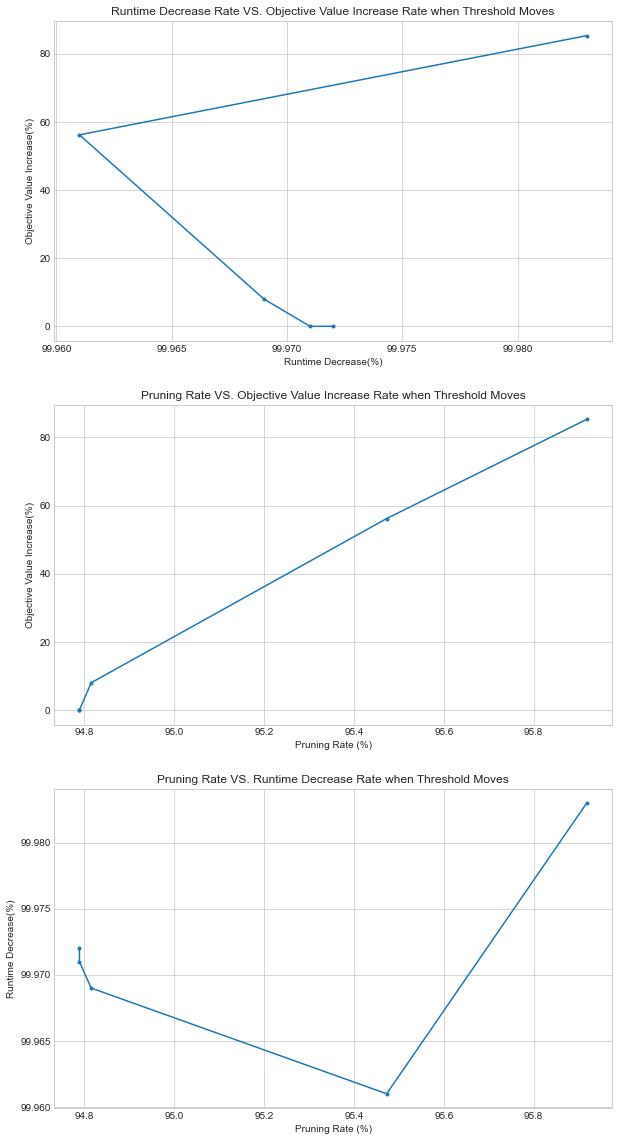

When the runtime reduces 99.983%, the objective value increases 85.306%, pruning rate is 95.918% and threshold is 0.8
When the runtime reduces 99.961%, the objective value increases 56.196%, pruning rate is 95.473% and threshold is 0.7
When the runtime reduces 99.969%, the objective value increases 8.012%, pruning rate is 94.816% and threshold is 0.6
When the runtime reduces 99.971%, the objective value increases 0.0%, pruning rate is 94.79% and threshold is 0.5
When the runtime reduces 99.972%, the objective value increases 0.0%, pruning rate is 94.79% and threshold is 0.4
The following evaluation is for classifier: SVC


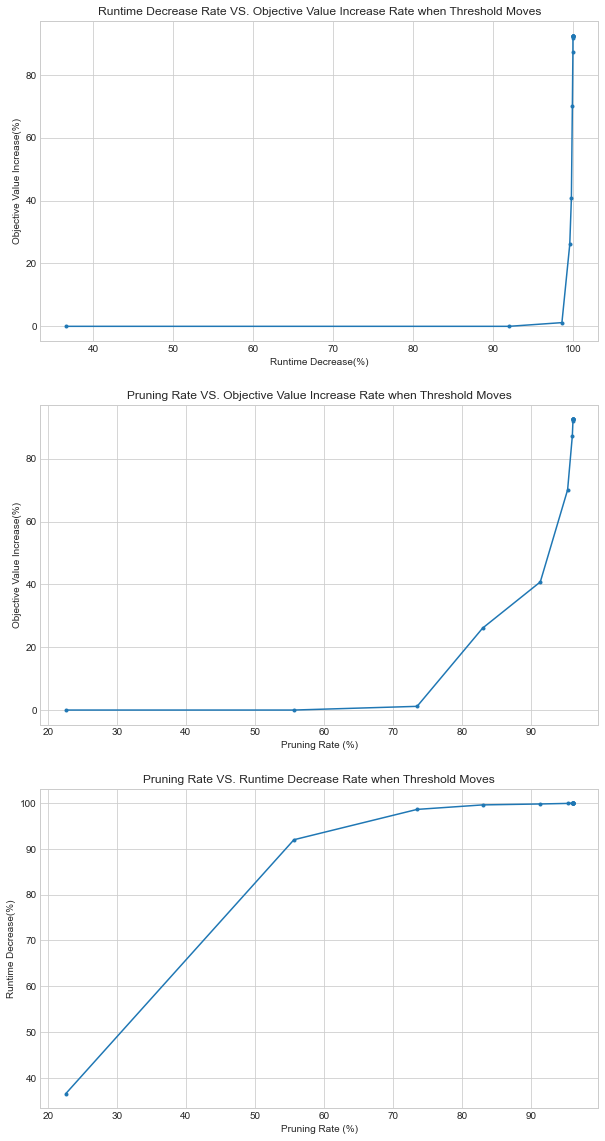

When the runtime reduces 99.994%, the objective value increases 92.518%, pruning rate is 96.089% and threshold is 0.8
When the runtime reduces 99.994%, the objective value increases 92.518%, pruning rate is 96.089% and threshold is 0.7
When the runtime reduces 99.994%, the objective value increases 92.518%, pruning rate is 96.089% and threshold is 0.6
When the runtime reduces 99.994%, the objective value increases 92.518%, pruning rate is 96.089% and threshold is 0.5
When the runtime reduces 99.994%, the objective value increases 92.518%, pruning rate is 96.089% and threshold is 0.4
When the runtime reduces 99.994%, the objective value increases 92.518%, pruning rate is 96.089% and threshold is 0.3
When the runtime reduces 99.994%, the objective value increases 92.518%, pruning rate is 96.089% and threshold is 0.2
When the runtime reduces 99.994%, the objective value increases 91.855%, pruning rate is 96.085% and threshold is 0.175
When the runtime reduces 99.987%, the objective value 

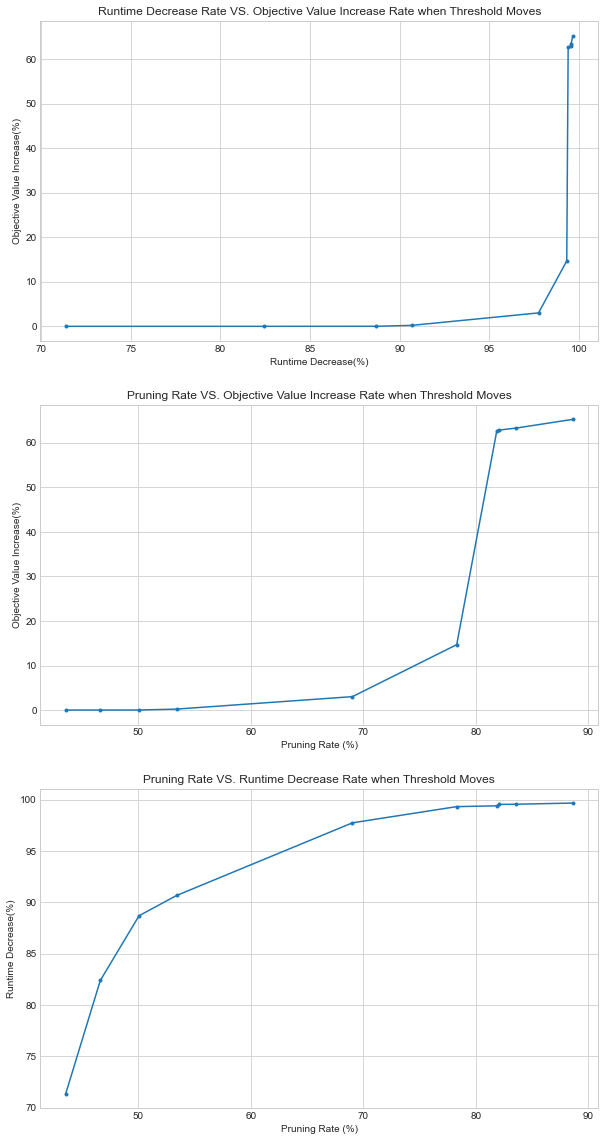

When the runtime reduces 99.669%, the objective value increases 65.264%, pruning rate is 88.634% and threshold is 0.8
When the runtime reduces 99.558%, the objective value increases 63.314%, pruning rate is 83.598% and threshold is 0.7
When the runtime reduces 99.539%, the objective value increases 62.844%, pruning rate is 82.025% and threshold is 0.6
When the runtime reduces 99.401%, the objective value increases 62.753%, pruning rate is 81.867% and threshold is 0.5
When the runtime reduces 99.323%, the objective value increases 14.678%, pruning rate is 78.297% and threshold is 0.4
When the runtime reduces 97.746%, the objective value increases 3.012%, pruning rate is 69.026% and threshold is 0.3
When the runtime reduces 90.669%, the objective value increases 0.215%, pruning rate is 53.39% and threshold is 0.2
When the runtime reduces 88.702%, the objective value increases 0.011%, pruning rate is 50.058% and threshold is 0.175
When the runtime reduces 82.401%, the objective value incr

In [44]:
# Plot the result from customize evaluation
for clf in clfs:
    clf_name = clf.__class__.__name__
    print("The following evaluation is for classifier: {}".format(clf_name))
    
    
    x_runtime = [round(100 * num, 3) for num in runtime_thresholds[clf_name]]
    y_cost = [round(100 * num, 3) for num in cost_thresholds[clf_name]]
    
    n = len(x_runtime)
    tmp_pruning = pruning_thresholds[clf_name][-n:]
    tmp_thresholds = clf_thresholds[clf_name][-n:]
    x_pruning = [100 * (1 - x) for x in tmp_pruning]
    
    fig, ax = plt.subplots(3,figsize=(10,20))
    ax[0].plot(x_runtime, y_cost, marker=".")
    ax[0].set_xlabel("Runtime Decrease(%)")
    ax[0].set_ylabel("Objective Value Increase(%)")
    ax[0].set_title("Runtime Decrease Rate VS. Objective Value Increase Rate when Threshold Moves")
    
    ax[1].plot(x_pruning, y_cost, marker=".")
    ax[1].set_xlabel("Pruning Rate (%)")
    ax[1].set_ylabel("Objective Value Increase(%)")
    ax[1].set_title("Pruning Rate VS. Objective Value Increase Rate when Threshold Moves")
    
    ax[2].plot(x_pruning, x_runtime, marker=".")
    ax[2].set_xlabel("Pruning Rate (%)")
    ax[2].set_ylabel("Runtime Decrease(%)")
    ax[2].set_title("Pruning Rate VS. Runtime Decrease Rate when Threshold Moves")
    
    plt.show()
    fig.savefig("../result/" + clf_name)
    
    
    for i in range(len(x_runtime)):
        print("When the runtime reduces {}%, the objective value increases {}%, pruning rate is {}% and threshold is {}".format(
            round(x_runtime[i], 3),
            round(y_cost[i], 3),
            round(100 * (1 - tmp_pruning[i]), 3),
            tmp_thresholds[i]
        ))